<a href="https://colab.research.google.com/github/ns-it/FL_Xray_Flower/blob/main/Exp_5_3_2_Server_ETA%3D0_01_SGD_lr%3D0_001_momentum%3D0_9_client_epochs%3D5_ALPHA%3D0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q tensorflow
!pip install -q flwr[simulation] matplotlib numpy pandas kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.1/250.1 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.0/732.0 kB 45.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is in

In [ ]:

# --- CONFIG: centralize hyperparameters here ---
# NUM_ROUNDS defined in CONFIG cell above
NUM_ROUNDS = 15
NUM_CLIENTS = 10
MIN_CLIENTS = int(NUM_CLIENTS * 0.8)
BATCH_SIZE = 32
LOCAL_EPOCHS_PER_ROUND = 5         # local epochs per round (E)
CLIENT_LR = 0.001                 # learning rate used on clients (SGD)
SERVER_ETA = 0.01                 # server optimizer eta (FedAdam)
SERVER_BETA1 = 0.9
SERVER_BETA2 = 0.999
PROXIMAL_MU = 0.01                 # recommended FedProx mu (try 0.001,0.01,0.1 in sweeps)
ALPHA = 0.1  # defined in CONFIG                        # Dirichlet alpha (large => near-IID); change to 0.1/0.5 to create non-IID
SEED = 42
OPTIMIZER = "sgd"
MOMENTUM=0.9
# set random seeds for reproducibility
import numpy as np, random, tensorflow as tf, os
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
# End CONFIG


In [ ]:
# --- 1. استيراد المكتبات (نسخة محدثة لحل مشكلة CUDA) ---
import os
import numpy as np
import tensorflow as tf
import flwr as fl
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import logging

# --- Imports for Transfer Learning ---
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
# -------------------------------------

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#  إضافات جديدة لتعريف الأنواع (Types)
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
from flwr.common import NDArrays, Scalar
from typing import Dict, Optional, Tuple

# إخفاء رسائل التحذير الطويلة
logging.getLogger("flwr").setLevel(logging.ERROR)

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#  التعديل الجديد (الحل الصحيح)
#  بدلاً من إخفاء الـ GPU، سنقوم بضبطه ليسمح "بنمو الذاكرة"
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# 1. إجبار TensorFlow على "نمو الذاكرة"
# هذا يمنع الجلسة الرئيسية من حجز كل الذاكرة، ويترك الباقي لـ Ray
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # اجعل TensorFlow يخصص الذاكرة عند الحاجة فقط (Politely)
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    print(f"--- تم تفعيل نمو الذاكرة (Memory Growth) للـ GPU ---")
  except RuntimeError as e:
    # يجب أن يتم هذا قبل بدء TensorFlow
    print(e)

print(f"TensorFlow Version: {tf.__version__}")
print(f"Flower Version: {fl.__version__}")
print(f"NumPy Version: {np.__version__}")

--- تم تفعيل نمو الذاكرة (Memory Growth) للـ GPU ---
TensorFlow Version: 2.19.0
Flower Version: 1.23.0
NumPy Version: 2.0.2


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---

## الخطوة 2: إعداد Kaggle API

لتحميل مجموعة البيانات من Kaggle، نحتاج إلى رفع ملف `kaggle.json` الخاص بك.

In [ ]:
# --- 2. إعداد Kaggle وتحميل البيانات ---

# ارفع ملف kaggle.json
if not os.path.exists("/root/.kaggle/kaggle.json"):
    print("يرجى رفع ملف kaggle.json")
    uploaded = files.upload()
    for fn in uploaded.keys():
        !mkdir -p ~/.kaggle
        !mv {fn} ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
else:
    print("ملف kaggle.json موجود بالفعل.")

يرجى رفع ملف kaggle.json


Saving kaggle.json to kaggle.json


---

## الخطوة 3: تحميل وفك ضغط البيانات

الآن نقوم بتحميل مجموعة بيانات "Chest X-Ray Images (Pneumonia)" وفك ضغطها.

In [ ]:
# --- 3. تحميل وفك ضغط البيانات ---
if not os.path.exists("chest_xray"):
    print("تحميل وفك ضغط مجموعة البيانات...")
    !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
    !unzip -q chest-xray-pneumonia.zip
    print("تم فك ضغط البيانات.")
else:
    print("مجلد البيانات chest_xray موجود بالفعل.")

تحميل وفك ضغط مجموعة البيانات...
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:04<00:00, 501MB/s]
100% 2.29G/2.29G [00:05<00:00, 489MB/s]
تم فك ضغط البيانات.


---

## الخطوة 4: تجهيز البيانات (Data Preprocessing)

سنقوم بإعداد `ImageDataGenerator` لتحميل الصور من المجلدات. سنطبق **زيادة البيانات (Data Augmentation)** على بيانات التدريب فقط لمساعدة النموذج على التعلم بشكل أفضل وتقليل فرط التخصيص (Overfitting).

In [ ]:
# --- 4. تجهيز البيانات (Data Preprocessing) ---
# --- (نسخة معدلة لـ MobileNetV2) ---

# استيراد الدالة الخاصة بالتهيئة
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# تحديد مسارات المجلدات
base_dir = 'chest_xray'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# مسارات فئات التدريب
train_normal_dir = os.path.join(train_dir, 'NORMAL')
train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')

num_normal = len(os.listdir(train_normal_dir))
num_pneumonia = len(os.listdir(train_pneumonia_dir))
print(f"Number of (NORMAL) training Images: {num_normal}")
print(f"Number of (PNEUMONIA) training Images: {num_pneumonia}")

# تحديد الثوابت
IMG_SIZE = (128, 128)
BATCH_SIZE = 32 # (موجودة في خلية الإعدادات أصلاً)

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#  التعديل: استخدام دالة التهيئة الخاصة بـ MobileNetV2
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# مولد بيانات التدريب مع زيادة البيانات (Augmentation)
# نستخدم preprocess_input بدلاً من rescale
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # <--- تعديل هنا
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    shear_range=0.1
)

# مولد بيانات التحقق والاختبار (فقط تهيئة)
val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input) # <--- تعديل هنا

# مولد التدريب (80% من بيانات train_dir)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    color_mode='rgb' # <--- تعديل هنا
)

# مولد التحقق (20% من بيانات train_dir)
# نحتاج لمولد بيانات جديد للتحقق يستخدم نفس دالة التهيئة
validation_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input, # <--- تعديل هنا
    validation_split=0.2
).flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    color_mode='rgb', # <--- تعديل هنا
    shuffle=False
)

# مولد الاختبار (من test_dir)
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb', # <--- تعديل هنا
    shuffle=False
)

Number of (NORMAL) training Images: 1341
Number of (PNEUMONIA) training Images: 3875
Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# --- 5. حساب أوزان الفئات ---
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class Weights (أوزان الفئات): {class_weight_dict}")

Class Weights (أوزان الفئات): {0: np.float64(1.9445479962721341), 1: np.float64(0.6730645161290323)}


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# --- 6. بناء النموذج (Model Definition) ---
# --- (نسخة معدلة لاستخدام MobileNetV2 و Transfer Learning) ---

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import SGD, Adam

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#  التعديل: تعريف دالة بناء النموذج الجديدة
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
def create_cnn_model():
    # 1. تحديد مدخلات النموذج (يجب أن تكون 3 قنوات لـ MobileNetV2)
    inputs = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

    # 2. تحميل نموذج MobileNetV2
    # include_top=False: لإزالة طبقة التصنيف الأصلية (1000 فئة)
    # weights='imagenet': لتحميل الأوزان التي تعلمها من ImageNet
    base_model = MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs
    )

    # 3. تجميد النموذج الأساسي (أهم خطوة في Transfer Learning)
    # لن يتم تحديث أوزان MobileNetV2 أثناء التدريب
    base_model.trainable = False

    # 4. إضافة طبقات التصنيف الخاصة بنا
    x = base_model.output
    x = GlobalAveragePooling2D()(x) # <--- لتقليل الأبعاد
    x = Dense(128, activation='relu')(x) # <--- طبقة كثيفة لنتعلم منها
    x = Dropout(0.5)(x)                  # <--- لتقليل Overfitting
    outputs = Dense(1, activation='sigmoid')(x) # <--- طبقة المخرجات

    # 5. بناء النموذج النهائي
    model = Model(inputs=inputs, outputs=outputs)

    # 6. تحديد المُحسِّن (Optimizer)
    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    #  هام: عند استخدام Transfer Learning، نبدأ بمعدل تعلم (LR) أقل
    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

    # سنستخدم 0.001 بدلاً من 0.01 (المعرفة في خلية الإعدادات)
    # هذا يمنع تدمير الأوزان الجيدة التي جاءت من ImageNet
    transfer_learning_lr = CLIENT_LR

    if (OPTIMIZER == "sgd"):
        optimizer = SGD(learning_rate=transfer_learning_lr, momentum=MOMENTUM, clipnorm=1.0)
    elif (OPTIMIZER == "adam"):
        optimizer = Adam(learning_rate=transfer_learning_lr, clipnorm=1.0)

    # 7. تجميع النموذج (Compile)
    model.compile(optimizer=optimizer,
                  loss=BinaryCrossentropy(name='loss'),
                  metrics=['accuracy',
                           Precision(name='precision'),
                           Recall(name='recall'),
                           AUC(name='auc')])
    return model

In [ ]:
# --- 7. التدريب المركزي (نسخة مُحسّنة مع ذاكرة تخزين مؤقت/Backup) ---

import os
import pickle
from tensorflow.keras.callbacks import EarlyStopping

# اسم ملف النسخة الاحتياطية
backup_file = 'centralized_training_backup.pkl'

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#  التعديل: التحقق من وجود النسخة الاحتياطية
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# if os.path.exists(backup_file):
#     print("--- 💡 تم العثور على نسخة احتياطية للنموذج المركزي 💡 ---")
#     print(f"--- تحميل النتائج من {backup_file} ---")

#     with open(backup_file, 'rb') as f:
#         backup_data = pickle.load(f)

#     # استعادة المتغيرات التي تحتاجها الخلايا 12 و 13
#     centralized_history_dict = backup_data['history_dict']
#     centralized_results = backup_data['results_dict']

#     print("--- ✅ تم التحميل بنجاح. سيتم تخطي التدريب المركزي. ---")

# else:
#     # --- (إذا لم توجد نسخة احتياطية، قم بالتدريب كالمعتاد) ---
#     print(f"--- ⚠️ لم يتم العثور على نسخة احتياطية. سيبدأ التدريب المركزي ---")

centralized_model = create_cnn_model()
centralized_model.summary()

# 2. تعريف آلية التوقف المبكر
early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
)

print("\n--- Starting Centralized Model Training (with Early Stopping) ---")
# 3. تدريب النموذج
history = centralized_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        class_weight=class_weight_dict,
        callbacks=[early_stopping]
)

# 4. تقييم النموذج
print("\n--- Evaluating Centralized Model (Best Version) ---")
results = centralized_model.evaluate(test_generator, return_dict=True)
loss = results['loss']
accuracy = results['accuracy']
precision = results.get('precision', 0.0)
recall = results.get('recall', 0.0)
auc = results.get('auc', 0.0)

print(f"Centralized Learning Loss: {loss:.4f}")
print(f"Centralized Learning Accuracy: {accuracy:.4f}")
print(f"Centralized Learning Precision: {precision:.4f}")
print(f"Centralized Learning Recall: {recall:.4f}")
print(f"Centralized Learning AUC: {auc:.4f}")

# 5. تخزين القاموس كاملاً
centralized_results = results

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    #  الإضافة: حفظ النتائج في النسخة الاحتياطية
    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    # نحتاج 'history.history' (القاموس) وليس 'history' (الكائن)
centralized_history_dict = history.history

data_to_save = {
        'history_dict': centralized_history_dict,
        'results_dict': centralized_results
}
with open(backup_file, 'wb') as f:
        pickle.dump(data_to_save, f)
print(f"--- ✅ تم حفظ نتائج التدريب المركزي في {backup_file} ---")

/tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


--- Starting Centralized Model Training (with Early Stopping) ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


Epoch 1/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 92s 577ms/step - accuracy: 0.6145 - auc: 0.6364 - loss: 0.8621 - precision: 0.8134 - recall: 0.6206 - val_accuracy: 0.8178 - val_auc: 0.9610 - val_loss: 0.4029 - val_precision: 0.9867 - val_recall: 0.7652
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 51s 388ms/step - accuracy: 0.8342 - auc: 0.9077 - loss: 0.3796 - precision: 0.9400 - recall: 0.8328 - val_accuracy: 0.8619 - val_auc: 0.9708 - val_loss: 0.3264 - val_precision: 0.9846 - val_recall: 0.8271
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 55s 419ms/step - accuracy: 0.8635 - auc: 0.9339 - loss: 0.3273 - precision: 0.9485 - recall: 0.8629 - val_accuracy: 0.8456 - val_auc: 0.9767 - val_loss: 0.3520 - val_precision: 0.9936 - val_recall: 0.7974
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 57s 438ms/step - accuracy: 0.8892 - auc: 0.9504 - loss: 0.2825 - precision: 0.9580 - recall: 0.8902 - val_accuracy: 0.9022 - val_auc: 0.9775 - val_loss: 0.2582 - val_precision: 0.9870 - val_recall: 0.8800
Epoch 5/50
131/131 ━

In [ ]:
# --- 8. إعداد التعلم الاتحادي (FL Setup - محاكاة Non-IID واقعي) ---
# --- (نسخة معدلة لـ MobileNetV2) ---

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#  التعديل: استيراد الدالة الخاصة بالتهيئة
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# دالة لتحميل البيانات كـ NumPy arrays (تبقى كما هي)
def load_data_as_numpy(generator):
    images, labels = next(generator)
    return images, labels

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#  التعديل: استخدام دالة التهيئة و 'rgb'
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# مولد لتحميل كل بيانات التدريب (80% split) مرة واحدة
# (يجب أن نستخدم train_generator.n الذي تم حسابه في الخلية 8)
train_full_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input, # <--- تعديل هنا
    validation_split=0.2
).flow_from_directory(
    train_dir, target_size=IMG_SIZE,
    batch_size=train_generator.n,
    class_mode='binary',
    subset='training',
    color_mode='rgb', # <--- تعديل هنا
    shuffle=False
)

# مولد لتحميل كل بيانات الاختبار مرة واحدة
# (يجب أن نستخدم test_generator.n الذي تم حسابه في الخلية 8)
test_full_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input # <--- تعديل هنا
).flow_from_directory(
    test_dir, target_size=IMG_SIZE,
    batch_size=test_generator.n,
    class_mode='binary',
    color_mode='rgb', # <--- تعديل هنا
    shuffle=False
)

print("\nLoading data for FL simulation...")
x_train_fl, y_train_fl = load_data_as_numpy(train_full_generator)
x_test_fl, y_test_fl = load_data_as_numpy(test_full_generator)

print(f"FL training data shape: {x_train_fl.shape}")
print(f"FL training labels shape: {y_train_fl.shape}")
print(f"FL test data shape: {x_test_fl.shape}")
print(f"FL test labels shape: {y_test_fl.shape}")


# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#  الجزء الخاص بتوزيع ديريخليه (Dirichlet) - يبقى كما هو تماماً
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

NUM_CLIENTS = 10 # (معرف في خلية الإعدادات)
NUM_CLASSES = 2 # (0: NORMAL, 1: PNEUMONIA)
ALPHA = ALPHA  # (معرف في خلية الإعدادات)

print(f"\nPartitioning data into {NUM_CLIENTS} clients using Dirichlet (Alpha={ALPHA})...")

# 1. فصل مؤشرات (indices) كل فئة
class_indices = [np.where(y_train_fl == i)[0] for i in range(NUM_CLASSES)]

# 2. إنشاء قوائم فارغة لكل عميل
client_data_indices = [[] for _ in range(NUM_CLIENTS)]

# 3. توزيع مؤشرات كل فئة على حدة
for class_idx in range(NUM_CLASSES):
    indices_for_class = class_indices[class_idx]
    num_samples_in_class = len(indices_for_class)

    # خلط المؤشرات داخل الفئة
    np.random.shuffle(indices_for_class)

    # إنشاء توزيع ديريخليه
    proportions = np.random.dirichlet([ALPHA] * NUM_CLIENTS)

    # حساب عدد العينات لكل عميل
    client_samples_per_class = (proportions * num_samples_in_class).astype(int)

    # معالجة البواقي
    remainder = num_samples_in_class - client_samples_per_class.sum()
    client_samples_per_class[np.argmax(proportions)] += remainder

    # 4. تقسيم المؤشرات
    start = 0
    for client_id in range(NUM_CLIENTS):
        num_samples = client_samples_per_class[client_id]
        end = start + num_samples
        client_data_indices[client_id].extend(indices_for_class[start:end])
        start = end

# 5. إنشاء بيانات العميل النهائية
client_data = []
print("\n--- Client Data Distribution (Non-IID) ---")
for client_id in range(NUM_CLIENTS):
    client_indices = client_data_indices[client_id]
    np.random.shuffle(client_indices)

    client_x = x_train_fl[client_indices]
    client_y = y_train_fl[client_indices]

    client_data.append((client_x, client_y))

    if client_id < 10: # طباعة كل العملاء
        num_normal = np.sum(client_y == 0)
        num_pneumonia = np.sum(client_y == 1)
        print(f"Client {client_id}: Total={len(client_y)} | NORMAL={num_normal} | PNEUMONIA={num_pneumonia}")

print("...")
print(f"Data partitioned on: {len(client_data)} Clients (Realistic Non-IID).")

Found 4173 images belonging to 2 classes.
Found 624 images belonging to 2 classes.

Loading data for FL simulation...
FL training data shape: (4173, 128, 128, 3)
FL training labels shape: (4173,)
FL test data shape: (624, 128, 128, 3)
FL test labels shape: (624,)

Partitioning data into 10 clients using Dirichlet (Alpha=0.1)...

--- Client Data Distribution (Non-IID) ---
Client 0: Total=20 | NORMAL=0 | PNEUMONIA=20
Client 1: Total=2335 | NORMAL=255 | PNEUMONIA=2080
Client 2: Total=227 | NORMAL=51 | PNEUMONIA=176
Client 3: Total=15 | NORMAL=15 | PNEUMONIA=0
Client 4: Total=1 | NORMAL=1 | PNEUMONIA=0
Client 5: Total=0 | NORMAL=0 | PNEUMONIA=0
Client 6: Total=1 | NORMAL=0 | PNEUMONIA=1
Client 7: Total=694 | NORMAL=410 | PNEUMONIA=284
Client 8: Total=308 | NORMAL=308 | PNEUMONIA=0
Client 9: Total=572 | NORMAL=33 | PNEUMONIA=539
...
Data partitioned on: 10 Clients (Realistic Non-IID).


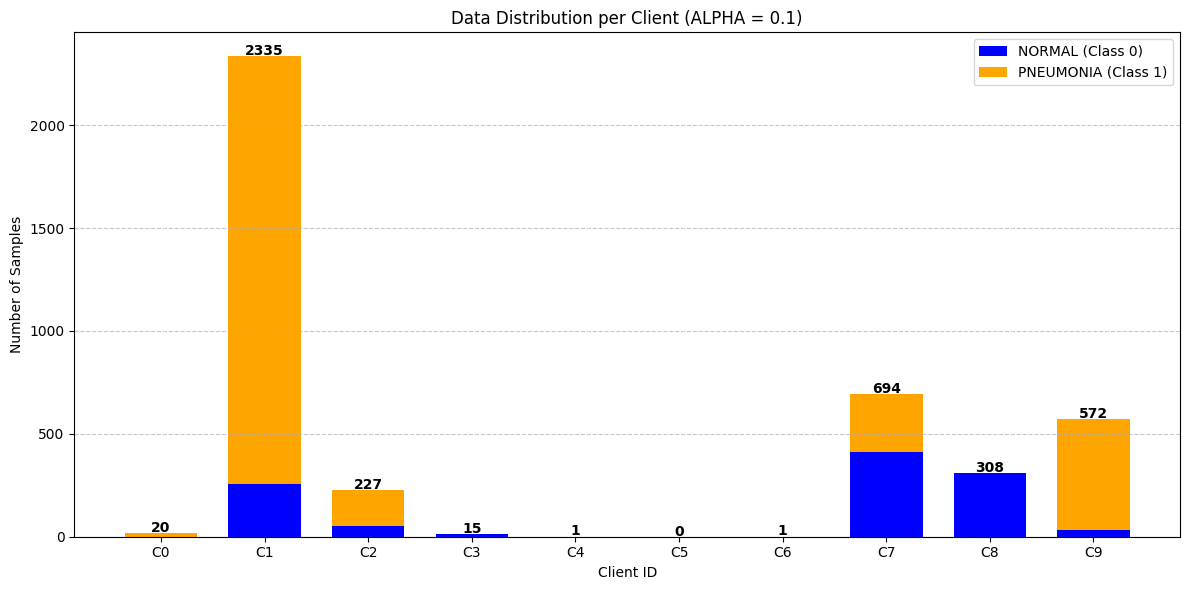

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# --- الخطوة 10 (ب): عرض توزيع البيانات (Data Distribution Visualization) ---

# 1. تجميع الإحصائيات من 'client_data'
# (نفترض أن 0 = NORMAL, 1 = PNEUMONIA)
distribution_data = []
for client_id in range(NUM_CLIENTS):
    client_y = client_data[client_id][1]
    num_normal = np.sum(client_y == 0)
    num_pneumonia = np.sum(client_y == 1)
    distribution_data.append({
        "Client": f"C{client_id}",
        "NORMAL": num_normal,
        "PNEUMONIA": num_pneumonia
    })

# 2. تحويلها إلى DataFrame لسهولة الرسم
df_dist = pd.DataFrame(distribution_data)

# 3. إعداد بيانات الرسم البياني المكدس (Stacked Bar Chart)
client_labels = df_dist["Client"]
normal_counts = df_dist["NORMAL"]
pneumonia_counts = df_dist["PNEUMONIA"]

# 4. إنشاء الرسم البياني
plt.figure(figsize=(12, 6))
bar_width = 0.7

# رسم الفئة الأولى (NORMAL)
plt.bar(client_labels, normal_counts, bar_width, label='NORMAL (Class 0)', color='blue')

# رسم الفئة الثانية (PNEUMONIA) فوقها
plt.bar(client_labels, pneumonia_counts, bar_width, bottom=normal_counts, label='PNEUMONIA (Class 1)', color='orange')

plt.title(f'Data Distribution per Client (ALPHA = {ALPHA})')
plt.xlabel('Client ID')
plt.ylabel('Number of Samples')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# إضافة عدد العينات الكلي فوق كل عمود
totals = normal_counts + pneumonia_counts
for i, total in enumerate(totals):
    plt.text(i, total + 5, str(total), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# --- 9. تعريف العميل الاتحادي (FL Client Definition) ---
# --- (نسخة مُصححة من الحلقة اللانهائية) ---
import math # <--- إضافة لاستخدام math.ceil

class XRayClient(fl.client.NumPyClient):

    def __init__(self, model, x_client, y_client, client_id):
        self.model = model
        self.client_id = client_id

        # مولد بيانات للتدريب المحلي مع زيادة البيانات
        self.train_datagen = ImageDataGenerator(
            # preprocessing_function=preprocess_input, # <--- تعديل هام جداً
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True
        )

        # التحقق من عدد العينات قبل التقسيم (من الإصلاح السابق)
        if len(y_client) < 2:
            print(f"[Client {self.client_id}]: Warning: Received only {len(y_client)} samples. Using all for training.")
            self.x_train, self.y_train = x_client, y_client
            self.x_val, self.y_val = x_client[0:0], y_client[0:0]
        else:
            try:
                self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(
                    x_client, y_client, test_size=0.2, random_state=42, stratify=y_client
                )
            except ValueError:
                print(f"[Client {self.client_id}]: Warning: Stratify failed. Using regular split.")
                self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(
                    x_client, y_client, test_size=0.2, random_state=42
                )

    @tf.function
    def _train_step(self, x_batch, y_batch, global_weights_tensors, mu, sample_weights_tensor):
        with tf.GradientTape() as tape:
            y_pred = self.model(x_batch, training=True)
            loss = self.model.loss(y_batch, y_pred)

            if sample_weights_tensor is not None:
                loss = loss * sample_weights_tensor
                loss = tf.reduce_mean(loss)

            if mu > 0.0:
                prox_term = 0.0
                for model_weight, global_weight in zip(self.model.trainable_weights, global_weights_tensors):
                    prox_term += tf.reduce_sum(tf.square(model_weight - global_weight))
                loss += (mu / 2) * prox_term

        grads = tape.gradient(loss, self.model.trainable_weights)
        self.model.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        return loss


    def get_parameters(self, config):
        return self.model.get_weights()


    def fit(self, parameters, config):

        print(f"\n--- [Client {self.client_id}]: Starting fit() for Round ---")

        self.model.set_weights(parameters)
        global_weights_tensors = [tf.convert_to_tensor(w) for w in parameters]
        mu = config.get("mu", 0.0)

        if mu > 0.0:
            print(f"[Client {self.client_id}]: Mode = FedProx (mu={mu})")
        else:
            print(f"[Client {self.client_id}]: Mode = FedAvg (mu=0.0)")

        # (حساب أوزان الفئات)
        local_weight_dict = None
        if len(np.unique(self.y_train)) > 1:
            try:
                local_weights = compute_class_weight('balanced', classes=np.unique(self.y_train), y=self.y_train)
                local_weight_dict = dict(enumerate(local_weights))
            except ValueError:
                pass

        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        #  التعديل: حساب steps_per_epoch
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        # BATCH_SIZE تم تعريفها في الخلية 4 (كانت 32)
        steps_per_epoch = math.ceil(len(self.x_train) / BATCH_SIZE)

        # 2. حلقة التدريب الخارجية (بايثون)
        for epoch in range(LOCAL_EPOCHS_PER_ROUND):
            print(f"[Client {self.client_id}]: Starting local epoch {epoch+1}/{LOCAL_EPOCHS_PER_ROUND}...")
            train_flow = self.train_datagen.flow(
                self.x_train, self.y_train, batch_size=BATCH_SIZE, shuffle=True, seed = 42
            )

            batch_count = 0
            for x_batch, y_batch in train_flow:
                # (حساب أوزان العينات)
                sample_weights_tensor = None
                if local_weight_dict:
                    sample_weights_np = np.array([local_weight_dict[c] for c in y_batch])
                    sample_weights_tensor = tf.convert_to_tensor(sample_weights_np, dtype=tf.float32)

                loss_value = self._train_step(x_batch, y_batch, global_weights_tensors, mu, sample_weights_tensor)

                if batch_count % 10 == 0:
                    print(f"[Client {self.client_id}]: Epoch {epoch+1}, Batch {batch_count}/{steps_per_epoch}, Loss: {loss_value.numpy():.4f}...")

                batch_count += 1

                # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
                #  التعديل: إضافة شرط الخروج من الحلقة
                # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
                if batch_count >= steps_per_epoch:
                    break # <--- الخروج من الحلقة الداخلية

            print(f"[Client {self.client_id}]: === Finished local epoch {epoch+1}/{LOCAL_EPOCHS_PER_ROUND} ===")

        # تقييم الأداء
        val_metrics = self.model.evaluate(self.x_val, self.y_val, verbose=0, return_dict=True)
        print(f"--- [Client {self.client_id}]: Finished fit(). Local val_acc: {val_metrics.get('accuracy', 0.0):.4f} ---")
        return self.model.get_weights(), len(self.x_train), {"local_accuracy": val_metrics.get('accuracy', 0.0)}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        metrics = self.model.evaluate(x_test_fl, y_test_fl, verbose=0, return_dict=True)
        return metrics['loss'], len(x_test_fl), metrics

In [ ]:
# --- 10. تعريف استراتيجيات الخادم ---
from flwr.common import Context
from flwr.server.strategy import FedAdam
from flwr.common import ndarrays_to_parameters
from flwr.common import NDArrays, Scalar
from typing import Dict, Optional, Tuple


# دالة تقييم على الخادم (محدثة لجمع كل المقاييس)
def evaluate_on_server(server_round: int, parameters: NDArrays, config: Dict[str, Scalar]) -> Optional[Tuple[float, Dict[str, Scalar]]]:
    model = create_cnn_model()
    model.set_weights(parameters)

    metrics = model.evaluate(x_test_fl, y_test_fl, verbose=0, return_dict=True)

    print(f"\n=======================================================")
    print(f"ROUND {server_round}: Aggregated Accuracy = {metrics['accuracy']:.4f}")
    print(f" (Loss: {metrics['loss']:.4f}, Prec: {metrics.get('precision', 0.0):.4f}, Rec: {metrics.get('recall', 0.0):.4f})")
    print(f"=======================================================\n")

    return metrics['loss'], metrics


# دالة إنشاء العميل (باستخدام التعريف الأصلي cid: str)
def client_fn(cid: str) -> XRayClient:
    model = create_cnn_model()
    client_x, client_y = client_data[int(cid)]
    return XRayClient(model, client_x, client_y, client_id=cid)


MIN_CLIENTS = int(NUM_CLIENTS * 0.8)

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#  التعديل: تعريف الأوزان الأولية مرة واحدة للجميع
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
print("--- Creating initial model for ALL strategies ---")
model_for_init = create_cnn_model()
initial_params = ndarrays_to_parameters(model_for_init.get_weights())
print("--- Initial parameters created successfully ---")

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#  الإضافة: تقييم النموذج الأولي على بيانات التحقق
#  (لنرسم نقطة البداية "Epoch 0" للنموذج المركزي)
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
print("--- Evaluating initial model on validation set (for Epoch 0 plot) ---")
# نستخدم 'validation_generator' لأن 'history' (المركزي) يستخدمها
# نستخدم 'return_dict=True' لسهولة القراءة
initial_model_val_metrics = model_for_init.evaluate(validation_generator, return_dict=True, verbose=0)
print(f"--- Initial val_accuracy (Epoch 0): {initial_model_val_metrics['accuracy']:.4f} ---")

# 1. استراتيجية FedAvg العادية (مدمجة)
strategy_fedavg = fl.server.strategy.FedAvg(
    initial_parameters=initial_params,
    fraction_fit=1.0,
    min_fit_clients=MIN_CLIENTS,
    min_available_clients=NUM_CLIENTS,
    evaluate_fn=evaluate_on_server,
    fraction_evaluate=0.0
)

# 2. استراتيجية FedProx (المدمجة)
strategy_fedprox = fl.server.strategy.FedProx(
    initial_parameters=initial_params,
    fraction_fit=1.0,
    min_fit_clients=MIN_CLIENTS,
    min_available_clients=NUM_CLIENTS,
    evaluate_fn=evaluate_on_server,
    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    #  التعديل: زيادة "قوة" العقوبة 10x
    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    proximal_mu=PROXIMAL_MU,
    fraction_evaluate=0.0
)

# 3. استراتيجية FedAdam (المدمجة)
strategy_fedadam = FedAdam(
    initial_parameters=initial_params,
    fraction_fit=1.0,
    min_fit_clients=MIN_CLIENTS,
    min_available_clients=NUM_CLIENTS,
    evaluate_fn=evaluate_on_server,
    eta=SERVER_ETA,
    beta_1=SERVER_BETA1,
    beta_2=SERVER_BETA2,
    tau=1e-7,
    fraction_evaluate=0.0
)

/tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


--- Creating initial model for ALL strategies ---
--- Initial parameters created successfully ---
--- Evaluating initial model on validation set (for Epoch 0 plot) ---
--- Initial val_accuracy (Epoch 0): 0.3212 ---


In [ ]:
# --- 11. بدء المحاكاة (لكل الاستراتيجيات) ---

# NUM_ROUNDS defined in CONFIG cell above

# إعدادات Ray لاستخدام الـ GPU
ray_init_args = {
    "include_dashboard": False,
    "num_gpus": 1,
    "num_cpus": 3    # <--- نضيف هذا لتحديد التوازي
}

# إخبار Flower بإعطاء 10% من الـ GPU لكل عميل
client_resources = {
    "num_gpus": 0.1,

}

print(f"Ray init args: {ray_init_args}")

Ray init args: {'include_dashboard': False, 'num_gpus': 1, 'num_cpus': 3}


In [ ]:
# 1. تشغيل FedAvg
print("\n--- بدء محاكاة (FedAvg) ---")
history_fedavg = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
    strategy=strategy_fedavg,
    ray_init_args=ray_init_args,
    client_resources=client_resources
)



--- بدء محاكاة (FedAvg) ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
2025-11-12 08:04:46,378	INFO worker.py:1771 -- Started a local Ray instance.
/tmp/ipython-input-42276152.py:3: UserWarning: No `num_cpus` specified in `client_resources`. Using `num_cpus=1` for each client.
  history_fedavg = fl.simulation.start_simulation(
/tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(
(pid=5042) 2025-11-12 08:04:50.974526: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when 


ROUND 0: Aggregated Accuracy = 0.3862
 (Loss: 0.9434, Prec: 0.5778, Rec: 0.0667)



(ClientAppActor pid=5043) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5043) 
(ClientAppActor pid=5043)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5043)             entirely in future versions of Flower.
(ClientAppActor pid=5043)         
(ClientAppActor pid=5043) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(pid=5043) 2025-11-12 08:04:51.123811: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered [repeated 2x across cluster] (Ray deduplicates l

(ClientAppActor pid=5043) [Client 4]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=5043) 
(ClientAppActor pid=5043) --- [Client 4]: Starting fit() for Round ---


(ClientAppActor pid=5043) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=5043) [Client 4]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5043) [Client 4]: Starting local epoch 1/5...
(ClientAppActor pid=5041) 


(ClientAppActor pid=5043) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5043)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=5043) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7dae84023b50>> and will run it as-is.
(ClientAppActor pid=5043) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5043) Cause: Unknown node type <gast.gast.Import object at 0x7dae846f5b50>
(ClientAppActor pid=5043) To silence this warning, decorate the function with @tf.autograph.experimental.do

(ClientAppActor pid=5042) 


(ClientAppActor pid=5043) I0000 00:00:1762934705.880493    5433 cuda_dnn.cc:529] Loaded cuDNN version 91002
(ClientAppActor pid=5041) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=5041)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=5041)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=5041) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 2x across cluster]
(ClientAppActor pid=5041) 2025-11-12 08:05:00.508178: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocato

(ClientAppActor pid=5043) [Client 4]: Epoch 1, Batch 0/1, Loss: 0.9358...
(ClientAppActor pid=5043) [Client 4]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5042) --- [Client 1]: Starting fit() for Round --- [repeated 2x across cluster]
(ClientAppActor pid=5042) [Client 1]: Mode = FedAvg (mu=0.0) [repeated 2x across cluster]
(ClientAppActor pid=5043) [Client 4]: Starting local epoch 2/5... [repeated 3x across cluster]
(ClientAppActor pid=5043) [Client 4]: Epoch 2, Batch 0/1, Loss: 0.4191...
(ClientAppActor pid=5043) [Client 4]: === Finished local epoch 2/5 ===
(ClientAppActor pid=5043) [Client 4]: Epoch 3, Batch 0/1, Loss: 0.4433...
(ClientAppActor pid=5043) [Client 4]: === Finished local epoch 3/5 ===
(ClientAppActor pid=5043) [Client 4]: Epoch 4, Batch 0/1, Loss: 0.0846...
(ClientAppActor pid=5043) [Client 4]: === Finished local epoch 4/5 ===
(ClientAppActor pid=5043) [Client 4]: Epoch 5, Batch 0/1, Loss: 0.5036...
(ClientAppActor pid=5043) [Client 4]: === Finished local epoc

(ClientAppActor pid=5043) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=5043)   self._interrupted_warning()
(ClientAppActor pid=5042) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=5042) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0. [repeated 2x across cluster]
(ClientA

(ClientAppActor pid=5043) --- [Client 4]: Finished fit(). Local val_acc: 0.0000 ---


(ClientAppActor pid=5043) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5043) 
(ClientAppActor pid=5043)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5043)             entirely in future versions of Flower.
(ClientAppActor pid=5043)         
(ClientAppActor pid=5043) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=5043) 
(ClientAppActor pid=5041) [Client 8]: Epoch 3, Batch 0/8, Loss: 0.0356... [repeated 7x across cluster]
(ClientAppActor pid=5041) [Client 8]: === Finished local epoch 3/5 === [repeated 3x across cluster]
(ClientAppActor pid=5043) --- [Client 9]: Starting fit() for Round ---
(ClientAppActor pid=5043) [Client 9]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5041) [Client 8]: Starting local epoch 4/5... [repeated 7x across cluster]


(ClientAppActor pid=5041) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=5041) I0000 00:00:1762934718.441590    5501 service.cc:152] XLA service 0x7cb78992ab40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
(ClientAppActor pid=5041) I0000 00:00:1762934718.441648    5501 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
(ClientAppActor pid=5043) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=5043) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor 

(ClientAppActor pid=5042) [Client 1]: Epoch 2, Batch 10/59, Loss: 0.8318... [repeated 8x across cluster]
(ClientAppActor pid=5042) [Client 1]: === Finished local epoch 1/5 === [repeated 3x across cluster]
(ClientAppActor pid=5042) [Client 1]: Starting local epoch 2/5... [repeated 2x across cluster]
(ClientAppActor pid=5042) [Client 1]: Epoch 2, Batch 50/59, Loss: 0.1871... [repeated 9x across cluster]
(ClientAppActor pid=5043) [Client 9]: === Finished local epoch 3/5 === [repeated 3x across cluster]
(ClientAppActor pid=5043) [Client 9]: Starting local epoch 4/5... [repeated 3x across cluster]


(ClientAppActor pid=5041) 2025-11-12 08:05:25.892595: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=5041) 2025-11-12 08:05:26.030356: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=5041) I0000 00:00:1762934727.802872    5501 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
(ClientAppActor pid=5043) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=5043) I0000 00:00:1762934730.130870    5433 service.cc:152] XLA service 0x7dad356e8f90 initialized for platform CUDA (this does not guarantee that XLA will be used

(ClientAppActor pid=5042) [Client 1]: Epoch 3, Batch 40/59, Loss: 0.5590... [repeated 8x across cluster]
(ClientAppActor pid=5043) [Client 9]: === Finished local epoch 5/5 === [repeated 3x across cluster]
(ClientAppActor pid=5042) [Client 1]: Starting local epoch 3/5... [repeated 2x across cluster]


(ClientAppActor pid=5041) 2025-11-12 08:05:36.122995: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=5041) 2025-11-12 08:05:36.261289: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=5041) 2025-11-12 08:05:36.412345: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=5041) 2025-11-12 08:05:36.562016: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execu

(ClientAppActor pid=5042) [Client 1]: Epoch 4, Batch 30/59, Loss: 0.1776... [repeated 5x across cluster]
(ClientAppActor pid=5042) [Client 1]: === Finished local epoch 3/5 ===
(ClientAppActor pid=5042) [Client 1]: Starting local epoch 4/5...
(ClientAppActor pid=5041) --- [Client 8]: Finished fit(). Local val_acc: 1.0000 ---


(ClientAppActor pid=5041) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5041) 
(ClientAppActor pid=5041)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5041)             entirely in future versions of Flower.
(ClientAppActor pid=5041)         
(ClientAppActor pid=5041) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=5043) I0000 00:00:1762934740.118430    5433 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


(ClientAppActor pid=5042) [Client 1]: === Finished local epoch 4/5 ===
(ClientAppActor pid=5042) [Client 1]: Starting local epoch 5/5...
(ClientAppActor pid=5041) [Client 6]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=5041) 
(ClientAppActor pid=5041) --- [Client 6]: Starting fit() for Round ---


(ClientAppActor pid=5041) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=5041) [Client 6]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=5041) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cb840470e50>> and will run it as-is.
(ClientAppActor pid=5041) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5041) Cause: Unknown node type <gast.gast.Import object at 0x7cb8407bf710>
(ClientAppActor pid=5041) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=5042) [Client 1]: Epoch 5, Batch 20/59, Loss: 0.0924... [repeated 5x across cluster]
(ClientAppActor pid=5041) [Client 6]: === Finished local epoch 5/5 === [repeated 5x across cluster]
(ClientAppActor pid=5041) [Client 6]: Starting local epoch 5/5... [repeated 5x across cluster]


(ClientAppActor pid=5041) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=5041)   self._interrupted_warning()
(ClientAppActor pid=5043) 2025-11-12 08:05:38.333604: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems. [repeated 4x across cluster]


(ClientAppActor pid=5041) --- [Client 6]: Finished fit(). Local val_acc: 0.0000 ---


(ClientAppActor pid=5041) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5041) 
(ClientAppActor pid=5041)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5041)             entirely in future versions of Flower.
(ClientAppActor pid=5041)         
(ClientAppActor pid=5041) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=5041) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=5041) [Client 5]: Warning: Received only 0 samples. Using all for training.
(ClientAppActor pid=5041) 
(ClientAppActor pid=5041) --- [Client 5]: Starting fit() for Round ---
(ClientAppActor pid=5042) [Client 1]: Epoch 5, Batch 50/59, Loss: 0.1734... [repeated 8x across cluster]


(ClientAppActor pid=5041) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cb901e020e0>> and will run it as-is.
(ClientAppActor pid=5041) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5041) Cause: Unknown node type <gast.gast.Import object at 0x7cb8785fb450>
(ClientAppActor pid=5041) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=5041) [Client 5]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=5042) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=5042) I0000 00:00:1762934750.882631    5460 service.cc:152] XLA service 0x7f3eedd187c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
(ClientAppActor pid=5042) I0000 00:00:1762934750.882676    5460 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5


(ClientAppActor pid=5042) [Client 1]: === Finished local epoch 5/5 ===
(ClientAppActor pid=5041) [Client 5]: Starting local epoch 1/5...


(ClientAppActor pid=5043) 
(ClientAppActor pid=5043)         
(ClientAppActor pid=5041) W0000 00:00:1762934751.808642    5041 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "SAME" } } attr { key: "strides" value { list { i: 1 i: 1 i: 2 i: 2 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 3 } dim { size: 128 } dim { size: 128 } } } inputs { dtype: DT_FLOAT shape { dim { size: 3 } dim { size: 3 } dim { size: 3 } dim { size: 32 } } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12050" } environment { key: "cudnn" value: "90300" } num_re

(ClientAppActor pid=5043) 


(ClientAppActor pid=5041) 
(ClientAppActor pid=5041)         


(ClientAppActor pid=5043) [Client 3]: Starting local epoch 1/5...
(ClientAppActor pid=5043) --- [Client 9]: Finished fit(). Local val_acc: 0.9391 ---


(ClientAppActor pid=5043) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5043)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=5043) 2025-11-12 08:05:48.311337: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems. [repeated 2x across cluster]
(ClientAppActor pid=5041) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=5041)            

(ClientAppActor pid=5041) 
(ClientAppActor pid=5043) [Client 3]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5041) --- [Client 7]: Starting fit() for Round --- [repeated 2x across cluster]
(ClientAppActor pid=5043) [Client 3]: Epoch 1, Batch 0/1, Loss: 0.5612...
(ClientAppActor pid=5041) [Client 7]: Mode = FedAvg (mu=0.0) [repeated 2x across cluster]
(ClientAppActor pid=5043) [Client 3]: Epoch 2, Batch 0/1, Loss: 0.6145...
(ClientAppActor pid=5043) [Client 3]: === Finished local epoch 2/5 ===
(ClientAppActor pid=5043) [Client 3]: Epoch 3, Batch 0/1, Loss: 0.3446...
(ClientAppActor pid=5043) [Client 3]: === Finished local epoch 3/5 ===
(ClientAppActor pid=5043) [Client 3]: Epoch 4, Batch 0/1, Loss: 0.4824...
(ClientAppActor pid=5043) [Client 3]: === Finished local epoch 4/5 ===
(ClientAppActor pid=5043) [Client 3]: Epoch 5, Batch 0/1, Loss: 0.3009...
(ClientAppActor pid=5043) [Client 3]: === Finished local epoch 5/5 ===
(ClientAppActor pid=5043) [Client 3]: Starting local epoch

(ClientAppActor pid=5041) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=5041) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cb81b5c7430>> and will run it as-is. [repeated 2x across cluster]
(ClientAppActor pid=5041) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 2x across cluster]
(ClientAppActor pid=5041) Cause: Unknown node type <gast.gast.Import object at 0x7cb8182d3450> [repeated 2x across cluster]
(ClientAppActor pid=5041) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [

(ClientAppActor pid=5041) [Client 7]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5041) [Client 7]: Epoch 2, Batch 10/18, Loss: 0.5434... [repeated 4x across cluster]
(ClientAppActor pid=5041) [Client 7]: === Finished local epoch 2/5 ===
(ClientAppActor pid=5041) [Client 7]: Starting local epoch 3/5... [repeated 2x across cluster]
(ClientAppActor pid=5041) [Client 7]: === Finished local epoch 3/5 ===


(ClientAppActor pid=5043) 2025-11-12 08:06:05.418469: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=5043) 2025-11-12 08:06:05.556835: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=5043) 2025-11-12 08:06:05.694857: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=5043) 2025-11-12 08:06:05.831208: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execu

(ClientAppActor pid=5041) [Client 7]: === Finished local epoch 4/5 ===
(ClientAppActor pid=5041) [Client 7]: Epoch 5, Batch 0/18, Loss: 0.3295... [repeated 5x across cluster]
(ClientAppActor pid=5041) [Client 7]: Starting local epoch 5/5... [repeated 2x across cluster]
(ClientAppActor pid=5043) --- [Client 3]: Finished fit(). Local val_acc: 1.0000 ---


(ClientAppActor pid=5043) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5043) 
(ClientAppActor pid=5043)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5043)             entirely in future versions of Flower.
(ClientAppActor pid=5043)         
(ClientAppActor pid=5043) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=5041) [Client 7]: === Finished local epoch 5/5 ===
(ClientAppActor pid=5043) 
(ClientAppActor pid=5043) --- [Client 0]: Starting fit() for Round ---
(ClientAppActor pid=5043) [Client 0]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=5043) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=5043) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5043)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=5043) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7dadacd7f310>> and will run it as-is.
(ClientAppActor pid=5043) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOS

(ClientAppActor pid=5042) 
(ClientAppActor pid=5041) [Client 7]: Epoch 5, Batch 10/18, Loss: 0.3361...
(ClientAppActor pid=5043) [Client 0]: Epoch 1, Batch 0/1, Loss: 1.6058...
(ClientAppActor pid=5043) [Client 0]: Epoch 2, Batch 0/1, Loss: 1.1981...
(ClientAppActor pid=5043) [Client 0]: Starting local epoch 3/5... [repeated 4x across cluster]
(ClientAppActor pid=5042) --- [Client 1]: Finished fit(). Local val_acc: 0.9486 ---
(ClientAppActor pid=5043) [Client 0]: Epoch 3, Batch 0/1, Loss: 1.3649...
(ClientAppActor pid=5043) [Client 0]: Epoch 4, Batch 0/1, Loss: 1.2455...
(ClientAppActor pid=5043) [Client 0]: Epoch 5, Batch 0/1, Loss: 1.4109...
(ClientAppActor pid=5043) [Client 0]: === Finished local epoch 5/5 === [repeated 5x across cluster]
(ClientAppActor pid=5042) --- [Client 2]: Starting fit() for Round ---
(ClientAppActor pid=5042) [Client 2]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5042) [Client 2]: Epoch 1, Batch 0/6, Loss: 1.3621...
(ClientAppActor pid=5042) [Client 2]: Star

(ClientAppActor pid=5042) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5042)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5042)             entirely in future versions of Flower.
(ClientAppActor pid=5042) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=5042) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=5042) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preproces

(ClientAppActor pid=5041) --- [Client 7]: Finished fit(). Local val_acc: 0.8561 ---
(ClientAppActor pid=5042) [Client 2]: Starting local epoch 5/5... [repeated 3x across cluster]


(ClientAppActor pid=5042) 2025-11-12 08:06:34.895472: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems. [repeated 3x across cluster]


(ClientAppActor pid=5042) [Client 2]: === Finished local epoch 5/5 ===
(ClientAppActor pid=5042) --- [Client 2]: Finished fit(). Local val_acc: 0.7391 --- [repeated 2x across cluster]

ROUND 1: Aggregated Accuracy = 0.7452
 (Loss: 0.5290, Prec: 0.7225, Rec: 0.9615)



(ClientAppActor pid=5042) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5042) 
(ClientAppActor pid=5042)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5042)             entirely in future versions of Flower.
(ClientAppActor pid=5042)         
(ClientAppActor pid=5042) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=5042) 2025-11-12 08:06:35.038559: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientA

(ClientAppActor pid=5042) 
(ClientAppActor pid=5042) --- [Client 9]: Starting fit() for Round ---


(ClientAppActor pid=5042) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5042)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=5042) [Client 9]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5042) [Client 9]: Starting local epoch 1/5...
(ClientAppActor pid=5041) [Client 5]: Warning: Received only 0 samples. Using all for training.


(ClientAppActor pid=5042) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f407f12dc90>> and will run it as-is.
(ClientAppActor pid=5042) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5042) Cause: Unknown node type <gast.gast.Import object at 0x7f4060291f50>
(ClientAppActor pid=5042) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=5043) 
(ClientAppActor pid=5041) 
(ClientAppActor pid=5042) [Client 9]: Epoch 1, Batch 0/15, Loss: 0.3180...


(ClientAppActor pid=5041) W0000 00:00:1762934813.025228    5041 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "SAME" } } attr { key: "strides" value { list { i: 1 i: 1 i: 2 i: 2 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 3 } dim { size: 128 } dim { size: 128 } } } inputs { dtype: DT_FLOAT shape { dim { size: 3 } dim { size: 3 } dim { size: 3 } dim { size: 32 } } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12050" } environment { key: "cudnn" value: "90300" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 sha

(ClientAppActor pid=5041) 
(ClientAppActor pid=5041) --- [Client 0]: Starting fit() for Round --- [repeated 3x across cluster]


(ClientAppActor pid=5041) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0. [repeated 2x across cluster]
(ClientAppActor pid=5041)   scipy.ndimage.interpolation.affine_transform( [repeated 2x across cluster]
(ClientAppActor pid=5041) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cb8181ff7f0>> and will run it as-is. [repeated 3x across cluster]
(ClientAppActor pid=5041) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 3x across cluster]
(ClientAppActor pid=5041) Cause: Unknown node type <gast.gast.Import object at 0x7cb84

(ClientAppActor pid=5041) [Client 0]: Mode = FedAvg (mu=0.0) [repeated 3x across cluster]
(ClientAppActor pid=5041) [Client 0]: Starting local epoch 1/5... [repeated 3x across cluster]
(ClientAppActor pid=5043) [Client 2]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5043) [Client 2]: Epoch 3, Batch 0/6, Loss: 0.4535... [repeated 5x across cluster]
(ClientAppActor pid=5043) [Client 2]: Starting local epoch 5/5... [repeated 10x across cluster]
(ClientAppActor pid=5042) [Client 9]: === Finished local epoch 3/5 === [repeated 12x across cluster]
(ClientAppActor pid=5042) [Client 9]: Epoch 5, Batch 10/15, Loss: 0.1402... [repeated 14x across cluster]


(ClientAppActor pid=5041) 2025-11-12 08:07:07.842748: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=5041) 2025-11-12 08:07:07.984304: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=5041) 2025-11-12 08:07:08.121401: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


(ClientAppActor pid=5041) --- [Client 0]: Finished fit(). Local val_acc: 1.0000 ---
(ClientAppActor pid=5042) [Client 9]: Starting local epoch 5/5... [repeated 2x across cluster]
(ClientAppActor pid=5042) [Client 9]: === Finished local epoch 5/5 === [repeated 2x across cluster]


(ClientAppActor pid=5041) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5041) 
(ClientAppActor pid=5041)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5041)             entirely in future versions of Flower.
(ClientAppActor pid=5041)         
(ClientAppActor pid=5041) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=5041) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=5041) [Client 4]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=5041) 
(ClientAppActor pid=5041) --- [Client 4]: Starting fit() for Round ---
(ClientAppActor pid=5041) [Client 4]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=5041) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cb81a6ac550>> and will run it as-is.
(ClientAppActor pid=5041) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5041) Cause: Unknown node type <gast.gast.Import object at 0x7cb81a6a4650>
(ClientAppActor pid=5041) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(ClientAppActor pid=5042) 
(ClientAppActor pid=5042)         
(ClientAppActor pid=5043) 2025-11-12 08:07:12.428201: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems. [repeated 2x across cluster]


(ClientAppActor pid=5042) 


(ClientAppActor pid=5042) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5042)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=5041) [Client 4]: Epoch 1, Batch 0/1, Loss: 1.5521...
(ClientAppActor pid=5041) [Client 4]: Epoch 2, Batch 0/1, Loss: 1.2039...
(ClientAppActor pid=5041) [Client 4]: Epoch 3, Batch 0/1, Loss: 0.5479...
(ClientAppActor pid=5041) [Client 4]: Epoch 4, Batch 0/1, Loss: 1.3107...
(ClientAppActor pid=5041) [Client 4]: Epoch 5, Batch 0/1, Loss: 2.3784...


(ClientAppActor pid=5043) 
(ClientAppActor pid=5043)         


(ClientAppActor pid=5043) 
(ClientAppActor pid=5043) --- [Client 2]: Finished fit(). Local val_acc: 0.8913 --- [repeated 2x across cluster]
(ClientAppActor pid=5041) [Client 4]: Starting local epoch 5/5... [repeated 6x across cluster]
(ClientAppActor pid=5041) [Client 4]: === Finished local epoch 5/5 === [repeated 5x across cluster]


(ClientAppActor pid=5043) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=5043)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=5043)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=5043) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 2x across cluster]


(ClientAppActor pid=5043) --- [Client 8]: Starting fit() for Round --- [repeated 2x across cluster]
(ClientAppActor pid=5043) [Client 8]: Mode = FedAvg (mu=0.0) [repeated 2x across cluster]


(ClientAppActor pid=5041) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=5041)   self._interrupted_warning()
(ClientAppActor pid=5043) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=5043) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7dad3c401c00>> and will run it as-is. [repeated 2x across cluster]
(ClientAppActor pid=5043) Please report this to the TensorFl

(ClientAppActor pid=5041) 


(ClientAppActor pid=5041) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5041)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=5042) [Client 1]: Epoch 1, Batch 20/59, Loss: 0.1175... [repeated 4x across cluster]
(ClientAppActor pid=5041) --- [Client 4]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=5041) [Client 7]: Starting local epoch 1/5... [repeated 2x across cluster]
(ClientAppActor pid=5043) [Client 8]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5041) --- [Client 7]: Starting fit() for Round ---
(ClientAppActor pid=5041) [Client 7]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5043) [Client 8]: === Finished local epoch 2/5 ===
(ClientAppActor pid=5043) [Client 8]: === Finished local epoch 3/5 ===
(ClientAppActor pid=5043) [Client 8]: === Finished local epoch 4/5 ===
(ClientAppActor pid=5043) [Client 8]: Epoch 4, Batch 0/8, Loss: 0.0261... [repeated 8x across cluster]
(ClientAppActor pid=5043) [Client 8]: === Finished local epoch 5/5 ===
(ClientAppActor pid=5042) [Client 1]: Starting local epoch 2/5... [repeated 6x across cluster]
(ClientAppActor pid=5042) [Clie

(ClientAppActor pid=5043) WARNING:tensorflow:5 out of the last 9 calls to <function TensorFlowTrainer._make_function.<locals>.multi_step_on_iterator at 0x7dad94066a20> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(ClientAppActor pid=5041) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import

(ClientAppActor pid=5041) [Client 7]: === Finished local epoch 3/5 === [repeated 2x across cluster]
(ClientAppActor pid=5042) [Client 1]: Epoch 3, Batch 20/59, Loss: 0.0667... [repeated 9x across cluster]
(ClientAppActor pid=5042) [Client 1]: Starting local epoch 3/5... [repeated 2x across cluster]
(ClientAppActor pid=5041) [Client 7]: === Finished local epoch 5/5 === [repeated 3x across cluster]


(ClientAppActor pid=5043) 2025-11-12 08:07:39.743480: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=5043) 2025-11-12 08:07:39.879154: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


(ClientAppActor pid=5042) [Client 1]: Epoch 4, Batch 10/59, Loss: 0.6071... [repeated 5x across cluster]
(ClientAppActor pid=5043) --- [Client 8]: Finished fit(). Local val_acc: 1.0000 ---


(ClientAppActor pid=5043) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5043) 
(ClientAppActor pid=5043)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5043)             entirely in future versions of Flower.
(ClientAppActor pid=5043)         
(ClientAppActor pid=5043) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=5043) 
(ClientAppActor pid=5043) --- [Client 3]: Starting fit() for Round ---
(ClientAppActor pid=5042) [Client 1]: Starting local epoch 4/5...


(ClientAppActor pid=5043) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=5043) [Client 3]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5043) [Client 3]: Starting local epoch 1/5...


(ClientAppActor pid=5043) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5043)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=5043) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7dad3c75ae00>> and will run it as-is.
(ClientAppActor pid=5043) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5043) Cause: Unknown node type <gast.gast.Import object at 0x7dadacf0b390>
(ClientAppActor pid=5043) To silence this warning, decorate the function with @tf.autograph.experimental.do

(ClientAppActor pid=5042) [Client 1]: === Finished local epoch 3/5 ===


(ClientAppActor pid=5041) 
(ClientAppActor pid=5041)         


(ClientAppActor pid=5041) [Client 6]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=5041) 
(ClientAppActor pid=5043) [Client 3]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5043) [Client 3]: === Finished local epoch 2/5 ===
(ClientAppActor pid=5043) [Client 3]: === Finished local epoch 3/5 ===
(ClientAppActor pid=5043) [Client 3]: === Finished local epoch 4/5 ===
(ClientAppActor pid=5042) [Client 1]: Epoch 4, Batch 50/59, Loss: 0.1440... [repeated 8x across cluster]
(ClientAppActor pid=5043) [Client 3]: === Finished local epoch 5/5 ===
(ClientAppActor pid=5041) --- [Client 7]: Finished fit(). Local val_acc: 0.9065 ---
(ClientAppActor pid=5041) --- [Client 6]: Starting fit() for Round ---
(ClientAppActor pid=5041) [Client 6]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5041) [Client 6]: Starting local epoch 2/5... [repeated 7x across cluster]


(ClientAppActor pid=5041) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=5041)   self._interrupted_warning()
(ClientAppActor pid=5041) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5041)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5041)             entirely in future versions of Flower.
(ClientAppActor pid=5041) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224

(ClientAppActor pid=5041) --- [Client 6]: Finished fit(). Local val_acc: 0.0000 ---


(ClientAppActor pid=5043) WARNING:tensorflow:6 out of the last 11 calls to <function TensorFlowTrainer._make_function.<locals>.multi_step_on_iterator at 0x7dad6bfa53a0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


(ClientAppActor pid=5041) [Client 6]: === Finished local epoch 5/5 === [repeated 6x across cluster]
(ClientAppActor pid=5042) [Client 1]: Epoch 5, Batch 30/59, Loss: 0.1199... [repeated 10x across cluster]
(ClientAppActor pid=5041) [Client 6]: Starting local epoch 5/5... [repeated 3x across cluster]
(ClientAppActor pid=5042) --- [Client 1]: Finished fit(). Local val_acc: 0.9529 --- [repeated 2x across cluster]
(ClientAppActor pid=5042) [Client 1]: === Finished local epoch 5/5 ===
(ClientAppActor pid=5042) [Client 1]: Epoch 5, Batch 50/59, Loss: 0.1168... [repeated 2x across cluster]

ROUND 2: Aggregated Accuracy = 0.7804
 (Loss: 0.4978, Prec: 0.7505, Rec: 0.9718)



(ClientAppActor pid=5042) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5042) 
(ClientAppActor pid=5042)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5042)             entirely in future versions of Flower.
(ClientAppActor pid=5042)         
(ClientAppActor pid=5042) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=5041) 
(ClientAppActor pid=5041)         
(ClientAppActor pid=5043) 
(ClientAppActor pid=5043)         
(ClientAppActor pid=5042) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `Nump

(ClientAppActor pid=5042) 
(ClientAppActor pid=5042) --- [Client 9]: Starting fit() for Round ---
(ClientAppActor pid=5043) 
(ClientAppActor pid=5041) [Client 6]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=5041) 


(ClientAppActor pid=5042) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5042)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=5042) [Client 9]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5042) [Client 9]: Starting local epoch 1/5...


(ClientAppActor pid=5042) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f4060218af0>> and will run it as-is.
(ClientAppActor pid=5042) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5042) Cause: Unknown node type <gast.gast.Import object at 0x7f3f7ef71f50>
(ClientAppActor pid=5042) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=5042) [Client 9]: Epoch 1, Batch 0/15, Loss: 0.1911...
(ClientAppActor pid=5041) [Client 6]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5041) [Client 6]: === Finished local epoch 2/5 ===
(ClientAppActor pid=5041) [Client 6]: === Finished local epoch 3/5 ===
(ClientAppActor pid=5041) [Client 6]: === Finished local epoch 4/5 ===
(ClientAppActor pid=5041) [Client 6]: === Finished local epoch 5/5 ===
(ClientAppActor pid=5041) --- [Client 6]: Starting fit() for Round --- [repeated 2x across cluster]
(ClientAppActor pid=5041) [Client 6]: Mode = FedAvg (mu=0.0) [repeated 2x across cluster]
(ClientAppActor pid=5043) [Client 2]: Starting local epoch 2/5... [repeated 7x across cluster]
(ClientAppActor pid=5041) --- [Client 6]: Finished fit(). Local val_acc: 0.0000 ---


(ClientAppActor pid=5041) 
(ClientAppActor pid=5041)         
(ClientAppActor pid=5041) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=5041)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=5041)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=5041) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 3x across cluster]
(ClientAppActor pid=5041) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient`

(ClientAppActor pid=5041) 


(ClientAppActor pid=5041) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5041)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=5043) [Client 2]: Epoch 5, Batch 0/6, Loss: 0.5570... [repeated 13x across cluster]
(ClientAppActor pid=5043) [Client 2]: === Finished local epoch 5/5 === [repeated 7x across cluster]
(ClientAppActor pid=5041) --- [Client 1]: Starting fit() for Round ---
(ClientAppActor pid=5041) [Client 1]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5042) [Client 9]: Starting local epoch 4/5... [repeated 7x across cluster]
(ClientAppActor pid=5041) [Client 1]: Epoch 1, Batch 20/59, Loss: 0.0858... [repeated 9x across cluster]
(ClientAppActor pid=5042) [Client 9]: === Finished local epoch 5/5 === [repeated 3x across cluster]
(ClientAppActor pid=5042) [Client 9]: Starting local epoch 5/5...
(ClientAppActor pid=5043) --- [Client 2]: Finished fit(). Local val_acc: 0.8913 ---


(ClientAppActor pid=5043) 
(ClientAppActor pid=5043)         
(ClientAppActor pid=5043) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5043)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5043)             entirely in future versions of Flower.
(ClientAppActor pid=5043) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=5041) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=5041) WARN

(ClientAppActor pid=5043) 
(ClientAppActor pid=5043) --- [Client 8]: Starting fit() for Round ---
(ClientAppActor pid=5041) [Client 1]: Epoch 1, Batch 50/59, Loss: 0.1257... [repeated 3x across cluster]
(ClientAppActor pid=5043) [Client 8]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5043) [Client 8]: Starting local epoch 1/5...


(ClientAppActor pid=5043) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5043)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=5043) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7dad26381690>> and will run it as-is.
(ClientAppActor pid=5043) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5043) Cause: Unknown node type <gast.gast.Import object at 0x7dad2648bfd0>
(ClientAppActor pid=5043) To silence this warning, decorate the function with @tf.autograph.experimental.do

(ClientAppActor pid=5041) [Client 1]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5042) --- [Client 9]: Finished fit(). Local val_acc: 0.9565 ---


(ClientAppActor pid=5042) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5042) 
(ClientAppActor pid=5042)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5042)             entirely in future versions of Flower.
(ClientAppActor pid=5042)         
(ClientAppActor pid=5042) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=5042) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=5042) [Client 5]: Warning: Received only 0 samples. Using all for training.
(ClientAppActor pid=5042) 
(ClientAppActor pid=5042) --- [Client 5]: Starting fit() for Round ---
(ClientAppActor pid=5041) [Client 1]: Epoch 2, Batch 20/59, Loss: 0.1146... [repeated 4x across cluster]
(ClientAppActor pid=5041) [Client 1]: Starting local epoch 2/5...
(ClientAppActor pid=5042) [Client 5]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5042) [Client 5]: Starting local epoch 1/5...


(ClientAppActor pid=5042) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f3fd06a2c20>> and will run it as-is.
(ClientAppActor pid=5042) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5042) Cause: Unknown node type <gast.gast.Import object at 0x7f3f94f419d0>
(ClientAppActor pid=5042) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=5043) [Client 8]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5043) [Client 8]: === Finished local epoch 2/5 ===


(ClientAppActor pid=5042) W0000 00:00:1762934925.103638    5042 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "SAME" } } attr { key: "strides" value { list { i: 1 i: 1 i: 2 i: 2 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 3 } dim { size: 128 } dim { size: 128 } } } inputs { dtype: DT_FLOAT shape { dim { size: 3 } dim { size: 3 } dim { size: 3 } dim { size: 32 } } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12050" } environment { key: "cudnn" value: "90300" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 sha

(ClientAppActor pid=5043) [Client 8]: === Finished local epoch 3/5 ===


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

(ClientAppActor pid=5042) 
(ClientAppActor pid=5042) --- [Client 7]: Starting fit() for Round ---
(ClientAppActor pid=5043) [Client 8]: Epoch 5, Batch 0/8, Loss: 0.0026... [repeated 8x across cluster]


(ClientAppActor pid=5042) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5042)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=5042) [Client 7]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5042) [Client 7]: Starting local epoch 1/5... [repeated 6x across cluster]


(ClientAppActor pid=5042) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f4060250550>> and will run it as-is.
(ClientAppActor pid=5042) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5042) Cause: Unknown node type <gast.gast.Import object at 0x7f406c17c750>
(ClientAppActor pid=5042) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=5043) [Client 8]: === Finished local epoch 5/5 === [repeated 3x across cluster]
(ClientAppActor pid=5041) [Client 1]: Epoch 3, Batch 50/59, Loss: 0.1416... [repeated 7x across cluster]
(ClientAppActor pid=5041) [Client 1]: Starting local epoch 4/5...
(ClientAppActor pid=5041) [Client 1]: === Finished local epoch 3/5 ===
(ClientAppActor pid=5042) [Client 7]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5042) [Client 7]: Starting local epoch 2/5...
(ClientAppActor pid=5043) --- [Client 8]: Finished fit(). Local val_acc: 1.0000 ---
(ClientAppActor pid=5042) [Client 7]: Epoch 2, Batch 10/18, Loss: 0.1738... [repeated 5x across cluster]


(ClientAppActor pid=5043) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5043) 
(ClientAppActor pid=5043)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5043)             entirely in future versions of Flower.
(ClientAppActor pid=5043)         
(ClientAppActor pid=5043) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=5042) [Client 7]: === Finished local epoch 2/5 ===
(ClientAppActor pid=5042) [Client 7]: Starting local epoch 3/5...
(ClientAppActor pid=5043) [Client 4]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=5043) 
(ClientAppActor pid=5043) --- [Client 4]: Starting fit() for Round ---


(ClientAppActor pid=5043) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=5043) [Client 4]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=5043) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7dad24e2c550>> and will run it as-is.
(ClientAppActor pid=5043) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5043) Cause: Unknown node type <gast.gast.Import object at 0x7dadac78c750>
(ClientAppActor pid=5043) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=5042) [Client 7]: === Finished local epoch 3/5 ===
(ClientAppActor pid=5041) [Client 1]: === Finished local epoch 4/5 ===
(ClientAppActor pid=5041) [Client 1]: Starting local epoch 5/5... [repeated 3x across cluster]
(ClientAppActor pid=5042) [Client 7]: === Finished local epoch 4/5 ===
(ClientAppActor pid=5042) [Client 7]: Epoch 5, Batch 10/18, Loss: 0.1903... [repeated 16x across cluster]
(ClientAppActor pid=5043) --- [Client 4]: Finished fit(). Local val_acc: 0.0000 ---


(ClientAppActor pid=5043) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=5043)   self._interrupted_warning()
(ClientAppActor pid=5043) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5043) 
(ClientAppActor pid=5043)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5043)             entirely in future versions of Flower.
(ClientAppActor pid=5043)         
(ClientAppActor pid=5043) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefi

(ClientAppActor pid=5043) 
(ClientAppActor pid=5043) --- [Client 3]: Starting fit() for Round ---


(ClientAppActor pid=5043) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=5043) [Client 3]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=5043) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5043)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=5043) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7dad1ec47310>> and will run it as-is.
(ClientAppActor pid=5043) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5043) Cause: Unknown node type <gast.gast.Import object at 0x7dad1ecb3450>
(ClientAppActor pid=5043) To silence this warning, decorate the function with @tf.autograph.experimental.do

(ClientAppActor pid=5043) [Client 3]: Starting local epoch 1/5... [repeated 6x across cluster]
(ClientAppActor pid=5042) [Client 7]: === Finished local epoch 5/5 === [repeated 6x across cluster]
(ClientAppActor pid=5041) [Client 1]: Epoch 5, Batch 50/59, Loss: 0.0861... [repeated 4x across cluster]
(ClientAppActor pid=5043) --- [Client 3]: Finished fit(). Local val_acc: 1.0000 ---
(ClientAppActor pid=5043) [Client 3]: Starting local epoch 5/5... [repeated 4x across cluster]
(ClientAppActor pid=5043) [Client 3]: === Finished local epoch 5/5 === [repeated 6x across cluster]
(ClientAppActor pid=5043) [Client 3]: Epoch 5, Batch 0/1, Loss: 0.5366... [repeated 5x across cluster]


(ClientAppActor pid=5043) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5043) 
(ClientAppActor pid=5043)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5043)             entirely in future versions of Flower.
(ClientAppActor pid=5043)         
(ClientAppActor pid=5043) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=5043) 
(ClientAppActor pid=5043) --- [Client 0]: Starting fit() for Round ---


(ClientAppActor pid=5043) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=5043) [Client 0]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=5043) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5043)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=5042) 2025-11-12 08:09:16.265184: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=5043) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7dae84060e50>> and will run it as-is.
(ClientAppActor pid=5043) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `e

(ClientAppActor pid=5043) [Client 0]: Starting local epoch 2/5... [repeated 2x across cluster]
(ClientAppActor pid=5043) [Client 0]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5043) [Client 0]: Epoch 1, Batch 0/1, Loss: 0.1023...
(ClientAppActor pid=5042) --- [Client 7]: Finished fit(). Local val_acc: 0.9137 ---
(ClientAppActor pid=5043) [Client 0]: Epoch 2, Batch 0/1, Loss: 0.0610...
(ClientAppActor pid=5043) [Client 0]: === Finished local epoch 2/5 ===
(ClientAppActor pid=5043) [Client 0]: Epoch 3, Batch 0/1, Loss: 0.0707...
(ClientAppActor pid=5043) [Client 0]: === Finished local epoch 3/5 ===
(ClientAppActor pid=5043) [Client 0]: Epoch 4, Batch 0/1, Loss: 0.0607...
(ClientAppActor pid=5043) [Client 0]: === Finished local epoch 4/5 ===
(ClientAppActor pid=5043) [Client 0]: Epoch 5, Batch 0/1, Loss: 0.0388...
(ClientAppActor pid=5043) [Client 0]: === Finished local epoch 5/5 ===
(ClientAppActor pid=5043) [Client 0]: Starting local epoch 5/5... [repeated 3x across cluster]
(

(ClientAppActor pid=5043) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5043) 
(ClientAppActor pid=5043)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5043)             entirely in future versions of Flower.
(ClientAppActor pid=5043)         
(ClientAppActor pid=5043) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=5041) 2025-11-12 08:09:21.091475: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems. [repeate

(ClientAppActor pid=5041) 
(ClientAppActor pid=5041) --- [Client 2]: Starting fit() for Round ---
(ClientAppActor pid=5042) 
(ClientAppActor pid=5043) 


(ClientAppActor pid=5041) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5041)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=5041) [Client 2]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5041) [Client 2]: Starting local epoch 1/5...


(ClientAppActor pid=5042) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f3f9450a1d0>> and will run it as-is.
(ClientAppActor pid=5042) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5042) Cause: Unknown node type <gast.gast.Import object at 0x7f3f7cf75450>
(ClientAppActor pid=5042) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=5042) [Client 3]: Epoch 1, Batch 0/1, Loss: 0.1072...
(ClientAppActor pid=5042) [Client 3]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5042) [Client 3]: Epoch 2, Batch 0/1, Loss: 0.2725...
(ClientAppActor pid=5042) [Client 3]: === Finished local epoch 2/5 ===
(ClientAppActor pid=5042) [Client 3]: === Finished local epoch 3/5 ===
(ClientAppActor pid=5042) [Client 3]: === Finished local epoch 4/5 ===
(ClientAppActor pid=5042) [Client 3]: === Finished local epoch 5/5 ===
(ClientAppActor pid=5043) --- [Client 1]: Starting fit() for Round --- [repeated 2x across cluster]
(ClientAppActor pid=5043) [Client 1]: Mode = FedAvg (mu=0.0) [repeated 2x across cluster]
(ClientAppActor pid=5042) [Client 3]: Starting local epoch 5/5... [repeated 6x across cluster]
(ClientAppActor pid=5041) [Client 2]: Epoch 4, Batch 0/6, Loss: 0.5251... [repeated 11x across cluster]
(ClientAppActor pid=5041) [Client 2]: === Finished local epoch 4/5 === [repeated 4x across cluster]
(ClientA

(ClientAppActor pid=5042) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=5042)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=5042)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=5042) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 2x across cluster]
(ClientAppActor pid=5042) 2025-11-12 08:09:50.259333: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup exe

(ClientAppActor pid=5043) [Client 1]: Epoch 2, Batch 10/59, Loss: 0.7234... [repeated 5x across cluster]
(ClientAppActor pid=5043) [Client 1]: === Finished local epoch 1/5 === [repeated 2x across cluster]
(ClientAppActor pid=5042) --- [Client 3]: Finished fit(). Local val_acc: 1.0000 ---


(ClientAppActor pid=5042) 
(ClientAppActor pid=5042)         


(ClientAppActor pid=5042) [Client 4]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=5042) 
(ClientAppActor pid=5042) --- [Client 4]: Starting fit() for Round ---
(ClientAppActor pid=5042) [Client 4]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5042) [Client 4]: Starting local epoch 1/5...
(ClientAppActor pid=5043) [Client 1]: Epoch 2, Batch 50/59, Loss: 0.1065... [repeated 4x across cluster]
(ClientAppActor pid=5043) [Client 1]: === Finished local epoch 2/5 ===
(ClientAppActor pid=5043) [Client 1]: Starting local epoch 3/5...


(ClientAppActor pid=5042) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5042)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5042)             entirely in future versions of Flower.
(ClientAppActor pid=5042) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=5042) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=5042) WARNING:tensorflow:AutoGraph could not transform <bound method XRa

(ClientAppActor pid=5042) --- [Client 4]: Finished fit(). Local val_acc: 0.0000 ---


(ClientAppActor pid=5042) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5042) 
(ClientAppActor pid=5042)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5042)             entirely in future versions of Flower.
(ClientAppActor pid=5042)         
(ClientAppActor pid=5042) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=5042) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=5042) /usr

(ClientAppActor pid=5042) 
(ClientAppActor pid=5042) --- [Client 7]: Starting fit() for Round ---
(ClientAppActor pid=5043) [Client 1]: Epoch 3, Batch 30/59, Loss: 0.0846... [repeated 9x across cluster]
(ClientAppActor pid=5042) [Client 7]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=5042) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f3f7c3f58a0>> and will run it as-is.
(ClientAppActor pid=5042) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5042) Cause: Unknown node type <gast.gast.Import object at 0x7f3f7c45c890>
(ClientAppActor pid=5042) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=5042) [Client 4]: === Finished local epoch 5/5 === [repeated 5x across cluster]
(ClientAppActor pid=5042) [Client 7]: Starting local epoch 1/5... [repeated 5x across cluster]


(ClientAppActor pid=5041) 
(ClientAppActor pid=5041)         


(ClientAppActor pid=5041) 
(ClientAppActor pid=5041) --- [Client 2]: Finished fit(). Local val_acc: 0.9565 ---
(ClientAppActor pid=5041) --- [Client 9]: Starting fit() for Round ---
(ClientAppActor pid=5041) [Client 9]: Epoch 1, Batch 0/15, Loss: 0.3531... [repeated 8x across cluster]
(ClientAppActor pid=5041) [Client 9]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5043) [Client 1]: === Finished local epoch 3/5 ===
(ClientAppActor pid=5043) [Client 1]: Starting local epoch 4/5... [repeated 2x across cluster]
(ClientAppActor pid=5042) [Client 7]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5043) [Client 1]: Epoch 5, Batch 10/59, Loss: 0.4060... [repeated 10x across cluster]
(ClientAppActor pid=5041) [Client 9]: Starting local epoch 3/5... [repeated 5x across cluster]
(ClientAppActor pid=5042) [Client 7]: === Finished local epoch 3/5 === [repeated 5x across cluster]
(ClientAppActor pid=5043) [Client 1]: Epoch 5, Batch 50/59, Loss: 0.0867... [repeated 15x across cluster]
(ClientAp

(ClientAppActor pid=5042) 
(ClientAppActor pid=5042)         
(ClientAppActor pid=5042) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=5042)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=5042)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=5042) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 2x across cluster]
(ClientAppActor pid=5041) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient`

(ClientAppActor pid=5042) [Client 6]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=5042) 
(ClientAppActor pid=5042) --- [Client 6]: Starting fit() for Round ---
(ClientAppActor pid=5042) [Client 6]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5042) [Client 6]: Starting local epoch 1/5...


(ClientAppActor pid=5043) 
(ClientAppActor pid=5043)         
(ClientAppActor pid=5042) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f3f68518550>> and will run it as-is.
(ClientAppActor pid=5042) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5042) Cause: Unknown node type <gast.gast.Import object at 0x7f3f6d205590>
(ClientAppActor pid=5042) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=5041) 
(ClientAppActor pid=5043) 


(ClientAppActor pid=5041) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5041)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=5042) [Client 6]: Epoch 1, Batch 0/1, Loss: 2.4176...
(ClientAppActor pid=5042) [Client 6]: Epoch 2, Batch 0/1, Loss: 1.0140...
(ClientAppActor pid=5042) [Client 6]: Epoch 3, Batch 0/1, Loss: 2.1953...
(ClientAppActor pid=5042) [Client 6]: Epoch 4, Batch 0/1, Loss: 0.8589...
(ClientAppActor pid=5042) [Client 6]: Epoch 5, Batch 0/1, Loss: 2.2001...


(ClientAppActor pid=5043) W0000 00:00:1762935032.819111    5043 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "SAME" } } attr { key: "strides" value { list { i: 1 i: 1 i: 2 i: 2 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 3 } dim { size: 128 } dim { size: 128 } } } inputs { dtype: DT_FLOAT shape { dim { size: 3 } dim { size: 3 } dim { size: 3 } dim { size: 32 } } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12050" } environment { key: "cudnn" value: "90300" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 sha

(ClientAppActor pid=5043) --- [Client 1]: Finished fit(). Local val_acc: 0.9550 --- [repeated 2x across cluster]
(ClientAppActor pid=5041) [Client 0]: === Finished local epoch 2/5 === [repeated 7x across cluster]


(ClientAppActor pid=5043) 
(ClientAppActor pid=5043)         
(ClientAppActor pid=5043) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=5043)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=5043)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=5043) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 3x across cluster]


(ClientAppActor pid=5043) 
(ClientAppActor pid=5043) [Client 5]: Warning: Received only 0 samples. Using all for training.
(ClientAppActor pid=5043) --- [Client 8]: Starting fit() for Round --- [repeated 3x across cluster]
(ClientAppActor pid=5043) [Client 5]: Mode = FedAvg (mu=0.0) [repeated 2x across cluster]
(ClientAppActor pid=5041) [Client 0]: Starting local epoch 5/5... [repeated 10x across cluster]


(ClientAppActor pid=5043) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]
(ClientAppActor pid=5043) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7dad24ddffa0>> and will run it as-is. [repeated 2x across cluster]
(ClientAppActor pid=5043) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 2x across cluster]
(ClientAppActor pid=5043) Cause: Unknown node type <gast.gast.Import object at 0x7dad25dde890> [repeated 2x across cluster]
(ClientAppActor pid=5043) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [

(ClientAppActor pid=5043) [Client 8]: Epoch 1, Batch 0/8, Loss: 0.5233... [repeated 6x across cluster]
(ClientAppActor pid=5042) --- [Client 6]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=5041) [Client 0]: === Finished local epoch 5/5 === [repeated 3x across cluster]
(ClientAppActor pid=5041) --- [Client 0]: Finished fit(). Local val_acc: 0.7500 ---
(ClientAppActor pid=5043) [Client 8]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5043) [Client 8]: Starting local epoch 1/5...
(ClientAppActor pid=5043) [Client 8]: Starting local epoch 2/5...
(ClientAppActor pid=5043) [Client 8]: Starting local epoch 3/5...
(ClientAppActor pid=5043) [Client 8]: Starting local epoch 4/5...
(ClientAppActor pid=5043) [Client 8]: Starting local epoch 5/5...
(ClientAppActor pid=5043) [Client 8]: Epoch 4, Batch 0/8, Loss: 0.0064... [repeated 3x across cluster]
(ClientAppActor pid=5043) [Client 8]: === Finished local epoch 4/5 === [repeated 4x across cluster]
(ClientAppActor pid=5043) --- [Clie

(ClientAppActor pid=5043) 
(ClientAppActor pid=5043)         
(ClientAppActor pid=5043) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5043)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5043)             entirely in future versions of Flower.
(ClientAppActor pid=5043) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=5043) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7dad24980340>> and will run it as-is.
(ClientAppActor pid=5043) 

(ClientAppActor pid=5043) [Client 4]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=5043) 
(ClientAppActor pid=5043) --- [Client 4]: Starting fit() for Round ---
(ClientAppActor pid=5042) 


(ClientAppActor pid=5043) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=5043) [Client 4]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5043) [Client 4]: Starting local epoch 1/5...
(ClientAppActor pid=5041) 


(ClientAppActor pid=5043) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7dad266e8e50>> and will run it as-is.
(ClientAppActor pid=5043) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5043) Cause: Unknown node type <gast.gast.Import object at 0x7dacfe713410>
(ClientAppActor pid=5043) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(ClientAppActor pid=5042) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5042)   scipy.ndimage.interpolation.affin

(ClientAppActor pid=5043) [Client 4]: Epoch 1, Batch 0/1, Loss: 0.9613...
(ClientAppActor pid=5043) [Client 4]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5043) [Client 4]: Epoch 2, Batch 0/1, Loss: 0.7686...
(ClientAppActor pid=5043) [Client 4]: === Finished local epoch 2/5 ===
(ClientAppActor pid=5043) [Client 4]: Epoch 3, Batch 0/1, Loss: 1.1635...
(ClientAppActor pid=5043) [Client 4]: === Finished local epoch 3/5 ===
(ClientAppActor pid=5043) [Client 4]: Epoch 4, Batch 0/1, Loss: 1.1512...
(ClientAppActor pid=5043) [Client 4]: === Finished local epoch 4/5 ===
(ClientAppActor pid=5043) [Client 4]: Epoch 5, Batch 0/1, Loss: 0.7376...
(ClientAppActor pid=5043) [Client 4]: === Finished local epoch 5/5 ===
(ClientAppActor pid=5041) --- [Client 1]: Starting fit() for Round --- [repeated 2x across cluster]
(ClientAppActor pid=5043) --- [Client 4]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=5041) [Client 1]: Mode = FedAvg (mu=0.0) [repeated 2x across cluster]
(

(ClientAppActor pid=5043) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=5043)   self._interrupted_warning()
(ClientAppActor pid=5042) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5042)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5042)             entirely in future versions of Flower.
(ClientAppActor pid=5042) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224

(ClientAppActor pid=5043) 


(ClientAppActor pid=5043) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5043)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=5041) [Client 1]: Epoch 1, Batch 40/59, Loss: 0.4466... [repeated 8x across cluster]
(ClientAppActor pid=5042) [Client 8]: === Finished local epoch 2/5 === [repeated 2x across cluster]
(ClientAppActor pid=5043) --- [Client 0]: Starting fit() for Round ---
(ClientAppActor pid=5043) [Client 0]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5041) [Client 1]: Starting local epoch 2/5... [repeated 10x across cluster]
(ClientAppActor pid=5041) [Client 1]: Epoch 2, Batch 10/59, Loss: 0.4652... [repeated 10x across cluster]
(ClientAppActor pid=5041) [Client 1]: === Finished local epoch 1/5 === [repeated 9x across cluster]
(ClientAppActor pid=5043) --- [Client 0]: Finished fit(). Local val_acc: 0.7500 ---


(ClientAppActor pid=5043) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5043) 
(ClientAppActor pid=5043)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5043)             entirely in future versions of Flower.
(ClientAppActor pid=5043)         
(ClientAppActor pid=5043) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=5043) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=5043) WARN

(ClientAppActor pid=5043) 
(ClientAppActor pid=5043) --- [Client 3]: Starting fit() for Round ---


(ClientAppActor pid=5043) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=5043) [Client 3]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5043) [Client 3]: Starting local epoch 1/5...


(ClientAppActor pid=5043) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5043)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=5043) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7dacee9e4550>> and will run it as-is.
(ClientAppActor pid=5043) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5043) Cause: Unknown node type <gast.gast.Import object at 0x7dacee9e2990>
(ClientAppActor pid=5043) To silence this warning, decorate the function with @tf.autograph.experimental.do

(ClientAppActor pid=5041) [Client 1]: Epoch 2, Batch 50/59, Loss: 0.0944... [repeated 4x across cluster]
(ClientAppActor pid=5041) [Client 1]: === Finished local epoch 2/5 ===
(ClientAppActor pid=5043) [Client 3]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5043) [Client 3]: === Finished local epoch 2/5 ===
(ClientAppActor pid=5043) [Client 3]: === Finished local epoch 3/5 ===
(ClientAppActor pid=5043) [Client 3]: === Finished local epoch 4/5 ===
(ClientAppActor pid=5043) [Client 3]: === Finished local epoch 5/5 ===


(ClientAppActor pid=5042) 2025-11-12 08:11:28.183326: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=5042) 2025-11-12 08:11:28.321060: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


(ClientAppActor pid=5043) [Client 3]: Starting local epoch 5/5... [repeated 5x across cluster]
(ClientAppActor pid=5041) [Client 1]: Epoch 3, Batch 50/59, Loss: 0.0897... [repeated 11x across cluster]
(ClientAppActor pid=5042) --- [Client 8]: Finished fit(). Local val_acc: 1.0000 ---


(ClientAppActor pid=5042) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5042) 
(ClientAppActor pid=5042)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5042)             entirely in future versions of Flower.
(ClientAppActor pid=5042)         
(ClientAppActor pid=5042) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=5041) [Client 1]: === Finished local epoch 3/5 ===


(ClientAppActor pid=5042) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=5042) 
(ClientAppActor pid=5042) --- [Client 9]: Starting fit() for Round ---


(ClientAppActor pid=5042) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5042)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=5042) [Client 9]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=5042) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f4060250550>> and will run it as-is.
(ClientAppActor pid=5042) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5042) Cause: Unknown node type <gast.gast.Import object at 0x7f3f6c7b35d0>
(ClientAppActor pid=5042) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(ClientAppActor pid=5043) 
(ClientAppActor pid=5043)         


(ClientAppActor pid=5042) [Client 9]: Starting local epoch 1/5... [repeated 2x across cluster]
(ClientAppActor pid=5043) [Client 5]: Warning: Received only 0 samples. Using all for training.
(ClientAppActor pid=5043) 
(ClientAppActor pid=5042) [Client 9]: Epoch 1, Batch 0/15, Loss: 0.3013... [repeated 5x across cluster]
(ClientAppActor pid=5043) --- [Client 3]: Finished fit(). Local val_acc: 1.0000 ---


(ClientAppActor pid=5043) W0000 00:00:1762935097.385298    5043 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "SAME" } } attr { key: "strides" value { list { i: 1 i: 1 i: 2 i: 2 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 3 } dim { size: 128 } dim { size: 128 } } } inputs { dtype: DT_FLOAT shape { dim { size: 3 } dim { size: 3 } dim { size: 3 } dim { size: 32 } } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12050" } environment { key: "cudnn" value: "90300" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 sha

(ClientAppActor pid=5043) --- [Client 5]: Starting fit() for Round ---
(ClientAppActor pid=5043) [Client 5]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=5043) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=5043) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7dad27143a00>> and will run it as-is.
(ClientAppActor pid=5043) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5043) Cause: Unknown node type <gast.gast.Import object at 0x7dacfe262a90>
(ClientAppActor pid=5043) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=5043) 
(ClientAppActor pid=5043) --- [Client 7]: Starting fit() for Round ---
(ClientAppActor pid=5043) [Client 5]: Starting local epoch 1/5...
(ClientAppActor pid=5043) [Client 7]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5043) [Client 7]: Starting local epoch 1/5...


(ClientAppActor pid=5043) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5043)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=5043) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7dad1b3c9990>> and will run it as-is.
(ClientAppActor pid=5043) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5043) Cause: Unknown node type <gast.gast.Import object at 0x7dad73f7ea10>
(ClientAppActor pid=5043) To silence this warning, decorate the function with @tf.autograph.experimental.do

(ClientAppActor pid=5041) [Client 1]: === Finished local epoch 4/5 ===
(ClientAppActor pid=5042) [Client 9]: Epoch 2, Batch 10/15, Loss: 0.1477... [repeated 7x across cluster]
(ClientAppActor pid=5042) [Client 9]: Starting local epoch 4/5... [repeated 4x across cluster]
(ClientAppActor pid=5042) [Client 9]: === Finished local epoch 3/5 === [repeated 3x across cluster]
(ClientAppActor pid=5042) [Client 9]: Epoch 5, Batch 10/15, Loss: 0.2368... [repeated 12x across cluster]
(ClientAppActor pid=5043) [Client 7]: Starting local epoch 3/5... [repeated 3x across cluster]
(ClientAppActor pid=5043) [Client 7]: === Finished local epoch 2/5 === [repeated 5x across cluster]
(ClientAppActor pid=5043) [Client 7]: Epoch 4, Batch 10/18, Loss: 0.2217... [repeated 6x across cluster]


(ClientAppActor pid=5042) WARNING:tensorflow:5 out of the last 14 calls to <function TensorFlowTrainer._make_function.<locals>.multi_step_on_iterator at 0x7f3f6c2a4e00> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


(ClientAppActor pid=5043) [Client 7]: Starting local epoch 5/5... [repeated 2x across cluster]
(ClientAppActor pid=5043) [Client 7]: === Finished local epoch 5/5 === [repeated 3x across cluster]
(ClientAppActor pid=5042) --- [Client 9]: Finished fit(). Local val_acc: 0.9565 ---


(ClientAppActor pid=5042) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5042) 
(ClientAppActor pid=5042)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5042)             entirely in future versions of Flower.
(ClientAppActor pid=5042)         
(ClientAppActor pid=5042) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=5042) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=5041) 
(Cl

(ClientAppActor pid=5042) 
(ClientAppActor pid=5042) --- [Client 2]: Starting fit() for Round ---
(ClientAppActor pid=5042) [Client 2]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5043) [Client 7]: Epoch 5, Batch 10/18, Loss: 0.1445... [repeated 2x across cluster]


(ClientAppActor pid=5042) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f3f6b743a00>> and will run it as-is.
(ClientAppActor pid=5042) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5042) Cause: Unknown node type <gast.gast.Import object at 0x7f3f6ba06950>
(ClientAppActor pid=5042) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(ClientAppActor pid=5041) WARNING:tensorflow:5 out of the last 23 calls to <function TensorFlowTrainer._make_function.<locals>.multi_step_on_iterator at 0x7cb813b79d00> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with differe

(ClientAppActor pid=5041) [Client 6]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=5041) 
(ClientAppActor pid=5041) [Client 6]: Starting local epoch 1/5... [repeated 2x across cluster]
(ClientAppActor pid=5041) [Client 6]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5041) [Client 6]: === Finished local epoch 2/5 ===
(ClientAppActor pid=5041) --- [Client 1]: Finished fit(). Local val_acc: 0.9550 ---
(ClientAppActor pid=5041) [Client 6]: === Finished local epoch 3/5 ===
(ClientAppActor pid=5041) [Client 6]: === Finished local epoch 4/5 ===
(ClientAppActor pid=5041) [Client 6]: === Finished local epoch 5/5 ===


(ClientAppActor pid=5041) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=5041)   self._interrupted_warning()
(ClientAppActor pid=5041) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5041)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5041)             entirely in future versions of Flower.
(ClientAppActor pid=5041) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224

(ClientAppActor pid=5041) --- [Client 6]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=5041) --- [Client 6]: Starting fit() for Round ---
(ClientAppActor pid=5041) [Client 6]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5041) [Client 6]: Epoch 5, Batch 0/1, Loss: 1.5170... [repeated 6x across cluster]
(ClientAppActor pid=5042) [Client 2]: Starting local epoch 5/5... [repeated 8x across cluster]
(ClientAppActor pid=5042) [Client 2]: === Finished local epoch 5/5 === [repeated 5x across cluster]


(ClientAppActor pid=5043) 2025-11-12 08:12:07.681089: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=5043) 2025-11-12 08:12:07.816465: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


(ClientAppActor pid=5043) --- [Client 7]: Finished fit(). Local val_acc: 0.9281 ---
(ClientAppActor pid=5042) [Client 2]: Epoch 5, Batch 0/6, Loss: 0.3727... [repeated 4x across cluster]
(ClientAppActor pid=5042) --- [Client 2]: Finished fit(). Local val_acc: 0.9565 ---

ROUND 5: Aggregated Accuracy = 0.8301
 (Loss: 0.4180, Prec: 0.8008, Rec: 0.9692)



(ClientAppActor pid=5042) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5042) 
(ClientAppActor pid=5042)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5042)             entirely in future versions of Flower.
(ClientAppActor pid=5042)         
(ClientAppActor pid=5042) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=5043) 
(ClientAppActor pid=5043)         
(ClientAppActor pid=5041) 
(ClientAppActor pid=5041)         
(ClientAppActor pid=5042) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `Nump

(ClientAppActor pid=5042) 
(ClientAppActor pid=5042) --- [Client 2]: Starting fit() for Round ---
(ClientAppActor pid=5043) 
(ClientAppActor pid=5041) [Client 5]: Warning: Received only 0 samples. Using all for training.
(ClientAppActor pid=5041) 


(ClientAppActor pid=5042) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5042)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=5041) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cb819440df0>> and will run it as-is.
(ClientAppActor pid=5041) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5041) Cause: Unknown node type <gast.gast.Import object at 0x7cb819575450>
(ClientAppActor pid=5041) To silence this warning, decorate the function with @tf.autograph.experimental.do

(ClientAppActor pid=5042) [Client 2]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5042) [Client 2]: Starting local epoch 1/5...


(ClientAppActor pid=5041) W0000 00:00:1762935150.240437    5041 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "SAME" } } attr { key: "strides" value { list { i: 1 i: 1 i: 2 i: 2 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 3 } dim { size: 128 } dim { size: 128 } } } inputs { dtype: DT_FLOAT shape { dim { size: 3 } dim { size: 3 } dim { size: 3 } dim { size: 32 } } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12050" } environment { key: "cudnn" value: "90300" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 sha

(ClientAppActor pid=5043) [Client 0]: Epoch 1, Batch 0/1, Loss: 0.0318...
(ClientAppActor pid=5043) [Client 0]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5043) [Client 0]: === Finished local epoch 2/5 ===
(ClientAppActor pid=5043) [Client 0]: === Finished local epoch 3/5 ===
(ClientAppActor pid=5043) [Client 0]: === Finished local epoch 4/5 ===
(ClientAppActor pid=5043) [Client 0]: === Finished local epoch 5/5 ===


(ClientAppActor pid=5041) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=5041)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=5041)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=5041) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 3x across cluster]


(ClientAppActor pid=5041) [Client 4]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=5041) 
(ClientAppActor pid=5041) --- [Client 4]: Starting fit() for Round --- [repeated 3x across cluster]
(ClientAppActor pid=5041) [Client 4]: Mode = FedAvg (mu=0.0) [repeated 3x across cluster]
(ClientAppActor pid=5042) [Client 2]: Starting local epoch 2/5... [repeated 8x across cluster]
(ClientAppActor pid=5042) [Client 2]: Epoch 5, Batch 0/6, Loss: 0.3336... [repeated 14x across cluster]
(ClientAppActor pid=5042) [Client 2]: === Finished local epoch 5/5 === [repeated 10x across cluster]
(ClientAppActor pid=5043) --- [Client 0]: Finished fit(). Local val_acc: 0.7500 ---


(ClientAppActor pid=5043) 
(ClientAppActor pid=5043)         
(ClientAppActor pid=5041) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]
(ClientAppActor pid=5043) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5043)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=5041) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cb84054bd30>> and will run it as-is. [repeated 3x across cluster]
(ClientAppActor pid=5041) Ple

(ClientAppActor pid=5043) 


(ClientAppActor pid=5041) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5041) 
(ClientAppActor pid=5041)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5041)             entirely in future versions of Flower.
(ClientAppActor pid=5041)         
(ClientAppActor pid=5041) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=5043) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will b

(ClientAppActor pid=5041) 
(ClientAppActor pid=5041) --- [Client 1]: Starting fit() for Round --- [repeated 2x across cluster]
(ClientAppActor pid=5043) [Client 9]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5043) [Client 9]: Starting local epoch 1/5... [repeated 8x across cluster]
(ClientAppActor pid=5041) [Client 1]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5043) [Client 9]: Epoch 1, Batch 0/15, Loss: 0.3222...


(ClientAppActor pid=5042) WARNING:tensorflow:5 out of the last 14 calls to <function TensorFlowTrainer._make_function.<locals>.multi_step_on_iterator at 0x7f406ef447c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


(ClientAppActor pid=5041) [Client 1]: Epoch 1, Batch 0/59, Loss: 0.2677...
(ClientAppActor pid=5041) --- [Client 4]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=5041) [Client 1]: Starting local epoch 1/5...
(ClientAppActor pid=5043) [Client 9]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5043) [Client 9]: Starting local epoch 2/5...
(ClientAppActor pid=5042) --- [Client 2]: Finished fit(). Local val_acc: 0.9565 ---


(ClientAppActor pid=5042) 
(ClientAppActor pid=5042)         
(ClientAppActor pid=5041) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=5041) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cb768008250>> and will run it as-is. [repeated 2x across cluster]
(ClientAppActor pid=5041) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 2x across cluster]
(ClientAppActor pid=5041) Cause: Unknown node type <gast.gast.Import object at 0x7cb7745bd450> [repeated 2x across cluster]
(ClientAppActor pid=5041) To silence this warning, decorate

(ClientAppActor pid=5042) 
(ClientAppActor pid=5042) --- [Client 7]: Starting fit() for Round ---
(ClientAppActor pid=5041) [Client 1]: Epoch 1, Batch 30/59, Loss: 0.0502... [repeated 5x across cluster]


(ClientAppActor pid=5042) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5042)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=5042) [Client 7]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5043) [Client 9]: === Finished local epoch 2/5 ===
(ClientAppActor pid=5043) [Client 9]: === Finished local epoch 3/5 ===
(ClientAppActor pid=5043) [Client 9]: Starting local epoch 4/5... [repeated 3x across cluster]
(ClientAppActor pid=5043) [Client 9]: === Finished local epoch 4/5 ===
(ClientAppActor pid=5042) [Client 7]: Epoch 1, Batch 10/18, Loss: 0.2238... [repeated 10x across cluster]
(ClientAppActor pid=5042) [Client 7]: Starting local epoch 2/5... [repeated 3x across cluster]
(ClientAppActor pid=5042) [Client 7]: === Finished local epoch 1/5 === [repeated 3x across cluster]
(ClientAppActor pid=5041) [Client 1]: Epoch 2, Batch 30/59, Loss: 0.0682... [repeated 7x across cluster]
(ClientAppActor pid=5042) [Client 7]: Starting local epoch 5/5... [repeated 4x across cluster]
(ClientAppActor pid=5042) [Client 7]: === Finished local epoch 4/5 === [repeated 4x across cluster]
(ClientAppActor pid=5041) [Cli

(ClientAppActor pid=5043) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5043) 
(ClientAppActor pid=5043)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5043)             entirely in future versions of Flower.
(ClientAppActor pid=5043)         
(ClientAppActor pid=5043) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=5042) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=5042) WARN

(ClientAppActor pid=5043) 
(ClientAppActor pid=5043) --- [Client 3]: Starting fit() for Round ---


(ClientAppActor pid=5043) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=5043) [Client 3]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=5043) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5043)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=5043) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7dad1fdcfd00>> and will run it as-is.
(ClientAppActor pid=5043) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5043) Cause: Unknown node type <gast.gast.Import object at 0x7dad1d5fb390>
(ClientAppActor pid=5043) To silence this warning, decorate the function with @tf.autograph.experimental.do

(ClientAppActor pid=5041) [Client 1]: Starting local epoch 4/5... [repeated 2x across cluster]
(ClientAppActor pid=5041) [Client 1]: === Finished local epoch 3/5 === [repeated 2x across cluster]
(ClientAppActor pid=5041) [Client 1]: Epoch 4, Batch 10/59, Loss: 0.3687... [repeated 11x across cluster]
(ClientAppActor pid=5043) [Client 3]: Starting local epoch 5/5... [repeated 4x across cluster]
(ClientAppActor pid=5043) [Client 3]: === Finished local epoch 5/5 === [repeated 5x across cluster]
(ClientAppActor pid=5042) --- [Client 7]: Finished fit(). Local val_acc: 0.9281 ---


(ClientAppActor pid=5042) 
(ClientAppActor pid=5042)         
(ClientAppActor pid=5042) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5042)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5042)             entirely in future versions of Flower.
(ClientAppActor pid=5042) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=5043) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Con

(ClientAppActor pid=5042) [Client 6]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=5042) 
(ClientAppActor pid=5042) --- [Client 6]: Starting fit() for Round ---
(ClientAppActor pid=5041) [Client 1]: Epoch 4, Batch 50/59, Loss: 0.0321... [repeated 4x across cluster]
(ClientAppActor pid=5042) [Client 6]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5043) 


(ClientAppActor pid=5042) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f3f682fa1d0>> and will run it as-is.
(ClientAppActor pid=5042) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5042) Cause: Unknown node type <gast.gast.Import object at 0x7f3f677b5450>
(ClientAppActor pid=5042) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(ClientAppActor pid=5043) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5043)   scipy.ndimage.interpolation.affin

(ClientAppActor pid=5042) [Client 6]: Starting local epoch 5/5... [repeated 7x across cluster]
(ClientAppActor pid=5042) [Client 6]: === Finished local epoch 5/5 === [repeated 6x across cluster]
(ClientAppActor pid=5043) --- [Client 3]: Finished fit(). Local val_acc: 0.6667 ---
(ClientAppActor pid=5043) --- [Client 8]: Starting fit() for Round ---
(ClientAppActor pid=5041) [Client 1]: Epoch 5, Batch 40/59, Loss: 0.4288... [repeated 11x across cluster]
(ClientAppActor pid=5043) [Client 8]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=5042) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=5042)   self._interrupted_warning()
(ClientAppActor pid=5043) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=5043) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7dad1c3e8c40>> and will run it as-is.
(ClientAppActor pid=5043) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on 

(ClientAppActor pid=5042) --- [Client 6]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=5043) [Client 8]: Starting local epoch 5/5... [repeated 4x across cluster]
(ClientAppActor pid=5043) [Client 8]: === Finished local epoch 4/5 === [repeated 5x across cluster]
(ClientAppActor pid=5043) [Client 8]: Epoch 5, Batch 0/8, Loss: 0.0017... [repeated 5x across cluster]
(ClientAppActor pid=5041) --- [Client 1]: Finished fit(). Local val_acc: 0.9593 ---
(ClientAppActor pid=5043) [Client 8]: === Finished local epoch 5/5 ===
(ClientAppActor pid=5043) --- [Client 8]: Finished fit(). Local val_acc: 1.0000 ---

ROUND 6: Aggregated Accuracy = 0.8333
 (Loss: 0.4152, Prec: 0.8030, Rec: 0.9718)



(ClientAppActor pid=5043) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5043) 
(ClientAppActor pid=5043)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5043)             entirely in future versions of Flower.
(ClientAppActor pid=5043)         
(ClientAppActor pid=5043) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=5041) 
(ClientAppActor pid=5041)         
(ClientAppActor pid=5042) 
(ClientAppActor pid=5042)         
(ClientAppActor pid=5041) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `Nump

(ClientAppActor pid=5041) [Client 6]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=5041) 
(ClientAppActor pid=5041) --- [Client 6]: Starting fit() for Round ---
(ClientAppActor pid=5042) 
(ClientAppActor pid=5043) 
(ClientAppActor pid=5041) [Client 6]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5041) [Client 6]: Starting local epoch 1/5...


(ClientAppActor pid=5042) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5042)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=5041) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cb810224550>> and will run it as-is.
(ClientAppActor pid=5041) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5041) Cause: Unknown node type <gast.gast.Import object at 0x7cb7703c5d10>
(ClientAppActor pid=5041) To silence this warning, decorate the function with @tf.autograph.experimental.do

(ClientAppActor pid=5041) [Client 6]: Epoch 1, Batch 0/1, Loss: 3.1192...
(ClientAppActor pid=5041) [Client 6]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5041) [Client 6]: Epoch 2, Batch 0/1, Loss: 1.9914...
(ClientAppActor pid=5041) [Client 6]: === Finished local epoch 2/5 ===
(ClientAppActor pid=5041) [Client 6]: Epoch 3, Batch 0/1, Loss: 3.3419...
(ClientAppActor pid=5041) [Client 6]: === Finished local epoch 3/5 ===
(ClientAppActor pid=5041) [Client 6]: Epoch 4, Batch 0/1, Loss: 2.3733...
(ClientAppActor pid=5041) [Client 6]: === Finished local epoch 4/5 ===


(ClientAppActor pid=5041) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=5041)   self._interrupted_warning()
(ClientAppActor pid=5042) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=5042)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=5042)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=5042) /tmp/ipython-input-2356349369.py:21: UserWarning

(ClientAppActor pid=5041) --- [Client 6]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=5043) --- [Client 1]: Starting fit() for Round --- [repeated 2x across cluster]
(ClientAppActor pid=5043) [Client 1]: Mode = FedAvg (mu=0.0) [repeated 2x across cluster]
(ClientAppActor pid=5042) [Client 3]: Starting local epoch 5/5... [repeated 10x across cluster]


(ClientAppActor pid=5041) 
(ClientAppActor pid=5041)         


(ClientAppActor pid=5041) 


(ClientAppActor pid=5041) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5041)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=5043) [Client 1]: Epoch 1, Batch 40/59, Loss: 0.3337... [repeated 11x across cluster]
(ClientAppActor pid=5042) [Client 3]: === Finished local epoch 5/5 === [repeated 6x across cluster]


(ClientAppActor pid=5042) 
(ClientAppActor pid=5042)         


(ClientAppActor pid=5042) [Client 4]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=5042) 


(ClientAppActor pid=5042) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=5042)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=5042)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=5042) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 2x across cluster]
(ClientAppActor pid=5042) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to 

(ClientAppActor pid=5042) --- [Client 3]: Finished fit(). Local val_acc: 0.6667 ---
(ClientAppActor pid=5042) --- [Client 4]: Starting fit() for Round --- [repeated 2x across cluster]
(ClientAppActor pid=5042) [Client 4]: Mode = FedAvg (mu=0.0) [repeated 2x across cluster]
(ClientAppActor pid=5042) [Client 4]: Starting local epoch 1/5... [repeated 2x across cluster]
(ClientAppActor pid=5043) [Client 1]: Epoch 2, Batch 10/59, Loss: 0.4524... [repeated 5x across cluster]
(ClientAppActor pid=5043) [Client 1]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5042) [Client 4]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5042) [Client 4]: === Finished local epoch 2/5 ===


(ClientAppActor pid=5042) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=5042)   self._interrupted_warning()


(ClientAppActor pid=5042) --- [Client 4]: Finished fit(). Local val_acc: 0.0000 ---


(ClientAppActor pid=5042) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5042) 
(ClientAppActor pid=5042)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5042)             entirely in future versions of Flower.
(ClientAppActor pid=5042)         
(ClientAppActor pid=5042) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=5041) [Client 9]: Starting local epoch 3/5... [repeated 7x across cluster]


(ClientAppActor pid=5042) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=5042) 
(ClientAppActor pid=5042) --- [Client 7]: Starting fit() for Round ---


(ClientAppActor pid=5042) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5042)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=5042) [Client 7]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=5042) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f3f6a3b2890>> and will run it as-is.
(ClientAppActor pid=5042) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5042) Cause: Unknown node type <gast.gast.Import object at 0x7f3f5c5b6690>
(ClientAppActor pid=5042) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=5041) [Client 9]: Epoch 4, Batch 10/15, Loss: 0.1205... [repeated 15x across cluster]
(ClientAppActor pid=5041) [Client 9]: === Finished local epoch 4/5 === [repeated 7x across cluster]
(ClientAppActor pid=5043) [Client 1]: Starting local epoch 3/5... [repeated 4x across cluster]
(ClientAppActor pid=5043) [Client 1]: Epoch 3, Batch 40/59, Loss: 0.3480... [repeated 9x across cluster]
(ClientAppActor pid=5041) [Client 9]: === Finished local epoch 5/5 === [repeated 2x across cluster]
(ClientAppActor pid=5042) [Client 7]: Starting local epoch 3/5... [repeated 3x across cluster]
(ClientAppActor pid=5041) --- [Client 9]: Finished fit(). Local val_acc: 0.9652 ---
(ClientAppActor pid=5043) [Client 1]: Epoch 4, Batch 20/59, Loss: 0.0745... [repeated 9x across cluster]
(ClientAppActor pid=5042) [Client 7]: === Finished local epoch 3/5 === [repeated 4x across cluster]


(ClientAppActor pid=5041) 
(ClientAppActor pid=5041)         
(ClientAppActor pid=5041) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5041)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5041)             entirely in future versions of Flower.
(ClientAppActor pid=5041) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=5041) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=5041) 
(ClientAppActor pid=5041) --- [Client 2]: Starting fit() for Round ---


(ClientAppActor pid=5041) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5041)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=5041) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cb7ac9ea4a0>> and will run it as-is.
(ClientAppActor pid=5041) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5041) Cause: Unknown node type <gast.gast.Import object at 0x7cb7706dc650>
(ClientAppActor pid=5041) To silence this warning, decorate the function with @tf.autograph.experimental.do

(ClientAppActor pid=5041) [Client 2]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5041) [Client 2]: Starting local epoch 1/5... [repeated 3x across cluster]
(ClientAppActor pid=5043) [Client 1]: Epoch 4, Batch 50/59, Loss: 0.0542... [repeated 6x across cluster]
(ClientAppActor pid=5043) [Client 1]: === Finished local epoch 4/5 === [repeated 3x across cluster]
(ClientAppActor pid=5041) [Client 2]: Starting local epoch 2/5... [repeated 2x across cluster]
(ClientAppActor pid=5043) [Client 1]: Epoch 5, Batch 40/59, Loss: 0.3189... [repeated 9x across cluster]
(ClientAppActor pid=5041) [Client 2]: === Finished local epoch 4/5 === [repeated 4x across cluster]
(ClientAppActor pid=5042) --- [Client 7]: Finished fit(). Local val_acc: 0.9281 ---
(ClientAppActor pid=5041) [Client 2]: Starting local epoch 5/5... [repeated 3x across cluster]


(ClientAppActor pid=5042) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5042) 
(ClientAppActor pid=5042)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5042)             entirely in future versions of Flower.
(ClientAppActor pid=5042)         
(ClientAppActor pid=5042) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=5042) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=5042) /usr

(ClientAppActor pid=5042) 
(ClientAppActor pid=5042) --- [Client 0]: Starting fit() for Round ---
(ClientAppActor pid=5042) [Client 0]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=5042) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f3f6a4999c0>> and will run it as-is.
(ClientAppActor pid=5042) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5042) Cause: Unknown node type <gast.gast.Import object at 0x7f3f5c04a010>
(ClientAppActor pid=5042) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=5042) [Client 0]: Epoch 2, Batch 0/1, Loss: 0.0426... [repeated 4x across cluster]
(ClientAppActor pid=5042) [Client 0]: === Finished local epoch 2/5 === [repeated 4x across cluster]
(ClientAppActor pid=5042) [Client 0]: Starting local epoch 4/5... [repeated 4x across cluster]
(ClientAppActor pid=5041) --- [Client 2]: Finished fit(). Local val_acc: 0.9565 ---


(ClientAppActor pid=5041) 
(ClientAppActor pid=5041)         
(ClientAppActor pid=5041) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5041)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5041)             entirely in future versions of Flower.
(ClientAppActor pid=5041) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=5041) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=5041) [Client 5]: Warning: Received only 0 samples. Using all for training.
(ClientAppActor pid=5041) 
(ClientAppActor pid=5041) --- [Client 5]: Starting fit() for Round ---


(ClientAppActor pid=5041) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cb77e5d1420>> and will run it as-is.
(ClientAppActor pid=5041) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5041) Cause: Unknown node type <gast.gast.Import object at 0x7cb77078b450>
(ClientAppActor pid=5041) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=5041) [Client 5]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=5043) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5043) 
(ClientAppActor pid=5043)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5043)             entirely in future versions of Flower.
(ClientAppActor pid=5043)         
(ClientAppActor pid=5043) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=5043) 
(ClientAppActor pid=5042) [Client 0]: Epoch 5, Batch 0/1, Loss: 0.0278... [repeated 3x across cluster]
(ClientAppActor pid=5042) [Client 0]: === Finished local epoch 5/5 === [repeated 3x across cluster]
(ClientAppActor pid=5041) [Client 5]: Starting local epoch 1/5... [repeated 2x across cluster]


(ClientAppActor pid=5043) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5043)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=5041) W0000 00:00:1762935281.831938    5041 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "SAME" } } attr { key: "strides" value { list { i: 1 i: 1 i: 2 i: 2 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 3 } dim { size: 128 } dim { size: 128 } } } inputs { dtype: DT_FLOA

(ClientAppActor pid=5043) --- [Client 1]: Finished fit(). Local val_acc: 0.9593 ---


(ClientAppActor pid=5042) 2025-11-12 08:14:44.330481: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=5043) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=5043) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7dacec459e40>> and will run it as-is.
(ClientAppActor pid=5043) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5043) Cause: Unknown node type <gast.gast.Import ob

(ClientAppActor pid=5043) --- [Client 8]: Starting fit() for Round ---
(ClientAppActor pid=5043) [Client 8]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5043) [Client 8]: Epoch 1, Batch 0/8, Loss: 0.4550...
(ClientAppActor pid=5043) [Client 8]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5043) [Client 8]: Starting local epoch 2/5... [repeated 2x across cluster]
(ClientAppActor pid=5043) [Client 8]: Epoch 2, Batch 0/8, Loss: 0.2557...
(ClientAppActor pid=5043) [Client 8]: === Finished local epoch 2/5 ===
(ClientAppActor pid=5043) [Client 8]: Epoch 3, Batch 0/8, Loss: 0.0896...
(ClientAppActor pid=5042) --- [Client 0]: Finished fit(). Local val_acc: 0.7500 ---
(ClientAppActor pid=5043) [Client 8]: === Finished local epoch 3/5 ===
(ClientAppActor pid=5043) [Client 8]: Epoch 4, Batch 0/8, Loss: 0.0127...
(ClientAppActor pid=5043) [Client 8]: === Finished local epoch 4/5 ===
(ClientAppActor pid=5043) [Client 8]: Epoch 5, Batch 0/8, Loss: 0.0014...
(ClientAppActor pid=5043) [Client 8

(ClientAppActor pid=5043) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5043) 
(ClientAppActor pid=5043)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5043)             entirely in future versions of Flower.
(ClientAppActor pid=5043)         
(ClientAppActor pid=5043) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=5042) 
(ClientAppActor pid=5042)         
(ClientAppActor pid=5041) 
(ClientAppActor pid=5041)         


(ClientAppActor pid=5043) 
(ClientAppActor pid=5043) --- [Client 7]: Starting fit() for Round ---
(ClientAppActor pid=5042) 
(ClientAppActor pid=5041) [Client 5]: Warning: Received only 0 samples. Using all for training.
(ClientAppActor pid=5041) 


(ClientAppActor pid=5043) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=5042) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5042)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=5041) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cb77e1f50f0>> and will run it as-is.
(ClientAppActor pid=5041) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOS

(ClientAppActor pid=5042) [Client 8]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5042) [Client 8]: Starting local epoch 1/5...


(ClientAppActor pid=5041) W0000 00:00:1762935313.440315    5041 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "SAME" } } attr { key: "strides" value { list { i: 1 i: 1 i: 2 i: 2 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 3 } dim { size: 128 } dim { size: 128 } } } inputs { dtype: DT_FLOAT shape { dim { size: 3 } dim { size: 3 } dim { size: 3 } dim { size: 32 } } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12050" } environment { key: "cudnn" value: "90300" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 sha

(ClientAppActor pid=5042) [Client 8]: Epoch 1, Batch 0/8, Loss: 0.4399...


(ClientAppActor pid=5041) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=5041)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=5041)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=5041) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 3x across cluster]


(ClientAppActor pid=5041) 
(ClientAppActor pid=5041) --- [Client 3]: Starting fit() for Round --- [repeated 3x across cluster]
(ClientAppActor pid=5042) [Client 8]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5041) [Client 3]: Mode = FedAvg (mu=0.0) [repeated 3x across cluster]
(ClientAppActor pid=5042) [Client 8]: Starting local epoch 2/5... [repeated 4x across cluster]
(ClientAppActor pid=5042) [Client 8]: === Finished local epoch 2/5 ===
(ClientAppActor pid=5041) [Client 3]: Epoch 5, Batch 0/1, Loss: 0.1148... [repeated 10x across cluster]
(ClientAppActor pid=5043) [Client 7]: === Finished local epoch 3/5 === [repeated 11x across cluster]
(ClientAppActor pid=5043) [Client 7]: Starting local epoch 4/5... [repeated 10x across cluster]
(ClientAppActor pid=5043) [Client 7]: Epoch 4, Batch 10/18, Loss: 0.1631... [repeated 7x across cluster]


(ClientAppActor pid=5041) 2025-11-12 08:15:28.241060: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=5041) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]
(ClientAppActor pid=5041) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0. [repeated 2x across cluster]
(ClientAppActor pid=5041)   scipy.ndimage.interpolation.affine_transform( [repeated 2x across cluster]
(ClientAppActor pid=5041) WARNING:tensorflow

(ClientAppActor pid=5042) --- [Client 8]: Finished fit(). Local val_acc: 1.0000 ---
(ClientAppActor pid=5043) [Client 7]: === Finished local epoch 5/5 === [repeated 2x across cluster]
(ClientAppActor pid=5043) [Client 7]: Starting local epoch 5/5...
(ClientAppActor pid=5043) [Client 7]: Epoch 5, Batch 10/18, Loss: 0.1947... [repeated 2x across cluster]


(ClientAppActor pid=5042) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5042) 
(ClientAppActor pid=5042)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5042)             entirely in future versions of Flower.
(ClientAppActor pid=5042)         
(ClientAppActor pid=5042) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=5041) 
(ClientAppActor pid=5041)         


(ClientAppActor pid=5042) 
(ClientAppActor pid=5042) --- [Client 0]: Starting fit() for Round ---
(ClientAppActor pid=5042) [Client 0]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5042) [Client 0]: Starting local epoch 1/5...
(ClientAppActor pid=5041) [Client 4]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=5041) 
(ClientAppActor pid=5041) --- [Client 3]: Finished fit(). Local val_acc: 0.6667 ---
(ClientAppActor pid=5042) [Client 0]: === Finished local epoch 5/5 === [repeated 5x across cluster]
(ClientAppActor pid=5042) [Client 0]: Epoch 5, Batch 0/1, Loss: 0.0240... [repeated 5x across cluster]


(ClientAppActor pid=5041) WARNING:tensorflow:5 out of the last 33 calls to <function XRayClient._train_step at 0x7cb7ad854540> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(ClientAppActor pid=5041) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=5042) /usr/local/l

(ClientAppActor pid=5043) --- [Client 7]: Finished fit(). Local val_acc: 0.9281 ---
(ClientAppActor pid=5041) --- [Client 4]: Starting fit() for Round ---


(ClientAppActor pid=5043) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5043) 
(ClientAppActor pid=5043)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5043)             entirely in future versions of Flower.
(ClientAppActor pid=5043)         
(ClientAppActor pid=5043) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=5043) 
(ClientAppActor pid=5043) --- [Client 1]: Starting fit() for Round ---
(ClientAppActor pid=5041) [Client 4]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5041) [Client 4]: Starting local epoch 5/5... [repeated 9x across cluster]
(ClientAppActor pid=5043) [Client 1]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=5043) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5043)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=5041) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=5041)   self._interrupted_warning()
(ClientAppActor pid=5041) 
(ClientAppActor pid=5041)         
(ClientAppActor pid=5041) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. P

(ClientAppActor pid=5041) 
(ClientAppActor pid=5041) [Client 4]: === Finished local epoch 5/5 === [repeated 5x across cluster]
(ClientAppActor pid=5041) [Client 4]: Epoch 5, Batch 0/1, Loss: 1.5890... [repeated 5x across cluster]


(ClientAppActor pid=5041) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cb8195d3e80>> and will run it as-is.
(ClientAppActor pid=5041) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5041) Cause: Unknown node type <gast.gast.Import object at 0x7cb7ba8ab450>
(ClientAppActor pid=5041) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=5042) --- [Client 0]: Finished fit(). Local val_acc: 0.7500 --- [repeated 2x across cluster]


(ClientAppActor pid=5042) 
(ClientAppActor pid=5042)         
(ClientAppActor pid=5042) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=5042)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=5042)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=5042) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 2x across cluster]


(ClientAppActor pid=5042) [Client 6]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=5041) --- [Client 2]: Starting fit() for Round ---
(ClientAppActor pid=5041) [Client 2]: Starting local epoch 1/5... [repeated 2x across cluster]
(ClientAppActor pid=5042) 
(ClientAppActor pid=5042) --- [Client 6]: Starting fit() for Round ---
(ClientAppActor pid=5042) [Client 6]: Mode = FedAvg (mu=0.0) [repeated 2x across cluster]


(ClientAppActor pid=5041) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5041)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=5043) [Client 1]: Epoch 1, Batch 20/59, Loss: 0.0761... [repeated 4x across cluster]
(ClientAppActor pid=5041) [Client 2]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5041) [Client 2]: === Finished local epoch 2/5 ===
(ClientAppActor pid=5042) [Client 6]: Starting local epoch 5/5... [repeated 7x across cluster]
(ClientAppActor pid=5041) [Client 2]: Epoch 5, Batch 0/6, Loss: 0.3404... [repeated 11x across cluster]


(ClientAppActor pid=5042) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=5042)   self._interrupted_warning()
(ClientAppActor pid=5042) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=5042) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f3f94830550>> and will run it as-is.
(ClientAppActor pid=5042) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on 

(ClientAppActor pid=5042) --- [Client 6]: Finished fit(). Local val_acc: 0.0000 ---


(ClientAppActor pid=5042) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5042) 
(ClientAppActor pid=5042)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5042)             entirely in future versions of Flower.
(ClientAppActor pid=5042)         
(ClientAppActor pid=5042) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=5042) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=5042) 
(ClientAppActor pid=5042) --- [Client 9]: Starting fit() for Round ---
(ClientAppActor pid=5041) [Client 2]: === Finished local epoch 5/5 === [repeated 8x across cluster]


(ClientAppActor pid=5042) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5042)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=5042) [Client 9]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=5042) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f3f693b19f0>> and will run it as-is.
(ClientAppActor pid=5042) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5042) Cause: Unknown node type <gast.gast.Import object at 0x7f3f6a9c9fd0>
(ClientAppActor pid=5042) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=5043) [Client 1]: Starting local epoch 2/5... [repeated 4x across cluster]
(ClientAppActor pid=5043) [Client 1]: Epoch 2, Batch 20/59, Loss: 0.0611... [repeated 4x across cluster]


(ClientAppActor pid=5041) WARNING:tensorflow:5 out of the last 23 calls to <function TensorFlowTrainer._make_function.<locals>.multi_step_on_iterator at 0x7cb77e7b8a40> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


(ClientAppActor pid=5043) [Client 1]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5042) [Client 9]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5042) [Client 9]: Starting local epoch 2/5...
(ClientAppActor pid=5041) --- [Client 2]: Finished fit(). Local val_acc: 0.9565 ---
(ClientAppActor pid=5043) [Client 1]: Starting local epoch 3/5...
(ClientAppActor pid=5042) [Client 9]: Epoch 2, Batch 10/15, Loss: 0.1993... [repeated 8x across cluster]
(ClientAppActor pid=5042) [Client 9]: === Finished local epoch 3/5 === [repeated 3x across cluster]
(ClientAppActor pid=5042) [Client 9]: Starting local epoch 5/5... [repeated 3x across cluster]
(ClientAppActor pid=5042) [Client 9]: Epoch 5, Batch 10/15, Loss: 0.1275... [repeated 10x across cluster]
(ClientAppActor pid=5043) [Client 1]: === Finished local epoch 3/5 === [repeated 3x across cluster]
(ClientAppActor pid=5043) [Client 1]: Starting local epoch 4/5...
(ClientAppActor pid=5043) [Client 1]: Epoch 4, Batch 30/59, Loss: 0.04

(ClientAppActor pid=5043) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5043) 
(ClientAppActor pid=5043)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5043)             entirely in future versions of Flower.
(ClientAppActor pid=5043)         
(ClientAppActor pid=5043) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=5042) 
(ClientAppActor pid=5042)         
(ClientAppActor pid=5041) 
(ClientAppActor pid=5041)         
(ClientAppActor pid=5042) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `Nump

(ClientAppActor pid=5042) [Client 5]: Warning: Received only 0 samples. Using all for training.
(ClientAppActor pid=5042) 
(ClientAppActor pid=5042) --- [Client 5]: Starting fit() for Round ---
(ClientAppActor pid=5043) 
(ClientAppActor pid=5041) 
(ClientAppActor pid=5042) [Client 5]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5042) [Client 5]: Starting local epoch 1/5...


(ClientAppActor pid=5041) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5041)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=5042) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f3f6a547df0>> and will run it as-is.
(ClientAppActor pid=5042) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5042) Cause: Unknown node type <gast.gast.Import object at 0x7f3f5d74e690>
(ClientAppActor pid=5042) To silence this warning, decorate the function with @tf.autograph.experimental.do

(ClientAppActor pid=5041) [Client 3]: Epoch 1, Batch 0/1, Loss: 0.1064...
(ClientAppActor pid=5041) [Client 3]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5041) [Client 3]: Epoch 2, Batch 0/1, Loss: 0.2109...
(ClientAppActor pid=5041) [Client 3]: === Finished local epoch 2/5 ===
(ClientAppActor pid=5041) [Client 3]: === Finished local epoch 3/5 ===
(ClientAppActor pid=5041) [Client 3]: === Finished local epoch 4/5 ===
(ClientAppActor pid=5041) [Client 3]: === Finished local epoch 5/5 ===


(ClientAppActor pid=5042) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=5042) 
(ClientAppActor pid=5042) --- [Client 0]: Starting fit() for Round --- [repeated 3x across cluster]


(ClientAppActor pid=5042) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0. [repeated 2x across cluster]
(ClientAppActor pid=5042)   scipy.ndimage.interpolation.affine_transform( [repeated 2x across cluster]
(ClientAppActor pid=5042) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f3f5dd942b0>> and will run it as-is. [repeated 3x across cluster]
(ClientAppActor pid=5042) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 3x across cluster]
(ClientAppActor pid=5042) Cause: Unknown node type <gast.gast.Import object at 0x7f3f5

(ClientAppActor pid=5042) [Client 0]: Mode = FedAvg (mu=0.0) [repeated 3x across cluster]
(ClientAppActor pid=5042) [Client 0]: Starting local epoch 1/5... [repeated 7x across cluster]
(ClientAppActor pid=5042) [Client 0]: Epoch 1, Batch 0/1, Loss: 0.0215... [repeated 8x across cluster]
(ClientAppActor pid=5042) [Client 0]: === Finished local epoch 1/5 === [repeated 4x across cluster]
(ClientAppActor pid=5043) [Client 2]: Starting local epoch 5/5... [repeated 8x across cluster]
(ClientAppActor pid=5041) --- [Client 3]: Finished fit(). Local val_acc: 0.6667 ---


(ClientAppActor pid=5041) 
(ClientAppActor pid=5041)         
(ClientAppActor pid=5041) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5041)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5041)             entirely in future versions of Flower.
(ClientAppActor pid=5041) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=5041) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=5041) /usr

(ClientAppActor pid=5041) 
(ClientAppActor pid=5041) --- [Client 1]: Starting fit() for Round ---
(ClientAppActor pid=5041) [Client 1]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=5041) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cb776cbd210>> and will run it as-is.
(ClientAppActor pid=5041) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5041) Cause: Unknown node type <gast.gast.Import object at 0x7cb776d25450>
(ClientAppActor pid=5041) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=5043) [Client 2]: Epoch 5, Batch 0/6, Loss: 0.3815... [repeated 5x across cluster]
(ClientAppActor pid=5043) [Client 2]: === Finished local epoch 5/5 === [repeated 6x across cluster]
(ClientAppActor pid=5041) [Client 1]: Starting local epoch 1/5...


(ClientAppActor pid=5042) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5042) 
(ClientAppActor pid=5042)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5042)             entirely in future versions of Flower.
(ClientAppActor pid=5042)         
(ClientAppActor pid=5042) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=5042) --- [Client 0]: Finished fit(). Local val_acc: 0.7500 ---
(ClientAppActor pid=5042) 


(ClientAppActor pid=5042) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=5042) [Client 8]: Starting local epoch 1/5...
(ClientAppActor pid=5042) --- [Client 8]: Starting fit() for Round ---


(ClientAppActor pid=5042) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5042)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=5042) [Client 8]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5043) --- [Client 2]: Finished fit(). Local val_acc: 0.9783 ---
(ClientAppActor pid=5041) [Client 1]: Epoch 1, Batch 30/59, Loss: 0.0459... [repeated 4x across cluster]


(ClientAppActor pid=5043) 
(ClientAppActor pid=5043)         
(ClientAppActor pid=5042) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f3f57e33a00>> and will run it as-is.
(ClientAppActor pid=5042) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5042) Cause: Unknown node type <gast.gast.Import object at 0x7f3f5cef4750>
(ClientAppActor pid=5042) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(ClientAppActor pid=5043) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid

(ClientAppActor pid=5043) [Client 4]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=5043) 
(ClientAppActor pid=5043) --- [Client 4]: Starting fit() for Round ---


(ClientAppActor pid=5043) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=5043) [Client 4]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5043) [Client 4]: Starting local epoch 1/5...


(ClientAppActor pid=5043) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7dacf73f7190>> and will run it as-is.
(ClientAppActor pid=5043) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5043) Cause: Unknown node type <gast.gast.Import object at 0x7dacf77cc750>
(ClientAppActor pid=5043) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=5042) [Client 8]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5042) [Client 8]: Starting local epoch 2/5...
(ClientAppActor pid=5042) [Client 8]: === Finished local epoch 2/5 ===
(ClientAppActor pid=5042) [Client 8]: Starting local epoch 3/5...
(ClientAppActor pid=5043) [Client 4]: Epoch 2, Batch 0/1, Loss: 0.6594... [repeated 7x across cluster]
(ClientAppActor pid=5043) --- [Client 4]: Finished fit(). Local val_acc: 0.0000 ---


(ClientAppActor pid=5043) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=5043)   self._interrupted_warning()
(ClientAppActor pid=5043) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5043) 
(ClientAppActor pid=5043)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5043)             entirely in future versions of Flower.
(ClientAppActor pid=5043)         
(ClientAppActor pid=5043) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefi

(ClientAppActor pid=5042) [Client 8]: === Finished local epoch 5/5 === [repeated 9x across cluster]
(ClientAppActor pid=5042) [Client 8]: Starting local epoch 5/5... [repeated 7x across cluster]
(ClientAppActor pid=5043) 
(ClientAppActor pid=5043) --- [Client 7]: Starting fit() for Round ---


(ClientAppActor pid=5043) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=5043) [Client 7]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=5043) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5043)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=5043) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7dacf73e20e0>> and will run it as-is.
(ClientAppActor pid=5043) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5043) Cause: Unknown node type <gast.gast.Import object at 0x7dacf6ce4750>
(ClientAppActor pid=5043) To silence this warning, decorate the function with @tf.autograph.experimental.do

(ClientAppActor pid=5041) [Client 1]: Epoch 2, Batch 40/59, Loss: 0.2533... [repeated 10x across cluster]
(ClientAppActor pid=5041) [Client 1]: === Finished local epoch 2/5 ===
(ClientAppActor pid=5041) [Client 1]: Starting local epoch 3/5... [repeated 2x across cluster]
(ClientAppActor pid=5041) [Client 1]: Epoch 3, Batch 20/59, Loss: 0.1220... [repeated 6x across cluster]
(ClientAppActor pid=5043) [Client 7]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5042) --- [Client 8]: Finished fit(). Local val_acc: 1.0000 ---


(ClientAppActor pid=5042) 
(ClientAppActor pid=5042)         
(ClientAppActor pid=5042) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5042)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5042)             entirely in future versions of Flower.
(ClientAppActor pid=5042) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=5043) [Client 7]: Starting local epoch 2/5...


(ClientAppActor pid=5042) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=5042) [Client 6]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=5042) 
(ClientAppActor pid=5042) --- [Client 6]: Starting fit() for Round ---
(ClientAppActor pid=5042) [Client 6]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5042) [Client 6]: Starting local epoch 1/5...


(ClientAppActor pid=5042) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f3f5c4cce50>> and will run it as-is.
(ClientAppActor pid=5042) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5042) Cause: Unknown node type <gast.gast.Import object at 0x7f3f560da010>
(ClientAppActor pid=5042) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=5043) [Client 7]: === Finished local epoch 2/5 ===
(ClientAppActor pid=5043) [Client 7]: Epoch 2, Batch 10/18, Loss: 0.1313... [repeated 4x across cluster]
(ClientAppActor pid=5041) [Client 1]: === Finished local epoch 3/5 ===
(ClientAppActor pid=5043) [Client 7]: Starting local epoch 5/5... [repeated 8x across cluster]
(ClientAppActor pid=5041) [Client 1]: Epoch 4, Batch 30/59, Loss: 0.0326... [repeated 15x across cluster]


(ClientAppActor pid=5042) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=5042)   self._interrupted_warning()


(ClientAppActor pid=5042) --- [Client 6]: Finished fit(). Local val_acc: 0.0000 ---


(ClientAppActor pid=5042) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5042) 
(ClientAppActor pid=5042)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5042)             entirely in future versions of Flower.
(ClientAppActor pid=5042)         
(ClientAppActor pid=5042) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=5043) [Client 7]: === Finished local epoch 4/5 === [repeated 7x across cluster]


(ClientAppActor pid=5042) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=5042) 
(ClientAppActor pid=5042) --- [Client 9]: Starting fit() for Round ---


(ClientAppActor pid=5042) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5042)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=5042) [Client 9]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=5042) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f3f645c6fe0>> and will run it as-is.
(ClientAppActor pid=5042) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5042) Cause: Unknown node type <gast.gast.Import object at 0x7f3f6424b310>
(ClientAppActor pid=5042) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=5042) [Client 9]: Starting local epoch 1/5...
(ClientAppActor pid=5041) [Client 1]: Starting local epoch 5/5...
(ClientAppActor pid=5041) [Client 1]: Epoch 4, Batch 50/59, Loss: 0.0449... [repeated 3x across cluster]
(ClientAppActor pid=5041) [Client 1]: === Finished local epoch 4/5 === [repeated 2x across cluster]
(ClientAppActor pid=5041) [Client 1]: Epoch 5, Batch 40/59, Loss: 0.2620... [repeated 7x across cluster]
(ClientAppActor pid=5042) [Client 9]: Starting local epoch 2/5...
(ClientAppActor pid=5042) [Client 9]: Starting local epoch 3/5...
(ClientAppActor pid=5042) [Client 9]: === Finished local epoch 2/5 === [repeated 2x across cluster]
(ClientAppActor pid=5043) --- [Client 7]: Finished fit(). Local val_acc: 0.9353 ---
(ClientAppActor pid=5042) [Client 9]: Starting local epoch 4/5...
(ClientAppActor pid=5042) [Client 9]: Epoch 4, Batch 10/15, Loss: 0.1447... [repeated 7x across cluster]
(ClientAppActor pid=5042) [Client 9]: Starting local epoch 5/5...
(Clie

(ClientAppActor pid=5042) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5042) 
(ClientAppActor pid=5042)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5042)             entirely in future versions of Flower.
(ClientAppActor pid=5042)         
(ClientAppActor pid=5042) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=5041) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Con

(ClientAppActor pid=5042) 
(ClientAppActor pid=5042) --- [Client 3]: Starting fit() for Round ---
(ClientAppActor pid=5042) --- [Client 9]: Finished fit(). Local val_acc: 0.9739 ---
(ClientAppActor pid=5041) [Client 5]: Warning: Received only 0 samples. Using all for training.
(ClientAppActor pid=5041) 
(ClientAppActor pid=5043) 


(ClientAppActor pid=5042) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5042)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=5042) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f3f6d68c790>> and will run it as-is.
(ClientAppActor pid=5042) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5042) Cause: Unknown node type <gast.gast.Import object at 0x7f3f5cbeb5d0>
(ClientAppActor pid=5042) To silence this warning, decorate the function with @tf.autograph.experimental.do

(ClientAppActor pid=5042) [Client 3]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5042) [Client 3]: Starting local epoch 1/5...


(ClientAppActor pid=5041) W0000 00:00:1762935501.187872    5041 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "SAME" } } attr { key: "strides" value { list { i: 1 i: 1 i: 2 i: 2 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 3 } dim { size: 128 } dim { size: 128 } } } inputs { dtype: DT_FLOAT shape { dim { size: 3 } dim { size: 3 } dim { size: 3 } dim { size: 32 } } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12050" } environment { key: "cudnn" value: "90300" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 sha

(ClientAppActor pid=5042) [Client 3]: Epoch 1, Batch 0/1, Loss: 0.2527...
(ClientAppActor pid=5042) [Client 3]: === Finished local epoch 1/5 ===


(ClientAppActor pid=5041) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=5041)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=5041)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=5041) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 2x across cluster]


(ClientAppActor pid=5041) 
(ClientAppActor pid=5043) --- [Client 6]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=5041) --- [Client 4]: Starting fit() for Round --- [repeated 3x across cluster]
(ClientAppActor pid=5041) [Client 4]: Warning: Received only 1 samples. Using all for training. [repeated 2x across cluster]
(ClientAppActor pid=5041) [Client 4]: Mode = FedAvg (mu=0.0) [repeated 3x across cluster]
(ClientAppActor pid=5041) [Client 4]: Starting local epoch 1/5... [repeated 11x across cluster]


(ClientAppActor pid=5043) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=5043)   self._interrupted_warning()
(ClientAppActor pid=5041) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]
(ClientAppActor pid=5041) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cb7ad214550>> and will run it as-is. [repeated 3x across cluster]
(ClientAppActor pid=5041) Please report this to the TensorFl

(ClientAppActor pid=5043) 


(ClientAppActor pid=5043) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5043)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=5041) [Client 4]: Epoch 5, Batch 0/1, Loss: 0.4752... [repeated 14x across cluster]
(ClientAppActor pid=5041) [Client 4]: === Finished local epoch 5/5 === [repeated 14x across cluster]


(ClientAppActor pid=5042) 
(ClientAppActor pid=5042)         
(ClientAppActor pid=5042) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=5042)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=5042)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=5042) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 2x across cluster]
(ClientAppActor pid=5041) 
(ClientAppActor pid=5041)         


(ClientAppActor pid=5042) 
(ClientAppActor pid=5041) --- [Client 4]: Finished fit(). Local val_acc: 0.0000 --- [repeated 2x across cluster]
(ClientAppActor pid=5042) --- [Client 2]: Starting fit() for Round --- [repeated 2x across cluster]
(ClientAppActor pid=5043) [Client 0]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5043) [Client 0]: Starting local epoch 3/5... [repeated 7x across cluster]


(ClientAppActor pid=5041) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=5041)   self._interrupted_warning()
(ClientAppActor pid=5042) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=5043) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7dacf5fd4d30>> and will run it as-is.
(ClientAppActor pid=5043) Please report this to the TensorFlow team. When filing the bug,

(ClientAppActor pid=5042) [Client 2]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=5042) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f3f6a2253f0>> and will run it as-is.
(ClientAppActor pid=5042) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5042) Cause: Unknown node type <gast.gast.Import object at 0x7f3f625f2010>
(ClientAppActor pid=5042) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=5041) 


(ClientAppActor pid=5041) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0. [repeated 2x across cluster]
(ClientAppActor pid=5041)   scipy.ndimage.interpolation.affine_transform( [repeated 2x across cluster]


(ClientAppActor pid=5042) [Client 2]: Epoch 1, Batch 0/6, Loss: 0.3586... [repeated 6x across cluster]
(ClientAppActor pid=5043) [Client 0]: === Finished local epoch 5/5 === [repeated 5x across cluster]
(ClientAppActor pid=5041) --- [Client 1]: Starting fit() for Round ---
(ClientAppActor pid=5041) [Client 1]: Starting local epoch 1/5... [repeated 4x across cluster]
(ClientAppActor pid=5041) [Client 1]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5043) --- [Client 0]: Finished fit(). Local val_acc: 1.0000 ---


(ClientAppActor pid=5043) 
(ClientAppActor pid=5043)         
(ClientAppActor pid=5043) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=5043)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=5043)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=5041) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=5041) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `Nu

(ClientAppActor pid=5043) 
(ClientAppActor pid=5043) --- [Client 7]: Starting fit() for Round ---


(ClientAppActor pid=5043) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=5043) [Client 7]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=5043) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5043)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=5043) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7dacdfd31690>> and will run it as-is.
(ClientAppActor pid=5043) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5043) Cause: Unknown node type <gast.gast.Import object at 0x7dacdfe83fd0>
(ClientAppActor pid=5043) To silence this warning, decorate the function with @tf.autograph.experimental.do

(ClientAppActor pid=5042) [Client 2]: Epoch 5, Batch 0/6, Loss: 0.2523... [repeated 8x across cluster]
(ClientAppActor pid=5042) [Client 2]: === Finished local epoch 4/5 === [repeated 4x across cluster]
(ClientAppActor pid=5042) [Client 2]: Starting local epoch 5/5... [repeated 5x across cluster]
(ClientAppActor pid=5043) [Client 7]: Epoch 1, Batch 10/18, Loss: 0.1593... [repeated 4x across cluster]
(ClientAppActor pid=5041) [Client 1]: === Finished local epoch 1/5 === [repeated 2x across cluster]
(ClientAppActor pid=5043) [Client 7]: Starting local epoch 2/5... [repeated 2x across cluster]
(ClientAppActor pid=5041) [Client 1]: Epoch 2, Batch 40/59, Loss: 0.2885... [repeated 8x across cluster]
(ClientAppActor pid=5043) [Client 7]: === Finished local epoch 2/5 === [repeated 2x across cluster]
(ClientAppActor pid=5042) --- [Client 2]: Finished fit(). Local val_acc: 0.9565 ---


(ClientAppActor pid=5042) 
(ClientAppActor pid=5042)         
(ClientAppActor pid=5042) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5042)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5042)             entirely in future versions of Flower.
(ClientAppActor pid=5042) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=5042) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=5042) 
(ClientAppActor pid=5042) --- [Client 9]: Starting fit() for Round ---


(ClientAppActor pid=5042) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5042)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=5042) [Client 9]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=5042) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f3f64b92d70>> and will run it as-is.
(ClientAppActor pid=5042) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5042) Cause: Unknown node type <gast.gast.Import object at 0x7f3f647e6950>
(ClientAppActor pid=5042) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=5041) [Client 1]: Starting local epoch 3/5... [repeated 4x across cluster]
(ClientAppActor pid=5043) [Client 7]: Epoch 5, Batch 10/18, Loss: 0.1221... [repeated 8x across cluster]
(ClientAppActor pid=5043) [Client 7]: === Finished local epoch 4/5 === [repeated 3x across cluster]
(ClientAppActor pid=5043) [Client 7]: Starting local epoch 5/5...
(ClientAppActor pid=5042) [Client 9]: Starting local epoch 2/5...
(ClientAppActor pid=5041) [Client 1]: Epoch 3, Batch 50/59, Loss: 0.0405... [repeated 6x across cluster]
(ClientAppActor pid=5042) [Client 9]: === Finished local epoch 1/5 === [repeated 2x across cluster]
(ClientAppActor pid=5042) [Client 9]: Starting local epoch 4/5... [repeated 3x across cluster]
(ClientAppActor pid=5041) [Client 1]: Epoch 4, Batch 30/59, Loss: 0.0476... [repeated 9x across cluster]
(ClientAppActor pid=5042) [Client 9]: === Finished local epoch 3/5 === [repeated 3x across cluster]
(ClientAppActor pid=5043) --- [Client 7]: Finished fit(). Local

(ClientAppActor pid=5043) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5043) 
(ClientAppActor pid=5043)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5043)             entirely in future versions of Flower.
(ClientAppActor pid=5043)         
(ClientAppActor pid=5043) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=5042) [Client 9]: Starting local epoch 5/5...
(ClientAppActor pid=5041) [Client 1]: Epoch 4, Batch 50/59, Loss: 0.0304... [repeated 4x across cluster]
(ClientAppActor pid=5042) [Client 9]: === Finished local epoch 4/5 ===
(ClientAppActor pid=5042) [Client 9]: === Finished local epoch 5/5 ===
(ClientAppActor pid=5041) [Client 1]: Starting local epoch 5/5...
(ClientAppActor pid=5043) 
(ClientAppActor pid=5043) --- [Client 8]: Starting fit() for Round ---


(ClientAppActor pid=5043) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=5043) [Client 8]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=5043) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5043)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=5043) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7dad262bc550>> and will run it as-is.
(ClientAppActor pid=5043) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5043) Cause: Unknown node type <gast.gast.Import object at 0x7dacde17ba90>
(ClientAppActor pid=5043) To silence this warning, decorate the function with @tf.autograph.experimental.do

(ClientAppActor pid=5041) [Client 1]: Epoch 5, Batch 30/59, Loss: 0.0295... [repeated 5x across cluster]
(ClientAppActor pid=5041) [Client 1]: === Finished local epoch 4/5 ===
(ClientAppActor pid=5043) [Client 8]: Starting local epoch 1/5...
(ClientAppActor pid=5041) [Client 1]: Epoch 5, Batch 50/59, Loss: 0.0471... [repeated 3x across cluster]
(ClientAppActor pid=5041) [Client 1]: === Finished local epoch 5/5 ===
(ClientAppActor pid=5043) [Client 8]: Starting local epoch 2/5...
(ClientAppActor pid=5043) [Client 8]: Starting local epoch 3/5...
(ClientAppActor pid=5042) --- [Client 9]: Finished fit(). Local val_acc: 0.9739 ---
(ClientAppActor pid=5043) [Client 8]: Starting local epoch 4/5...
(ClientAppActor pid=5043) [Client 8]: Starting local epoch 5/5...
(ClientAppActor pid=5043) [Client 8]: Epoch 4, Batch 0/8, Loss: 0.0104... [repeated 3x across cluster]
(ClientAppActor pid=5043) [Client 8]: === Finished local epoch 5/5 === [repeated 5x across cluster]
(ClientAppActor pid=5041) --- [

(ClientAppActor pid=5043) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5043) 
(ClientAppActor pid=5043)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5043)             entirely in future versions of Flower.
(ClientAppActor pid=5043)         
(ClientAppActor pid=5043) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=5041) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Con

(ClientAppActor pid=5043) 
(ClientAppActor pid=5043) --- [Client 2]: Starting fit() for Round ---
(ClientAppActor pid=5042) 
(ClientAppActor pid=5041) 


(ClientAppActor pid=5043) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=5043) [Client 2]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5043) [Client 2]: Starting local epoch 1/5...


(ClientAppActor pid=5043) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5043)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=5042) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f3f68518550>> and will run it as-is.
(ClientAppActor pid=5042) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5042) Cause: Unknown node type <gast.gast.Import object at 0x7f3f664e2010>
(ClientAppActor pid=5042) To silence this warning, decorate the function with @tf.autograph.experimental.do

(ClientAppActor pid=5043) [Client 2]: Epoch 1, Batch 0/6, Loss: 0.3193...
(ClientAppActor pid=5042) [Client 0]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5042) [Client 0]: === Finished local epoch 2/5 ===
(ClientAppActor pid=5042) [Client 0]: === Finished local epoch 3/5 ===
(ClientAppActor pid=5041) --- [Client 7]: Starting fit() for Round --- [repeated 2x across cluster]
(ClientAppActor pid=5042) [Client 0]: === Finished local epoch 4/5 ===
(ClientAppActor pid=5042) [Client 0]: === Finished local epoch 5/5 ===
(ClientAppActor pid=5042) [Client 0]: Mode = FedAvg (mu=0.0) [repeated 2x across cluster]
(ClientAppActor pid=5042) [Client 0]: Starting local epoch 5/5... [repeated 6x across cluster]
(ClientAppActor pid=5041) [Client 7]: Epoch 2, Batch 0/18, Loss: 0.0904... [repeated 11x across cluster]
(ClientAppActor pid=5043) [Client 2]: === Finished local epoch 4/5 === [repeated 5x across cluster]
(ClientAppActor pid=5043) [Client 2]: Starting local epoch 5/5... [repeated 5x ac

(ClientAppActor pid=5042) 
(ClientAppActor pid=5042)         
(ClientAppActor pid=5042) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=5042)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=5042)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=5042) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 2x across cluster]
(ClientAppActor pid=5041) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient`

(ClientAppActor pid=5042) 
(ClientAppActor pid=5042) --- [Client 3]: Starting fit() for Round ---
(ClientAppActor pid=5042) [Client 3]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5041) [Client 7]: Epoch 4, Batch 10/18, Loss: 0.0870... [repeated 6x across cluster]
(ClientAppActor pid=5041) [Client 7]: === Finished local epoch 3/5 === [repeated 3x across cluster]
(ClientAppActor pid=5041) [Client 7]: Starting local epoch 4/5... [repeated 3x across cluster]
(ClientAppActor pid=5043) --- [Client 2]: Finished fit(). Local val_acc: 0.9783 ---
(ClientAppActor pid=5041) [Client 7]: Epoch 5, Batch 10/18, Loss: 0.0905... [repeated 7x across cluster]
(ClientAppActor pid=5041) [Client 7]: === Finished local epoch 5/5 === [repeated 7x across cluster]
(ClientAppActor pid=5042) [Client 3]: Starting local epoch 5/5... [repeated 5x across cluster]


(ClientAppActor pid=5043) 
(ClientAppActor pid=5043)         
(ClientAppActor pid=5043) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5043)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5043)             entirely in future versions of Flower.
(ClientAppActor pid=5043) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=5042) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=5042) /usr

(ClientAppActor pid=5043) [Client 6]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=5043) 
(ClientAppActor pid=5043) --- [Client 6]: Starting fit() for Round ---


(ClientAppActor pid=5043) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=5043) [Client 6]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=5043) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7dacdfed0e50>> and will run it as-is.
(ClientAppActor pid=5043) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5043) Cause: Unknown node type <gast.gast.Import object at 0x7dacf588b410>
(ClientAppActor pid=5043) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(ClientAppActor pid=5042) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5042) 
(ClientAppActor pid=5042)             This is a deprec

(ClientAppActor pid=5042) --- [Client 3]: Finished fit(). Local val_acc: 0.6667 ---
(ClientAppActor pid=5043) [Client 6]: Starting local epoch 1/5...
(ClientAppActor pid=5042) 
(ClientAppActor pid=5042) [Client 5]: Starting local epoch 1/5...
(ClientAppActor pid=5043) [Client 6]: Epoch 1, Batch 0/1, Loss: 3.1127...
(ClientAppActor pid=5043) [Client 6]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5043) [Client 6]: Epoch 2, Batch 0/1, Loss: 3.0465...
(ClientAppActor pid=5043) [Client 6]: === Finished local epoch 2/5 ===
(ClientAppActor pid=5042) [Client 5]: Warning: Received only 0 samples. Using all for training.
(ClientAppActor pid=5042) --- [Client 5]: Starting fit() for Round ---
(ClientAppActor pid=5042) [Client 5]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5043) [Client 6]: Epoch 3, Batch 0/1, Loss: 3.3759...
(ClientAppActor pid=5043) [Client 6]: === Finished local epoch 3/5 ===
(ClientAppActor pid=5043) [Client 6]: Epoch 4, Batch 0/1, Loss: 2.7146...
(ClientAppActor pid=

(ClientAppActor pid=5042) W0000 00:00:1762935635.819528    5042 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "SAME" } } attr { key: "strides" value { list { i: 1 i: 1 i: 2 i: 2 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 3 } dim { size: 128 } dim { size: 128 } } } inputs { dtype: DT_FLOAT shape { dim { size: 3 } dim { size: 3 } dim { size: 3 } dim { size: 32 } } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12050" } environment { key: "cudnn" value: "90300" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 sha

(ClientAppActor pid=5041) --- [Client 7]: Finished fit(). Local val_acc: 0.9281 ---
(ClientAppActor pid=5043) [Client 6]: Starting local epoch 5/5... [repeated 4x across cluster]


(ClientAppActor pid=5042) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5042) 
(ClientAppActor pid=5042)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5042)             entirely in future versions of Flower.
(ClientAppActor pid=5042)         
(ClientAppActor pid=5042) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=5041) 
(ClientAppActor pid=5041)         
(ClientAppActor pid=5043) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or gene

(ClientAppActor pid=5042) 
(ClientAppActor pid=5042) --- [Client 1]: Starting fit() for Round ---
(ClientAppActor pid=5041) 


(ClientAppActor pid=5042) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5042)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=5042) [Client 1]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5043) [Client 4]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=5043) 


(ClientAppActor pid=5042) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f3f61bc9d50>> and will run it as-is.
(ClientAppActor pid=5042) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5042) Cause: Unknown node type <gast.gast.Import object at 0x7f3f61a83550>
(ClientAppActor pid=5042) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=5042) [Client 1]: Epoch 1, Batch 0/59, Loss: 0.1682...
(ClientAppActor pid=5043) --- [Client 6]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=5043) [Client 4]: Starting local epoch 1/5... [repeated 3x across cluster]
(ClientAppActor pid=5043) [Client 4]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5043) [Client 4]: === Finished local epoch 2/5 ===
(ClientAppActor pid=5043) [Client 4]: === Finished local epoch 3/5 ===
(ClientAppActor pid=5043) [Client 4]: === Finished local epoch 4/5 ===
(ClientAppActor pid=5043) [Client 4]: === Finished local epoch 5/5 ===
(ClientAppActor pid=5043) --- [Client 4]: Starting fit() for Round --- [repeated 2x across cluster]
(ClientAppActor pid=5043) [Client 4]: Mode = FedAvg (mu=0.0) [repeated 2x across cluster]
(ClientAppActor pid=5043) --- [Client 4]: Finished fit(). Local val_acc: 0.0000 ---


(ClientAppActor pid=5043) 
(ClientAppActor pid=5043)         
(ClientAppActor pid=5043) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=5043)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=5043)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=5043) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 3x across cluster]
(ClientAppActor pid=5043) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient`

(ClientAppActor pid=5042) [Client 1]: Epoch 1, Batch 20/59, Loss: 0.0700... [repeated 9x across cluster]
(ClientAppActor pid=5041) [Client 9]: Starting local epoch 2/5... [repeated 5x across cluster]
(ClientAppActor pid=5041) [Client 9]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5043) 
(ClientAppActor pid=5043) --- [Client 8]: Starting fit() for Round ---
(ClientAppActor pid=5043) [Client 8]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=5043) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5043)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=5041) [Client 9]: === Finished local epoch 2/5 ===
(ClientAppActor pid=5041) [Client 9]: === Finished local epoch 3/5 ===
(ClientAppActor pid=5041) [Client 9]: Epoch 4, Batch 10/15, Loss: 0.1233... [repeated 10x across cluster]
(ClientAppActor pid=5041) [Client 9]: Starting local epoch 4/5... [repeated 3x across cluster]
(ClientAppActor pid=5041) [Client 9]: === Finished local epoch 4/5 ===
(ClientAppActor pid=5043) [Client 8]: === Finished local epoch 1/5 === [repeated 2x across cluster]
(ClientAppActor pid=5042) [Client 1]: Epoch 2, Batch 20/59, Loss: 0.0833... [repeated 7x across cluster]
(ClientAppActor pid=5043) [Client 8]: Starting local epoch 4/5... [repeated 5x across cluster]
(ClientAppActor pid=5043) [Client 8]: === Finished local epoch 4/5 === [repeated 4x across cluster]
(ClientAppActor pid=5042) [Client 1]: Epoch 3, Batch 10/59, Loss: 0.1969... [repeated 7x across cluster]
(ClientAppActor pid=5042) [Client 1]: Starting local epoch 3/5... [repeated 2x ac

(ClientAppActor pid=5042) 
(ClientAppActor pid=5042)         
(ClientAppActor pid=5042) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5042)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5042)             entirely in future versions of Flower.
(ClientAppActor pid=5042) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=5043) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=5043) WARN

(ClientAppActor pid=5042) [Client 5]: Warning: Received only 0 samples. Using all for training.
(ClientAppActor pid=5042) 
(ClientAppActor pid=5042) --- [Client 5]: Starting fit() for Round ---
(ClientAppActor pid=5043) 
(ClientAppActor pid=5041) 
(ClientAppActor pid=5042) [Client 5]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5042) [Client 5]: Starting local epoch 1/5...


(ClientAppActor pid=5042) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f3f6b743a00>> and will run it as-is.
(ClientAppActor pid=5042) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5042) Cause: Unknown node type <gast.gast.Import object at 0x7f3f6106a010>
(ClientAppActor pid=5042) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(ClientAppActor pid=5041) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5041)   scipy.ndimage.interpolation.affin

(ClientAppActor pid=5043) [Client 0]: Epoch 1, Batch 0/1, Loss: 0.0186...
(ClientAppActor pid=5043) [Client 0]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5043) [Client 0]: Epoch 2, Batch 0/1, Loss: 0.0126...
(ClientAppActor pid=5043) [Client 0]: === Finished local epoch 2/5 ===
(ClientAppActor pid=5043) [Client 0]: Epoch 3, Batch 0/1, Loss: 0.0248...
(ClientAppActor pid=5043) [Client 0]: === Finished local epoch 3/5 ===
(ClientAppActor pid=5043) [Client 0]: === Finished local epoch 4/5 ===
(ClientAppActor pid=5043) [Client 0]: === Finished local epoch 5/5 ===


(ClientAppActor pid=5042) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=5042)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=5042)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=5042) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 2x across cluster]


(ClientAppActor pid=5042) 


(ClientAppActor pid=5042) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=5042) --- [Client 2]: Starting fit() for Round --- [repeated 3x across cluster]
(ClientAppActor pid=5042) [Client 2]: Mode = FedAvg (mu=0.0) [repeated 3x across cluster]
(ClientAppActor pid=5041) [Client 8]: Starting local epoch 2/5... [repeated 8x across cluster]
(ClientAppActor pid=5041) [Client 8]: Epoch 4, Batch 0/8, Loss: 0.0013... [repeated 7x across cluster]
(ClientAppActor pid=5041) [Client 8]: === Finished local epoch 3/5 === [repeated 3x across cluster]
(ClientAppActor pid=5043) --- [Client 0]: Finished fit(). Local val_acc: 1.0000 ---


(ClientAppActor pid=5043) 
(ClientAppActor pid=5043)         
(ClientAppActor pid=5042) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f3f650f2890>> and will run it as-is. [repeated 3x across cluster]
(ClientAppActor pid=5042) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 3x across cluster]
(ClientAppActor pid=5042) Cause: Unknown node type <gast.gast.Import object at 0x7f3f63e40bd0> [repeated 3x across cluster]
(ClientAppActor pid=5042) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert [repeated 3x across cluster]
(ClientAppActor pid=5042) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `sci

(ClientAppActor pid=5043) 


(ClientAppActor pid=5043) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=5043) --- [Client 3]: Starting fit() for Round ---
(ClientAppActor pid=5043) [Client 3]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5042) [Client 2]: Starting local epoch 3/5... [repeated 6x across cluster]
(ClientAppActor pid=5042) [Client 2]: Epoch 5, Batch 0/6, Loss: 0.3771... [repeated 5x across cluster]
(ClientAppActor pid=5042) [Client 2]: === Finished local epoch 5/5 === [repeated 7x across cluster]
(ClientAppActor pid=5041) --- [Client 8]: Finished fit(). Local val_acc: 1.0000 ---
(ClientAppActor pid=5043) [Client 3]: Starting local epoch 5/5... [repeated 6x across cluster]
(ClientAppActor pid=5043) [Client 3]: Epoch 5, Batch 0/1, Loss: 0.2219... [repeated 5x across cluster]
(ClientAppActor pid=5043) [Client 3]: === Finished local epoch 5/5 === [repeated 5x across cluster]


(ClientAppActor pid=5041) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5041) 
(ClientAppActor pid=5041)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5041)             entirely in future versions of Flower.
(ClientAppActor pid=5041)         
(ClientAppActor pid=5041) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=5043) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7dacf6996d70>> and will run it as-is.
(ClientAppActor pid=5043) 

(ClientAppActor pid=5041) [Client 4]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=5041) 
(ClientAppActor pid=5041) --- [Client 4]: Starting fit() for Round ---


(ClientAppActor pid=5041) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cb770dba050>> and will run it as-is.
(ClientAppActor pid=5041) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5041) Cause: Unknown node type <gast.gast.Import object at 0x7cb77213e350>
(ClientAppActor pid=5041) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=5041) [Client 4]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5043) 


(ClientAppActor pid=5043) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5043)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=5042) 
(ClientAppActor pid=5042)         


(ClientAppActor pid=5042) 
(ClientAppActor pid=5042) --- [Client 2]: Finished fit(). Local val_acc: 0.9783 --- [repeated 2x across cluster]
(ClientAppActor pid=5041) [Client 4]: Starting local epoch 5/5... [repeated 7x across cluster]
(ClientAppActor pid=5043) [Client 9]: Epoch 1, Batch 0/15, Loss: 0.2302... [repeated 6x across cluster]
(ClientAppActor pid=5041) [Client 4]: === Finished local epoch 5/5 === [repeated 5x across cluster]
(ClientAppActor pid=5042) --- [Client 1]: Starting fit() for Round --- [repeated 2x across cluster]
(ClientAppActor pid=5042) [Client 1]: Mode = FedAvg (mu=0.0) [repeated 2x across cluster]


(ClientAppActor pid=5041) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=5041)   self._interrupted_warning()
(ClientAppActor pid=5042) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=5042)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=5042)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=5042) /tmp/ipython-input-2356349369.py:21: UserWarning

(ClientAppActor pid=5041) 


(ClientAppActor pid=5041) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5041)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=5041) --- [Client 4]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=5043) [Client 9]: Starting local epoch 2/5... [repeated 2x across cluster]
(ClientAppActor pid=5043) [Client 9]: Epoch 2, Batch 10/15, Loss: 0.1083... [repeated 5x across cluster]
(ClientAppActor pid=5043) [Client 9]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5043) [Client 9]: === Finished local epoch 2/5 ===
(ClientAppActor pid=5041) --- [Client 7]: Starting fit() for Round ---
(ClientAppActor pid=5041) [Client 7]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5043) [Client 9]: === Finished local epoch 3/5 ===
(ClientAppActor pid=5043) [Client 9]: === Finished local epoch 4/5 ===
(ClientAppActor pid=5041) [Client 7]: Starting local epoch 2/5... [repeated 4x across cluster]
(ClientAppActor pid=5043) [Client 9]: Epoch 5, Batch 0/15, Loss: 0.1135... [repeated 11x across cluster]
(ClientAppActor pid=5041) [Client 7]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5043) [Cl

(ClientAppActor pid=5043) 
(ClientAppActor pid=5043)         
(ClientAppActor pid=5043) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=5043)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=5043)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=5043) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 2x across cluster]
(ClientAppActor pid=5041) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient`

(ClientAppActor pid=5043) [Client 6]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=5043) 
(ClientAppActor pid=5043) --- [Client 6]: Starting fit() for Round ---
(ClientAppActor pid=5042) [Client 1]: Starting local epoch 3/5... [repeated 2x across cluster]
(ClientAppActor pid=5042) [Client 1]: Epoch 3, Batch 10/59, Loss: 0.3181... [repeated 7x across cluster]
(ClientAppActor pid=5041) [Client 7]: === Finished local epoch 5/5 === [repeated 3x across cluster]


(ClientAppActor pid=5043) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=5043) [Client 6]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=5043) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7dacf67750f0>> and will run it as-is.
(ClientAppActor pid=5043) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5043) Cause: Unknown node type <gast.gast.Import object at 0x7daced52c910>
(ClientAppActor pid=5043) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=5042) [Client 1]: Starting local epoch 4/5... [repeated 6x across cluster]
(ClientAppActor pid=5042) [Client 1]: Epoch 4, Batch 0/59, Loss: 0.1265... [repeated 10x across cluster]
(ClientAppActor pid=5042) [Client 1]: === Finished local epoch 3/5 === [repeated 6x across cluster]
(ClientAppActor pid=5043) --- [Client 6]: Finished fit(). Local val_acc: 0.0000 ---


(ClientAppActor pid=5043) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=5043)   self._interrupted_warning()


(ClientAppActor pid=5042) [Client 1]: Epoch 4, Batch 30/59, Loss: 0.0513... [repeated 3x across cluster]
(ClientAppActor pid=5041) --- [Client 7]: Finished fit(). Local val_acc: 0.9281 ---
(ClientAppActor pid=5042) [Client 1]: === Finished local epoch 4/5 ===
(ClientAppActor pid=5042) [Client 1]: Starting local epoch 5/5...
(ClientAppActor pid=5042) [Client 1]: Epoch 5, Batch 20/59, Loss: 0.0605... [repeated 5x across cluster]
(ClientAppActor pid=5042) [Client 1]: === Finished local epoch 5/5 ===
(ClientAppActor pid=5042) --- [Client 1]: Finished fit(). Local val_acc: 0.9615 ---
(ClientAppActor pid=5042) [Client 1]: Epoch 5, Batch 50/59, Loss: 0.0237... [repeated 3x across cluster]

ROUND 12: Aggregated Accuracy = 0.8429
 (Loss: 0.4128, Prec: 0.8133, Rec: 0.9718)



(ClientAppActor pid=5042) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5042) 
(ClientAppActor pid=5042)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5042)             entirely in future versions of Flower.
(ClientAppActor pid=5042)         
(ClientAppActor pid=5042) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=5041) 
(ClientAppActor pid=5041)         
(ClientAppActor pid=5043) 
(ClientAppActor pid=5043)         
(ClientAppActor pid=5042) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `Nump

(ClientAppActor pid=5042) 
(ClientAppActor pid=5042) --- [Client 2]: Starting fit() for Round ---
(ClientAppActor pid=5041) 


(ClientAppActor pid=5042) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5042)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=5042) [Client 2]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5042) [Client 2]: Starting local epoch 1/5...
(ClientAppActor pid=5043) 


(ClientAppActor pid=5042) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f3f645c6fe0>> and will run it as-is.
(ClientAppActor pid=5042) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5042) Cause: Unknown node type <gast.gast.Import object at 0x7f3f61692010>
(ClientAppActor pid=5042) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=5042) [Client 2]: Epoch 1, Batch 0/6, Loss: 0.2690...
(ClientAppActor pid=5043) --- [Client 9]: Starting fit() for Round --- [repeated 2x across cluster]
(ClientAppActor pid=5042) [Client 2]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5043) [Client 9]: Mode = FedAvg (mu=0.0) [repeated 2x across cluster]
(ClientAppActor pid=5042) [Client 2]: Starting local epoch 2/5... [repeated 3x across cluster]
(ClientAppActor pid=5043) [Client 9]: Epoch 2, Batch 10/15, Loss: 0.1532... [repeated 12x across cluster]
(ClientAppActor pid=5043) [Client 9]: === Finished local epoch 3/5 === [repeated 12x across cluster]
(ClientAppActor pid=5043) [Client 9]: Starting local epoch 4/5... [repeated 10x across cluster]
(ClientAppActor pid=5043) [Client 9]: Epoch 5, Batch 10/15, Loss: 0.1087... [repeated 7x across cluster]
(ClientAppActor pid=5042) --- [Client 2]: Finished fit(). Local val_acc: 0.9783 ---
(ClientAppActor pid=5043) [Client 9]: === Finished local epoch 5/5 === [repeat

(ClientAppActor pid=5042) 
(ClientAppActor pid=5042)         
(ClientAppActor pid=5042) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=5042)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=5042)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=5042) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 3x across cluster]
(ClientAppActor pid=5043) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient`

(ClientAppActor pid=5042) 
(ClientAppActor pid=5042) --- [Client 7]: Starting fit() for Round ---
(ClientAppActor pid=5042) [Client 7]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5042) [Client 7]: Starting local epoch 1/5...


(ClientAppActor pid=5041) 
(ClientAppActor pid=5041)         


(ClientAppActor pid=5041) [Client 4]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=5041) 
(ClientAppActor pid=5042) [Client 7]: Epoch 1, Batch 0/18, Loss: 0.2107...
(ClientAppActor pid=5043) --- [Client 9]: Finished fit(). Local val_acc: 0.9565 --- [repeated 2x across cluster]
(ClientAppActor pid=5042) [Client 7]: Epoch 1, Batch 10/18, Loss: 0.0839...
(ClientAppActor pid=5041) [Client 4]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5041) [Client 4]: === Finished local epoch 2/5 ===
(ClientAppActor pid=5041) [Client 4]: === Finished local epoch 3/5 ===


(ClientAppActor pid=5043) 
(ClientAppActor pid=5043)         
(ClientAppActor pid=5043) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=5043)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=5043)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=5043) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 2x across cluster]
(ClientAppActor pid=5041) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient`

(ClientAppActor pid=5041) [Client 4]: === Finished local epoch 4/5 ===
(ClientAppActor pid=5041) [Client 4]: === Finished local epoch 5/5 ===
(ClientAppActor pid=5043) 
(ClientAppActor pid=5043) --- [Client 6]: Starting fit() for Round --- [repeated 2x across cluster]
(ClientAppActor pid=5041) [Client 4]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5041) [Client 4]: Starting local epoch 5/5... [repeated 5x across cluster]
(ClientAppActor pid=5043) [Client 6]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=5041) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=5041)   self._interrupted_warning()


(ClientAppActor pid=5043) [Client 6]: Warning: Received only 1 samples. Using all for training.


(ClientAppActor pid=5041) 
(ClientAppActor pid=5041)         


(ClientAppActor pid=5041) 


(ClientAppActor pid=5041) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5041)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=5042) [Client 7]: Epoch 2, Batch 10/18, Loss: 0.1511... [repeated 7x across cluster]
(ClientAppActor pid=5041) --- [Client 4]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=5042) [Client 7]: === Finished local epoch 2/5 === [repeated 7x across cluster]
(ClientAppActor pid=5041) --- [Client 1]: Starting fit() for Round ---
(ClientAppActor pid=5042) [Client 7]: Starting local epoch 3/5... [repeated 8x across cluster]
(ClientAppActor pid=5041) [Client 1]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5043) --- [Client 6]: Finished fit(). Local val_acc: 0.0000 ---


(ClientAppActor pid=5041) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5041)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5041)             entirely in future versions of Flower.
(ClientAppActor pid=5041) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=5041) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=5041) WARNING:tensorflow:AutoGraph could no

(ClientAppActor pid=5043) 
(ClientAppActor pid=5043) --- [Client 3]: Starting fit() for Round ---


(ClientAppActor pid=5043) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=5043)   self._interrupted_warning()


(ClientAppActor pid=5043) [Client 3]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5041) [Client 1]: Epoch 1, Batch 10/59, Loss: 0.3301... [repeated 11x across cluster]
(ClientAppActor pid=5042) [Client 7]: === Finished local epoch 4/5 === [repeated 2x across cluster]
(ClientAppActor pid=5042) [Client 7]: Starting local epoch 5/5... [repeated 3x across cluster]
(ClientAppActor pid=5041) [Client 1]: Epoch 1, Batch 50/59, Loss: 0.0336... [repeated 11x across cluster]
(ClientAppActor pid=5041) [Client 1]: === Finished local epoch 1/5 === [repeated 7x across cluster]
(ClientAppActor pid=5043) --- [Client 3]: Finished fit(). Local val_acc: 0.6667 ---
(ClientAppActor pid=5041) [Client 1]: Starting local epoch 2/5... [repeated 5x across cluster]


(ClientAppActor pid=5043) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5043) 
(ClientAppActor pid=5043)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5043)             entirely in future versions of Flower.
(ClientAppActor pid=5043)         
(ClientAppActor pid=5043) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=5043) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will b

(ClientAppActor pid=5043) [Client 5]: Warning: Received only 0 samples. Using all for training.
(ClientAppActor pid=5043) 
(ClientAppActor pid=5043) --- [Client 5]: Starting fit() for Round ---


(ClientAppActor pid=5043) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=5043) [Client 5]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=5043) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7daccfeb0730>> and will run it as-is.
(ClientAppActor pid=5043) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5043) Cause: Unknown node type <gast.gast.Import object at 0x7dace5744650>
(ClientAppActor pid=5043) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(ClientAppActor pid=5042) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5042) 
(ClientAppActor pid=5042)             This is a deprec

(ClientAppActor pid=5041) [Client 1]: Epoch 2, Batch 40/59, Loss: 0.2504... [repeated 5x across cluster]
(ClientAppActor pid=5042) 


(ClientAppActor pid=5043) W0000 00:00:1762935844.138417    5043 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "SAME" } } attr { key: "strides" value { list { i: 1 i: 1 i: 2 i: 2 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 3 } dim { size: 128 } dim { size: 128 } } } inputs { dtype: DT_FLOAT shape { dim { size: 3 } dim { size: 3 } dim { size: 3 } dim { size: 32 } } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12050" } environment { key: "cudnn" value: "90300" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 sha

(ClientAppActor pid=5042) --- [Client 7]: Finished fit(). Local val_acc: 0.9496 ---
(ClientAppActor pid=5042) [Client 0]: Starting local epoch 1/5... [repeated 2x across cluster]
(ClientAppActor pid=5041) [Client 1]: === Finished local epoch 2/5 ===
(ClientAppActor pid=5042) --- [Client 0]: Starting fit() for Round ---
(ClientAppActor pid=5042) [Client 0]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5041) [Client 1]: Epoch 3, Batch 30/59, Loss: 0.0233... [repeated 10x across cluster]
(ClientAppActor pid=5042) [Client 0]: Starting local epoch 5/5... [repeated 5x across cluster]
(ClientAppActor pid=5042) [Client 0]: === Finished local epoch 5/5 === [repeated 5x across cluster]
(ClientAppActor pid=5042) --- [Client 0]: Finished fit(). Local val_acc: 1.0000 ---
(ClientAppActor pid=5041) [Client 1]: Epoch 4, Batch 20/59, Loss: 0.0581... [repeated 5x across cluster]
(ClientAppActor pid=5041) [Client 1]: Starting local epoch 4/5...
(ClientAppActor pid=5041) [Client 1]: === Finished local epoch

(ClientAppActor pid=5041) 
(ClientAppActor pid=5041)         
(ClientAppActor pid=5042) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=5042) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f3f55dece50>> and will run it as-is.
(ClientAppActor pid=5042) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5042) Cause: Unknown node type <gast.gast.Import object at 0x7f3f56ca1590>
(ClientAppActor pid=5042) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(ClientAppActor pid=5041) WARNING :   DEPRECATED FEATUR

(ClientAppActor pid=5041) 
(ClientAppActor pid=5041) --- [Client 0]: Starting fit() for Round ---
(ClientAppActor pid=5043) [Client 5]: Warning: Received only 0 samples. Using all for training.
(ClientAppActor pid=5043) 
(ClientAppActor pid=5041) [Client 0]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5041) [Client 0]: Starting local epoch 1/5...
(ClientAppActor pid=5042) 


(ClientAppActor pid=5041) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5041)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=5041) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cb810a4e260>> and will run it as-is.
(ClientAppActor pid=5041) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5041) Cause: Unknown node type <gast.gast.Import object at 0x7cb7346d3410>
(ClientAppActor pid=5041) To silence this warning, decorate the function with @tf.autograph.experimental.do

(ClientAppActor pid=5041) [Client 0]: Epoch 1, Batch 0/1, Loss: 0.0369...
(ClientAppActor pid=5041) [Client 0]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5041) [Client 0]: Epoch 2, Batch 0/1, Loss: 0.0160...
(ClientAppActor pid=5041) [Client 0]: === Finished local epoch 2/5 ===


(ClientAppActor pid=5043) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5043) 
(ClientAppActor pid=5043)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5043)             entirely in future versions of Flower.
(ClientAppActor pid=5043)         


(ClientAppActor pid=5041) [Client 0]: Epoch 3, Batch 0/1, Loss: 0.0114...
(ClientAppActor pid=5041) [Client 0]: === Finished local epoch 3/5 ===
(ClientAppActor pid=5041) [Client 0]: Epoch 4, Batch 0/1, Loss: 0.0181...
(ClientAppActor pid=5041) [Client 0]: === Finished local epoch 4/5 ===
(ClientAppActor pid=5041) [Client 0]: === Finished local epoch 5/5 ===
(ClientAppActor pid=5043) 


(ClientAppActor pid=5043) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 2x across cluster]


(ClientAppActor pid=5043) --- [Client 3]: Starting fit() for Round --- [repeated 3x across cluster]
(ClientAppActor pid=5043) [Client 3]: Mode = FedAvg (mu=0.0) [repeated 3x across cluster]
(ClientAppActor pid=5043) [Client 3]: Starting local epoch 1/5... [repeated 7x across cluster]
(ClientAppActor pid=5042) [Client 7]: Epoch 1, Batch 10/18, Loss: 0.1116... [repeated 3x across cluster]
(ClientAppActor pid=5042) [Client 7]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5043) [Client 3]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5041) --- [Client 0]: Finished fit(). Local val_acc: 1.0000 ---
(ClientAppActor pid=5043) [Client 3]: === Finished local epoch 2/5 ===


(ClientAppActor pid=5043) WARNING:tensorflow:5 out of the last 13 calls to <function XRayClient._train_step at 0x7dacdfea67a0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(ClientAppActor pid=5043) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]
(ClientAppActor pid=5043) /usr/local/l

(ClientAppActor pid=5043) [Client 3]: === Finished local epoch 3/5 ===
(ClientAppActor pid=5043) [Client 3]: === Finished local epoch 4/5 ===
(ClientAppActor pid=5043) [Client 3]: === Finished local epoch 5/5 ===


(ClientAppActor pid=5041) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5041) 
(ClientAppActor pid=5041)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5041)             entirely in future versions of Flower.
(ClientAppActor pid=5041)         
(ClientAppActor pid=5041) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=5041) [Client 6]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=5043) [Client 3]: Starting local epoch 5/5... [repeated 5x across cluster]
(ClientAppActor pid=5041) 
(ClientAppActor pid=5041) --- [Client 6]: Starting fit() for Round ---
(ClientAppActor pid=5041) [Client 6]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5042) [Client 7]: Epoch 4, Batch 10/18, Loss: 0.1247... [repeated 16x across cluster]
(ClientAppActor pid=5041) [Client 6]: === Finished local epoch 5/5 === [repeated 7x across cluster]
(ClientAppActor pid=5043) --- [Client 3]: Finished fit(). Local val_acc: 0.6667 ---


(ClientAppActor pid=5043) 
(ClientAppActor pid=5043)         
(ClientAppActor pid=5041) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=5041) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cb760df4100>> and will run it as-is.
(ClientAppActor pid=5041) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5041) Cause: Unknown node type <gast.gast.Import object at 0x7cb77279a050>
(ClientAppActor pid=5041) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(ClientAppActor pid=5043) WARNING :   DEPRECATED FEATUR

(ClientAppActor pid=5042) [Client 7]: Starting local epoch 5/5... [repeated 8x across cluster]


(ClientAppActor pid=5041) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=5041)   self._interrupted_warning()
(ClientAppActor pid=5043) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=5043) 
(ClientAppActor pid=5043) --- [Client 1]: Starting fit() for Round ---


(ClientAppActor pid=5041) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5041) 
(ClientAppActor pid=5041)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5041)             entirely in future versions of Flower.
(ClientAppActor pid=5041)         
(ClientAppActor pid=5041) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=5043) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will b

(ClientAppActor pid=5043) [Client 1]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=5043) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7dace5888b20>> and will run it as-is.
(ClientAppActor pid=5043) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5043) Cause: Unknown node type <gast.gast.Import object at 0x7dace7e4ba90>
(ClientAppActor pid=5043) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=5041) 
(ClientAppActor pid=5043) [Client 1]: Epoch 1, Batch 0/59, Loss: 0.2155... [repeated 3x across cluster]
(ClientAppActor pid=5042) [Client 7]: === Finished local epoch 5/5 === [repeated 2x across cluster]


(ClientAppActor pid=5043) WARNING:tensorflow:5 out of the last 13 calls to <function XRayClient._train_step at 0x7daced59cb80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


(ClientAppActor pid=5041) --- [Client 6]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=5041) [Client 8]: Starting local epoch 1/5... [repeated 2x across cluster]
(ClientAppActor pid=5041) --- [Client 8]: Starting fit() for Round ---
(ClientAppActor pid=5041) [Client 8]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5043) [Client 1]: Epoch 1, Batch 40/59, Loss: 0.2460... [repeated 7x across cluster]
(ClientAppActor pid=5041) [Client 8]: === Finished local epoch 3/5 === [repeated 3x across cluster]
(ClientAppActor pid=5041) [Client 8]: Starting local epoch 4/5... [repeated 3x across cluster]
(ClientAppActor pid=5042) --- [Client 7]: Finished fit(). Local val_acc: 0.9424 ---


(ClientAppActor pid=5042) 
(ClientAppActor pid=5042)         
(ClientAppActor pid=5041) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=5042) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5042)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5042)             entirely in future versions of Flower.
(ClientAppActor pid=5042) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=5041) /usr

(ClientAppActor pid=5042) [Client 4]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=5042) 
(ClientAppActor pid=5042) --- [Client 4]: Starting fit() for Round ---
(ClientAppActor pid=5042) [Client 4]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=5042) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f3f602d0af0>> and will run it as-is.
(ClientAppActor pid=5042) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5042) Cause: Unknown node type <gast.gast.Import object at 0x7f3f5e3b99d0>
(ClientAppActor pid=5042) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=5042) [Client 4]: Epoch 2, Batch 0/1, Loss: 0.6413... [repeated 7x across cluster]
(ClientAppActor pid=5042) [Client 4]: === Finished local epoch 2/5 === [repeated 5x across cluster]
(ClientAppActor pid=5042) [Client 4]: Starting local epoch 3/5... [repeated 5x across cluster]


(ClientAppActor pid=5042) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=5042)   self._interrupted_warning()


(ClientAppActor pid=5042) --- [Client 4]: Finished fit(). Local val_acc: 0.0000 ---


(ClientAppActor pid=5042) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5042) 
(ClientAppActor pid=5042)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5042)             entirely in future versions of Flower.
(ClientAppActor pid=5042)         
(ClientAppActor pid=5042) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=5042) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=5042) 
(ClientAppActor pid=5042) --- [Client 2]: Starting fit() for Round ---


(ClientAppActor pid=5042) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5042)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=5042) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f3f569321d0>> and will run it as-is.
(ClientAppActor pid=5042) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5042) Cause: Unknown node type <gast.gast.Import object at 0x7f3f22d4ee50>
(ClientAppActor pid=5042) To silence this warning, decorate the function with @tf.autograph.experimental.do

(ClientAppActor pid=5042) [Client 2]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5043) [Client 1]: Epoch 3, Batch 0/59, Loss: 0.3498... [repeated 8x across cluster]
(ClientAppActor pid=5043) [Client 1]: === Finished local epoch 2/5 === [repeated 4x across cluster]
(ClientAppActor pid=5043) [Client 1]: Starting local epoch 3/5... [repeated 4x across cluster]


(ClientAppActor pid=5041) 
(ClientAppActor pid=5041)         


(ClientAppActor pid=5041) 
(ClientAppActor pid=5041) --- [Client 8]: Finished fit(). Local val_acc: 1.0000 ---
(ClientAppActor pid=5041) --- [Client 9]: Starting fit() for Round ---
(ClientAppActor pid=5041) [Client 9]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5042) [Client 2]: Epoch 3, Batch 0/6, Loss: 0.2398... [repeated 8x across cluster]
(ClientAppActor pid=5042) [Client 2]: === Finished local epoch 2/5 === [repeated 2x across cluster]
(ClientAppActor pid=5042) [Client 2]: Starting local epoch 3/5... [repeated 3x across cluster]
(ClientAppActor pid=5043) [Client 1]: Epoch 4, Batch 30/59, Loss: 0.0246... [repeated 11x across cluster]
(ClientAppActor pid=5041) [Client 9]: === Finished local epoch 2/5 === [repeated 6x across cluster]
(ClientAppActor pid=5041) [Client 9]: Starting local epoch 3/5... [repeated 5x across cluster]
(ClientAppActor pid=5043) [Client 1]: Epoch 5, Batch 20/59, Loss: 0.0561... [repeated 10x across cluster]
(ClientAppActor pid=5041) [Client 9]: === Finished l

(ClientAppActor pid=5043) 
(ClientAppActor pid=5043)         
(ClientAppActor pid=5043) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=5043)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=5043)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=5043) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 2x across cluster]
(ClientAppActor pid=5041) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient`

(ClientAppActor pid=5043) [Client 6]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=5043) 
(ClientAppActor pid=5043) --- [Client 6]: Starting fit() for Round ---
(ClientAppActor pid=5041) 


(ClientAppActor pid=5043) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=5042) 
(ClientAppActor pid=5043) [Client 6]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5043) [Client 6]: Starting local epoch 1/5...


(ClientAppActor pid=5041) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5041)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=5043) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7daceecf8e50>> and will run it as-is.
(ClientAppActor pid=5043) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5043) Cause: Unknown node type <gast.gast.Import object at 0x7dacd5f9bcd0>
(ClientAppActor pid=5043) To silence this warning, decorate the function with @tf.autograph.experimental.do

(ClientAppActor pid=5043) [Client 6]: Epoch 1, Batch 0/1, Loss: 1.0420...
(ClientAppActor pid=5043) [Client 6]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5043) [Client 6]: Epoch 2, Batch 0/1, Loss: 2.1004...
(ClientAppActor pid=5043) [Client 6]: === Finished local epoch 2/5 ===
(ClientAppActor pid=5043) [Client 6]: Epoch 3, Batch 0/1, Loss: 4.7231...
(ClientAppActor pid=5043) [Client 6]: === Finished local epoch 3/5 ===
(ClientAppActor pid=5043) [Client 6]: Epoch 4, Batch 0/1, Loss: 2.2756...
(ClientAppActor pid=5043) [Client 6]: === Finished local epoch 4/5 ===
(ClientAppActor pid=5043) [Client 6]: Epoch 5, Batch 0/1, Loss: 1.9005...
(ClientAppActor pid=5043) [Client 6]: === Finished local epoch 5/5 ===
(ClientAppActor pid=5043) --- [Client 6]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=5042) --- [Client 8]: Starting fit() for Round --- [repeated 2x across cluster]
(ClientAppActor pid=5042) [Client 8]: Mode = FedAvg (mu=0.0) [repeated 2x across cluster]
(

(ClientAppActor pid=5043) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=5043)   self._interrupted_warning()
(ClientAppActor pid=5042) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=5042)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=5042)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=5042) /tmp/ipython-input-2356349369.py:21: UserWarning

(ClientAppActor pid=5043) [Client 5]: Warning: Received only 0 samples. Using all for training.
(ClientAppActor pid=5043) 
(ClientAppActor pid=5042) [Client 8]: Epoch 2, Batch 0/8, Loss: 0.0849... [repeated 4x across cluster]
(ClientAppActor pid=5042) [Client 8]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5042) [Client 8]: === Finished local epoch 2/5 ===
(ClientAppActor pid=5043) --- [Client 5]: Starting fit() for Round ---
(ClientAppActor pid=5043) [Client 5]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5041) [Client 9]: Starting local epoch 3/5... [repeated 6x across cluster]


(ClientAppActor pid=5043) W0000 00:00:1762935978.750799    5043 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "SAME" } } attr { key: "strides" value { list { i: 1 i: 1 i: 2 i: 2 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 3 } dim { size: 128 } dim { size: 128 } } } inputs { dtype: DT_FLOAT shape { dim { size: 3 } dim { size: 3 } dim { size: 3 } dim { size: 32 } } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12050" } environment { key: "cudnn" value: "90300" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 sha

(ClientAppActor pid=5043) 
(ClientAppActor pid=5043) --- [Client 1]: Starting fit() for Round ---


(ClientAppActor pid=5043) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=5043) [Client 1]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=5043) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5043)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=5043) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7dacdcbd6fb0>> and will run it as-is.
(ClientAppActor pid=5043) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5043) Cause: Unknown node type <gast.gast.Import object at 0x7dacd42a4750>
(ClientAppActor pid=5043) To silence this warning, decorate the function with @tf.autograph.experimental.do

(ClientAppActor pid=5041) [Client 9]: Epoch 4, Batch 10/15, Loss: 0.1182... [repeated 9x across cluster]
(ClientAppActor pid=5041) [Client 9]: === Finished local epoch 4/5 === [repeated 7x across cluster]
(ClientAppActor pid=5041) [Client 9]: Starting local epoch 5/5... [repeated 4x across cluster]
(ClientAppActor pid=5043) [Client 1]: Epoch 1, Batch 10/59, Loss: 0.1132... [repeated 4x across cluster]
(ClientAppActor pid=5041) [Client 9]: === Finished local epoch 5/5 ===
(ClientAppActor pid=5042) --- [Client 8]: Finished fit(). Local val_acc: 1.0000 ---


(ClientAppActor pid=5042) 
(ClientAppActor pid=5042)         
(ClientAppActor pid=5042) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5042)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5042)             entirely in future versions of Flower.
(ClientAppActor pid=5042) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=5042) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=5042) 
(ClientAppActor pid=5042) --- [Client 2]: Starting fit() for Round ---


(ClientAppActor pid=5042) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5042)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=5042) [Client 2]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5042) [Client 2]: Starting local epoch 1/5...


(ClientAppActor pid=5042) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f3f5d4a4430>> and will run it as-is.
(ClientAppActor pid=5042) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5042) Cause: Unknown node type <gast.gast.Import object at 0x7f3ee2c6e690>
(ClientAppActor pid=5042) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=5042) [Client 2]: Epoch 1, Batch 0/6, Loss: 0.1969... [repeated 5x across cluster]
(ClientAppActor pid=5041) --- [Client 9]: Finished fit(). Local val_acc: 0.9652 ---


(ClientAppActor pid=5041) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5041) 
(ClientAppActor pid=5041)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5041)             entirely in future versions of Flower.
(ClientAppActor pid=5041)         
(ClientAppActor pid=5041) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=5043) [Client 1]: === Finished local epoch 1/5 ===
(ClientAppActor pid=5043) [Client 1]: Starting local epoch 2/5...


(ClientAppActor pid=5041) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=5041) 
(ClientAppActor pid=5041) --- [Client 0]: Starting fit() for Round ---
(ClientAppActor pid=5042) [Client 2]: Starting local epoch 2/5...
(ClientAppActor pid=5041) [Client 0]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=5041) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5041)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=5041) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cb7360869b0>> and will run it as-is.
(ClientAppActor pid=5041) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5041) Cause: Unknown node type <gast.gast.Import object at 0x7cb73c6620d0>
(ClientAppActor pid=5041) To silence this warning, decorate the function with @tf.autograph.experimental.do

(ClientAppActor pid=5042) [Client 2]: Epoch 5, Batch 0/6, Loss: 0.2657... [repeated 7x across cluster]
(ClientAppActor pid=5041) [Client 0]: === Finished local epoch 5/5 === [repeated 10x across cluster]
(ClientAppActor pid=5041) [Client 0]: Starting local epoch 5/5... [repeated 8x across cluster]
(ClientAppActor pid=5043) [Client 1]: Epoch 3, Batch 20/59, Loss: 0.0588... [repeated 11x across cluster]
(ClientAppActor pid=5041) --- [Client 0]: Finished fit(). Local val_acc: 1.0000 ---


(ClientAppActor pid=5041) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5041) 
(ClientAppActor pid=5041)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5041)             entirely in future versions of Flower.
(ClientAppActor pid=5041)         
(ClientAppActor pid=5041) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=5043) [Client 1]: === Finished local epoch 2/5 ===
(ClientAppActor pid=5041) 
(ClientAppActor pid=5041) --- [Client 7]: Starting fit() for Round ---


(ClientAppActor pid=5041) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=5041) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5041)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=5041) [Client 7]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5041) [Client 7]: Starting local epoch 1/5... [repeated 2x across cluster]


(ClientAppActor pid=5041) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cb761b0bbb0>> and will run it as-is.
(ClientAppActor pid=5041) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5041) Cause: Unknown node type <gast.gast.Import object at 0x7cb762f96890>
(ClientAppActor pid=5041) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(ClientAppActor pid=5042) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5042) 
(ClientAppActor pid=5042)             This is a deprec

(ClientAppActor pid=5042) [Client 4]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=5042) 
(ClientAppActor pid=5043) [Client 1]: === Finished local epoch 3/5 ===
(ClientAppActor pid=5043) [Client 1]: Epoch 4, Batch 0/59, Loss: 0.1659... [repeated 4x across cluster]
(ClientAppActor pid=5042) --- [Client 2]: Finished fit(). Local val_acc: 0.9783 ---
(ClientAppActor pid=5042) --- [Client 4]: Starting fit() for Round ---
(ClientAppActor pid=5042) [Client 4]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5043) [Client 1]: Starting local epoch 4/5... [repeated 2x across cluster]


(ClientAppActor pid=5042) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=5042)   self._interrupted_warning()
(ClientAppActor pid=5042) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=5042) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f3f5d4a4e50>> and will run it as-is.
(ClientAppActor pid=5042) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on 

(ClientAppActor pid=5042) --- [Client 4]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=5041) [Client 7]: === Finished local epoch 1/5 === [repeated 6x across cluster]


(ClientAppActor pid=5042) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=5042) 
(ClientAppActor pid=5042)             This is a deprecated feature. It will be removed
(ClientAppActor pid=5042)             entirely in future versions of Flower.
(ClientAppActor pid=5042)         
(ClientAppActor pid=5042) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=5041) [Client 7]: Epoch 2, Batch 10/18, Loss: 0.1819... [repeated 13x across cluster]


(ClientAppActor pid=5042) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=5042) 
(ClientAppActor pid=5042) --- [Client 3]: Starting fit() for Round ---


(ClientAppActor pid=5042) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=5042)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=5042) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f3f52341e10>> and will run it as-is.
(ClientAppActor pid=5042) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=5042) Cause: Unknown node type <gast.gast.Import object at 0x7f3f5309b710>
(ClientAppActor pid=5042) To silence this warning, decorate the function with @tf.autograph.experimental.do

(ClientAppActor pid=5042) [Client 3]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=5043) [Client 1]: Starting local epoch 5/5... [repeated 8x across cluster]
(ClientAppActor pid=5041) [Client 7]: === Finished local epoch 4/5 === [repeated 9x across cluster]
(ClientAppActor pid=5042) [Client 3]: Epoch 5, Batch 0/1, Loss: 0.0992... [repeated 13x across cluster]
(ClientAppActor pid=5041) [Client 7]: Starting local epoch 5/5... [repeated 6x across cluster]
(ClientAppActor pid=5042) --- [Client 3]: Finished fit(). Local val_acc: 0.6667 ---
(ClientAppActor pid=5043) [Client 1]: === Finished local epoch 5/5 === [repeated 2x across cluster]
(ClientAppActor pid=5043) [Client 1]: Epoch 5, Batch 50/59, Loss: 0.0536... [repeated 5x across cluster]
(ClientAppActor pid=5041) --- [Client 7]: Finished fit(). Local val_acc: 0.9424 ---
(ClientAppActor pid=5043) --- [Client 1]: Finished fit(). Local val_acc: 0.9679 ---

ROUND 15: Aggregated Accuracy = 0.8510
 (Loss: 0.3941, Prec: 0.8235, Rec: 0.9692)



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# 2. تشغيل FedProx
print("\n--- بدء محاكاة (FedProx) ---")
history_fedprox = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
    strategy=strategy_fedprox,
    ray_init_args=ray_init_args,
    client_resources=client_resources
)


--- بدء محاكاة (FedProx) ---


2025-11-12 08:27:28,783	INFO worker.py:1771 -- Started a local Ray instance.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(
(pid=24306) 2025-11-12 08:27:33.618277: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=24306) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=24306) E0000 00:00:1762936053.640997   24306


ROUND 0: Aggregated Accuracy = 0.3862
 (Loss: 0.9434, Prec: 0.5778, Rec: 0.0667)



(ClientAppActor pid=24307) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24307) 
(ClientAppActor pid=24307)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24307)             entirely in future versions of Flower.
(ClientAppActor pid=24307)         
(ClientAppActor pid=24307) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(pid=24305) 2025-11-12 08:27:33.762268: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered [repeated 2x across cluster]
(pid=24305) 

(ClientAppActor pid=24306) [Client 4]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=24306) 
(ClientAppActor pid=24306) --- [Client 4]: Starting fit() for Round ---
(ClientAppActor pid=24307) 
(ClientAppActor pid=24305) 


(ClientAppActor pid=24306) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24306)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24306) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cd4f02a3ca0>> and will run it as-is.
(ClientAppActor pid=24306) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24306) Cause: Unknown node type <gast.gast.Import object at 0x7cd4f8469710>
(ClientAppActor pid=24306) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=24306) [Client 4]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24306) [Client 4]: Starting local epoch 1/5...


(ClientAppActor pid=24306) I0000 00:00:1762936069.040729   24733 cuda_dnn.cc:529] Loaded cuDNN version 91002
(ClientAppActor pid=24305) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=24305)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=24305)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=24305) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 2x across cluster]
(ClientAppActor pid=24305) 2025-11-12 08:27:43.317699: W tensorflow/core/common_runtime/gpu/gpu_bfc_al

(ClientAppActor pid=24306) [Client 4]: Epoch 1, Batch 0/1, Loss: 0.4128...
(ClientAppActor pid=24306) [Client 4]: === Finished local epoch 1/5 ===
(ClientAppActor pid=24306) [Client 4]: Epoch 2, Batch 0/1, Loss: 1.0771...
(ClientAppActor pid=24306) [Client 4]: === Finished local epoch 2/5 ===
(ClientAppActor pid=24306) [Client 4]: Epoch 3, Batch 0/1, Loss: 0.9563...
(ClientAppActor pid=24306) [Client 4]: === Finished local epoch 3/5 ===
(ClientAppActor pid=24306) [Client 4]: Epoch 4, Batch 0/1, Loss: 0.3162...
(ClientAppActor pid=24306) [Client 4]: === Finished local epoch 4/5 ===
(ClientAppActor pid=24305) --- [Client 2]: Starting fit() for Round --- [repeated 2x across cluster]
(ClientAppActor pid=24305) [Client 2]: Mode = FedAvg (mu=0.0) [repeated 2x across cluster]
(ClientAppActor pid=24306) [Client 4]: Starting local epoch 5/5... [repeated 6x across cluster]
(ClientAppActor pid=24306) [Client 4]: Epoch 5, Batch 0/1, Loss: 0.5866...
(ClientAppActor pid=24306) [Client 4]: === Finish

(ClientAppActor pid=24306) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=24306)   self._interrupted_warning()
(ClientAppActor pid=24305) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=24305) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0. [repeated 2x across cluster]
(Cli

(ClientAppActor pid=24306) --- [Client 4]: Finished fit(). Local val_acc: 0.0000 ---


(ClientAppActor pid=24306) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24306) 
(ClientAppActor pid=24306)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24306)             entirely in future versions of Flower.
(ClientAppActor pid=24306)         
(ClientAppActor pid=24306) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=24306) 
(ClientAppActor pid=24305) [Client 2]: Epoch 4, Batch 0/6, Loss: 0.9239... [repeated 7x across cluster]
(ClientAppActor pid=24305) [Client 2]: === Finished local epoch 4/5 === [repeated 5x across cluster]
(ClientAppActor pid=24306) --- [Client 3]: Starting fit() for Round ---
(ClientAppActor pid=24306) [Client 3]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24305) [Client 2]: Starting local epoch 5/5... [repeated 6x across cluster]


(ClientAppActor pid=24305) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=24305) I0000 00:00:1762936080.050153   24751 service.cc:152] XLA service 0x7bf8cc002400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
(ClientAppActor pid=24305) I0000 00:00:1762936080.050197   24751 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
(ClientAppActor pid=24306) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=24306) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppA

(ClientAppActor pid=24307) [Client 7]: Epoch 4, Batch 10/18, Loss: 0.2590... [repeated 11x across cluster]
(ClientAppActor pid=24307) [Client 7]: === Finished local epoch 4/5 === [repeated 9x across cluster]
(ClientAppActor pid=24307) [Client 7]: Starting local epoch 5/5... [repeated 7x across cluster]


(ClientAppActor pid=24305) 2025-11-12 08:28:06.887478: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=24306) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=24306) I0000 00:00:1762936081.777707   24731 service.cc:152] XLA service 0x7cd41003a860 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
(ClientAppActor pid=24306) I0000 00:00:1762936081.777745   24731 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
(ClientAppActor pid=24307) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=24307) I0000 00:00:1762936086.951132   24743 service.cc:152] XLA service 0x7ecdbc0126f0 initialized for platform CUDA (this does not guarantee that XLA

(ClientAppActor pid=24306) --- [Client 3]: Finished fit(). Local val_acc: 1.0000 ---
(ClientAppActor pid=24307) [Client 7]: Epoch 5, Batch 10/18, Loss: 0.3290... [repeated 2x across cluster]
(ClientAppActor pid=24307) [Client 7]: === Finished local epoch 5/5 ===


(ClientAppActor pid=24306) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24306) 
(ClientAppActor pid=24306)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24306)             entirely in future versions of Flower.
(ClientAppActor pid=24306)         
(ClientAppActor pid=24306) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=24306) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=243

(ClientAppActor pid=24306) [Client 5]: Warning: Received only 0 samples. Using all for training.
(ClientAppActor pid=24306) 
(ClientAppActor pid=24306) --- [Client 5]: Starting fit() for Round ---
(ClientAppActor pid=24306) [Client 5]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24306) [Client 5]: Starting local epoch 1/5...


(ClientAppActor pid=24306) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cd41c7622f0>> and will run it as-is.
(ClientAppActor pid=24306) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24306) Cause: Unknown node type <gast.gast.Import object at 0x7cd41c631890>
(ClientAppActor pid=24306) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(ClientAppActor pid=24306) I0000 00:00:1762936090.470698   24731 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
(ClientAppActor pid=24306) W0000 00:00:1762936096.171880   24306 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { 

(ClientAppActor pid=24306) 
(ClientAppActor pid=24306) --- [Client 8]: Starting fit() for Round ---


(ClientAppActor pid=24306) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24306)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24305) 2025-11-12 08:28:17.525033: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems. [repeated 9x across cluster]


(ClientAppActor pid=24306) [Client 8]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24306) [Client 8]: Starting local epoch 1/5...


(ClientAppActor pid=24306) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cd4e4347370>> and will run it as-is.
(ClientAppActor pid=24306) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24306) Cause: Unknown node type <gast.gast.Import object at 0x7cd4bff0b1d0>
(ClientAppActor pid=24306) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=24305) --- [Client 2]: Finished fit(). Local val_acc: 0.7391 ---


(ClientAppActor pid=24305) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24305) 
(ClientAppActor pid=24305)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24305)             entirely in future versions of Flower.
(ClientAppActor pid=24305)         
(ClientAppActor pid=24305) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=24305) 
(ClientAppActor pid=24305) --- [Client 9]: Starting fit() for Round ---


(ClientAppActor pid=24305) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24306) [Client 8]: Epoch 1, Batch 0/8, Loss: 0.5187...
(ClientAppActor pid=24305) [Client 9]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24305) [Client 9]: Starting local epoch 1/5...


(ClientAppActor pid=24305) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7bf98010fbe0>> and will run it as-is.
(ClientAppActor pid=24305) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24305) Cause: Unknown node type <gast.gast.Import object at 0x7bf9201be350>
(ClientAppActor pid=24305) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(ClientAppActor pid=24305) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24305)   scipy.ndimage.interpolation

(ClientAppActor pid=24306) [Client 8]: === Finished local epoch 1/5 ===
(ClientAppActor pid=24306) [Client 8]: === Finished local epoch 2/5 ===
(ClientAppActor pid=24305) [Client 9]: Epoch 1, Batch 10/15, Loss: 0.6723... [repeated 3x across cluster]
(ClientAppActor pid=24306) [Client 8]: Starting local epoch 3/5... [repeated 2x across cluster]
(ClientAppActor pid=24306) [Client 8]: === Finished local epoch 3/5 ===
(ClientAppActor pid=24307) --- [Client 7]: Finished fit(). Local val_acc: 0.8561 ---
(ClientAppActor pid=24306) [Client 8]: === Finished local epoch 4/5 ===


(ClientAppActor pid=24307) 
(ClientAppActor pid=24307)         
(ClientAppActor pid=24307) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24307)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24307)             entirely in future versions of Flower.
(ClientAppActor pid=24307) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=24307) [Client 6]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=24307) 
(ClientAppActor pid=24307) --- [Client 6]: Starting fit() for Round ---


(ClientAppActor pid=24307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24307) [Client 6]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=24307) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7ece10540d60>> and will run it as-is.
(ClientAppActor pid=24307) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24307) Cause: Unknown node type <gast.gast.Import object at 0x7ece10581590>
(ClientAppActor pid=24307) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=24305) [Client 9]: === Finished local epoch 2/5 === [repeated 3x across cluster]
(ClientAppActor pid=24305) [Client 9]: Epoch 3, Batch 10/15, Loss: 0.2548... [repeated 7x across cluster]
(ClientAppActor pid=24305) [Client 9]: Starting local epoch 3/5... [repeated 5x across cluster]
(ClientAppActor pid=24307) --- [Client 6]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=24305) [Client 9]: === Finished local epoch 4/5 === [repeated 7x across cluster]


(ClientAppActor pid=24307) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=24307)   self._interrupted_warning()
(ClientAppActor pid=24307) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24307) 
(ClientAppActor pid=24307)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24307)             entirely in future versions of Flower.
(ClientAppActor pid=24307)         
(ClientAppActor pid=24307) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` i

(ClientAppActor pid=24307) 
(ClientAppActor pid=24307) --- [Client 0]: Starting fit() for Round ---
(ClientAppActor pid=24307) [Client 0]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=24307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=24307) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24307)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24307) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7ecdf8282890>> and will run it as-is.
(ClientAppActor pid=24307) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_V

(ClientAppActor pid=24307) [Client 0]: Epoch 1, Batch 0/1, Loss: 1.5556... [repeated 10x across cluster]
(ClientAppActor pid=24307) [Client 0]: Starting local epoch 2/5... [repeated 8x across cluster]


(ClientAppActor pid=24306) 2025-11-12 08:28:48.783939: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=24306) 2025-11-12 08:28:48.927840: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=24306) 2025-11-12 08:28:49.065952: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=24306) 2025-11-12 08:28:49.202850: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup e

(ClientAppActor pid=24306) --- [Client 8]: Finished fit(). Local val_acc: 1.0000 ---
(ClientAppActor pid=24307) [Client 0]: === Finished local epoch 5/5 === [repeated 6x across cluster]
(ClientAppActor pid=24307) [Client 0]: Epoch 5, Batch 0/1, Loss: 1.1850... [repeated 4x across cluster]
(ClientAppActor pid=24307) [Client 0]: Starting local epoch 5/5... [repeated 3x across cluster]
(ClientAppActor pid=24305) --- [Client 9]: Finished fit(). Local val_acc: 0.9478 ---


(ClientAppActor pid=24305) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24305) 
(ClientAppActor pid=24305)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24305)             entirely in future versions of Flower.
(ClientAppActor pid=24305)         
(ClientAppActor pid=24305) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=24305) 
(ClientAppActor pid=24305) --- [Client 1]: Starting fit() for Round ---
(ClientAppActor pid=24305) [Client 1]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=24305) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=24307) 2025-11-12 08:28:51.010227: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems. [repeated 10x across cluster]
(ClientAppActor pid=24305) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24305)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24305) WARNING:tensorflow:AutoGraph could not transform <bound method XRayCli

(ClientAppActor pid=24305) [Client 1]: Epoch 1, Batch 10/59, Loss: 1.3362... [repeated 2x across cluster]
(ClientAppActor pid=24305) [Client 1]: Starting local epoch 1/5...
(ClientAppActor pid=24307) --- [Client 0]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=24305) [Client 1]: === Finished local epoch 1/5 ===
(ClientAppActor pid=24305) [Client 1]: Starting local epoch 2/5...
(ClientAppActor pid=24305) [Client 1]: Epoch 1, Batch 50/59, Loss: 0.4583... [repeated 4x across cluster]
(ClientAppActor pid=24305) [Client 1]: Epoch 2, Batch 50/59, Loss: 0.1695... [repeated 6x across cluster]
(ClientAppActor pid=24305) [Client 1]: === Finished local epoch 2/5 ===
(ClientAppActor pid=24305) [Client 1]: Starting local epoch 3/5...
(ClientAppActor pid=24305) [Client 1]: Epoch 3, Batch 40/59, Loss: 0.6667... [repeated 5x across cluster]
(ClientAppActor pid=24305) [Client 1]: === Finished local epoch 3/5 ===
(ClientAppActor pid=24305) [Client 1]: Starting local epoch 4/5...
(Client

(ClientAppActor pid=24305) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24305) 
(ClientAppActor pid=24305)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24305)             entirely in future versions of Flower.
(ClientAppActor pid=24305)         
(ClientAppActor pid=24305) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=24307) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common imp

(ClientAppActor pid=24305) 
(ClientAppActor pid=24305) --- [Client 3]: Starting fit() for Round ---


(ClientAppActor pid=24305) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24307) 
(ClientAppActor pid=24305) [Client 3]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24305) [Client 3]: Starting local epoch 1/5...


(ClientAppActor pid=24305) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24305)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24305) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7bf8f010f4f0>> and will run it as-is.
(ClientAppActor pid=24305) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24305) Cause: Unknown node type <gast.gast.Import object at 0x7bf8d0f16810>
(ClientAppActor pid=24305) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=24306) 
(ClientAppActor pid=24307) [Client 7]: Epoch 1, Batch 0/18, Loss: 0.7436...
(ClientAppActor pid=24305) [Client 3]: === Finished local epoch 1/5 ===
(ClientAppActor pid=24305) [Client 3]: === Finished local epoch 2/5 ===
(ClientAppActor pid=24305) [Client 3]: === Finished local epoch 3/5 ===
(ClientAppActor pid=24305) [Client 3]: === Finished local epoch 4/5 ===
(ClientAppActor pid=24305) [Client 3]: === Finished local epoch 5/5 ===
(ClientAppActor pid=24306) --- [Client 1]: Starting fit() for Round --- [repeated 2x across cluster]
(ClientAppActor pid=24306) [Client 1]: Mode = FedAvg (mu=0.0) [repeated 2x across cluster]
(ClientAppActor pid=24305) [Client 3]: Starting local epoch 5/5... [repeated 6x across cluster]
(ClientAppActor pid=24307) [Client 7]: Epoch 2, Batch 10/18, Loss: 0.2457... [repeated 12x across cluster]
(ClientAppActor pid=24307) [Client 7]: === Finished local epoch 1/5 ===
(ClientAppActor pid=24307) [Client 7]: === Finished local epoch 2/5 =

(ClientAppActor pid=24305) 2025-11-12 08:30:06.482344: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=24306) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24306)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24306)             entirely in future versions of Flower.
(ClientAppActor pid=24306) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=24306) WARNING :   Deprecation Warning: The `

(ClientAppActor pid=24307) [Client 7]: Epoch 5, Batch 0/18, Loss: 0.1381... [repeated 8x across cluster]
(ClientAppActor pid=24307) [Client 7]: === Finished local epoch 4/5 === [repeated 2x across cluster]
(ClientAppActor pid=24305) --- [Client 3]: Finished fit(). Local val_acc: 0.6667 ---
(ClientAppActor pid=24307) [Client 7]: Starting local epoch 5/5... [repeated 3x across cluster]


(ClientAppActor pid=24305) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24305) 
(ClientAppActor pid=24305)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24305)             entirely in future versions of Flower.
(ClientAppActor pid=24305)         
(ClientAppActor pid=24305) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=24305) [Client 4]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=24305) 
(ClientAppActor pid=24305) --- [Client 4]: Starting fit() for Round ---
(ClientAppActor pid=24305) [Client 4]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24306) [Client 1]: Epoch 2, Batch 50/59, Loss: 0.1773... [repeated 6x across cluster]
(ClientAppActor pid=24306) [Client 1]: === Finished local epoch 2/5 === [repeated 2x across cluster]
(ClientAppActor pid=24305) [Client 4]: Starting local epoch 5/5... [repeated 6x across cluster]
(ClientAppActor pid=24305) --- [Client 4]: Finished fit(). Local val_acc: 0.0000 ---


(ClientAppActor pid=24305) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=24305)   self._interrupted_warning()
(ClientAppActor pid=24305) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=24305) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7bf8f07ea1d0>> and will run it as-is.
(ClientAppActor pid=24305) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10

(ClientAppActor pid=24305) 
(ClientAppActor pid=24305) --- [Client 9]: Starting fit() for Round ---
(ClientAppActor pid=24305) [Client 9]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24306) [Client 1]: Epoch 3, Batch 30/59, Loss: 0.1427... [repeated 9x across cluster]


(ClientAppActor pid=24305) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=24305) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24305)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24305) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7bf8c0103910>> and will run it as-is.
(ClientAppActor pid=24305) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_V

(ClientAppActor pid=24305) [Client 4]: === Finished local epoch 5/5 === [repeated 5x across cluster]


(ClientAppActor pid=24307) 
(ClientAppActor pid=24307)         


(ClientAppActor pid=24305) [Client 9]: Starting local epoch 1/5...
(ClientAppActor pid=24307) 
(ClientAppActor pid=24307) [Client 0]: Starting local epoch 1/5...
(ClientAppActor pid=24307) --- [Client 7]: Finished fit(). Local val_acc: 0.9065 ---
(ClientAppActor pid=24307) --- [Client 0]: Starting fit() for Round ---
(ClientAppActor pid=24307) [Client 0]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24306) [Client 1]: Epoch 4, Batch 20/59, Loss: 0.0827... [repeated 7x across cluster]
(ClientAppActor pid=24307) [Client 0]: === Finished local epoch 5/5 === [repeated 6x across cluster]
(ClientAppActor pid=24305) [Client 9]: Starting local epoch 2/5... [repeated 6x across cluster]
(ClientAppActor pid=24305) [Client 9]: Epoch 3, Batch 10/15, Loss: 0.1966... [repeated 13x across cluster]
(ClientAppActor pid=24307) --- [Client 0]: Finished fit(). Local val_acc: 1.0000 ---
(ClientAppActor pid=24305) [Client 9]: === Finished local epoch 3/5 === [repeated 4x across cluster]


(ClientAppActor pid=24307) 
(ClientAppActor pid=24307)         
(ClientAppActor pid=24307) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=24307)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=24307)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=24307) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 2x across cluster]
(ClientAppActor pid=24307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `Numpy

(ClientAppActor pid=24305) [Client 9]: Starting local epoch 4/5... [repeated 3x across cluster]
(ClientAppActor pid=24307) [Client 5]: Warning: Received only 0 samples. Using all for training.
(ClientAppActor pid=24307) 
(ClientAppActor pid=24307) --- [Client 5]: Starting fit() for Round ---


(ClientAppActor pid=24307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24307) [Client 5]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=24307) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7ece97fb3820>> and will run it as-is.
(ClientAppActor pid=24307) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24307) Cause: Unknown node type <gast.gast.Import object at 0x7ece107d6690>
(ClientAppActor pid=24307) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(ClientAppActor pid=24307) W0000 00:00:1762936234.218946   24307 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } 

(ClientAppActor pid=24306) [Client 1]: Epoch 5, Batch 50/59, Loss: 0.1524... [repeated 9x across cluster]


(ClientAppActor pid=24307) 
(ClientAppActor pid=24307)         


(ClientAppActor pid=24306) [Client 1]: === Finished local epoch 5/5 === [repeated 3x across cluster]
(ClientAppActor pid=24307) [Client 6]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=24307) 
(ClientAppActor pid=24307) --- [Client 6]: Starting fit() for Round ---


(ClientAppActor pid=24307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=24307) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24307)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24307)             entirely in future versions of Flower.
(ClientAppActor pid=24307) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=24307) [Client 6]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=24307) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7ecde89d1d50>> and will run it as-is.
(ClientAppActor pid=24307) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24307) Cause: Unknown node type <gast.gast.Import object at 0x7ecde8ccda50>
(ClientAppActor pid=24307) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=24307) [Client 6]: Starting local epoch 5/5... [repeated 7x across cluster]
(ClientAppActor pid=24307) [Client 6]: Epoch 4, Batch 0/1, Loss: 2.0554... [repeated 4x across cluster]
(ClientAppActor pid=24307) --- [Client 6]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=24307) [Client 6]: === Finished local epoch 5/5 === [repeated 5x across cluster]


(ClientAppActor pid=24307) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=24307)   self._interrupted_warning()
(ClientAppActor pid=24307) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24307) 
(ClientAppActor pid=24307)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24307)             entirely in future versions of Flower.
(ClientAppActor pid=24307)         
(ClientAppActor pid=24307) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` i

(ClientAppActor pid=24307) 
(ClientAppActor pid=24307) --- [Client 8]: Starting fit() for Round ---
(ClientAppActor pid=24305) 


(ClientAppActor pid=24307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24307) [Client 8]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=24307) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24307)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24307) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7ece105cce50>> and will run it as-is.
(ClientAppActor pid=24307) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24307) Cause: Unknown node type <gast.gast.Import object at 0x7ecdb876f690>
(ClientAppActor pid=24307) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=24305) [Client 2]: Starting local epoch 1/5... [repeated 2x across cluster]
(ClientAppActor pid=24307) [Client 8]: Epoch 1, Batch 0/8, Loss: 0.8939... [repeated 2x across cluster]


(ClientAppActor pid=24306) 2025-11-12 08:30:48.057308: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=24305) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24305)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24305)             entirely in future versions of Flower.
(ClientAppActor pid=24305) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=24306) 2025-11-12 08:30:48.193187: E external

(ClientAppActor pid=24305) --- [Client 9]: Finished fit(). Local val_acc: 0.9652 ---
(ClientAppActor pid=24305) [Client 2]: === Finished local epoch 1/5 ===
(ClientAppActor pid=24305) --- [Client 2]: Starting fit() for Round ---
(ClientAppActor pid=24305) [Client 2]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24307) [Client 8]: === Finished local epoch 1/5 ===
(ClientAppActor pid=24306) --- [Client 1]: Finished fit(). Local val_acc: 0.9529 ---
(ClientAppActor pid=24307) [Client 8]: Starting local epoch 4/5... [repeated 7x across cluster]
(ClientAppActor pid=24307) [Client 8]: Epoch 4, Batch 0/8, Loss: 0.0266... [repeated 8x across cluster]


(ClientAppActor pid=24307) WARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer._make_function.<locals>.multi_step_on_iterator at 0x7ece97fc37e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(ClientAppActor pid=24305) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and

(ClientAppActor pid=24307) [Client 8]: === Finished local epoch 5/5 === [repeated 8x across cluster]
(ClientAppActor pid=24305) --- [Client 2]: Finished fit(). Local val_acc: 0.8913 ---
(ClientAppActor pid=24307) [Client 8]: Starting local epoch 5/5...
(ClientAppActor pid=24307) [Client 8]: Epoch 5, Batch 0/8, Loss: 0.0039...


(ClientAppActor pid=24307) 2025-11-12 08:31:05.327297: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=24307) 2025-11-12 08:31:05.464194: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


(ClientAppActor pid=24307) --- [Client 8]: Finished fit(). Local val_acc: 1.0000 ---

ROUND 2: Aggregated Accuracy = 0.7901
 (Loss: 0.4797, Prec: 0.7627, Rec: 0.9641)



(ClientAppActor pid=24307) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24307) 
(ClientAppActor pid=24307)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24307)             entirely in future versions of Flower.
(ClientAppActor pid=24307)         
(ClientAppActor pid=24307) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=24305) 
(ClientAppActor pid=24305)         
(ClientAppActor pid=24306) 
(ClientAppActor pid=24306)         


(ClientAppActor pid=24307) [Client 5]: Warning: Received only 0 samples. Using all for training.
(ClientAppActor pid=24307) 
(ClientAppActor pid=24307) --- [Client 5]: Starting fit() for Round ---


(ClientAppActor pid=24307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24306) 
(ClientAppActor pid=24305) 
(ClientAppActor pid=24307) [Client 5]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24307) [Client 5]: Starting local epoch 1/5...


(ClientAppActor pid=24306) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24306)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24307) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7ecd98f521d0>> and will run it as-is.
(ClientAppActor pid=24307) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24307) Cause: Unknown node type <gast.gast.Import object at 0x7ecd971a4650>
(ClientAppActor pid=24307) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=24306) [Client 2]: Epoch 1, Batch 0/6, Loss: 0.4995...
(ClientAppActor pid=24307) [Client 4]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=24307) 


(ClientAppActor pid=24307) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=24307)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=24307)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=24307) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 3x across cluster]


(ClientAppActor pid=24307) --- [Client 4]: Starting fit() for Round --- [repeated 3x across cluster]
(ClientAppActor pid=24307) [Client 4]: Mode = FedAvg (mu=0.0) [repeated 3x across cluster]
(ClientAppActor pid=24307) [Client 4]: Starting local epoch 1/5... [repeated 3x across cluster]
(ClientAppActor pid=24306) [Client 2]: === Finished local epoch 1/5 ===
(ClientAppActor pid=24306) [Client 2]: === Finished local epoch 2/5 ===
(ClientAppActor pid=24306) [Client 2]: === Finished local epoch 3/5 ===
(ClientAppActor pid=24306) [Client 2]: === Finished local epoch 4/5 ===
(ClientAppActor pid=24307) [Client 4]: Epoch 5, Batch 0/1, Loss: 1.9535... [repeated 14x across cluster]
(ClientAppActor pid=24307) --- [Client 4]: Finished fit(). Local val_acc: 0.0000 ---


(ClientAppActor pid=24307) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=24307)   self._interrupted_warning()
(ClientAppActor pid=24307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]
(ClientAppActor pid=24305) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24305)   scip

(ClientAppActor pid=24307) 
(ClientAppActor pid=24307) --- [Client 3]: Starting fit() for Round ---
(ClientAppActor pid=24307) [Client 4]: Starting local epoch 5/5... [repeated 8x across cluster]
(ClientAppActor pid=24306) [Client 2]: === Finished local epoch 5/5 === [repeated 6x across cluster]
(ClientAppActor pid=24307) [Client 3]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=24307) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24307)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=24305) [Client 1]: Epoch 2, Batch 20/59, Loss: 0.1439... [repeated 4x across cluster]
(ClientAppActor pid=24307) [Client 3]: Starting local epoch 5/5... [repeated 6x across cluster]
(ClientAppActor pid=24307) [Client 3]: === Finished local epoch 5/5 === [repeated 6x across cluster]
(ClientAppActor pid=24305) [Client 1]: Epoch 3, Batch 10/59, Loss: 0.7269... [repeated 10x across cluster]


(ClientAppActor pid=24306) 2025-11-12 08:31:41.362236: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=24307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=24307) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7ecdf85198d0>> and will run it as-is.
(ClientAppActor pid=24307) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24307) Cause: Unknown node type <gast.gast.Impo

(ClientAppActor pid=24305) [Client 1]: Starting local epoch 3/5...
(ClientAppActor pid=24305) [Client 1]: === Finished local epoch 2/5 ===
(ClientAppActor pid=24306) --- [Client 2]: Finished fit(). Local val_acc: 0.9130 ---


(ClientAppActor pid=24306) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24306) 
(ClientAppActor pid=24306)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24306)             entirely in future versions of Flower.
(ClientAppActor pid=24306)         
(ClientAppActor pid=24306) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=24305) [Client 1]: Epoch 3, Batch 50/59, Loss: 0.1039... [repeated 4x across cluster]
(ClientAppActor pid=24305) [Client 1]: === Finished local epoch 3/5 ===
(ClientAppActor pid=24305) [Client 1]: Starting local epoch 4/5...


(ClientAppActor pid=24306) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=24307) 2025-11-12 08:31:46.262614: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems. [repeated 5x across cluster]


(ClientAppActor pid=24306) [Client 6]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=24306) 
(ClientAppActor pid=24306) --- [Client 6]: Starting fit() for Round ---


(ClientAppActor pid=24306) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cd41d7ef070>> and will run it as-is.
(ClientAppActor pid=24306) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24306) Cause: Unknown node type <gast.gast.Import object at 0x7cd41c989890>
(ClientAppActor pid=24306) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=24306) [Client 6]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=24307) WARNING:tensorflow:6 out of the last 15 calls to <function TensorFlowTrainer._make_function.<locals>.multi_step_on_iterator at 0x7ecde8ea40e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(ClientAppActor pid=24307) 
(ClientAppActor pid=24307)         


(ClientAppActor pid=24307) 
(ClientAppActor pid=24307) --- [Client 3]: Finished fit(). Local val_acc: 0.6667 ---


(ClientAppActor pid=24307) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24307)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=24305) [Client 1]: Epoch 4, Batch 40/59, Loss: 0.3698... [repeated 10x across cluster]
(ClientAppActor pid=24306) [Client 6]: === Finished local epoch 5/5 === [repeated 5x across cluster]
(ClientAppActor pid=24306) [Client 6]: Starting local epoch 5/5... [repeated 6x across cluster]
(ClientAppActor pid=24307) --- [Client 8]: Starting fit() for Round ---
(ClientAppActor pid=24307) [Client 8]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=24306) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=24306)   self._interrupted_warning()
(ClientAppActor pid=24307) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24307)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24307)             entirely in future versions of Flower.
(ClientAppActor pid=24307) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 19

(ClientAppActor pid=24306) --- [Client 6]: Finished fit(). Local val_acc: 0.0000 ---


(ClientAppActor pid=24306) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24306) 
(ClientAppActor pid=24306)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24306)             entirely in future versions of Flower.
(ClientAppActor pid=24306)         
(ClientAppActor pid=24306) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=24306) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24306) 
(ClientAppActor pid=24306) --- [Client 0]: Starting fit() for Round ---
(ClientAppActor pid=24306) [Client 0]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=24306) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cd41c3cbc70>> and will run it as-is.
(ClientAppActor pid=24306) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24306) Cause: Unknown node type <gast.gast.Import object at 0x7cd41f13a6d0>
(ClientAppActor pid=24306) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=24307) [Client 8]: Epoch 2, Batch 0/8, Loss: 0.3333... [repeated 6x across cluster]
(ClientAppActor pid=24306) [Client 0]: === Finished local epoch 1/5 === [repeated 4x across cluster]
(ClientAppActor pid=24306) [Client 0]: Starting local epoch 2/5... [repeated 5x across cluster]


(ClientAppActor pid=24306) 2025-11-12 08:32:07.611870: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=24306) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24306)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24305) WARNING:tensorflow:5 out of the last 23 calls to <function TensorFlowTrainer._make_function.<locals>.multi_step_on_iterator at 0x7bf8c384eac0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes,

(ClientAppActor pid=24307) --- [Client 8]: Finished fit(). Local val_acc: 1.0000 ---
(ClientAppActor pid=24305) [Client 1]: Epoch 5, Batch 50/59, Loss: 0.0789... [repeated 11x across cluster]
(ClientAppActor pid=24305) [Client 1]: === Finished local epoch 5/5 === [repeated 8x across cluster]
(ClientAppActor pid=24307) [Client 8]: Starting local epoch 5/5... [repeated 5x across cluster]


(ClientAppActor pid=24307) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24307) 
(ClientAppActor pid=24307)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24307)             entirely in future versions of Flower.
(ClientAppActor pid=24307)         
(ClientAppActor pid=24307) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=24306) 
(ClientAppActor pid=24306)         


(ClientAppActor pid=24307) 
(ClientAppActor pid=24307) --- [Client 7]: Starting fit() for Round ---


(ClientAppActor pid=24307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24307) [Client 7]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24306) 


(ClientAppActor pid=24307) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24307)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24307) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7ecd933eee00>> and will run it as-is.
(ClientAppActor pid=24307) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24307) Cause: Unknown node type <gast.gast.Import object at 0x7ecd92042550>
(ClientAppActor pid=24307) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=24305) --- [Client 1]: Finished fit(). Local val_acc: 0.9550 --- [repeated 2x across cluster]
(ClientAppActor pid=24307) [Client 7]: Epoch 1, Batch 0/18, Loss: 0.4200...
(ClientAppActor pid=24306) [Client 9]: Starting local epoch 1/5... [repeated 2x across cluster]
(ClientAppActor pid=24306) [Client 9]: Epoch 1, Batch 0/15, Loss: 0.2244...
(ClientAppActor pid=24307) [Client 7]: === Finished local epoch 1/5 ===
(ClientAppActor pid=24306) --- [Client 9]: Starting fit() for Round ---
(ClientAppActor pid=24306) [Client 9]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24306) [Client 9]: Starting local epoch 2/5... [repeated 2x across cluster]
(ClientAppActor pid=24307) [Client 7]: Epoch 2, Batch 10/18, Loss: 0.2615... [repeated 5x across cluster]
(ClientAppActor pid=24307) [Client 7]: === Finished local epoch 3/5 === [repeated 5x across cluster]
(ClientAppActor pid=24307) [Client 7]: Starting local epoch 5/5... [repeated 6x across cluster]
(ClientAppActor pid=24306) [Clien

(ClientAppActor pid=24307) 
(ClientAppActor pid=24307)         
(ClientAppActor pid=24307) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=24307)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=24307)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=24307) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 2x across cluster]
(ClientAppActor pid=24306) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `Numpy

(ClientAppActor pid=24306) 
(ClientAppActor pid=24306) --- [Client 8]: Starting fit() for Round ---
(ClientAppActor pid=24307) --- [Client 7]: Finished fit(). Local val_acc: 0.9065 ---
(ClientAppActor pid=24307) 
(ClientAppActor pid=24305) [Client 4]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=24305) 
(ClientAppActor pid=24307) [Client 2]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24307) [Client 2]: Starting local epoch 1/5...


(ClientAppActor pid=24307) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24307)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24307) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7ecd970d30d0>> and will run it as-is.
(ClientAppActor pid=24307) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24307) Cause: Unknown node type <gast.gast.Import object at 0x7ecde8202a10>
(ClientAppActor pid=24307) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=24305) [Client 4]: Epoch 1, Batch 0/1, Loss: 0.8885...
(ClientAppActor pid=24305) [Client 4]: === Finished local epoch 1/5 ===
(ClientAppActor pid=24305) [Client 4]: Epoch 2, Batch 0/1, Loss: 1.5371...
(ClientAppActor pid=24305) [Client 4]: === Finished local epoch 2/5 ===
(ClientAppActor pid=24305) [Client 4]: Epoch 3, Batch 0/1, Loss: 1.5399...
(ClientAppActor pid=24305) [Client 4]: === Finished local epoch 3/5 ===
(ClientAppActor pid=24305) [Client 4]: Epoch 4, Batch 0/1, Loss: 0.7335...
(ClientAppActor pid=24305) [Client 4]: === Finished local epoch 4/5 ===
(ClientAppActor pid=24305) [Client 4]: === Finished local epoch 5/5 ===
(ClientAppActor pid=24305) --- [Client 4]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=24305) --- [Client 4]: Starting fit() for Round --- [repeated 2x across cluster]
(ClientAppActor pid=24305) [Client 4]: Mode = FedAvg (mu=0.0) [repeated 2x across cluster]
(ClientAppActor pid=24305) [Client 4]: Starting local epoch 5/5

(ClientAppActor pid=24305) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=24305)   self._interrupted_warning()
(ClientAppActor pid=24305) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=24305)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=24305)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=24305) /tmp/ipython-input-2356349369.py:21: UserW

(ClientAppActor pid=24305) 


(ClientAppActor pid=24305) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24305)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=24307) [Client 2]: Epoch 5, Batch 0/6, Loss: 0.5100... [repeated 10x across cluster]
(ClientAppActor pid=24307) [Client 2]: === Finished local epoch 4/5 === [repeated 7x across cluster]
(ClientAppActor pid=24305) --- [Client 1]: Starting fit() for Round ---
(ClientAppActor pid=24305) [Client 1]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24306) [Client 8]: Starting local epoch 5/5... [repeated 9x across cluster]
(ClientAppActor pid=24305) [Client 1]: Epoch 1, Batch 30/59, Loss: 0.0609... [repeated 5x across cluster]
(ClientAppActor pid=24306) [Client 8]: === Finished local epoch 5/5 === [repeated 3x across cluster]


(ClientAppActor pid=24306) WARNING:tensorflow:5 out of the last 23 calls to <function TensorFlowTrainer._make_function.<locals>.multi_step_on_iterator at 0x7cd41c3d7920> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(ClientAppActor pid=24305) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common imp

(ClientAppActor pid=24306) --- [Client 8]: Finished fit(). Local val_acc: 1.0000 ---


(ClientAppActor pid=24306) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24306) 
(ClientAppActor pid=24306)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24306)             entirely in future versions of Flower.
(ClientAppActor pid=24306)         
(ClientAppActor pid=24306) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=24305) [Client 1]: Starting local epoch 2/5...
(ClientAppActor pid=24305) [Client 1]: Epoch 1, Batch 50/59, Loss: 0.0782... [repeated 2x across cluster]
(ClientAppActor pid=24305) [Client 1]: === Finished local epoch 1/5 ===


(ClientAppActor pid=24306) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24306) [Client 5]: Warning: Received only 0 samples. Using all for training.
(ClientAppActor pid=24306) 
(ClientAppActor pid=24306) --- [Client 5]: Starting fit() for Round ---
(ClientAppActor pid=24306) [Client 5]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=24306) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cd3b15ef1f0>> and will run it as-is.
(ClientAppActor pid=24306) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24306) Cause: Unknown node type <gast.gast.Import object at 0x7cd3b15ea6d0>
(ClientAppActor pid=24306) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(ClientAppActor pid=24307) 2025-11-12 08:33:09.231014: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=24307) 2025-11-12 08:33:09.369199: E external/local_xla/xla/stream_exe

(ClientAppActor pid=24307) --- [Client 2]: Finished fit(). Local val_acc: 0.9130 ---


(ClientAppActor pid=24306) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=24307) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24307) 
(ClientAppActor pid=24307)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24307)             entirely in future versions of Flower.
(ClientAppActor pid=24307)         
(ClientAppActor pid=24307) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=24306) 
(ClientAppActor pid=24306) --- [Client 7]: Starting fit() for Round ---
(ClientAppActor pid=24306) [Client 5]: Starting local epoch 1/5...
(ClientAppActor pid=24305) [Client 1]: Epoch 2, Batch 30/59, Loss: 0.1234... [repeated 4x across cluster]


(ClientAppActor pid=24306) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24306)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=24306) [Client 7]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24306) [Client 7]: Starting local epoch 1/5...


(ClientAppActor pid=24306) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cd3b11d38e0>> and will run it as-is.
(ClientAppActor pid=24306) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24306) Cause: Unknown node type <gast.gast.Import object at 0x7cd3b0f7a6d0>
(ClientAppActor pid=24306) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(ClientAppActor pid=24307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24307) 
(ClientAppActor pid=24307) --- [Client 9]: Starting fit() for Round ---
(ClientAppActor pid=24307) [Client 9]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=24307) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7ecdb8ce8b20>> and will run it as-is.
(ClientAppActor pid=24307) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24307) Cause: Unknown node type <gast.gast.Import object at 0x7ecdb9b435d0>
(ClientAppActor pid=24307) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=24305) [Client 1]: === Finished local epoch 2/5 ===
(ClientAppActor pid=24306) [Client 7]: Epoch 1, Batch 10/18, Loss: 0.2339... [repeated 8x across cluster]
(ClientAppActor pid=24305) [Client 1]: Starting local epoch 3/5... [repeated 2x across cluster]
(ClientAppActor pid=24306) [Client 7]: === Finished local epoch 1/5 ===
(ClientAppActor pid=24305) [Client 1]: Epoch 4, Batch 10/59, Loss: 0.6168... [repeated 10x across cluster]
(ClientAppActor pid=24306) [Client 7]: Starting local epoch 3/5... [repeated 4x across cluster]
(ClientAppActor pid=24306) [Client 7]: === Finished local epoch 3/5 === [repeated 6x across cluster]
(ClientAppActor pid=24307) [Client 9]: Epoch 5, Batch 10/15, Loss: 0.1485... [repeated 15x across cluster]
(ClientAppActor pid=24306) [Client 7]: Starting local epoch 5/5... [repeated 5x across cluster]
(ClientAppActor pid=24306) [Client 7]: === Finished local epoch 5/5 === [repeated 5x across cluster]
(ClientAppActor pid=24305) [Client 1]: Epoch 5

(ClientAppActor pid=24306) WARNING:tensorflow:6 out of the last 25 calls to <function TensorFlowTrainer._make_function.<locals>.multi_step_on_iterator at 0x7cd41e035d00> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(ClientAppActor pid=24307) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and

(ClientAppActor pid=24307) --- [Client 9]: Finished fit(). Local val_acc: 0.9565 ---
(ClientAppActor pid=24305) [Client 1]: === Finished local epoch 5/5 ===
(ClientAppActor pid=24305) [Client 1]: Epoch 5, Batch 50/59, Loss: 0.0974...


(ClientAppActor pid=24307) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24307) 
(ClientAppActor pid=24307)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24307)             entirely in future versions of Flower.
(ClientAppActor pid=24307)         
(ClientAppActor pid=24307) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=24307) 
(ClientAppActor pid=24307) --- [Client 3]: Starting fit() for Round ---


(ClientAppActor pid=24307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=24306) 
(ClientAppActor pid=24306)         
(ClientAppActor pid=24307) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24307)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24307) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7ecdb9420070>> and will run it as-is.
(ClientAppActor pid=24307) Please report this to the TensorFlow team. When filing

(ClientAppActor pid=24307) [Client 3]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24307) [Client 3]: Starting local epoch 1/5...


(ClientAppActor pid=24305) 
(ClientAppActor pid=24305)         


(ClientAppActor pid=24306) [Client 6]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=24306) 


(ClientAppActor pid=24306) 2025-11-12 08:33:42.039889: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems. [repeated 2x across cluster]


(ClientAppActor pid=24305) 
(ClientAppActor pid=24307) [Client 3]: Epoch 1, Batch 0/1, Loss: 0.3236...
(ClientAppActor pid=24307) [Client 3]: === Finished local epoch 1/5 ===
(ClientAppActor pid=24307) [Client 3]: Epoch 2, Batch 0/1, Loss: 0.3225...
(ClientAppActor pid=24307) [Client 3]: === Finished local epoch 2/5 ===
(ClientAppActor pid=24307) [Client 3]: Epoch 3, Batch 0/1, Loss: 0.1431...
(ClientAppActor pid=24307) [Client 3]: === Finished local epoch 3/5 ===
(ClientAppActor pid=24307) [Client 3]: Epoch 4, Batch 0/1, Loss: 0.3841...
(ClientAppActor pid=24307) [Client 3]: === Finished local epoch 4/5 ===
(ClientAppActor pid=24307) [Client 3]: Epoch 5, Batch 0/1, Loss: 0.2682...
(ClientAppActor pid=24307) [Client 3]: === Finished local epoch 5/5 ===
(ClientAppActor pid=24305) --- [Client 1]: Finished fit(). Local val_acc: 0.9550 --- [repeated 2x across cluster]
(ClientAppActor pid=24305) --- [Client 0]: Starting fit() for Round --- [repeated 2x across cluster]
(ClientAppActor pid=24

(ClientAppActor pid=24306) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=24306)   self._interrupted_warning()
(ClientAppActor pid=24305) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=24305)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=24305)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=24305) /tmp/ipython-input-2356349369.py:21: UserW

(ClientAppActor pid=24305) [Client 0]: Epoch 5, Batch 0/1, Loss: 0.0442... [repeated 10x across cluster]
(ClientAppActor pid=24305) [Client 0]: === Finished local epoch 5/5 === [repeated 10x across cluster]
(ClientAppActor pid=24307) --- [Client 3]: Finished fit(). Local val_acc: 1.0000 --- [repeated 2x across cluster]


(ClientAppActor pid=24305) 2025-11-12 08:34:00.114450: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=24305) 2025-11-12 08:34:00.263833: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=24305) 2025-11-12 08:34:00.400380: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


(ClientAppActor pid=24305) [Client 0]: Starting local epoch 5/5... [repeated 3x across cluster]
(ClientAppActor pid=24305) --- [Client 0]: Finished fit(). Local val_acc: 0.7500 ---

ROUND 4: Aggregated Accuracy = 0.8253
 (Loss: 0.4310, Prec: 0.7970, Rec: 0.9667)



(ClientAppActor pid=24305) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24305) 
(ClientAppActor pid=24305)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24305)             entirely in future versions of Flower.
(ClientAppActor pid=24305)         
(ClientAppActor pid=24305) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=24307) 
(ClientAppActor pid=24307)         
(ClientAppActor pid=24306) 
(ClientAppActor pid=24306)         


(ClientAppActor pid=24305) 
(ClientAppActor pid=24305) --- [Client 2]: Starting fit() for Round ---
(ClientAppActor pid=24307) [Client 6]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=24306) 
(ClientAppActor pid=24307) 


(ClientAppActor pid=24305) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=24306) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24306)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24306) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cd41d750fd0>> and will run it as-is.
(ClientAppActor pid=24306) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_V

(ClientAppActor pid=24306) [Client 3]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24306) [Client 3]: Starting local epoch 1/5...
(ClientAppActor pid=24307) [Client 6]: Epoch 1, Batch 0/1, Loss: 2.1746...
(ClientAppActor pid=24307) [Client 6]: === Finished local epoch 1/5 ===
(ClientAppActor pid=24307) [Client 6]: Epoch 2, Batch 0/1, Loss: 0.6080...
(ClientAppActor pid=24307) [Client 6]: === Finished local epoch 2/5 ===
(ClientAppActor pid=24307) [Client 6]: Epoch 3, Batch 0/1, Loss: 1.1829...
(ClientAppActor pid=24307) [Client 6]: === Finished local epoch 3/5 ===
(ClientAppActor pid=24307) [Client 6]: Epoch 4, Batch 0/1, Loss: 2.8157...
(ClientAppActor pid=24307) [Client 6]: === Finished local epoch 4/5 ===
(ClientAppActor pid=24307) [Client 6]: Epoch 5, Batch 0/1, Loss: 0.8305...
(ClientAppActor pid=24307) [Client 6]: === Finished local epoch 5/5 ===
(ClientAppActor pid=24307) --- [Client 6]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=24307) --- [Client 6]: Starting

(ClientAppActor pid=24307) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=24307)   self._interrupted_warning()
(ClientAppActor pid=24306) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=24306)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=24306)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=24306) /tmp/ipython-input-2356349369.py:21: UserW

(ClientAppActor pid=24307) 


(ClientAppActor pid=24307) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24307)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=24305) [Client 2]: Epoch 5, Batch 0/6, Loss: 0.2572... [repeated 10x across cluster]
(ClientAppActor pid=24305) [Client 2]: === Finished local epoch 5/5 === [repeated 10x across cluster]


(ClientAppActor pid=24306) 
(ClientAppActor pid=24306)         


(ClientAppActor pid=24306) 


(ClientAppActor pid=24306) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=24306)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=24306)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=24306) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 2x across cluster]
(ClientAppActor pid=24306) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` metho

(ClientAppActor pid=24306) --- [Client 3]: Finished fit(). Local val_acc: 0.6667 ---
(ClientAppActor pid=24306) --- [Client 1]: Starting fit() for Round --- [repeated 2x across cluster]
(ClientAppActor pid=24306) [Client 1]: Mode = FedAvg (mu=0.0) [repeated 2x across cluster]
(ClientAppActor pid=24306) [Client 1]: Starting local epoch 1/5... [repeated 6x across cluster]
(ClientAppActor pid=24307) [Client 9]: Epoch 1, Batch 10/15, Loss: 0.1402... [repeated 2x across cluster]
(ClientAppActor pid=24307) [Client 9]: === Finished local epoch 1/5 ===
(ClientAppActor pid=24307) [Client 9]: === Finished local epoch 2/5 ===
(ClientAppActor pid=24307) [Client 9]: Starting local epoch 3/5... [repeated 2x across cluster]
(ClientAppActor pid=24307) [Client 9]: === Finished local epoch 3/5 ===
(ClientAppActor pid=24305) --- [Client 2]: Finished fit(). Local val_acc: 0.9565 ---


(ClientAppActor pid=24305) 
(ClientAppActor pid=24305)         
(ClientAppActor pid=24306) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24306)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24305) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24305)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24305)             entirely in future versions of Flower.
(ClientAppActor pid=24305) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `

(ClientAppActor pid=24307) [Client 9]: Epoch 4, Batch 10/15, Loss: 0.1440... [repeated 10x across cluster]
(ClientAppActor pid=24305) 
(ClientAppActor pid=24305) --- [Client 8]: Starting fit() for Round ---


(ClientAppActor pid=24305) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24305) [Client 8]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24307) [Client 9]: === Finished local epoch 4/5 ===


(ClientAppActor pid=24305) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24305)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24305) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7bf8f0748c40>> and will run it as-is.
(ClientAppActor pid=24305) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24305) Cause: Unknown node type <gast.gast.Import object at 0x7bf8c2cc3450>
(ClientAppActor pid=24305) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=24307) [Client 9]: === Finished local epoch 5/5 ===
(ClientAppActor pid=24307) [Client 9]: Starting local epoch 5/5... [repeated 3x across cluster]
(ClientAppActor pid=24306) [Client 1]: === Finished local epoch 1/5 ===
(ClientAppActor pid=24305) [Client 8]: Epoch 1, Batch 0/8, Loss: 0.6888... [repeated 5x across cluster]
(ClientAppActor pid=24305) [Client 8]: Starting local epoch 4/5... [repeated 4x across cluster]
(ClientAppActor pid=24305) [Client 8]: === Finished local epoch 4/5 === [repeated 4x across cluster]
(ClientAppActor pid=24306) [Client 1]: Epoch 2, Batch 40/59, Loss: 0.3835... [repeated 9x across cluster]
(ClientAppActor pid=24307) --- [Client 9]: Finished fit(). Local val_acc: 0.9565 ---


(ClientAppActor pid=24307) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24307) 
(ClientAppActor pid=24307)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24307)             entirely in future versions of Flower.
(ClientAppActor pid=24307)         
(ClientAppActor pid=24307) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=24307) 
(ClientAppActor pid=24307) --- [Client 0]: Starting fit() for Round ---
(ClientAppActor pid=24307) [Client 0]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=24307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=24307) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24307)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=24307) [Client 0]: Starting local epoch 1/5... [repeated 3x across cluster]


(ClientAppActor pid=24307) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7ecd4c218b50>> and will run it as-is.
(ClientAppActor pid=24307) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24307) Cause: Unknown node type <gast.gast.Import object at 0x7ecd583ec5d0>
(ClientAppActor pid=24307) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=24306) [Client 1]: === Finished local epoch 2/5 === [repeated 2x across cluster]
(ClientAppActor pid=24306) [Client 1]: Epoch 3, Batch 30/59, Loss: 0.0831... [repeated 5x across cluster]
(ClientAppActor pid=24306) [Client 1]: Starting local epoch 4/5... [repeated 5x across cluster]
(ClientAppActor pid=24306) [Client 1]: === Finished local epoch 3/5 === [repeated 6x across cluster]
(ClientAppActor pid=24306) [Client 1]: Epoch 4, Batch 20/59, Loss: 0.0628... [repeated 10x across cluster]
(ClientAppActor pid=24307) --- [Client 0]: Finished fit(). Local val_acc: 0.7500 ---


(ClientAppActor pid=24305) 2025-11-12 08:34:57.109977: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=24307) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24307) 
(ClientAppActor pid=24307)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24307)             entirely in future versions of Flower.
(ClientAppActor pid=24307)         
(ClientAppActor pid=24307) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(

(ClientAppActor pid=24307) [Client 5]: Warning: Received only 0 samples. Using all for training.
(ClientAppActor pid=24307) 
(ClientAppActor pid=24307) --- [Client 5]: Starting fit() for Round ---


(ClientAppActor pid=24307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24307) [Client 5]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=24307) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7ecdb847ba00>> and will run it as-is.
(ClientAppActor pid=24307) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24307) Cause: Unknown node type <gast.gast.Import object at 0x7ece33d44650>
(ClientAppActor pid=24307) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=24307) [Client 5]: Starting local epoch 1/5...


(ClientAppActor pid=24305) 
(ClientAppActor pid=24305)         


(ClientAppActor pid=24306) [Client 1]: Starting local epoch 5/5...
(ClientAppActor pid=24305) 
(ClientAppActor pid=24306) [Client 1]: === Finished local epoch 4/5 ===
(ClientAppActor pid=24306) [Client 1]: Epoch 5, Batch 0/59, Loss: 0.3868... [repeated 4x across cluster]


(ClientAppActor pid=24307) W0000 00:00:1762936501.353661   24307 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "SAME" } } attr { key: "strides" value { list { i: 1 i: 1 i: 2 i: 2 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 3 } dim { size: 128 } dim { size: 128 } } } inputs { dtype: DT_FLOAT shape { dim { size: 3 } dim { size: 3 } dim { size: 3 } dim { size: 32 } } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12050" } environment { key: "cudnn" value: "90300" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 sh

(ClientAppActor pid=24307) 
(ClientAppActor pid=24305) --- [Client 8]: Finished fit(). Local val_acc: 1.0000 ---


(ClientAppActor pid=24307) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=24307)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=24307)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=24307) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 2x across cluster]
(ClientAppActor pid=24307) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scip

(ClientAppActor pid=24305) [Client 4]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=24307) --- [Client 7]: Starting fit() for Round --- [repeated 2x across cluster]
(ClientAppActor pid=24307) [Client 7]: Mode = FedAvg (mu=0.0) [repeated 2x across cluster]
(ClientAppActor pid=24305) [Client 4]: === Finished local epoch 1/5 ===
(ClientAppActor pid=24305) [Client 4]: === Finished local epoch 2/5 ===
(ClientAppActor pid=24305) [Client 4]: === Finished local epoch 3/5 ===
(ClientAppActor pid=24305) [Client 4]: === Finished local epoch 4/5 ===
(ClientAppActor pid=24305) [Client 4]: === Finished local epoch 5/5 ===
(ClientAppActor pid=24305) [Client 4]: Starting local epoch 5/5... [repeated 6x across cluster]
(ClientAppActor pid=24307) [Client 7]: Epoch 1, Batch 0/18, Loss: 0.2227... [repeated 10x across cluster]
(ClientAppActor pid=24305) --- [Client 4]: Finished fit(). Local val_acc: 0.0000 ---


(ClientAppActor pid=24305) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=24305)   self._interrupted_warning()
(ClientAppActor pid=24307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=24307) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7ecdb96df640>> and will run it as-is. [repeated 2x across cluster]
(ClientAppActor pid=24307) Please report this to the Ten

(ClientAppActor pid=24307) [Client 7]: === Finished local epoch 1/5 === [repeated 2x across cluster]
(ClientAppActor pid=24307) [Client 7]: Starting local epoch 2/5...
(ClientAppActor pid=24307) [Client 7]: Epoch 2, Batch 10/18, Loss: 0.2383... [repeated 4x across cluster]
(ClientAppActor pid=24307) [Client 7]: Starting local epoch 3/5...
(ClientAppActor pid=24307) [Client 7]: Starting local epoch 4/5...
(ClientAppActor pid=24307) [Client 7]: Starting local epoch 5/5...
(ClientAppActor pid=24307) [Client 7]: === Finished local epoch 4/5 === [repeated 3x across cluster]
(ClientAppActor pid=24307) [Client 7]: Epoch 5, Batch 0/18, Loss: 0.0917... [repeated 5x across cluster]
(ClientAppActor pid=24306) --- [Client 1]: Finished fit(). Local val_acc: 0.9529 ---
(ClientAppActor pid=24307) [Client 7]: === Finished local epoch 5/5 ===
(ClientAppActor pid=24307) [Client 7]: Epoch 5, Batch 10/18, Loss: 0.1550...
(ClientAppActor pid=24307) --- [Client 7]: Finished fit(). Local val_acc: 0.9281 ---


(ClientAppActor pid=24306) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24306) 
(ClientAppActor pid=24306)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24306)             entirely in future versions of Flower.
(ClientAppActor pid=24306)         
(ClientAppActor pid=24306) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=24307) 
(ClientAppActor pid=24307)         
(ClientAppActor pid=24305) 
(ClientAppActor pid=24305)         


(ClientAppActor pid=24307) [Client 4]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=24307) 
(ClientAppActor pid=24307) --- [Client 4]: Starting fit() for Round ---
(ClientAppActor pid=24306) 


(ClientAppActor pid=24307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24307) [Client 4]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24307) [Client 4]: Starting local epoch 1/5...
(ClientAppActor pid=24305) 


(ClientAppActor pid=24307) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7ecd5eda0b20>> and will run it as-is.
(ClientAppActor pid=24307) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24307) Cause: Unknown node type <gast.gast.Import object at 0x7ecd4cfd4890>
(ClientAppActor pid=24307) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(ClientAppActor pid=24305) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24305)   scipy.ndimage.interpolation

(ClientAppActor pid=24307) [Client 4]: Epoch 1, Batch 0/1, Loss: 1.7926...
(ClientAppActor pid=24307) [Client 4]: === Finished local epoch 1/5 ===
(ClientAppActor pid=24307) [Client 4]: Epoch 2, Batch 0/1, Loss: 0.8750...
(ClientAppActor pid=24307) [Client 4]: === Finished local epoch 2/5 ===
(ClientAppActor pid=24307) [Client 4]: Epoch 3, Batch 0/1, Loss: 1.5973...
(ClientAppActor pid=24307) [Client 4]: === Finished local epoch 3/5 ===
(ClientAppActor pid=24307) [Client 4]: Epoch 4, Batch 0/1, Loss: 0.5623...
(ClientAppActor pid=24307) [Client 4]: === Finished local epoch 4/5 ===
(ClientAppActor pid=24307) [Client 4]: Epoch 5, Batch 0/1, Loss: 2.4199...
(ClientAppActor pid=24307) [Client 4]: === Finished local epoch 5/5 ===


(ClientAppActor pid=24306) 
(ClientAppActor pid=24306)         
(ClientAppActor pid=24306) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=24306)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=24306)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=24306) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 3x across cluster]


(ClientAppActor pid=24306) 
(ClientAppActor pid=24306) [Client 5]: Warning: Received only 0 samples. Using all for training.
(ClientAppActor pid=24306) --- [Client 0]: Starting fit() for Round --- [repeated 3x across cluster]
(ClientAppActor pid=24307) --- [Client 4]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=24306) [Client 0]: Mode = FedAvg (mu=0.0) [repeated 3x across cluster]
(ClientAppActor pid=24306) [Client 0]: Starting local epoch 1/5... [repeated 7x across cluster]


(ClientAppActor pid=24307) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=24307)   self._interrupted_warning()
(ClientAppActor pid=24306) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]
(ClientAppActor pid=24306) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cd41c760340>> and will run it as-is. [repeated 3x across cluster]
(ClientAppActor pid=24306) Please report this to the Ten

(ClientAppActor pid=24307) 


(ClientAppActor pid=24307) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24307)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=24305) [Client 7]: Epoch 2, Batch 10/18, Loss: 0.2398... [repeated 9x across cluster]
(ClientAppActor pid=24306) [Client 0]: === Finished local epoch 5/5 === [repeated 6x across cluster]
(ClientAppActor pid=24307) --- [Client 3]: Starting fit() for Round ---
(ClientAppActor pid=24307) [Client 3]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24305) [Client 7]: Starting local epoch 3/5... [repeated 7x across cluster]
(ClientAppActor pid=24306) --- [Client 0]: Finished fit(). Local val_acc: 0.7500 ---


(ClientAppActor pid=24306) 
(ClientAppActor pid=24306)         
(ClientAppActor pid=24306) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=24306)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=24306)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=24306) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 2x across cluster]
(ClientAppActor pid=24307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `Numpy

(ClientAppActor pid=24305) [Client 7]: Epoch 4, Batch 10/18, Loss: 0.1773... [repeated 9x across cluster]
(ClientAppActor pid=24305) [Client 7]: === Finished local epoch 4/5 === [repeated 8x across cluster]


(ClientAppActor pid=24306) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24306) [Client 6]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=24306) 
(ClientAppActor pid=24306) --- [Client 6]: Starting fit() for Round ---
(ClientAppActor pid=24306) [Client 6]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=24306) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cd3a12dd660>> and will run it as-is.
(ClientAppActor pid=24306) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24306) Cause: Unknown node type <gast.gast.Import object at 0x7cd390e8a6d0>
(ClientAppActor pid=24306) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=24306) [Client 6]: Starting local epoch 1/5... [repeated 7x across cluster]


(ClientAppActor pid=24307) 
(ClientAppActor pid=24307)         


(ClientAppActor pid=24307) 
(ClientAppActor pid=24307) --- [Client 3]: Finished fit(). Local val_acc: 0.6667 ---


(ClientAppActor pid=24307) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24307)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24307) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24307)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24307)             entirely in future versions of Flower.
(ClientAppActor pid=24307) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shap

(ClientAppActor pid=24306) --- [Client 6]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=24306) [Client 6]: Epoch 5, Batch 0/1, Loss: 2.0842... [repeated 7x across cluster]
(ClientAppActor pid=24306) [Client 6]: === Finished local epoch 5/5 === [repeated 6x across cluster]
(ClientAppActor pid=24307) --- [Client 2]: Starting fit() for Round ---
(ClientAppActor pid=24307) [Client 2]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=24306) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24306) 
(ClientAppActor pid=24306)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24306)             entirely in future versions of Flower.
(ClientAppActor pid=24306)         
(ClientAppActor pid=24306) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=24306) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24306) 
(ClientAppActor pid=24306) --- [Client 8]: Starting fit() for Round ---
(ClientAppActor pid=24307) [Client 2]: Starting local epoch 1/5... [repeated 5x across cluster]
(ClientAppActor pid=24306) [Client 8]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=24306) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cd390c6d8a0>> and will run it as-is.
(ClientAppActor pid=24306) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24306) Cause: Unknown node type <gast.gast.Import object at 0x7cd3a166a6d0>
(ClientAppActor pid=24306) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(ClientAppActor pid=24305) WARNING:tensorflow:5 out of the last 21 calls to <function TensorFlowTrainer._make_function.<locals>.multi_step_on_iterator at 0x7bf8d0667f60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with di

(ClientAppActor pid=24307) [Client 2]: Epoch 3, Batch 0/6, Loss: 0.3408... [repeated 4x across cluster]
(ClientAppActor pid=24307) [Client 2]: === Finished local epoch 3/5 === [repeated 3x across cluster]
(ClientAppActor pid=24307) [Client 2]: Starting local epoch 5/5... [repeated 5x across cluster]


(ClientAppActor pid=24305) 2025-11-12 08:36:07.879727: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=24306) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24306)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24305) 2025-11-12 08:36:08.017487: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=24305) 2025-11-12 08:36:08.159877: E external/local_xla/xla/stream_executor/cuda/cuda

(ClientAppActor pid=24306) [Client 8]: Epoch 4, Batch 0/8, Loss: 0.0199... [repeated 5x across cluster]
(ClientAppActor pid=24306) [Client 8]: === Finished local epoch 4/5 === [repeated 6x across cluster]
(ClientAppActor pid=24306) [Client 8]: Starting local epoch 5/5... [repeated 4x across cluster]
(ClientAppActor pid=24305) --- [Client 7]: Finished fit(). Local val_acc: 0.9281 ---


(ClientAppActor pid=24305) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24305) 
(ClientAppActor pid=24305)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24305)             entirely in future versions of Flower.
(ClientAppActor pid=24305)         
(ClientAppActor pid=24305) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=24305) 
(ClientAppActor pid=24305) --- [Client 1]: Starting fit() for Round ---


(ClientAppActor pid=24305) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24305) [Client 1]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=24305) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24305)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24305) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7bf859924310>> and will run it as-is.
(ClientAppActor pid=24305) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24305) Cause: Unknown node type <gast.gast.Import object at 0x7bf8587b6810>
(ClientAppActor pid=24305) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=24305) [Client 1]: Epoch 1, Batch 0/59, Loss: 0.2215... [repeated 2x across cluster]
(ClientAppActor pid=24306) [Client 8]: === Finished local epoch 5/5 ===
(ClientAppActor pid=24305) [Client 1]: Starting local epoch 1/5...
(ClientAppActor pid=24307) 
(ClientAppActor pid=24307) --- [Client 2]: Finished fit(). Local val_acc: 0.9783 ---


(ClientAppActor pid=24307) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24307)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24307)             entirely in future versions of Flower.
(ClientAppActor pid=24307) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=24307) [Client 9]: Starting local epoch 1/5...
(ClientAppActor pid=24307) --- [Client 9]: Starting fit() for Round ---
(ClientAppActor pid=24307) [Client 9]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24306) --- [Client 8]: Finished fit(). Local val_acc: 1.0000 ---
(ClientAppActor pid=24305) [Client 1]: Epoch 1, Batch 40/59, Loss: 0.4122... [repeated 5x across cluster]
(ClientAppActor pid=24307) [Client 9]: === Finished local epoch 1/5 ===
(ClientAppActor pid=24307) [Client 9]: Starting local epoch 2/5...
(ClientAppActor pid=24307) [Client 9]: Epoch 3, Batch 10/15, Loss: 0.1934... [repeated 8x across cluster]
(ClientAppActor pid=24307) [Client 9]: === Finished local epoch 4/5 === [repeated 4x across cluster]
(ClientAppActor pid=24307) [Client 9]: Starting local epoch 5/5... [repeated 4x across cluster]
(ClientAppActor pid=24305) [Client 1]: Epoch 2, Batch 50/59, Loss: 0.1525... [repeated 8x across cluster]
(ClientAppActor pid=24305) [Client 1]: === Finished local ep

(ClientAppActor pid=24305) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24305) 
(ClientAppActor pid=24305)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24305)             entirely in future versions of Flower.
(ClientAppActor pid=24305)         
(ClientAppActor pid=24305) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=24307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=243

(ClientAppActor pid=24307) 
(ClientAppActor pid=24307) --- [Client 0]: Starting fit() for Round ---
(ClientAppActor pid=24306) 
(ClientAppActor pid=24305) 


(ClientAppActor pid=24307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24307) [Client 0]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24307) [Client 0]: Starting local epoch 1/5...


(ClientAppActor pid=24307) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24307)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24307) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7ecdb9c70850>> and will run it as-is.
(ClientAppActor pid=24307) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24307) Cause: Unknown node type <gast.gast.Import object at 0x7ecd95475b90>
(ClientAppActor pid=24307) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=24307) [Client 0]: Epoch 1, Batch 0/1, Loss: 0.0219...
(ClientAppActor pid=24307) [Client 0]: === Finished local epoch 1/5 ===
(ClientAppActor pid=24307) [Client 0]: === Finished local epoch 2/5 ===
(ClientAppActor pid=24307) [Client 0]: === Finished local epoch 3/5 ===
(ClientAppActor pid=24307) [Client 0]: === Finished local epoch 4/5 ===
(ClientAppActor pid=24307) [Client 0]: === Finished local epoch 5/5 ===
(ClientAppActor pid=24305) --- [Client 1]: Starting fit() for Round --- [repeated 2x across cluster]
(ClientAppActor pid=24305) [Client 1]: Mode = FedAvg (mu=0.0) [repeated 2x across cluster]
(ClientAppActor pid=24307) [Client 0]: Starting local epoch 5/5... [repeated 6x across cluster]
(ClientAppActor pid=24305) [Client 1]: Epoch 1, Batch 40/59, Loss: 0.4439... [repeated 13x across cluster]
(ClientAppActor pid=24306) [Client 8]: === Finished local epoch 3/5 === [repeated 3x across cluster]
(ClientAppActor pid=24307) --- [Client 0]: Finished fit(). Local val_

(ClientAppActor pid=24307) 
(ClientAppActor pid=24307)         
(ClientAppActor pid=24307) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=24307)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=24307)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=24307) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 3x across cluster]
(ClientAppActor pid=24305) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `Numpy

(ClientAppActor pid=24307) 
(ClientAppActor pid=24307) --- [Client 3]: Starting fit() for Round ---
(ClientAppActor pid=24307) [Client 3]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24305) [Client 1]: Starting local epoch 2/5... [repeated 6x across cluster]
(ClientAppActor pid=24305) [Client 1]: Epoch 1, Batch 50/59, Loss: 0.0899... [repeated 2x across cluster]
(ClientAppActor pid=24305) [Client 1]: === Finished local epoch 1/5 === [repeated 3x across cluster]
(ClientAppActor pid=24306) --- [Client 8]: Finished fit(). Local val_acc: 1.0000 ---
(ClientAppActor pid=24307) [Client 3]: Starting local epoch 5/5... [repeated 4x across cluster]
(ClientAppActor pid=24305) [Client 1]: Epoch 2, Batch 40/59, Loss: 0.3763... [repeated 10x across cluster]
(ClientAppActor pid=24307) [Client 3]: === Finished local epoch 5/5 === [repeated 5x across cluster]


(ClientAppActor pid=24306) 
(ClientAppActor pid=24306)         
(ClientAppActor pid=24306) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24306)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24306)             entirely in future versions of Flower.
(ClientAppActor pid=24306) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=24307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=243

(ClientAppActor pid=24306) 
(ClientAppActor pid=24306) --- [Client 9]: Starting fit() for Round ---


(ClientAppActor pid=24306) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24306)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24306) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cd3b05d39a0>> and will run it as-is.
(ClientAppActor pid=24306) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24306) Cause: Unknown node type <gast.gast.Import object at 0x7cd3a197aa10>
(ClientAppActor pid=24306) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=24306) [Client 9]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=24307) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24307) 
(ClientAppActor pid=24307)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24307)             entirely in future versions of Flower.
(ClientAppActor pid=24307)         
(ClientAppActor pid=24307) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=24307) [Client 5]: Warning: Received only 0 samples. Using all for training.
(ClientAppActor pid=24307) 
(ClientAppActor pid=24307) --- [Client 3]: Finished fit(). Local val_acc: 0.6667 ---
(ClientAppActor pid=24307) [Client 5]: Starting local epoch 1/5... [repeated 3x across cluster]
(ClientAppActor pid=24305) [Client 1]: Epoch 3, Batch 30/59, Loss: 0.0539... [repeated 6x across cluster]
(ClientAppActor pid=24305) [Client 1]: === Finished local epoch 2/5 ===
(ClientAppActor pid=24307) --- [Client 5]: Starting fit() for Round ---
(ClientAppActor pid=24307) [Client 5]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=24307) W0000 00:00:1762936661.687222   24307 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "SAME" } } attr { key: "strides" value { list { i: 1 i: 1 i: 2 i: 2 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 3 } dim { size: 128 } dim { size: 128 } } } inputs { dtype: DT_FLOAT shape { dim { size: 3 } dim { size: 3 } dim { size: 3 } dim { size: 32 } } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12050" } environment { key: "cudnn" value: "90300" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 sh

(ClientAppActor pid=24307) 
(ClientAppActor pid=24307) --- [Client 7]: Starting fit() for Round ---
(ClientAppActor pid=24306) [Client 9]: === Finished local epoch 1/5 ===
(ClientAppActor pid=24307) [Client 7]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=24307) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24307)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24307) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7ece94bf4430>> and will run it as-is.
(ClientAppActor pid=24307) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24307) Cause: Unknown node type <gast.gast.Import object at 0x7ecd8e57e950>
(ClientAppActor pid=24307) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=24306) [Client 9]: Starting local epoch 3/5... [repeated 4x across cluster]
(ClientAppActor pid=24306) [Client 9]: Epoch 3, Batch 10/15, Loss: 0.1570... [repeated 9x across cluster]
(ClientAppActor pid=24306) [Client 9]: === Finished local epoch 4/5 === [repeated 4x across cluster]
(ClientAppActor pid=24305) [Client 1]: Starting local epoch 5/5... [repeated 4x across cluster]
(ClientAppActor pid=24307) [Client 7]: Epoch 2, Batch 10/18, Loss: 0.1792... [repeated 13x across cluster]
(ClientAppActor pid=24307) [Client 7]: === Finished local epoch 2/5 === [repeated 4x across cluster]
(ClientAppActor pid=24307) [Client 7]: Starting local epoch 5/5... [repeated 3x across cluster]
(ClientAppActor pid=24307) [Client 7]: Epoch 4, Batch 10/18, Loss: 0.1632... [repeated 8x across cluster]
(ClientAppActor pid=24307) [Client 7]: === Finished local epoch 5/5 === [repeated 4x across cluster]
(ClientAppActor pid=24306) --- [Client 9]: Finished fit(). Local val_acc: 0.9739 ---


(ClientAppActor pid=24306) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24306) 
(ClientAppActor pid=24306)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24306)             entirely in future versions of Flower.
(ClientAppActor pid=24306)         
(ClientAppActor pid=24306) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=24306) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=243

(ClientAppActor pid=24306) 
(ClientAppActor pid=24306) --- [Client 2]: Starting fit() for Round ---
(ClientAppActor pid=24306) [Client 2]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=24306) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cd41c7d6b60>> and will run it as-is.
(ClientAppActor pid=24306) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24306) Cause: Unknown node type <gast.gast.Import object at 0x7cd39147a6d0>
(ClientAppActor pid=24306) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=24306) [Client 2]: Starting local epoch 1/5...
(ClientAppActor pid=24306) [Client 2]: Epoch 1, Batch 0/6, Loss: 0.2490... [repeated 4x across cluster]
(ClientAppActor pid=24306) [Client 2]: === Finished local epoch 1/5 ===
(ClientAppActor pid=24306) [Client 2]: Starting local epoch 2/5...
(ClientAppActor pid=24306) [Client 2]: === Finished local epoch 2/5 ===
(ClientAppActor pid=24306) [Client 2]: Starting local epoch 3/5...
(ClientAppActor pid=24305) --- [Client 1]: Finished fit(). Local val_acc: 0.9529 ---
(ClientAppActor pid=24306) [Client 2]: === Finished local epoch 3/5 ===
(ClientAppActor pid=24306) [Client 2]: Starting local epoch 4/5...


(ClientAppActor pid=24305) 
(ClientAppActor pid=24305)         
(ClientAppActor pid=24305) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24305)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24305)             entirely in future versions of Flower.
(ClientAppActor pid=24305) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=24307) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common imp

(ClientAppActor pid=24306) [Client 2]: === Finished local epoch 4/5 ===
(ClientAppActor pid=24306) [Client 2]: Starting local epoch 5/5...
(ClientAppActor pid=24305) [Client 6]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=24305) 
(ClientAppActor pid=24305) --- [Client 6]: Starting fit() for Round ---


(ClientAppActor pid=24305) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24305) [Client 6]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24306) [Client 2]: Epoch 5, Batch 0/6, Loss: 0.3877... [repeated 4x across cluster]


(ClientAppActor pid=24305) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7bf8d1091ba0>> and will run it as-is.
(ClientAppActor pid=24305) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24305) Cause: Unknown node type <gast.gast.Import object at 0x7bf8198a39d0>
(ClientAppActor pid=24305) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=24307) 
(ClientAppActor pid=24306) [Client 2]: === Finished local epoch 5/5 ===
(ClientAppActor pid=24305) [Client 6]: === Finished local epoch 5/5 === [repeated 5x across cluster]
(ClientAppActor pid=24305) [Client 6]: Starting local epoch 5/5... [repeated 6x across cluster]
(ClientAppActor pid=24307) --- [Client 7]: Finished fit(). Local val_acc: 0.9281 ---
(ClientAppActor pid=24305) --- [Client 6]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=24307) [Client 4]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=24307) --- [Client 4]: Starting fit() for Round ---
(ClientAppActor pid=24307) [Client 4]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24307) [Client 4]: Epoch 5, Batch 0/1, Loss: 0.1057... [repeated 10x across cluster]


(ClientAppActor pid=24305) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=24305)   self._interrupted_warning()
(ClientAppActor pid=24307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=24307) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7ecd4c6c20e0>> and will run it as-is.
(ClientAppActor pid=24307) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10

(ClientAppActor pid=24307) [Client 4]: === Finished local epoch 5/5 === [repeated 5x across cluster]
(ClientAppActor pid=24307) [Client 4]: Starting local epoch 5/5... [repeated 4x across cluster]

ROUND 7: Aggregated Accuracy = 0.8381
 (Loss: 0.4180, Prec: 0.8108, Rec: 0.9667)



(ClientAppActor pid=24306) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24306) 
(ClientAppActor pid=24306)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24306)             entirely in future versions of Flower.
(ClientAppActor pid=24306)         
(ClientAppActor pid=24306) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=24307) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` 

(ClientAppActor pid=24306) 
(ClientAppActor pid=24306) --- [Client 3]: Starting fit() for Round ---
(ClientAppActor pid=24306) --- [Client 2]: Finished fit(). Local val_acc: 0.9783 --- [repeated 2x across cluster]


(ClientAppActor pid=24306) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24306)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24306) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cd392c938e0>> and will run it as-is.
(ClientAppActor pid=24306) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24306) Cause: Unknown node type <gast.gast.Import object at 0x7cd392d0a6d0>
(ClientAppActor pid=24306) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=24306) [Client 3]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24306) [Client 3]: Starting local epoch 1/5...
(ClientAppActor pid=24307) [Client 4]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=24307) 
(ClientAppActor pid=24305) 
(ClientAppActor pid=24306) [Client 3]: Epoch 1, Batch 0/1, Loss: 0.1438...
(ClientAppActor pid=24306) [Client 3]: === Finished local epoch 1/5 ===
(ClientAppActor pid=24306) [Client 3]: Epoch 2, Batch 0/1, Loss: 0.2624...
(ClientAppActor pid=24306) [Client 3]: === Finished local epoch 2/5 ===
(ClientAppActor pid=24306) [Client 3]: Epoch 3, Batch 0/1, Loss: 0.2031...
(ClientAppActor pid=24306) [Client 3]: === Finished local epoch 3/5 ===
(ClientAppActor pid=24306) [Client 3]: Epoch 4, Batch 0/1, Loss: 0.1897...
(ClientAppActor pid=24306) [Client 3]: === Finished local epoch 4/5 ===
(ClientAppActor pid=24306) [Client 3]: Epoch 5, Batch 0/1, Loss: 0.1603...
(ClientAppActor pid=24306) [Client 3]: === Finished loc

(ClientAppActor pid=24307) 
(ClientAppActor pid=24307)         
(ClientAppActor pid=24307) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=24307)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=24307)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=24307) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 3x across cluster]
(ClientAppActor pid=24305) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `Numpy

(ClientAppActor pid=24307) [Client 5]: Warning: Received only 0 samples. Using all for training.
(ClientAppActor pid=24307) 
(ClientAppActor pid=24305) [Client 1]: Epoch 1, Batch 30/59, Loss: 0.0410... [repeated 9x across cluster]
(ClientAppActor pid=24307) [Client 4]: === Finished local epoch 5/5 === [repeated 5x across cluster]


(ClientAppActor pid=24306) 
(ClientAppActor pid=24306)         


(ClientAppActor pid=24306) 
(ClientAppActor pid=24306) --- [Client 6]: Starting fit() for Round --- [repeated 2x across cluster]
(ClientAppActor pid=24307) [Client 5]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24307) [Client 5]: Starting local epoch 1/5...
(ClientAppActor pid=24306) [Client 6]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24306) [Client 6]: Starting local epoch 1/5...
(ClientAppActor pid=24306) --- [Client 3]: Finished fit(). Local val_acc: 0.6667 ---


(ClientAppActor pid=24307) W0000 00:00:1762936724.563582   24307 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "SAME" } } attr { key: "strides" value { list { i: 1 i: 1 i: 2 i: 2 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 3 } dim { size: 128 } dim { size: 128 } } } inputs { dtype: DT_FLOAT shape { dim { size: 3 } dim { size: 3 } dim { size: 3 } dim { size: 32 } } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12050" } environment { key: "cudnn" value: "90300" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 sh

(ClientAppActor pid=24307) 
(ClientAppActor pid=24306) [Client 6]: Warning: Received only 1 samples. Using all for training.


(ClientAppActor pid=24307) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24307)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=24305) [Client 1]: Epoch 2, Batch 10/59, Loss: 0.3820... [repeated 9x across cluster]
(ClientAppActor pid=24306) [Client 6]: === Finished local epoch 5/5 === [repeated 6x across cluster]
(ClientAppActor pid=24307) --- [Client 0]: Starting fit() for Round ---
(ClientAppActor pid=24307) [Client 0]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24306) [Client 6]: Starting local epoch 5/5... [repeated 6x across cluster]


(ClientAppActor pid=24306) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=24306)   self._interrupted_warning()


(ClientAppActor pid=24306) --- [Client 6]: Finished fit(). Local val_acc: 0.0000 ---


(ClientAppActor pid=24306) 
(ClientAppActor pid=24306)         
(ClientAppActor pid=24306) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=24307) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7ecd4d8e8340>> and will run it as-is.
(ClientAppActor pid=24307) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24307) Cause: Unknown node type <gast.gast.Import object at 0x7ecd97a7df50>
(ClientAppActor pid=24307) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(ClientAppActor pid

(ClientAppActor pid=24306) 
(ClientAppActor pid=24306) --- [Client 8]: Starting fit() for Round ---
(ClientAppActor pid=24306) [Client 8]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=24306) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cd38368bfd0>> and will run it as-is.
(ClientAppActor pid=24306) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24306) Cause: Unknown node type <gast.gast.Import object at 0x7cd3a2cf0d90>
(ClientAppActor pid=24306) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=24305) [Client 1]: Epoch 2, Batch 50/59, Loss: 0.0485... [repeated 9x across cluster]
(ClientAppActor pid=24307) [Client 0]: === Finished local epoch 5/5 === [repeated 5x across cluster]
(ClientAppActor pid=24305) [Client 1]: Starting local epoch 3/5... [repeated 6x across cluster]
(ClientAppActor pid=24307) --- [Client 0]: Finished fit(). Local val_acc: 1.0000 ---


(ClientAppActor pid=24307) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24307) 
(ClientAppActor pid=24307)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24307)             entirely in future versions of Flower.
(ClientAppActor pid=24307)         
(ClientAppActor pid=24307) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=24306) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and

(ClientAppActor pid=24307) 
(ClientAppActor pid=24307) --- [Client 7]: Starting fit() for Round ---


(ClientAppActor pid=24307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24307) [Client 7]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=24307) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24307)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24307) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7ecd8e48f940>> and will run it as-is.
(ClientAppActor pid=24307) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24307) Cause: Unknown node type <gast.gast.Import object at 0x7ecd4c76f950>
(ClientAppActor pid=24307) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=24305) [Client 1]: Epoch 3, Batch 30/59, Loss: 0.0446... [repeated 7x across cluster]
(ClientAppActor pid=24306) [Client 8]: === Finished local epoch 3/5 === [repeated 4x across cluster]
(ClientAppActor pid=24306) [Client 8]: Starting local epoch 5/5... [repeated 5x across cluster]
(ClientAppActor pid=24305) [Client 1]: Epoch 4, Batch 20/59, Loss: 0.0320... [repeated 9x across cluster]
(ClientAppActor pid=24305) [Client 1]: === Finished local epoch 3/5 === [repeated 3x across cluster]
(ClientAppActor pid=24307) [Client 7]: Starting local epoch 2/5... [repeated 2x across cluster]
(ClientAppActor pid=24306) --- [Client 8]: Finished fit(). Local val_acc: 1.0000 ---
(ClientAppActor pid=24305) [Client 1]: Epoch 5, Batch 0/59, Loss: 0.4650... [repeated 9x across cluster]
(ClientAppActor pid=24305) [Client 1]: === Finished local epoch 4/5 === [repeated 4x across cluster]


(ClientAppActor pid=24306) 
(ClientAppActor pid=24306)         
(ClientAppActor pid=24306) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24306)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24306)             entirely in future versions of Flower.
(ClientAppActor pid=24306) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=24307) [Client 7]: Starting local epoch 5/5... [repeated 4x across cluster]


(ClientAppActor pid=24306) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24306) 
(ClientAppActor pid=24306) --- [Client 2]: Starting fit() for Round ---


(ClientAppActor pid=24306) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24306)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=24306) [Client 2]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=24306) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cd3705c21a0>> and will run it as-is.
(ClientAppActor pid=24306) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24306) Cause: Unknown node type <gast.gast.Import object at 0x7cd3741326d0>
(ClientAppActor pid=24306) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=24305) [Client 1]: Epoch 5, Batch 50/59, Loss: 0.0539... [repeated 9x across cluster]
(ClientAppActor pid=24305) [Client 1]: === Finished local epoch 5/5 === [repeated 3x across cluster]
(ClientAppActor pid=24306) [Client 2]: Starting local epoch 1/5...
(ClientAppActor pid=24306) [Client 2]: Starting local epoch 2/5...
(ClientAppActor pid=24306) [Client 2]: Starting local epoch 3/5...
(ClientAppActor pid=24306) [Client 2]: Starting local epoch 4/5...
(ClientAppActor pid=24306) [Client 2]: Starting local epoch 5/5...
(ClientAppActor pid=24307) --- [Client 7]: Finished fit(). Local val_acc: 0.9281 ---
(ClientAppActor pid=24306) [Client 2]: Epoch 5, Batch 0/6, Loss: 0.3370... [repeated 4x across cluster]
(ClientAppActor pid=24306) [Client 2]: === Finished local epoch 5/5 === [repeated 5x across cluster]


(ClientAppActor pid=24307) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24307) 
(ClientAppActor pid=24307)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24307)             entirely in future versions of Flower.
(ClientAppActor pid=24307)         
(ClientAppActor pid=24307) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=24307) 
(ClientAppActor pid=24307) --- [Client 9]: Starting fit() for Round ---


(ClientAppActor pid=24307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24307) [Client 9]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24307) [Client 9]: Starting local epoch 1/5...


(ClientAppActor pid=24307) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24307)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24307) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7ecd1666a7d0>> and will run it as-is.
(ClientAppActor pid=24307) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24307) Cause: Unknown node type <gast.gast.Import object at 0x7ecd18187690>
(ClientAppActor pid=24307) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=24305) --- [Client 1]: Finished fit(). Local val_acc: 0.9572 ---
(ClientAppActor pid=24307) [Client 9]: Epoch 1, Batch 10/15, Loss: 0.1832... [repeated 2x across cluster]
(ClientAppActor pid=24306) --- [Client 2]: Finished fit(). Local val_acc: 0.9783 ---
(ClientAppActor pid=24307) [Client 9]: === Finished local epoch 1/5 ===
(ClientAppActor pid=24307) [Client 9]: Starting local epoch 2/5...
(ClientAppActor pid=24307) [Client 9]: === Finished local epoch 2/5 ===
(ClientAppActor pid=24307) [Client 9]: Starting local epoch 3/5...
(ClientAppActor pid=24307) [Client 9]: Epoch 3, Batch 10/15, Loss: 0.1181... [repeated 4x across cluster]
(ClientAppActor pid=24307) [Client 9]: === Finished local epoch 3/5 ===
(ClientAppActor pid=24307) [Client 9]: Starting local epoch 4/5...
(ClientAppActor pid=24307) [Client 9]: === Finished local epoch 4/5 ===
(ClientAppActor pid=24307) [Client 9]: Starting local epoch 5/5...
(ClientAppActor pid=24307) [Client 9]: === Finished local epoc

(ClientAppActor pid=24307) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24307) 
(ClientAppActor pid=24307)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24307)             entirely in future versions of Flower.
(ClientAppActor pid=24307)         
(ClientAppActor pid=24307) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=24306) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common imp

(ClientAppActor pid=24306) [Client 4]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=24306) 
(ClientAppActor pid=24306) --- [Client 4]: Starting fit() for Round ---
(ClientAppActor pid=24307) 
(ClientAppActor pid=24305) 
(ClientAppActor pid=24306) [Client 4]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24306) [Client 4]: Starting local epoch 1/5...


(ClientAppActor pid=24306) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cd37035d1e0>> and will run it as-is.
(ClientAppActor pid=24306) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24306) Cause: Unknown node type <gast.gast.Import object at 0x7cd3580e26d0>
(ClientAppActor pid=24306) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(ClientAppActor pid=24305) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24305)   scipy.ndimage.interpolation

(ClientAppActor pid=24306) [Client 4]: Epoch 1, Batch 0/1, Loss: 0.5335...
(ClientAppActor pid=24306) [Client 4]: === Finished local epoch 1/5 ===
(ClientAppActor pid=24306) [Client 4]: Epoch 2, Batch 0/1, Loss: 1.1618...
(ClientAppActor pid=24306) [Client 4]: === Finished local epoch 2/5 ===
(ClientAppActor pid=24306) [Client 4]: Epoch 3, Batch 0/1, Loss: 1.2063...
(ClientAppActor pid=24306) [Client 4]: === Finished local epoch 3/5 ===
(ClientAppActor pid=24306) [Client 4]: Epoch 4, Batch 0/1, Loss: 0.2139...
(ClientAppActor pid=24306) [Client 4]: === Finished local epoch 4/5 ===
(ClientAppActor pid=24306) [Client 4]: Epoch 5, Batch 0/1, Loss: 0.3384...
(ClientAppActor pid=24306) [Client 4]: === Finished local epoch 5/5 ===


(ClientAppActor pid=24306) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=24306)   self._interrupted_warning()
(ClientAppActor pid=24305) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24305)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24305)             entirely in future versions of Flower.
(ClientAppActor pid=24305) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 19

(ClientAppActor pid=24306) --- [Client 4]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=24305) --- [Client 2]: Starting fit() for Round --- [repeated 2x across cluster]
(ClientAppActor pid=24307) [Client 1]: Mode = FedAvg (mu=0.0) [repeated 2x across cluster]
(ClientAppActor pid=24306) [Client 4]: Starting local epoch 5/5... [repeated 6x across cluster]


(ClientAppActor pid=24306) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24306) 
(ClientAppActor pid=24306)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24306)             entirely in future versions of Flower.
(ClientAppActor pid=24306)         
(ClientAppActor pid=24306) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=24306) 
(ClientAppActor pid=24305) [Client 2]: Epoch 3, Batch 0/6, Loss: 0.2992... [repeated 6x across cluster]
(ClientAppActor pid=24305) [Client 2]: === Finished local epoch 2/5 === [repeated 2x across cluster]


(ClientAppActor pid=24306) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24306)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=24306) --- [Client 8]: Starting fit() for Round ---
(ClientAppActor pid=24306) [Client 8]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24305) [Client 2]: Starting local epoch 5/5... [repeated 5x across cluster]
(ClientAppActor pid=24306) [Client 8]: Epoch 1, Batch 0/8, Loss: 0.4597... [repeated 6x across cluster]
(ClientAppActor pid=24307) [Client 1]: === Finished local epoch 1/5 === [repeated 4x across cluster]
(ClientAppActor pid=24306) [Client 8]: Starting local epoch 4/5... [repeated 4x across cluster]
(ClientAppActor pid=24305) --- [Client 2]: Finished fit(). Local val_acc: 0.9565 ---
(ClientAppActor pid=24306) [Client 8]: Epoch 5, Batch 0/8, Loss: 0.0144... [repeated 7x across cluster]
(ClientAppActor pid=24306) [Client 8]: === Finished local epoch 4/5 === [repeated 4x across cluster]


(ClientAppActor pid=24305) 
(ClientAppActor pid=24305)         
(ClientAppActor pid=24306) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=24306) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cd358940af0>> and will run it as-is.
(ClientAppActor pid=24306) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24306) Cause: Unknown node type <gast.gast.Import object at 0x7cd3507aaa10>
(ClientAppActor pid=24306) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(ClientAppActor pid=24305) WARNING :   DEPRECATE

(ClientAppActor pid=24305) 
(ClientAppActor pid=24305) --- [Client 9]: Starting fit() for Round ---


(ClientAppActor pid=24305) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24305) [Client 9]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=24305) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24305)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24305) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7bf8c152a530>> and will run it as-is.
(ClientAppActor pid=24305) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24305) Cause: Unknown node type <gast.gast.Import object at 0x7bf8c0ebb9d0>
(ClientAppActor pid=24305) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=24307) [Client 1]: Starting local epoch 3/5... [repeated 3x across cluster]
(ClientAppActor pid=24305) [Client 9]: Epoch 1, Batch 10/15, Loss: 0.1553... [repeated 7x across cluster]
(ClientAppActor pid=24307) [Client 1]: === Finished local epoch 2/5 === [repeated 2x across cluster]
(ClientAppActor pid=24305) [Client 9]: Starting local epoch 2/5...
(ClientAppActor pid=24306) --- [Client 8]: Finished fit(). Local val_acc: 1.0000 ---


(ClientAppActor pid=24306) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24306) 
(ClientAppActor pid=24306)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24306)             entirely in future versions of Flower.
(ClientAppActor pid=24306)         
(ClientAppActor pid=24306) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=24305) [Client 9]: Starting local epoch 3/5...


(ClientAppActor pid=24306) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24306) [Client 6]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=24306) 
(ClientAppActor pid=24306) --- [Client 6]: Starting fit() for Round ---
(ClientAppActor pid=24305) [Client 9]: Epoch 3, Batch 0/15, Loss: 0.1920... [repeated 7x across cluster]
(ClientAppActor pid=24307) [Client 1]: === Finished local epoch 3/5 === [repeated 3x across cluster]
(ClientAppActor pid=24306) [Client 6]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=24306) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cd392b08af0>> and will run it as-is.
(ClientAppActor pid=24306) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24306) Cause: Unknown node type <gast.gast.Import object at 0x7cd390c2a6d0>
(ClientAppActor pid=24306) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=24306) [Client 6]: Starting local epoch 5/5... [repeated 8x across cluster]


(ClientAppActor pid=24306) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=24306)   self._interrupted_warning()


(ClientAppActor pid=24306) --- [Client 6]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=24307) [Client 1]: Epoch 4, Batch 40/59, Loss: 0.2209... [repeated 15x across cluster]
(ClientAppActor pid=24305) [Client 9]: === Finished local epoch 5/5 === [repeated 8x across cluster]


(ClientAppActor pid=24306) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24306) 
(ClientAppActor pid=24306)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24306)             entirely in future versions of Flower.
(ClientAppActor pid=24306)         
(ClientAppActor pid=24306) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=24306) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24306) 
(ClientAppActor pid=24306) --- [Client 3]: Starting fit() for Round ---


(ClientAppActor pid=24306) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24306)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24306) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cd3939e6260>> and will run it as-is.
(ClientAppActor pid=24306) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24306) Cause: Unknown node type <gast.gast.Import object at 0x7cd37078aa10>
(ClientAppActor pid=24306) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=24306) [Client 3]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24306) [Client 3]: Starting local epoch 1/5... [repeated 2x across cluster]
(ClientAppActor pid=24307) [Client 1]: Epoch 5, Batch 40/59, Loss: 0.3342... [repeated 11x across cluster]
(ClientAppActor pid=24306) [Client 3]: === Finished local epoch 5/5 === [repeated 6x across cluster]
(ClientAppActor pid=24305) --- [Client 9]: Finished fit(). Local val_acc: 0.9739 ---


(ClientAppActor pid=24305) 
(ClientAppActor pid=24305)         
(ClientAppActor pid=24305) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24305)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24305)             entirely in future versions of Flower.
(ClientAppActor pid=24305) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=24305) 
(ClientAppActor pid=24305) --- [Client 7]: Starting fit() for Round ---
(ClientAppActor pid=24306) [Client 3]: Starting local epoch 5/5... [repeated 4x across cluster]


(ClientAppActor pid=24305) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24305) [Client 7]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=24305) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24305)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24305) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7bf85abff310>> and will run it as-is.
(ClientAppActor pid=24305) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24305) Cause: Unknown node type <gast.gast.Import object at 0x7bf85b585050>
(ClientAppActor pid=24305) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=24306) 
(ClientAppActor pid=24307) [Client 1]: Epoch 5, Batch 50/59, Loss: 0.0508...
(ClientAppActor pid=24307) [Client 1]: === Finished local epoch 5/5 ===
(ClientAppActor pid=24305) [Client 7]: Epoch 1, Batch 0/18, Loss: 0.3031...
(ClientAppActor pid=24305) [Client 7]: Epoch 1, Batch 10/18, Loss: 0.1054...
(ClientAppActor pid=24306) --- [Client 3]: Finished fit(). Local val_acc: 0.6667 ---
(ClientAppActor pid=24306) [Client 0]: === Finished local epoch 1/5 ===
(ClientAppActor pid=24306) [Client 0]: === Finished local epoch 2/5 ===
(ClientAppActor pid=24306) --- [Client 0]: Starting fit() for Round ---
(ClientAppActor pid=24306) [Client 0]: Starting local epoch 3/5... [repeated 4x across cluster]
(ClientAppActor pid=24306) [Client 0]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24306) [Client 0]: === Finished local epoch 3/5 ===
(ClientAppActor pid=24306) [Client 0]: === Finished local epoch 4/5 ===
(ClientAppActor pid=24306) [Client 0]: === Finished local epoch 5/5

(ClientAppActor pid=24307) 
(ClientAppActor pid=24307)         
(ClientAppActor pid=24306) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=24306) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24306)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24306) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cd353404c10>> and will run it as-is.
(ClientAppActor pid=24306) Please report this to the TensorFlow team. When filing

(ClientAppActor pid=24307) [Client 5]: Warning: Received only 0 samples. Using all for training.
(ClientAppActor pid=24307) 
(ClientAppActor pid=24307) --- [Client 5]: Starting fit() for Round ---


(ClientAppActor pid=24307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24307) [Client 5]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=24307) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7ecd9627f010>> and will run it as-is.
(ClientAppActor pid=24307) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24307) Cause: Unknown node type <gast.gast.Import object at 0x7ecd154035d0>
(ClientAppActor pid=24307) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=24305) [Client 7]: === Finished local epoch 3/5 === [repeated 3x across cluster]
(ClientAppActor pid=24305) [Client 7]: Starting local epoch 4/5... [repeated 6x across cluster]


(ClientAppActor pid=24307) W0000 00:00:1762936856.155237   24307 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "SAME" } } attr { key: "strides" value { list { i: 1 i: 1 i: 2 i: 2 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 3 } dim { size: 128 } dim { size: 128 } } } inputs { dtype: DT_FLOAT shape { dim { size: 3 } dim { size: 3 } dim { size: 3 } dim { size: 32 } } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12050" } environment { key: "cudnn" value: "90300" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 sh

(ClientAppActor pid=24305) [Client 7]: Epoch 4, Batch 10/18, Loss: 0.0595... [repeated 4x across cluster]
(ClientAppActor pid=24306) --- [Client 0]: Finished fit(). Local val_acc: 1.0000 ---
(ClientAppActor pid=24305) --- [Client 7]: Finished fit(). Local val_acc: 0.9281 ---
(ClientAppActor pid=24305) [Client 7]: === Finished local epoch 5/5 === [repeated 2x across cluster]
(ClientAppActor pid=24305) [Client 7]: Starting local epoch 5/5...
(ClientAppActor pid=24305) [Client 7]: Epoch 5, Batch 10/18, Loss: 0.1089... [repeated 2x across cluster]

ROUND 9: Aggregated Accuracy = 0.8381
 (Loss: 0.4015, Prec: 0.8121, Rec: 0.9641)



(ClientAppActor pid=24305) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24305) 
(ClientAppActor pid=24305)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24305)             entirely in future versions of Flower.
(ClientAppActor pid=24305)         
(ClientAppActor pid=24305) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=24307) 
(ClientAppActor pid=24307)         
(ClientAppActor pid=24306) 
(ClientAppActor pid=24306)         


(ClientAppActor pid=24307) [Client 6]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=24305) 
(ClientAppActor pid=24305) --- [Client 2]: Starting fit() for Round ---
(ClientAppActor pid=24306) 
(ClientAppActor pid=24307) 


(ClientAppActor pid=24307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24306) [Client 5]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24306) [Client 5]: Starting local epoch 1/5...


(ClientAppActor pid=24305) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24305)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24306) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cd352b2ca00>> and will run it as-is.
(ClientAppActor pid=24306) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24306) Cause: Unknown node type <gast.gast.Import object at 0x7cd3535826d0>
(ClientAppActor pid=24306) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=24307) [Client 6]: Epoch 1, Batch 0/1, Loss: 3.8539...
(ClientAppActor pid=24307) [Client 6]: === Finished local epoch 1/5 ===
(ClientAppActor pid=24307) [Client 6]: Epoch 2, Batch 0/1, Loss: 2.3486...
(ClientAppActor pid=24307) [Client 6]: === Finished local epoch 2/5 ===


(ClientAppActor pid=24306) 
(ClientAppActor pid=24306)         


(ClientAppActor pid=24307) [Client 6]: Epoch 3, Batch 0/1, Loss: 2.4707...
(ClientAppActor pid=24307) [Client 6]: === Finished local epoch 3/5 ===
(ClientAppActor pid=24307) [Client 6]: Epoch 4, Batch 0/1, Loss: 1.6347...
(ClientAppActor pid=24307) [Client 6]: === Finished local epoch 4/5 ===
(ClientAppActor pid=24307) [Client 6]: Epoch 5, Batch 0/1, Loss: 0.3721...
(ClientAppActor pid=24307) [Client 6]: === Finished local epoch 5/5 ===


(ClientAppActor pid=24306) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=24306)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=24306)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=24306) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 3x across cluster]
(ClientAppActor pid=24306) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` metho

(ClientAppActor pid=24306) 
(ClientAppActor pid=24306) [Client 5]: Warning: Received only 0 samples. Using all for training.
(ClientAppActor pid=24306) --- [Client 9]: Starting fit() for Round --- [repeated 3x across cluster]
(ClientAppActor pid=24305) [Client 2]: Mode = FedAvg (mu=0.0) [repeated 2x across cluster]
(ClientAppActor pid=24307) [Client 6]: Starting local epoch 5/5... [repeated 6x across cluster]


(ClientAppActor pid=24306) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24306)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=24307) --- [Client 6]: Finished fit(). Local val_acc: 0.0000 ---


(ClientAppActor pid=24307) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=24307)   self._interrupted_warning()
(ClientAppActor pid=24307) 
(ClientAppActor pid=24307)         


(ClientAppActor pid=24307) 
(ClientAppActor pid=24305) [Client 2]: Epoch 3, Batch 0/6, Loss: 0.2336... [repeated 3x across cluster]
(ClientAppActor pid=24305) [Client 2]: === Finished local epoch 2/5 === [repeated 2x across cluster]
(ClientAppActor pid=24307) --- [Client 0]: Starting fit() for Round ---
(ClientAppActor pid=24307) [Client 0]: Mode = FedAvg (mu=0.0) [repeated 2x across cluster]
(ClientAppActor pid=24305) [Client 2]: Starting local epoch 5/5... [repeated 6x across cluster]
(ClientAppActor pid=24306) [Client 9]: Epoch 2, Batch 10/15, Loss: 0.1014... [repeated 11x across cluster]
(ClientAppActor pid=24306) [Client 9]: === Finished local epoch 1/5 === [repeated 9x across cluster]
(ClientAppActor pid=24306) [Client 9]: Starting local epoch 3/5... [repeated 6x across cluster]
(ClientAppActor pid=24305) --- [Client 2]: Finished fit(). Local val_acc: 0.9565 ---


(ClientAppActor pid=24305) 
(ClientAppActor pid=24305)         
(ClientAppActor pid=24305) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=24305)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=24305)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=24305) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 2x across cluster]
(ClientAppActor pid=24307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `Numpy

(ClientAppActor pid=24305) 
(ClientAppActor pid=24305) --- [Client 7]: Starting fit() for Round ---


(ClientAppActor pid=24305) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24305) [Client 7]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24306) [Client 9]: Epoch 5, Batch 0/15, Loss: 0.1957... [repeated 5x across cluster]
(ClientAppActor pid=24306) [Client 9]: === Finished local epoch 4/5 === [repeated 3x across cluster]


(ClientAppActor pid=24305) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24305)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=24307) [Client 4]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=24305) [Client 7]: Starting local epoch 1/5... [repeated 3x across cluster]
(ClientAppActor pid=24307) 
(ClientAppActor pid=24307) --- [Client 0]: Finished fit(). Local val_acc: 0.7500 ---
(ClientAppActor pid=24307) --- [Client 4]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=24307) --- [Client 4]: Starting fit() for Round ---
(ClientAppActor pid=24307) [Client 4]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24305) [Client 7]: Epoch 1, Batch 10/18, Loss: 0.1377... [repeated 8x across cluster]
(ClientAppActor pid=24307) [Client 4]: === Finished local epoch 5/5 === [repeated 6x across cluster]
(ClientAppActor pid=24307) [Client 4]: Starting local epoch 5/5... [repeated 5x across cluster]


(ClientAppActor pid=24307) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=24307)   self._interrupted_warning()
(ClientAppActor pid=24307) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24307)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24307)             entirely in future versions of Flower.
(ClientAppActor pid=24307) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 19

(ClientAppActor pid=24307) 
(ClientAppActor pid=24307) --- [Client 1]: Starting fit() for Round ---


(ClientAppActor pid=24307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24307) [Client 1]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=24307) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24307)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24306) 
(ClientAppActor pid=24306)         


(ClientAppActor pid=24306) 


(ClientAppActor pid=24307) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7ecd0813f6a0>> and will run it as-is.
(ClientAppActor pid=24307) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24307) Cause: Unknown node type <gast.gast.Import object at 0x7ecd0b515050>
(ClientAppActor pid=24307) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(ClientAppActor pid=24306) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24306)             This is a deprecated feature. It will

(ClientAppActor pid=24306) --- [Client 9]: Finished fit(). Local val_acc: 0.9739 ---
(ClientAppActor pid=24307) [Client 1]: Epoch 1, Batch 0/59, Loss: 0.1330... [repeated 5x across cluster]
(ClientAppActor pid=24305) [Client 7]: === Finished local epoch 2/5 === [repeated 2x across cluster]
(ClientAppActor pid=24306) [Client 8]: Starting local epoch 1/5... [repeated 4x across cluster]
(ClientAppActor pid=24306) --- [Client 8]: Starting fit() for Round ---
(ClientAppActor pid=24306) [Client 8]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24307) [Client 1]: Epoch 1, Batch 50/59, Loss: 0.0475... [repeated 10x across cluster]
(ClientAppActor pid=24305) [Client 7]: === Finished local epoch 5/5 === [repeated 3x across cluster]
(ClientAppActor pid=24305) [Client 7]: Starting local epoch 5/5... [repeated 2x across cluster]
(ClientAppActor pid=24307) [Client 1]: Epoch 2, Batch 20/59, Loss: 0.0625... [repeated 7x across cluster]
(ClientAppActor pid=24306) [Client 8]: === Finished local epoch 5/5 =

(ClientAppActor pid=24305) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24305) 
(ClientAppActor pid=24305)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24305)             entirely in future versions of Flower.
(ClientAppActor pid=24305)         
(ClientAppActor pid=24305) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=24306) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=243

(ClientAppActor pid=24305) 
(ClientAppActor pid=24305) --- [Client 3]: Starting fit() for Round ---


(ClientAppActor pid=24305) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24305) [Client 3]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=24305) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24305)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24305) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7bf82220d9f0>> and will run it as-is.
(ClientAppActor pid=24305) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24305) Cause: Unknown node type <gast.gast.Import object at 0x7bf82189b9d0>
(ClientAppActor pid=24305) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=24307) [Client 1]: Epoch 3, Batch 10/59, Loss: 0.2667... [repeated 5x across cluster]
(ClientAppActor pid=24307) [Client 1]: === Finished local epoch 2/5 ===
(ClientAppActor pid=24307) [Client 1]: Starting local epoch 3/5... [repeated 2x across cluster]
(ClientAppActor pid=24305) [Client 3]: === Finished local epoch 1/5 ===
(ClientAppActor pid=24305) [Client 3]: === Finished local epoch 2/5 ===
(ClientAppActor pid=24305) [Client 3]: === Finished local epoch 3/5 ===
(ClientAppActor pid=24305) [Client 3]: === Finished local epoch 4/5 ===
(ClientAppActor pid=24305) [Client 3]: === Finished local epoch 5/5 ===
(ClientAppActor pid=24306) --- [Client 8]: Finished fit(). Local val_acc: 1.0000 ---
(ClientAppActor pid=24307) [Client 1]: Epoch 3, Batch 50/59, Loss: 0.0324... [repeated 9x across cluster]
(ClientAppActor pid=24307) [Client 1]: Starting local epoch 4/5... [repeated 5x across cluster]
(ClientAppActor pid=24307) [Client 1]: === Finished local epoch 3/5 ===
(Client

(ClientAppActor pid=24307) 
(ClientAppActor pid=24307)         
(ClientAppActor pid=24307) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24307)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24307)             entirely in future versions of Flower.
(ClientAppActor pid=24307) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=24305) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common imp

(ClientAppActor pid=24305) [Client 5]: Warning: Received only 0 samples. Using all for training.
(ClientAppActor pid=24305) 
(ClientAppActor pid=24305) --- [Client 5]: Starting fit() for Round ---
(ClientAppActor pid=24306) 
(ClientAppActor pid=24307) 
(ClientAppActor pid=24307) [Client 1]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24307) [Client 1]: Starting local epoch 1/5...


(ClientAppActor pid=24307) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24307)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24305) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7bf820cadc90>> and will run it as-is.
(ClientAppActor pid=24305) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24305) Cause: Unknown node type <gast.gast.Import object at 0x7bf8201a9810>
(ClientAppActor pid=24305) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=24306) [Client 9]: Epoch 1, Batch 0/15, Loss: 0.3337...
(ClientAppActor pid=24305) [Client 4]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=24305) 


(ClientAppActor pid=24305) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=24305)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=24305)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=24305) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 2x across cluster]


(ClientAppActor pid=24305) --- [Client 4]: Starting fit() for Round --- [repeated 3x across cluster]
(ClientAppActor pid=24305) [Client 4]: Mode = FedAvg (mu=0.0) [repeated 3x across cluster]
(ClientAppActor pid=24305) [Client 4]: Starting local epoch 1/5... [repeated 3x across cluster]
(ClientAppActor pid=24306) [Client 9]: === Finished local epoch 1/5 ===
(ClientAppActor pid=24307) [Client 1]: Epoch 1, Batch 40/59, Loss: 0.2018... [repeated 13x across cluster]
(ClientAppActor pid=24305) --- [Client 4]: Finished fit(). Local val_acc: 0.0000 ---


(ClientAppActor pid=24305) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=24305)   self._interrupted_warning()
(ClientAppActor pid=24305) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]
(ClientAppActor pid=24306) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24306)   scip

(ClientAppActor pid=24306) [Client 9]: Starting local epoch 4/5... [repeated 7x across cluster]
(ClientAppActor pid=24306) [Client 9]: === Finished local epoch 3/5 === [repeated 7x across cluster]
(ClientAppActor pid=24305) 
(ClientAppActor pid=24305) --- [Client 8]: Starting fit() for Round ---
(ClientAppActor pid=24305) [Client 8]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=24305) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24305)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=24306) [Client 9]: Epoch 4, Batch 10/15, Loss: 0.1214... [repeated 5x across cluster]
(ClientAppActor pid=24307) [Client 1]: Starting local epoch 2/5... [repeated 3x across cluster]
(ClientAppActor pid=24306) [Client 9]: === Finished local epoch 5/5 === [repeated 3x across cluster]
(ClientAppActor pid=24307) [Client 1]: Epoch 2, Batch 40/59, Loss: 0.3549... [repeated 8x across cluster]
(ClientAppActor pid=24307) [Client 1]: Starting local epoch 3/5... [repeated 4x across cluster]
(ClientAppActor pid=24307) [Client 1]: === Finished local epoch 2/5 === [repeated 4x across cluster]
(ClientAppActor pid=24307) [Client 1]: Epoch 3, Batch 10/59, Loss: 0.4138... [repeated 7x across cluster]
(ClientAppActor pid=24306) --- [Client 9]: Finished fit(). Local val_acc: 0.9652 ---


(ClientAppActor pid=24306) 
(ClientAppActor pid=24306)         
(ClientAppActor pid=24305) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=24305) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7bf82048a0e0>> and will run it as-is.
(ClientAppActor pid=24305) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24305) Cause: Unknown node type <gast.gast.Import object at 0x7bf819f6dfd0>
(ClientAppActor pid=24305) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(ClientAppActor pid=24306) WARNING :   DEPRECATE

(ClientAppActor pid=24306) 
(ClientAppActor pid=24306) --- [Client 3]: Starting fit() for Round ---


(ClientAppActor pid=24306) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24306)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24306) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cd358285660>> and will run it as-is.
(ClientAppActor pid=24306) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24306) Cause: Unknown node type <gast.gast.Import object at 0x7cd3917f26d0>
(ClientAppActor pid=24306) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=24306) [Client 3]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24306) [Client 3]: Starting local epoch 1/5... [repeated 2x across cluster]
(ClientAppActor pid=24305) [Client 8]: === Finished local epoch 5/5 === [repeated 2x across cluster]
(ClientAppActor pid=24306) [Client 3]: Epoch 2, Batch 0/1, Loss: 0.1101... [repeated 6x across cluster]
(ClientAppActor pid=24305) --- [Client 8]: Finished fit(). Local val_acc: 1.0000 ---
(ClientAppActor pid=24306) [Client 3]: Starting local epoch 5/5... [repeated 5x across cluster]
(ClientAppActor pid=24306) [Client 3]: === Finished local epoch 5/5 === [repeated 6x across cluster]


(ClientAppActor pid=24305) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24305) 
(ClientAppActor pid=24305)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24305)             entirely in future versions of Flower.
(ClientAppActor pid=24305)         
(ClientAppActor pid=24305) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=24305) [Client 6]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=24305) 
(ClientAppActor pid=24305) --- [Client 6]: Starting fit() for Round ---


(ClientAppActor pid=24305) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24305) [Client 6]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24307) [Client 1]: Epoch 4, Batch 40/59, Loss: 0.2177... [repeated 8x across cluster]


(ClientAppActor pid=24305) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7bf858cffa00>> and will run it as-is.
(ClientAppActor pid=24305) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24305) Cause: Unknown node type <gast.gast.Import object at 0x7bf8192cd050>
(ClientAppActor pid=24305) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(ClientAppActor pid=24306) 
(ClientAppActor pid=24306)         


(ClientAppActor pid=24306) 


(ClientAppActor pid=24306) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24306)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=24306) --- [Client 3]: Finished fit(). Local val_acc: 0.6667 ---
(ClientAppActor pid=24305) [Client 6]: Starting local epoch 5/5... [repeated 7x across cluster]
(ClientAppActor pid=24305) [Client 6]: === Finished local epoch 5/5 === [repeated 6x across cluster]
(ClientAppActor pid=24306) --- [Client 7]: Starting fit() for Round ---
(ClientAppActor pid=24306) [Client 7]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24305) --- [Client 6]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=24307) [Client 1]: Epoch 5, Batch 20/59, Loss: 0.0831... [repeated 9x across cluster]


(ClientAppActor pid=24305) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=24305)   self._interrupted_warning()
(ClientAppActor pid=24306) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24306)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24306)             entirely in future versions of Flower.
(ClientAppActor pid=24306) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 19

(ClientAppActor pid=24305) 
(ClientAppActor pid=24305) --- [Client 0]: Starting fit() for Round ---


(ClientAppActor pid=24305) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24305) [Client 0]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=24305) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7bf8c1497a90>> and will run it as-is.
(ClientAppActor pid=24305) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24305) Cause: Unknown node type <gast.gast.Import object at 0x7bf8181db450>
(ClientAppActor pid=24305) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=24305) [Client 0]: Starting local epoch 1/5...
(ClientAppActor pid=24307) [Client 1]: === Finished local epoch 5/5 ===
(ClientAppActor pid=24306) [Client 7]: === Finished local epoch 1/5 ===
(ClientAppActor pid=24306) [Client 7]: Starting local epoch 2/5...
(ClientAppActor pid=24305) [Client 0]: Epoch 5, Batch 0/1, Loss: 0.0228... [repeated 11x across cluster]
(ClientAppActor pid=24306) [Client 7]: === Finished local epoch 3/5 === [repeated 7x across cluster]
(ClientAppActor pid=24306) [Client 7]: Starting local epoch 4/5... [repeated 6x across cluster]
(ClientAppActor pid=24306) [Client 7]: Epoch 4, Batch 10/18, Loss: 0.1551... [repeated 5x across cluster]
(ClientAppActor pid=24305) --- [Client 0]: Finished fit(). Local val_acc: 0.7500 ---


(ClientAppActor pid=24305) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24305) 
(ClientAppActor pid=24305)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24305)             entirely in future versions of Flower.
(ClientAppActor pid=24305)         
(ClientAppActor pid=24305) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=24305) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and

(ClientAppActor pid=24305) 
(ClientAppActor pid=24305) --- [Client 2]: Starting fit() for Round ---


(ClientAppActor pid=24305) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24305) [Client 2]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=24305) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24305)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24305) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7bf7f5ea3e80>> and will run it as-is.
(ClientAppActor pid=24305) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24305) Cause: Unknown node type <gast.gast.Import object at 0x7bf7f5e2dc90>
(ClientAppActor pid=24305) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=24306) [Client 7]: === Finished local epoch 5/5 === [repeated 2x across cluster]
(ClientAppActor pid=24305) [Client 2]: Starting local epoch 1/5... [repeated 2x across cluster]
(ClientAppActor pid=24305) [Client 2]: Epoch 1, Batch 0/6, Loss: 0.3737... [repeated 3x across cluster]
(ClientAppActor pid=24307) --- [Client 1]: Finished fit(). Local val_acc: 0.9657 ---
(ClientAppActor pid=24305) [Client 2]: === Finished local epoch 5/5 === [repeated 5x across cluster]
(ClientAppActor pid=24305) [Client 2]: Starting local epoch 5/5... [repeated 4x across cluster]
(ClientAppActor pid=24305) [Client 2]: Epoch 5, Batch 0/6, Loss: 0.2996... [repeated 4x across cluster]
(ClientAppActor pid=24306) --- [Client 7]: Finished fit(). Local val_acc: 0.9353 ---
(ClientAppActor pid=24305) --- [Client 2]: Finished fit(). Local val_acc: 0.9783 ---

ROUND 11: Aggregated Accuracy = 0.8429
 (Loss: 0.4008, Prec: 0.8160, Rec: 0.9667)



(ClientAppActor pid=24305) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24305) 
(ClientAppActor pid=24305)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24305)             entirely in future versions of Flower.
(ClientAppActor pid=24305)         
(ClientAppActor pid=24305) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=24306) 
(ClientAppActor pid=24306)         
(ClientAppActor pid=24307) 
(ClientAppActor pid=24307)         


(ClientAppActor pid=24305) 
(ClientAppActor pid=24305) --- [Client 7]: Starting fit() for Round ---
(ClientAppActor pid=24306) 


(ClientAppActor pid=24305) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24307) 
(ClientAppActor pid=24305) [Client 7]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24305) [Client 7]: Starting local epoch 1/5...


(ClientAppActor pid=24305) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24305)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24306) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cd37af23a00>> and will run it as-is.
(ClientAppActor pid=24306) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24306) Cause: Unknown node type <gast.gast.Import object at 0x7cd378e4a6d0>
(ClientAppActor pid=24306) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=24306) [Client 3]: Epoch 1, Batch 0/1, Loss: 0.0874...
(ClientAppActor pid=24306) [Client 3]: === Finished local epoch 1/5 ===
(ClientAppActor pid=24306) [Client 3]: === Finished local epoch 2/5 ===
(ClientAppActor pid=24306) [Client 3]: === Finished local epoch 3/5 ===
(ClientAppActor pid=24306) [Client 3]: === Finished local epoch 4/5 ===
(ClientAppActor pid=24306) [Client 3]: === Finished local epoch 5/5 ===
(ClientAppActor pid=24307) --- [Client 9]: Starting fit() for Round --- [repeated 2x across cluster]
(ClientAppActor pid=24307) [Client 9]: Mode = FedAvg (mu=0.0) [repeated 2x across cluster]
(ClientAppActor pid=24307) [Client 9]: Starting local epoch 2/5... [repeated 7x across cluster]
(ClientAppActor pid=24305) [Client 7]: Epoch 2, Batch 10/18, Loss: 0.1190... [repeated 12x across cluster]
(ClientAppActor pid=24305) [Client 7]: === Finished local epoch 1/5 === [repeated 2x across cluster]
(ClientAppActor pid=24306) --- [Client 3]: Finished fit(). Local val_

(ClientAppActor pid=24306) 
(ClientAppActor pid=24306)         
(ClientAppActor pid=24306) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=24306)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=24306)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=24306) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 3x across cluster]
(ClientAppActor pid=24307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `Numpy

(ClientAppActor pid=24306) [Client 6]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=24306) 
(ClientAppActor pid=24306) --- [Client 6]: Starting fit() for Round ---
(ClientAppActor pid=24306) [Client 6]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24305) [Client 7]: Starting local epoch 4/5... [repeated 6x across cluster]
(ClientAppActor pid=24305) [Client 7]: Epoch 4, Batch 10/18, Loss: 0.1431... [repeated 9x across cluster]
(ClientAppActor pid=24305) [Client 7]: === Finished local epoch 4/5 === [repeated 6x across cluster]


(ClientAppActor pid=24306) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=24306)   self._interrupted_warning()
(ClientAppActor pid=24306) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=24306) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cd37af05660>> and will run it as-is.
(ClientAppActor pid=24306) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10

(ClientAppActor pid=24306) --- [Client 6]: Finished fit(). Local val_acc: 0.0000 ---


(ClientAppActor pid=24306) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24306) 
(ClientAppActor pid=24306)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24306)             entirely in future versions of Flower.
(ClientAppActor pid=24306)         
(ClientAppActor pid=24306) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=24306) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24306) 
(ClientAppActor pid=24306) --- [Client 0]: Starting fit() for Round ---
(ClientAppActor pid=24306) [Client 6]: Starting local epoch 5/5... [repeated 6x across cluster]
(ClientAppActor pid=24305) [Client 7]: Epoch 5, Batch 10/18, Loss: 0.2081... [repeated 8x across cluster]
(ClientAppActor pid=24305) [Client 7]: === Finished local epoch 5/5 === [repeated 7x across cluster]


(ClientAppActor pid=24306) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24306)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24306) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cd378ea4e50>> and will run it as-is.
(ClientAppActor pid=24306) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24306) Cause: Unknown node type <gast.gast.Import object at 0x7cd37946a6d0>
(ClientAppActor pid=24306) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=24306) [Client 0]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24307) --- [Client 9]: Finished fit(). Local val_acc: 0.9739 ---
(ClientAppActor pid=24306) [Client 0]: Starting local epoch 5/5... [repeated 5x across cluster]
(ClientAppActor pid=24306) [Client 0]: Epoch 5, Batch 0/1, Loss: 0.0168... [repeated 5x across cluster]
(ClientAppActor pid=24306) [Client 0]: === Finished local epoch 5/5 === [repeated 5x across cluster]


(ClientAppActor pid=24307) 
(ClientAppActor pid=24307)         
(ClientAppActor pid=24307) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24307)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24307)             entirely in future versions of Flower.
(ClientAppActor pid=24307) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=24307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24307) 
(ClientAppActor pid=24307) --- [Client 2]: Starting fit() for Round ---
(ClientAppActor pid=24307) [Client 2]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=24307) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24307)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24307) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7eccf716a680>> and will run it as-is.
(ClientAppActor pid=24307) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24307) Cause: Unknown node type <gast.gast.Import object at 0x7ecd0839a550>
(ClientAppActor pid=24307) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=24305) 


(ClientAppActor pid=24306) 
(ClientAppActor pid=24306)         


(ClientAppActor pid=24306) [Client 5]: Warning: Received only 0 samples. Using all for training.
(ClientAppActor pid=24306) 
(ClientAppActor pid=24306) --- [Client 0]: Finished fit(). Local val_acc: 0.7500 --- [repeated 2x across cluster]
(ClientAppActor pid=24305) [Client 8]: Starting local epoch 1/5... [repeated 2x across cluster]
(ClientAppActor pid=24307) [Client 2]: Epoch 1, Batch 0/6, Loss: 0.3032...
(ClientAppActor pid=24306) --- [Client 5]: Starting fit() for Round --- [repeated 2x across cluster]
(ClientAppActor pid=24306) [Client 5]: Mode = FedAvg (mu=0.0) [repeated 2x across cluster]


(ClientAppActor pid=24306) W0000 00:00:1762937086.687293   24306 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "SAME" } } attr { key: "strides" value { list { i: 1 i: 1 i: 2 i: 2 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 3 } dim { size: 128 } dim { size: 128 } } } inputs { dtype: DT_FLOAT shape { dim { size: 3 } dim { size: 3 } dim { size: 3 } dim { size: 32 } } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12050" } environment { key: "cudnn" value: "90300" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 sh

(ClientAppActor pid=24307) [Client 2]: === Finished local epoch 1/5 ===
(ClientAppActor pid=24307) [Client 2]: === Finished local epoch 2/5 ===
(ClientAppActor pid=24306) 


(ClientAppActor pid=24306) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24306)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=24307) [Client 2]: === Finished local epoch 3/5 ===
(ClientAppActor pid=24307) [Client 2]: Starting local epoch 4/5... [repeated 5x across cluster]
(ClientAppActor pid=24307) [Client 2]: Epoch 5, Batch 0/6, Loss: 0.1860... [repeated 6x across cluster]
(ClientAppActor pid=24306) --- [Client 1]: Starting fit() for Round ---
(ClientAppActor pid=24306) [Client 1]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24305) [Client 8]: === Finished local epoch 4/5 === [repeated 6x across cluster]
(ClientAppActor pid=24305) [Client 8]: Starting local epoch 5/5... [repeated 5x across cluster]
(ClientAppActor pid=24306) [Client 1]: Epoch 1, Batch 30/59, Loss: 0.0201... [repeated 7x across cluster]
(ClientAppActor pid=24307) --- [Client 2]: Finished fit(). Local val_acc: 0.9783 ---
(ClientAppActor pid=24305) [Client 8]: === Finished local epoch 5/5 ===


(ClientAppActor pid=24307) 
(ClientAppActor pid=24307)         
(ClientAppActor pid=24306) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=24306) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cd37406b8e0>> and will run it as-is.
(ClientAppActor pid=24306) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24306) Cause: Unknown node type <gast.gast.Import object at 0x7cd3505a2a10>
(ClientAppActor pid=24306) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(ClientAppActor pid=24307) WARNING :   DEPRECATE

(ClientAppActor pid=24307) [Client 4]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=24307) 
(ClientAppActor pid=24307) --- [Client 4]: Starting fit() for Round ---


(ClientAppActor pid=24307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24307) [Client 4]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24307) [Client 4]: Starting local epoch 1/5...


(ClientAppActor pid=24307) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7ecd1779ce50>> and will run it as-is.
(ClientAppActor pid=24307) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24307) Cause: Unknown node type <gast.gast.Import object at 0x7ecd0bc97950>
(ClientAppActor pid=24307) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=24306) [Client 1]: === Finished local epoch 1/5 ===
(ClientAppActor pid=24306) [Client 1]: Epoch 1, Batch 50/59, Loss: 0.0180... [repeated 2x across cluster]
(ClientAppActor pid=24305) --- [Client 8]: Finished fit(). Local val_acc: 1.0000 ---
(ClientAppActor pid=24307) [Client 4]: Starting local epoch 5/5... [repeated 5x across cluster]
(ClientAppActor pid=24307) --- [Client 4]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=24307) [Client 4]: === Finished local epoch 5/5 === [repeated 5x across cluster]
(ClientAppActor pid=24306) [Client 1]: Epoch 2, Batch 40/59, Loss: 0.2793... [repeated 10x across cluster]


(ClientAppActor pid=24307) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=24307)   self._interrupted_warning()


(ClientAppActor pid=24306) [Client 1]: Starting local epoch 3/5...
(ClientAppActor pid=24306) [Client 1]: === Finished local epoch 2/5 ===
(ClientAppActor pid=24306) [Client 1]: Epoch 3, Batch 40/59, Loss: 0.2436... [repeated 6x across cluster]
(ClientAppActor pid=24306) [Client 1]: === Finished local epoch 3/5 ===
(ClientAppActor pid=24306) [Client 1]: Starting local epoch 4/5...
(ClientAppActor pid=24306) [Client 1]: Epoch 4, Batch 30/59, Loss: 0.0319... [repeated 5x across cluster]
(ClientAppActor pid=24306) [Client 1]: === Finished local epoch 4/5 ===
(ClientAppActor pid=24306) [Client 1]: Starting local epoch 5/5...
(ClientAppActor pid=24306) [Client 1]: Epoch 5, Batch 20/59, Loss: 0.0438... [repeated 5x across cluster]
(ClientAppActor pid=24306) [Client 1]: === Finished local epoch 5/5 ===
(ClientAppActor pid=24306) --- [Client 1]: Finished fit(). Local val_acc: 0.9615 ---
(ClientAppActor pid=24306) [Client 1]: Epoch 5, Batch 50/59, Loss: 0.0761... [repeated 3x across cluster]

R

(ClientAppActor pid=24306) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24306) 
(ClientAppActor pid=24306)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24306)             entirely in future versions of Flower.
(ClientAppActor pid=24306)         
(ClientAppActor pid=24306) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=24307) 
(ClientAppActor pid=24307)         
(ClientAppActor pid=24305) 
(ClientAppActor pid=24305)         
(ClientAppActor pid=24306) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instan

(ClientAppActor pid=24306) 
(ClientAppActor pid=24306) --- [Client 0]: Starting fit() for Round ---
(ClientAppActor pid=24305) [Client 4]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=24305) 
(ClientAppActor pid=24306) [Client 0]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24306) [Client 0]: Starting local epoch 1/5...
(ClientAppActor pid=24307) 


(ClientAppActor pid=24306) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24306)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24306) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cd371ff4490>> and will run it as-is.
(ClientAppActor pid=24306) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24306) Cause: Unknown node type <gast.gast.Import object at 0x7cd379072a10>
(ClientAppActor pid=24306) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=24306) [Client 0]: Epoch 1, Batch 0/1, Loss: 0.0289...
(ClientAppActor pid=24306) [Client 0]: === Finished local epoch 1/5 ===
(ClientAppActor pid=24306) [Client 0]: Epoch 2, Batch 0/1, Loss: 0.0297...
(ClientAppActor pid=24306) [Client 0]: === Finished local epoch 2/5 ===
(ClientAppActor pid=24306) [Client 0]: Epoch 3, Batch 0/1, Loss: 0.0130...
(ClientAppActor pid=24306) [Client 0]: === Finished local epoch 3/5 ===
(ClientAppActor pid=24307) --- [Client 1]: Starting fit() for Round --- [repeated 2x across cluster]
(ClientAppActor pid=24305) --- [Client 4]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=24307) [Client 1]: Mode = FedAvg (mu=0.0) [repeated 2x across cluster]
(ClientAppActor pid=24306) [Client 0]: Starting local epoch 5/5... [repeated 10x across cluster]


(ClientAppActor pid=24305) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=24305)   self._interrupted_warning()
(ClientAppActor pid=24305) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=24305)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=24305)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=24305) /tmp/ipython-input-2356349369.py:21: UserW

(ClientAppActor pid=24305) 


(ClientAppActor pid=24305) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24305)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=24307) [Client 1]: Epoch 1, Batch 40/59, Loss: 0.2890... [repeated 12x across cluster]
(ClientAppActor pid=24306) [Client 0]: === Finished local epoch 5/5 === [repeated 7x across cluster]


(ClientAppActor pid=24306) 
(ClientAppActor pid=24306)         


(ClientAppActor pid=24306) 
(ClientAppActor pid=24306) --- [Client 7]: Starting fit() for Round --- [repeated 2x across cluster]


(ClientAppActor pid=24306) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=24306)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=24306)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=24306) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 2x across cluster]
(ClientAppActor pid=24306) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` metho

(ClientAppActor pid=24306) --- [Client 0]: Finished fit(). Local val_acc: 1.0000 ---
(ClientAppActor pid=24306) [Client 7]: Mode = FedAvg (mu=0.0) [repeated 2x across cluster]
(ClientAppActor pid=24307) [Client 1]: Starting local epoch 2/5... [repeated 3x across cluster]
(ClientAppActor pid=24305) [Client 8]: Epoch 2, Batch 0/8, Loss: 0.1123... [repeated 4x across cluster]
(ClientAppActor pid=24305) [Client 8]: === Finished local epoch 1/5 === [repeated 2x across cluster]
(ClientAppActor pid=24305) [Client 8]: Starting local epoch 5/5... [repeated 4x across cluster]
(ClientAppActor pid=24307) [Client 1]: Epoch 2, Batch 50/59, Loss: 0.0386... [repeated 11x across cluster]
(ClientAppActor pid=24306) [Client 7]: === Finished local epoch 1/5 === [repeated 5x across cluster]
(ClientAppActor pid=24306) [Client 7]: Starting local epoch 4/5... [repeated 4x across cluster]
(ClientAppActor pid=24306) [Client 7]: Epoch 4, Batch 10/18, Loss: 0.0977... [repeated 9x across cluster]
(ClientAppActor p

(ClientAppActor pid=24305) 
(ClientAppActor pid=24305)         
(ClientAppActor pid=24306) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24306)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24305) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24305)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24305)             entirely in future versions of Flower.
(ClientAppActor pid=24305) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `

(ClientAppActor pid=24306) [Client 7]: Starting local epoch 5/5...
(ClientAppActor pid=24307) [Client 1]: Starting local epoch 4/5...
(ClientAppActor pid=24305) [Client 5]: Warning: Received only 0 samples. Using all for training.
(ClientAppActor pid=24305) 
(ClientAppActor pid=24305) --- [Client 5]: Starting fit() for Round ---
(ClientAppActor pid=24307) [Client 1]: Epoch 4, Batch 0/59, Loss: 0.1286... [repeated 5x across cluster]
(ClientAppActor pid=24307) [Client 1]: === Finished local epoch 3/5 === [repeated 3x across cluster]


(ClientAppActor pid=24305) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24305) [Client 5]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=24305) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7bf808475360>> and will run it as-is.
(ClientAppActor pid=24305) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24305) Cause: Unknown node type <gast.gast.Import object at 0x7bf7ee2135d0>
(ClientAppActor pid=24305) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(ClientAppActor pid=24305) W0000 00:00:1762937181.449090   24305 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } 

(ClientAppActor pid=24305) [Client 6]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=24305) 
(ClientAppActor pid=24305) --- [Client 6]: Starting fit() for Round ---


(ClientAppActor pid=24305) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24305) [Client 6]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24305) [Client 6]: Starting local epoch 1/5... [repeated 2x across cluster]


(ClientAppActor pid=24305) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7bf7f5eb0e50>> and will run it as-is.
(ClientAppActor pid=24305) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24305) Cause: Unknown node type <gast.gast.Import object at 0x7bf7ec704650>
(ClientAppActor pid=24305) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=24307) [Client 1]: Epoch 4, Batch 50/59, Loss: 0.0212... [repeated 5x across cluster]
(ClientAppActor pid=24307) [Client 1]: === Finished local epoch 4/5 ===
(ClientAppActor pid=24306) --- [Client 7]: Finished fit(). Local val_acc: 0.9496 ---


(ClientAppActor pid=24306) 
(ClientAppActor pid=24306)         
(ClientAppActor pid=24306) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24306)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24306)             entirely in future versions of Flower.
(ClientAppActor pid=24306) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=24305) [Client 6]: Starting local epoch 3/5... [repeated 3x across cluster]


(ClientAppActor pid=24306) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24306) 
(ClientAppActor pid=24306) --- [Client 3]: Starting fit() for Round ---
(ClientAppActor pid=24306) [Client 3]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=24306) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24306)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24306) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cd353d440d0>> and will run it as-is.
(ClientAppActor pid=24306) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24306) Cause: Unknown node type <gast.gast.Import object at 0x7cd370cea6d0>
(ClientAppActor pid=24306) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=24307) [Client 1]: Epoch 5, Batch 20/59, Loss: 0.0276... [repeated 8x across cluster]
(ClientAppActor pid=24305) [Client 6]: === Finished local epoch 5/5 === [repeated 5x across cluster]


(ClientAppActor pid=24305) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=24305)   self._interrupted_warning()
(ClientAppActor pid=24305) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24305) 
(ClientAppActor pid=24305)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24305)             entirely in future versions of Flower.
(ClientAppActor pid=24305)         
(ClientAppActor pid=24305) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` i

(ClientAppActor pid=24305) 
(ClientAppActor pid=24305) --- [Client 6]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=24306) [Client 3]: Starting local epoch 5/5... [repeated 8x across cluster]
(ClientAppActor pid=24305) --- [Client 2]: Starting fit() for Round ---
(ClientAppActor pid=24305) [Client 2]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24305) [Client 2]: Epoch 1, Batch 0/6, Loss: 0.3112... [repeated 9x across cluster]
(ClientAppActor pid=24305) [Client 2]: === Finished local epoch 1/5 === [repeated 7x across cluster]
(ClientAppActor pid=24306) --- [Client 3]: Finished fit(). Local val_acc: 0.6667 ---
(ClientAppActor pid=24305) [Client 2]: Starting local epoch 2/5...


(ClientAppActor pid=24306) 
(ClientAppActor pid=24306)         
(ClientAppActor pid=24305) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=24305) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24305)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24305) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7bf858f37070>> and will run it as-is.
(ClientAppActor pid=24305) Please report this to the TensorFlow team. When filing

(ClientAppActor pid=24305) [Client 2]: Starting local epoch 3/5...


(ClientAppActor pid=24306) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24306) 
(ClientAppActor pid=24306) --- [Client 9]: Starting fit() for Round ---
(ClientAppActor pid=24305) [Client 2]: Starting local epoch 4/5...


(ClientAppActor pid=24306) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24306)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=24306) [Client 9]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=24306) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cd37a2f20e0>> and will run it as-is.
(ClientAppActor pid=24306) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24306) Cause: Unknown node type <gast.gast.Import object at 0x7cd381ed2a10>
(ClientAppActor pid=24306) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=24305) [Client 2]: Epoch 5, Batch 0/6, Loss: 0.3276... [repeated 4x across cluster]
(ClientAppActor pid=24305) [Client 2]: === Finished local epoch 5/5 === [repeated 4x across cluster]
(ClientAppActor pid=24307) --- [Client 1]: Finished fit(). Local val_acc: 0.9657 ---
(ClientAppActor pid=24305) [Client 2]: Starting local epoch 5/5... [repeated 2x across cluster]
(ClientAppActor pid=24306) [Client 9]: Epoch 1, Batch 10/15, Loss: 0.0946... [repeated 2x across cluster]
(ClientAppActor pid=24306) [Client 9]: === Finished local epoch 2/5 === [repeated 2x across cluster]
(ClientAppActor pid=24306) [Client 9]: Starting local epoch 3/5... [repeated 2x across cluster]
(ClientAppActor pid=24305) --- [Client 2]: Finished fit(). Local val_acc: 0.9783 ---
(ClientAppActor pid=24306) [Client 9]: Epoch 4, Batch 10/15, Loss: 0.1297... [repeated 6x across cluster]
(ClientAppActor pid=24306) [Client 9]: === Finished local epoch 5/5 === [repeated 3x across cluster]
(ClientAppActor pid

(ClientAppActor pid=24306) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24306) 
(ClientAppActor pid=24306)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24306)             entirely in future versions of Flower.
(ClientAppActor pid=24306)         
(ClientAppActor pid=24306) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=24305) 
(ClientAppActor pid=24305)         
(ClientAppActor pid=24307) 
(ClientAppActor pid=24307)         
(ClientAppActor pid=24306) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instan

(ClientAppActor pid=24306) 
(ClientAppActor pid=24306) --- [Client 2]: Starting fit() for Round ---
(ClientAppActor pid=24305) [Client 5]: Warning: Received only 0 samples. Using all for training.
(ClientAppActor pid=24305) 
(ClientAppActor pid=24307) 
(ClientAppActor pid=24306) [Client 2]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24306) [Client 2]: Starting local epoch 1/5...


(ClientAppActor pid=24306) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24306)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24305) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7bf81b163a00>> and will run it as-is.
(ClientAppActor pid=24305) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24305) Cause: Unknown node type <gast.gast.Import object at 0x7bf7f7fa3450>
(ClientAppActor pid=24305) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=24307) [Client 6]: Epoch 1, Batch 0/1, Loss: 4.0476...
(ClientAppActor pid=24307) [Client 6]: === Finished local epoch 1/5 ===
(ClientAppActor pid=24307) [Client 6]: Epoch 2, Batch 0/1, Loss: 2.6892...
(ClientAppActor pid=24307) [Client 6]: === Finished local epoch 2/5 ===
(ClientAppActor pid=24307) [Client 6]: Epoch 3, Batch 0/1, Loss: 0.4756...
(ClientAppActor pid=24307) [Client 6]: === Finished local epoch 3/5 ===
(ClientAppActor pid=24307) [Client 6]: Epoch 4, Batch 0/1, Loss: 2.5114...
(ClientAppActor pid=24307) [Client 6]: === Finished local epoch 4/5 ===
(ClientAppActor pid=24307) [Client 6]: === Finished local epoch 5/5 ===
(ClientAppActor pid=24305) 


(ClientAppActor pid=24305) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=24305)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=24305)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=24305) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 3x across cluster]


(ClientAppActor pid=24305) --- [Client 3]: Starting fit() for Round --- [repeated 3x across cluster]
(ClientAppActor pid=24307) [Client 6]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=24305) [Client 3]: Mode = FedAvg (mu=0.0) [repeated 3x across cluster]
(ClientAppActor pid=24306) [Client 2]: Starting local epoch 2/5... [repeated 8x across cluster]
(ClientAppActor pid=24307) --- [Client 6]: Finished fit(). Local val_acc: 0.0000 ---


(ClientAppActor pid=24307) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=24307)   self._interrupted_warning()
(ClientAppActor pid=24305) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]
(ClientAppActor pid=24305) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24305)   scip

(ClientAppActor pid=24307) 


(ClientAppActor pid=24307) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24307)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=24306) [Client 2]: Epoch 5, Batch 0/6, Loss: 0.3170... [repeated 11x across cluster]
(ClientAppActor pid=24306) [Client 2]: === Finished local epoch 5/5 === [repeated 10x across cluster]
(ClientAppActor pid=24307) --- [Client 1]: Starting fit() for Round ---
(ClientAppActor pid=24307) [Client 1]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24306) [Client 2]: Starting local epoch 5/5... [repeated 8x across cluster]
(ClientAppActor pid=24305) --- [Client 3]: Finished fit(). Local val_acc: 0.6667 ---
(ClientAppActor pid=24307) [Client 1]: Epoch 1, Batch 20/59, Loss: 0.0297... [repeated 3x across cluster]


(ClientAppActor pid=24305) 
(ClientAppActor pid=24305)         
(ClientAppActor pid=24305) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=24305)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=24305)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=24305) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 2x across cluster]
(ClientAppActor pid=24307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `Numpy

(ClientAppActor pid=24305) 
(ClientAppActor pid=24305) --- [Client 7]: Starting fit() for Round ---
(ClientAppActor pid=24305) [Client 7]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=24305) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24305)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24305) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7bf7f6d8a890>> and will run it as-is.
(ClientAppActor pid=24305) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24305) Cause: Unknown node type <gast.gast.Import object at 0x7bf7ed7b2550>
(ClientAppActor pid=24305) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=24305) [Client 7]: Starting local epoch 1/5...


(ClientAppActor pid=24306) 
(ClientAppActor pid=24306)         


(ClientAppActor pid=24306) --- [Client 2]: Finished fit(). Local val_acc: 0.9783 ---
(ClientAppActor pid=24305) [Client 7]: Epoch 1, Batch 0/18, Loss: 0.2607... [repeated 4x across cluster]


(ClientAppActor pid=24306) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24306)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24306)             entirely in future versions of Flower.
(ClientAppActor pid=24306) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=24306) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24306) 
(ClientAppActor pid=24306) --- [Client 8]: Starting fit() for Round ---


(ClientAppActor pid=24306) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24306)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=24306) [Client 8]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24306) [Client 8]: Starting local epoch 1/5...


(ClientAppActor pid=24306) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cd353335660>> and will run it as-is.
(ClientAppActor pid=24306) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24306) Cause: Unknown node type <gast.gast.Import object at 0x7cd35a2626d0>
(ClientAppActor pid=24306) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=24307) [Client 1]: === Finished local epoch 1/5 ===
(ClientAppActor pid=24305) [Client 7]: Epoch 2, Batch 10/18, Loss: 0.0943... [repeated 7x across cluster]
(ClientAppActor pid=24305) [Client 7]: Starting local epoch 3/5... [repeated 3x across cluster]
(ClientAppActor pid=24305) [Client 7]: === Finished local epoch 2/5 === [repeated 2x across cluster]
(ClientAppActor pid=24306) [Client 8]: Epoch 3, Batch 0/8, Loss: 0.0369... [repeated 8x across cluster]
(ClientAppActor pid=24306) [Client 8]: Starting local epoch 4/5... [repeated 5x across cluster]
(ClientAppActor pid=24306) [Client 8]: === Finished local epoch 4/5 === [repeated 7x across cluster]
(ClientAppActor pid=24307) [Client 1]: Epoch 3, Batch 40/59, Loss: 0.3013... [repeated 10x across cluster]
(ClientAppActor pid=24306) [Client 8]: Starting local epoch 5/5... [repeated 2x across cluster]
(ClientAppActor pid=24305) [Client 7]: === Finished local epoch 5/5 === [repeated 2x across cluster]
(ClientAppActor pid=

(ClientAppActor pid=24306) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24306) 
(ClientAppActor pid=24306)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24306)             entirely in future versions of Flower.
(ClientAppActor pid=24306)         
(ClientAppActor pid=24306) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=24306) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24306) 
(ClientAppActor pid=24306) --- [Client 0]: Starting fit() for Round ---


(ClientAppActor pid=24306) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24306)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24306) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cd35bf31960>> and will run it as-is.
(ClientAppActor pid=24306) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24306) Cause: Unknown node type <gast.gast.Import object at 0x7cd35a3b2a10>
(ClientAppActor pid=24306) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=24306) [Client 0]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24306) [Client 0]: Starting local epoch 1/5...
(ClientAppActor pid=24305) [Client 4]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=24305) 
(ClientAppActor pid=24307) [Client 1]: === Finished local epoch 4/5 ===
(ClientAppActor pid=24306) [Client 0]: Epoch 1, Batch 0/1, Loss: 0.0691... [repeated 5x across cluster]
(ClientAppActor pid=24305) --- [Client 7]: Finished fit(). Local val_acc: 0.9281 ---
(ClientAppActor pid=24305) --- [Client 4]: Starting fit() for Round ---
(ClientAppActor pid=24305) [Client 4]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24305) [Client 4]: Starting local epoch 5/5... [repeated 10x across cluster]
(ClientAppActor pid=24305) [Client 4]: === Finished local epoch 5/5 === [repeated 10x across cluster]
(ClientAppActor pid=24305) --- [Client 4]: Finished fit(). Local val_acc: 0.0000 ---


(ClientAppActor pid=24305) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=24305)   self._interrupted_warning()
(ClientAppActor pid=24305) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24305)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24305)             entirely in future versions of Flower.
(ClientAppActor pid=24305) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 19

(ClientAppActor pid=24305) 
(ClientAppActor pid=24305) --- [Client 9]: Starting fit() for Round ---


(ClientAppActor pid=24305) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24305) [Client 9]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=24305) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24305)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24305) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7bf8c393fb50>> and will run it as-is.
(ClientAppActor pid=24305) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24305) Cause: Unknown node type <gast.gast.Import object at 0x7bf81179b710>
(ClientAppActor pid=24305) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=24307) [Client 1]: Epoch 5, Batch 50/59, Loss: 0.0281... [repeated 13x across cluster]
(ClientAppActor pid=24305) [Client 9]: Starting local epoch 1/5...
(ClientAppActor pid=24307) [Client 1]: === Finished local epoch 5/5 ===
(ClientAppActor pid=24306) --- [Client 0]: Finished fit(). Local val_acc: 1.0000 ---
(ClientAppActor pid=24305) [Client 9]: === Finished local epoch 1/5 ===
(ClientAppActor pid=24305) [Client 9]: Starting local epoch 2/5...
(ClientAppActor pid=24305) [Client 9]: Epoch 1, Batch 10/15, Loss: 0.0817... [repeated 2x across cluster]
(ClientAppActor pid=24305) [Client 9]: === Finished local epoch 2/5 ===
(ClientAppActor pid=24305) [Client 9]: Starting local epoch 3/5...
(ClientAppActor pid=24307) --- [Client 1]: Finished fit(). Local val_acc: 0.9615 ---
(ClientAppActor pid=24305) [Client 9]: === Finished local epoch 3/5 ===
(ClientAppActor pid=24305) [Client 9]: Starting local epoch 4/5...
(ClientAppActor pid=24305) [Client 9]: === Finished local epo

(ClientAppActor pid=24305) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24305) 
(ClientAppActor pid=24305)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24305)             entirely in future versions of Flower.
(ClientAppActor pid=24305)         
(ClientAppActor pid=24305) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=24307) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common imp

(ClientAppActor pid=24305) 
(ClientAppActor pid=24305) --- [Client 9]: Starting fit() for Round ---
(ClientAppActor pid=24306) 


(ClientAppActor pid=24305) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=24306) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24306)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24305) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7bf7ecd07c70>> and will run it as-is.
(ClientAppActor pid=24305) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_V

(ClientAppActor pid=24306) [Client 2]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24306) [Client 2]: Starting local epoch 1/5...
(ClientAppActor pid=24307) 
(ClientAppActor pid=24305) [Client 9]: Epoch 1, Batch 0/15, Loss: 0.2802...
(ClientAppActor pid=24307) --- [Client 1]: Starting fit() for Round --- [repeated 2x across cluster]
(ClientAppActor pid=24306) [Client 2]: === Finished local epoch 1/5 ===
(ClientAppActor pid=24307) [Client 1]: Mode = FedAvg (mu=0.0) [repeated 2x across cluster]
(ClientAppActor pid=24306) [Client 2]: Starting local epoch 2/5... [repeated 3x across cluster]
(ClientAppActor pid=24306) [Client 2]: === Finished local epoch 2/5 ===
(ClientAppActor pid=24307) [Client 1]: Epoch 1, Batch 40/59, Loss: 0.2422... [repeated 13x across cluster]
(ClientAppActor pid=24305) [Client 9]: === Finished local epoch 3/5 === [repeated 6x across cluster]
(ClientAppActor pid=24305) [Client 9]: Starting local epoch 4/5... [repeated 6x across cluster]
(ClientAppActor pid=24307) [Cli

(ClientAppActor pid=24306) 
(ClientAppActor pid=24306)         
(ClientAppActor pid=24306) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=24306)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=24306)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=24306) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 2x across cluster]
(ClientAppActor pid=24307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `Numpy

(ClientAppActor pid=24306) 
(ClientAppActor pid=24306) --- [Client 0]: Starting fit() for Round ---
(ClientAppActor pid=24307) [Client 1]: Epoch 2, Batch 50/59, Loss: 0.0152... [repeated 4x across cluster]
(ClientAppActor pid=24306) [Client 0]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24306) [Client 0]: === Finished local epoch 2/5 === [repeated 3x across cluster]
(ClientAppActor pid=24306) [Client 0]: Starting local epoch 3/5... [repeated 4x across cluster]
(ClientAppActor pid=24305) --- [Client 9]: Finished fit(). Local val_acc: 0.9652 ---


(ClientAppActor pid=24305) 
(ClientAppActor pid=24305)         
(ClientAppActor pid=24305) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24305)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24305)             entirely in future versions of Flower.
(ClientAppActor pid=24305) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=24306) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=243

(ClientAppActor pid=24305) 
(ClientAppActor pid=24305) --- [Client 7]: Starting fit() for Round ---
(ClientAppActor pid=24307) [Client 1]: Epoch 3, Batch 30/59, Loss: 0.0470... [repeated 9x across cluster]


(ClientAppActor pid=24305) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24305) [Client 7]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=24305) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24305)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24305) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7bf7d992bc70>> and will run it as-is.
(ClientAppActor pid=24305) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24305) Cause: Unknown node type <gast.gast.Import object at 0x7bf7d9692190>
(ClientAppActor pid=24305) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=24307) [Client 1]: === Finished local epoch 3/5 === [repeated 4x across cluster]
(ClientAppActor pid=24307) [Client 1]: Starting local epoch 4/5... [repeated 4x across cluster]
(ClientAppActor pid=24306) --- [Client 0]: Finished fit(). Local val_acc: 1.0000 ---


(ClientAppActor pid=24306) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24306) 
(ClientAppActor pid=24306)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24306)             entirely in future versions of Flower.
(ClientAppActor pid=24306)         
(ClientAppActor pid=24306) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=24307) [Client 1]: Epoch 4, Batch 20/59, Loss: 0.0806... [repeated 7x across cluster]


(ClientAppActor pid=24306) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24306) 
(ClientAppActor pid=24306) --- [Client 8]: Starting fit() for Round ---


(ClientAppActor pid=24306) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24306)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=24306) [Client 8]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=24306) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7cd347557d00>> and will run it as-is.
(ClientAppActor pid=24306) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24306) Cause: Unknown node type <gast.gast.Import object at 0x7cd34633a6d0>
(ClientAppActor pid=24306) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=24305) [Client 7]: === Finished local epoch 1/5 ===
(ClientAppActor pid=24305) [Client 7]: Starting local epoch 2/5... [repeated 2x across cluster]
(ClientAppActor pid=24305) [Client 7]: === Finished local epoch 2/5 ===
(ClientAppActor pid=24305) [Client 7]: Epoch 3, Batch 10/18, Loss: 0.1548... [repeated 9x across cluster]
(ClientAppActor pid=24305) [Client 7]: Starting local epoch 5/5... [repeated 7x across cluster]
(ClientAppActor pid=24306) [Client 8]: === Finished local epoch 4/5 === [repeated 7x across cluster]
(ClientAppActor pid=24307) [Client 1]: Epoch 5, Batch 50/59, Loss: 0.0233... [repeated 13x across cluster]
(ClientAppActor pid=24306) --- [Client 8]: Finished fit(). Local val_acc: 1.0000 ---
(ClientAppActor pid=24306) [Client 8]: Starting local epoch 5/5...
(ClientAppActor pid=24307) [Client 1]: === Finished local epoch 5/5 === [repeated 3x across cluster]


(ClientAppActor pid=24306) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24306) 
(ClientAppActor pid=24306)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24306)             entirely in future versions of Flower.
(ClientAppActor pid=24306)         
(ClientAppActor pid=24306) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=24307) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common imp

(ClientAppActor pid=24305) [Client 5]: Warning: Received only 0 samples. Using all for training.
(ClientAppActor pid=24307) 
(ClientAppActor pid=24307) --- [Client 3]: Starting fit() for Round ---
(ClientAppActor pid=24305) 


(ClientAppActor pid=24305) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24306) 
(ClientAppActor pid=24305) [Client 5]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=24305) [Client 5]: Starting local epoch 1/5...


(ClientAppActor pid=24307) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=24307)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=24305) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7bf820c90490>> and will run it as-is.
(ClientAppActor pid=24305) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=24305) Cause: Unknown node type <gast.gast.Import object at 0x7bf7db495450>
(ClientAppActor pid=24305) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=24307) [Client 3]: Epoch 1, Batch 0/1, Loss: 0.1498...
(ClientAppActor pid=24307) --- [Client 1]: Finished fit(). Local val_acc: 0.9700 --- [repeated 2x across cluster]
(ClientAppActor pid=24307) [Client 3]: === Finished local epoch 1/5 ===
(ClientAppActor pid=24306) [Client 6]: === Finished local epoch 1/5 ===


(ClientAppActor pid=24305) 
(ClientAppActor pid=24305)         
(ClientAppActor pid=24305) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=24305)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=24305)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=24305) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 2x across cluster]


(ClientAppActor pid=24305) 


(ClientAppActor pid=24306) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=24306)   self._interrupted_warning()
(ClientAppActor pid=24305) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]
(ClientAppActor pid=24305) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7bf7ecb98af0>> and will run it as-is. [repeated 3x across cluster]
(ClientAppActor pid=24305) Please report this to the Ten

(ClientAppActor pid=24305) [Client 4]: Warning: Received only 1 samples. Using all for training. [repeated 2x across cluster]
(ClientAppActor pid=24305) --- [Client 4]: Starting fit() for Round --- [repeated 3x across cluster]
(ClientAppActor pid=24305) [Client 4]: Mode = FedAvg (mu=0.0) [repeated 3x across cluster]
(ClientAppActor pid=24305) [Client 4]: Starting local epoch 1/5... [repeated 11x across cluster]
(ClientAppActor pid=24305) [Client 4]: Epoch 3, Batch 0/1, Loss: 0.3568... [repeated 12x across cluster]
(ClientAppActor pid=24306) --- [Client 6]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=24305) [Client 4]: === Finished local epoch 3/5 === [repeated 11x across cluster]
(ClientAppActor pid=24307) --- [Client 3]: Finished fit(). Local val_acc: 0.6667 ---
(ClientAppActor pid=24305) [Client 4]: Starting local epoch 5/5... [repeated 4x across cluster]


(ClientAppActor pid=24305) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=24305)   self._interrupted_warning()



ROUND 15: Aggregated Accuracy = 0.8478
 (Loss: 0.4048, Prec: 0.8186, Rec: 0.9718)



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#  إضافة جديدة: تشغيل FedAdam
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
print("\n--- بدء محاكاة (FedAdam) ---")
history_fedadam = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
    strategy=strategy_fedadam,
    ray_init_args=ray_init_args,
    client_resources=client_resources
)


--- بدء محاكاة (FedAdam) ---


2025-11-12 08:50:01,870	INFO worker.py:1771 -- Started a local Ray instance.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(
(pid=43574) 2025-11-12 08:50:06.590301: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=43574) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=43574) E0000 00:00:1762937406.610810   43574


ROUND 0: Aggregated Accuracy = 0.3862
 (Loss: 0.9434, Prec: 0.5778, Rec: 0.0667)



(ClientAppActor pid=43576) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43576) 
(ClientAppActor pid=43576)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43576)             entirely in future versions of Flower.
(ClientAppActor pid=43576)         
(ClientAppActor pid=43576) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(pid=43575) 2025-11-12 08:50:06.680829: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered [repeated 2x across cluster]
(pid=43575) 

(ClientAppActor pid=43576) 
(ClientAppActor pid=43576) --- [Client 3]: Starting fit() for Round ---


(ClientAppActor pid=43576) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43576)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=43576) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x784a083abfa0>> and will run it as-is.
(ClientAppActor pid=43576) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43576) Cause: Unknown node type <gast.gast.Import object at 0x784a0a731790>
(ClientAppActor pid=43576) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=43576) [Client 3]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43576) [Client 3]: Starting local epoch 1/5...
(ClientAppActor pid=43575) [Client 6]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=43575) 
(ClientAppActor pid=43574) 


(ClientAppActor pid=43576) I0000 00:00:1762937421.754370   43971 cuda_dnn.cc:529] Loaded cuDNN version 91002
(ClientAppActor pid=43574) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=43574)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=43574)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=43574) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 2x across cluster]
(ClientAppActor pid=43574) 2025-11-12 08:50:16.316996: W tensorflow/core/common_runtime/gpu/gpu_bfc_al

(ClientAppActor pid=43576) [Client 3]: Epoch 1, Batch 0/1, Loss: 0.2763...
(ClientAppActor pid=43576) [Client 3]: === Finished local epoch 1/5 ===
(ClientAppActor pid=43574) --- [Client 7]: Starting fit() for Round --- [repeated 2x across cluster]
(ClientAppActor pid=43574) [Client 7]: Mode = FedAvg (mu=0.0) [repeated 2x across cluster]
(ClientAppActor pid=43576) [Client 3]: Starting local epoch 2/5... [repeated 3x across cluster]
(ClientAppActor pid=43576) [Client 3]: Epoch 2, Batch 0/1, Loss: 0.3328...
(ClientAppActor pid=43576) [Client 3]: === Finished local epoch 2/5 ===
(ClientAppActor pid=43576) [Client 3]: Epoch 3, Batch 0/1, Loss: 0.4417...
(ClientAppActor pid=43576) [Client 3]: === Finished local epoch 3/5 ===


(ClientAppActor pid=43576) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=43576) I0000 00:00:1762937427.173759   43973 service.cc:152] XLA service 0x78492c012810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
(ClientAppActor pid=43576) I0000 00:00:1762937427.173804   43973 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
(ClientAppActor pid=43574) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=43574) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be remove

(ClientAppActor pid=43575) --- [Client 6]: Finished fit(). Local val_acc: 0.0000 ---


(ClientAppActor pid=43575) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43575)             entirely in future versions of Flower.
(ClientAppActor pid=43575)         
(ClientAppActor pid=43575) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=43575) 
(ClientAppActor pid=43574) [Client 7]: Epoch 2, Batch 10/18, Loss: 0.3824... [repeated 11x across cluster]
(ClientAppActor pid=43574) [Client 7]: === Finished local epoch 1/5 === [repeated 8x across cluster]
(ClientAppActor pid=43575) --- [Client 1]: Starting fit() for Round ---
(ClientAppActor pid=43575) [Client 1]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43574) [Client 7]: Starting local epoch 2/5... [repeated 9x across cluster]


(ClientAppActor pid=43576) 2025-11-12 08:50:34.482720: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=43575) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=43575) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43575)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=43575) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow

(ClientAppActor pid=43575) [Client 1]: Epoch 1, Batch 20/59, Loss: 0.1530... [repeated 7x across cluster]
(ClientAppActor pid=43574) [Client 7]: === Finished local epoch 4/5 === [repeated 3x across cluster]
(ClientAppActor pid=43574) [Client 7]: Starting local epoch 5/5... [repeated 3x across cluster]


(ClientAppActor pid=43576) I0000 00:00:1762937436.453325   43973 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


(ClientAppActor pid=43576) --- [Client 3]: Finished fit(). Local val_acc: 1.0000 ---


(ClientAppActor pid=43576) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43576) 
(ClientAppActor pid=43576)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43576)             entirely in future versions of Flower.
(ClientAppActor pid=43576)         
(ClientAppActor pid=43576) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43576) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=43576) 
(ClientAppActor pid=43576) --- [Client 2]: Starting fit() for Round ---


(ClientAppActor pid=43576) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43576)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=43576) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x78496436f4f0>> and will run it as-is.
(ClientAppActor pid=43576) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43576) Cause: Unknown node type <gast.gast.Import object at 0x784a0a702e50>
(ClientAppActor pid=43576) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=43576) [Client 2]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=43574) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=43574) I0000 00:00:1762937440.461290   44033 service.cc:152] XLA service 0x7c1bd7edc260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
(ClientAppActor pid=43574) I0000 00:00:1762937440.461327   44033 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5


(ClientAppActor pid=43575) [Client 1]: Epoch 1, Batch 50/59, Loss: 0.2877... [repeated 5x across cluster]
(ClientAppActor pid=43575) [Client 1]: === Finished local epoch 1/5 === [repeated 2x across cluster]
(ClientAppActor pid=43575) [Client 1]: Starting local epoch 2/5... [repeated 2x across cluster]


(ClientAppActor pid=43574) 2025-11-12 08:50:47.652861: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=43574) 2025-11-12 08:50:47.790530: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


(ClientAppActor pid=43576) [Client 2]: Epoch 4, Batch 0/6, Loss: 0.9899... [repeated 8x across cluster]
(ClientAppActor pid=43576) [Client 2]: === Finished local epoch 4/5 === [repeated 4x across cluster]
(ClientAppActor pid=43576) [Client 2]: Starting local epoch 5/5... [repeated 4x across cluster]


(ClientAppActor pid=43574) 2025-11-12 08:50:47.937776: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=43574) 2025-11-12 08:50:48.079718: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=43574) I0000 00:00:1762937449.832266   44033 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


(ClientAppActor pid=43575) [Client 1]: Epoch 3, Batch 30/59, Loss: 0.1231... [repeated 7x across cluster]
(ClientAppActor pid=43575) [Client 1]: === Finished local epoch 2/5 === [repeated 2x across cluster]
(ClientAppActor pid=43575) [Client 1]: Starting local epoch 3/5...
(ClientAppActor pid=43575) [Client 1]: Starting local epoch 4/5...


(ClientAppActor pid=43574) 2025-11-12 08:50:58.273471: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=43574) 2025-11-12 08:50:58.412844: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


(ClientAppActor pid=43575) [Client 1]: Epoch 4, Batch 20/59, Loss: 0.0886... [repeated 5x across cluster]
(ClientAppActor pid=43575) [Client 1]: === Finished local epoch 3/5 ===


(ClientAppActor pid=43576) 2025-11-12 08:51:00.053215: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng3{k11=2} for conv %cudnn-conv.100 = (f32[32,960,4,4]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,960,4,4]{3,2,1,0} %bitcast.6734, f32[960,1,3,3]{3,2,1,0} %bitcast.6738), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=960, custom_call_target="__cudnn$convForward", metadata={op_type="DepthwiseConv2dNative" op_name="functional_1_1/block_14_depthwise_1/depthwise" source_file="/usr/local/lib/python3.12/dist-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
(ClientAppActor pid=43576) 2025-11-12 08:51:00.092388: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The op

(ClientAppActor pid=43574) --- [Client 7]: Finished fit(). Local val_acc: 0.8561 ---


(ClientAppActor pid=43574) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43574) 
(ClientAppActor pid=43574)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43574)             entirely in future versions of Flower.
(ClientAppActor pid=43574)         
(ClientAppActor pid=43574) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43574) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=43574) [Client 4]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=43574) 
(ClientAppActor pid=43574) --- [Client 4]: Starting fit() for Round ---
(ClientAppActor pid=43574) [Client 4]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43574) [Client 4]: Starting local epoch 1/5...


(ClientAppActor pid=43574) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7c1ca85f4e50>> and will run it as-is.
(ClientAppActor pid=43574) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43574) Cause: Unknown node type <gast.gast.Import object at 0x7c1ca85e9c90>
(ClientAppActor pid=43574) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=43575) [Client 1]: === Finished local epoch 4/5 ===
(ClientAppActor pid=43575) [Client 1]: Epoch 5, Batch 10/59, Loss: 0.5751... [repeated 5x across cluster]
(ClientAppActor pid=43574) [Client 4]: Starting local epoch 5/5... [repeated 5x across cluster]


(ClientAppActor pid=43574) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=43574)   self._interrupted_warning()
(ClientAppActor pid=43576) 2025-11-12 08:51:00.089442: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems. [repeated 7x across cluster]


(ClientAppActor pid=43574) --- [Client 4]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=43574) [Client 4]: === Finished local epoch 5/5 === [repeated 5x across cluster]


(ClientAppActor pid=43574) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43574) 
(ClientAppActor pid=43574)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43574)             entirely in future versions of Flower.
(ClientAppActor pid=43574)         
(ClientAppActor pid=43574) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43576) 2025-11-12 08:51:10.332477: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng3{k11=2} for conv %cudnn-conv.100 = (f32[14,960,4,4]{3,2,1,0}, u8[0]{0}) custom-call(f32[14,960,4,4]{3,2,1,0} %bitcast.6734, f3

(ClientAppActor pid=43574) 
(ClientAppActor pid=43574) --- [Client 9]: Starting fit() for Round ---
(ClientAppActor pid=43575) [Client 1]: Epoch 5, Batch 50/59, Loss: 0.1381... [repeated 9x across cluster]


(ClientAppActor pid=43574) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43574)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=43574) [Client 9]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=43574) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7c1d242efd90>> and will run it as-is.
(ClientAppActor pid=43574) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43574) Cause: Unknown node type <gast.gast.Import object at 0x7c1d10224650>
(ClientAppActor pid=43574) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=43574) [Client 9]: Starting local epoch 1/5...


(ClientAppActor pid=43576) 
(ClientAppActor pid=43576)         
(ClientAppActor pid=43576) 2025-11-12 08:51:10.341732: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems. [repeated 7x across cluster]


(ClientAppActor pid=43576) [Client 5]: Warning: Received only 0 samples. Using all for training.
(ClientAppActor pid=43576) 
(ClientAppActor pid=43576) --- [Client 2]: Finished fit(). Local val_acc: 0.7609 ---
(ClientAppActor pid=43575) [Client 1]: === Finished local epoch 5/5 ===


(ClientAppActor pid=43576) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43576)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43576)             entirely in future versions of Flower.
(ClientAppActor pid=43576) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43575) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=43575) I0000 00:00:1762937474.383916   43989 service.cc:152] XLA service 0x7f962c003630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
(ClientAppActor p

(ClientAppActor pid=43576) [Client 5]: Starting local epoch 1/5...
(ClientAppActor pid=43576) --- [Client 5]: Starting fit() for Round ---
(ClientAppActor pid=43574) [Client 9]: Epoch 1, Batch 10/15, Loss: 0.5173... [repeated 2x across cluster]


(ClientAppActor pid=43576) W0000 00:00:1762937477.383948   43576 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "SAME" } } attr { key: "strides" value { list { i: 1 i: 1 i: 2 i: 2 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 3 } dim { size: 128 } dim { size: 128 } } } inputs { dtype: DT_FLOAT shape { dim { size: 3 } dim { size: 3 } dim { size: 3 } dim { size: 32 } } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12050" } environment { key: "cudnn" value: "90300" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 sh

(ClientAppActor pid=43574) [Client 9]: === Finished local epoch 1/5 ===
(ClientAppActor pid=43576) [Client 5]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=43576) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=43576) 
(ClientAppActor pid=43576) --- [Client 8]: Starting fit() for Round ---


(ClientAppActor pid=43576) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43576)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=43576) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7849296297b0>> and will run it as-is.
(ClientAppActor pid=43576) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43576) Cause: Unknown node type <gast.gast.Import object at 0x78498812eb50>
(ClientAppActor pid=43576) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=43576) [Client 8]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43576) [Client 8]: Starting local epoch 1/5... [repeated 2x across cluster]
(ClientAppActor pid=43574) [Client 9]: === Finished local epoch 2/5 ===
(ClientAppActor pid=43574) [Client 9]: Epoch 3, Batch 10/15, Loss: 0.3030... [repeated 4x across cluster]


(ClientAppActor pid=43575) 2025-11-12 08:51:21.404502: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=43575) 2025-11-12 08:51:21.542021: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


(ClientAppActor pid=43574) [Client 9]: === Finished local epoch 3/5 ===


(ClientAppActor pid=43575) I0000 00:00:1762937483.358801   43989 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


(ClientAppActor pid=43574) [Client 9]: === Finished local epoch 4/5 ===
(ClientAppActor pid=43574) [Client 9]: Starting local epoch 5/5... [repeated 3x across cluster]
(ClientAppActor pid=43574) [Client 9]: === Finished local epoch 5/5 ===
(ClientAppActor pid=43576) [Client 8]: Epoch 2, Batch 0/8, Loss: 0.1897... [repeated 6x across cluster]


(ClientAppActor pid=43575) 2025-11-12 08:51:30.949703: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=43575) 2025-11-12 08:51:31.086765: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


(ClientAppActor pid=43575) --- [Client 1]: Finished fit(). Local val_acc: 0.9465 ---
(ClientAppActor pid=43576) [Client 8]: Starting local epoch 5/5... [repeated 4x across cluster]
(ClientAppActor pid=43576) [Client 8]: === Finished local epoch 5/5 === [repeated 5x across cluster]
(ClientAppActor pid=43576) [Client 8]: Epoch 5, Batch 0/8, Loss: 0.0019... [repeated 3x across cluster]


(ClientAppActor pid=43575) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43575)             entirely in future versions of Flower.
(ClientAppActor pid=43575)         
(ClientAppActor pid=43575) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43575) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=43575) 
(ClientAppActor pid=43575) --- [Client 0]: Starting fit() for Round ---


(ClientAppActor pid=43575) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43575)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=43575) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f96ec753ca0>> and will run it as-is.
(ClientAppActor pid=43575) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43575) Cause: Unknown node type <gast.gast.Import object at 0x7f96d0049ed0>
(ClientAppActor pid=43575) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=43575) [Client 0]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=43574) 2025-11-12 08:51:37.853289: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=43574) 2025-11-12 08:51:37.991191: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=43574) 2025-11-12 08:51:38.126737: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


(ClientAppActor pid=43575) [Client 0]: Starting local epoch 3/5... [repeated 3x across cluster]
(ClientAppActor pid=43575) [Client 0]: === Finished local epoch 2/5 === [repeated 2x across cluster]
(ClientAppActor pid=43575) [Client 0]: Epoch 2, Batch 0/1, Loss: 1.2719... [repeated 2x across cluster]
(ClientAppActor pid=43574) --- [Client 9]: Finished fit(). Local val_acc: 0.9478 ---
(ClientAppActor pid=43575) [Client 0]: Starting local epoch 5/5... [repeated 2x across cluster]
(ClientAppActor pid=43575) [Client 0]: === Finished local epoch 5/5 === [repeated 3x across cluster]
(ClientAppActor pid=43575) [Client 0]: Epoch 5, Batch 0/1, Loss: 1.2611... [repeated 3x across cluster]


(ClientAppActor pid=43575) 2025-11-12 08:51:47.834691: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems. [repeated 3x across cluster]


(ClientAppActor pid=43575) --- [Client 0]: Finished fit(). Local val_acc: 0.0000 --- [repeated 2x across cluster]

ROUND 1: Aggregated Accuracy = 0.6538
 (Loss: 1.8354, Prec: 0.6440, Rec: 0.9974)



(ClientAppActor pid=43575) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43575)             entirely in future versions of Flower.
(ClientAppActor pid=43575)         
(ClientAppActor pid=43575) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43575) 2025-11-12 08:51:48.126967: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems. [

(ClientAppActor pid=43575) 
(ClientAppActor pid=43575) --- [Client 0]: Starting fit() for Round ---


(ClientAppActor pid=43575) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43575)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=43575) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f9611e35660>> and will run it as-is.
(ClientAppActor pid=43575) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43575) Cause: Unknown node type <gast.gast.Import object at 0x7f95b6459ed0>
(ClientAppActor pid=43575) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=43575) [Client 0]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43575) [Client 0]: Starting local epoch 1/5...
(ClientAppActor pid=43574) 
(ClientAppActor pid=43576) 
(ClientAppActor pid=43575) [Client 0]: Epoch 1, Batch 0/1, Loss: 0.0008...
(ClientAppActor pid=43575) [Client 0]: === Finished local epoch 1/5 ===
(ClientAppActor pid=43575) [Client 0]: Epoch 2, Batch 0/1, Loss: 0.0008...
(ClientAppActor pid=43575) [Client 0]: === Finished local epoch 2/5 ===
(ClientAppActor pid=43575) [Client 0]: Epoch 3, Batch 0/1, Loss: 0.0000...
(ClientAppActor pid=43575) [Client 0]: === Finished local epoch 3/5 ===
(ClientAppActor pid=43575) [Client 0]: Epoch 4, Batch 0/1, Loss: 0.0001...
(ClientAppActor pid=43575) [Client 0]: === Finished local epoch 4/5 ===
(ClientAppActor pid=43575) [Client 0]: Epoch 5, Batch 0/1, Loss: 0.0001...
(ClientAppActor pid=43575) [Client 0]: === Finished local epoch 5/5 ===
(ClientAppActor pid=43576) --- [Client 1]: Starting fit() for Round --- [repeate

(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)         
(ClientAppActor pid=43575) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=43575)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=43575)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=43575) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 3x across cluster]
(ClientAppActor pid=43574) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `Numpy

(ClientAppActor pid=43574) [Client 7]: === Finished local epoch 2/5 ===
(ClientAppActor pid=43574) [Client 7]: Starting local epoch 3/5... [repeated 2x across cluster]
(ClientAppActor pid=43575) 
(ClientAppActor pid=43575) --- [Client 9]: Starting fit() for Round ---
(ClientAppActor pid=43575) [Client 9]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43574) [Client 7]: === Finished local epoch 3/5 ===
(ClientAppActor pid=43574) [Client 7]: Epoch 4, Batch 10/18, Loss: 0.2625... [repeated 8x across cluster]
(ClientAppActor pid=43574) [Client 7]: === Finished local epoch 4/5 === [repeated 2x across cluster]
(ClientAppActor pid=43574) [Client 7]: Starting local epoch 5/5... [repeated 4x across cluster]
(ClientAppActor pid=43576) [Client 1]: Epoch 2, Batch 50/59, Loss: 0.0474... [repeated 10x across cluster]
(ClientAppActor pid=43575) [Client 9]: === Finished local epoch 2/5 === [repeated 4x across cluster]
(ClientAppActor pid=43575) [Client 9]: Starting local epoch 3/5... [repeated 3x across 

(ClientAppActor pid=43574) 
(ClientAppActor pid=43574)         
(ClientAppActor pid=43574) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43574)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43574)             entirely in future versions of Flower.
(ClientAppActor pid=43574) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43575) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=435

(ClientAppActor pid=43574) 
(ClientAppActor pid=43574) --- [Client 8]: Starting fit() for Round ---


(ClientAppActor pid=43574) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43574)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=43574) [Client 8]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=43574) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7c1d1022fb80>> and will run it as-is.
(ClientAppActor pid=43574) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43574) Cause: Unknown node type <gast.gast.Import object at 0x7c1c3c402a10>
(ClientAppActor pid=43574) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=43574) [Client 8]: Epoch 1, Batch 0/8, Loss: 3.1356... [repeated 6x across cluster]
(ClientAppActor pid=43576) [Client 1]: === Finished local epoch 3/5 ===
(ClientAppActor pid=43576) [Client 1]: Starting local epoch 4/5... [repeated 2x across cluster]
(ClientAppActor pid=43574) [Client 8]: === Finished local epoch 1/5 ===
(ClientAppActor pid=43575) --- [Client 9]: Finished fit(). Local val_acc: 0.9652 ---


(ClientAppActor pid=43575) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43575)             entirely in future versions of Flower.
(ClientAppActor pid=43575)         
(ClientAppActor pid=43575) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=43576) [Client 1]: Epoch 5, Batch 0/59, Loss: 0.3954... [repeated 6x across cluster]


(ClientAppActor pid=43575) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=43575) [Client 6]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=43575) 
(ClientAppActor pid=43575) --- [Client 6]: Starting fit() for Round ---
(ClientAppActor pid=43575) [Client 6]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43575) [Client 6]: Starting local epoch 1/5... [repeated 5x across cluster]


(ClientAppActor pid=43575) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f95f4110100>> and will run it as-is.
(ClientAppActor pid=43575) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43575) Cause: Unknown node type <gast.gast.Import object at 0x7f95b63cb5d0>
(ClientAppActor pid=43575) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=43575) [Client 6]: === Finished local epoch 4/5 === [repeated 9x across cluster]
(ClientAppActor pid=43576) [Client 1]: Epoch 5, Batch 50/59, Loss: 0.0380... [repeated 12x across cluster]
(ClientAppActor pid=43575) [Client 6]: Starting local epoch 5/5... [repeated 5x across cluster]


(ClientAppActor pid=43575) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=43575)   self._interrupted_warning()


(ClientAppActor pid=43575) --- [Client 6]: Finished fit(). Local val_acc: 0.0000 ---


(ClientAppActor pid=43575) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43575)             entirely in future versions of Flower.
(ClientAppActor pid=43575)         
(ClientAppActor pid=43575) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43575) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=43575) 
(ClientAppActor pid=43575) --- [Client 3]: Starting fit() for Round ---


(ClientAppActor pid=43575) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43575)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=43575) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f969e58d660>> and will run it as-is.
(ClientAppActor pid=43575) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43575) Cause: Unknown node type <gast.gast.Import object at 0x7f95ac4fe4d0>
(ClientAppActor pid=43575) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=43575) [Client 3]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43575) [Client 3]: === Finished local epoch 2/5 === [repeated 4x across cluster]
(ClientAppActor pid=43575) [Client 3]: Epoch 2, Batch 0/1, Loss: 2.6434... [repeated 2x across cluster]
(ClientAppActor pid=43575) [Client 3]: Starting local epoch 3/5... [repeated 3x across cluster]


(ClientAppActor pid=43574) 2025-11-12 08:52:53.057685: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=43574) 2025-11-12 08:52:53.194218: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=43574) 2025-11-12 08:52:53.341092: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=43574) 2025-11-12 08:52:53.479460: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup e

(ClientAppActor pid=43574) --- [Client 8]: Finished fit(). Local val_acc: 1.0000 ---
(ClientAppActor pid=43575) [Client 3]: === Finished local epoch 5/5 === [repeated 3x across cluster]
(ClientAppActor pid=43575) [Client 3]: Epoch 5, Batch 0/1, Loss: 2.2094... [repeated 3x across cluster]
(ClientAppActor pid=43575) [Client 3]: Starting local epoch 5/5... [repeated 2x across cluster]


(ClientAppActor pid=43574) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43574) 
(ClientAppActor pid=43574)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43574)             entirely in future versions of Flower.
(ClientAppActor pid=43574)         
(ClientAppActor pid=43574) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43574) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=43574) [Client 4]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=43574) 
(ClientAppActor pid=43574) --- [Client 4]: Starting fit() for Round ---
(ClientAppActor pid=43574) [Client 4]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=43574) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7c1c3c658c40>> and will run it as-is.
(ClientAppActor pid=43574) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43574) Cause: Unknown node type <gast.gast.Import object at 0x7c1c69e32990>
(ClientAppActor pid=43574) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(ClientAppActor pid=43576) 2025-11-12 08:52:57.963796: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems. [repeated 4x across cluster]
(ClientAppActor pid=43576) 
(ClientAppActor pid=43576)       

(ClientAppActor pid=43576) --- [Client 1]: Finished fit(). Local val_acc: 0.9465 ---
(ClientAppActor pid=43574) [Client 4]: === Finished local epoch 4/5 === [repeated 4x across cluster]
(ClientAppActor pid=43574) [Client 4]: Epoch 4, Batch 0/1, Loss: 4.8793... [repeated 4x across cluster]
(ClientAppActor pid=43574) [Client 4]: Starting local epoch 5/5... [repeated 5x across cluster]


(ClientAppActor pid=43576) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43576)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43576)             entirely in future versions of Flower.
(ClientAppActor pid=43576) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=43576) 


(ClientAppActor pid=43575) WARNING:tensorflow:5 out of the last 22 calls to <function TensorFlowTrainer._make_function.<locals>.multi_step_on_iterator at 0x7f9611d3d800> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(ClientAppActor pid=43576) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=43575) --- [Client 3]: Finished fit(). Local val_acc: 0.3333 ---
(ClientAppActor pid=43576) [Client 5]: Warning: Received only 0 samples. Using all for training.
(ClientAppActor pid=43576) --- [Client 5]: Starting fit() for Round ---


(ClientAppActor pid=43575) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43575)             entirely in future versions of Flower.
(ClientAppActor pid=43575)         
(ClientAppActor pid=43575) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43575) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=435

(ClientAppActor pid=43575) 
(ClientAppActor pid=43575) --- [Client 2]: Starting fit() for Round ---
(ClientAppActor pid=43576) [Client 5]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=43575) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43575)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=43575) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f9611f8f9d0>> and will run it as-is.
(ClientAppActor pid=43575) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43575) Cause: Unknown node type <gast.gast.Import object at 0x7f95ad353c90>
(ClientAppActor pid=43575) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=43575) [Client 2]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=43574) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=43574)   self._interrupted_warning()
(ClientAppActor pid=43576) W0000 00:00:1762937585.165833   43576 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "SAME" } } attr { key: "strides" value { list { i: 1 i: 1 i: 2 i: 2 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 3 } dim { size: 128 } dim { size:

(ClientAppActor pid=43574) [Client 4]: === Finished local epoch 5/5 ===
(ClientAppActor pid=43575) [Client 2]: Epoch 1, Batch 0/6, Loss: 1.3193... [repeated 2x across cluster]
(ClientAppActor pid=43575) [Client 2]: Starting local epoch 1/5... [repeated 2x across cluster]
(ClientAppActor pid=43575) [Client 2]: === Finished local epoch 1/5 ===
(ClientAppActor pid=43574) --- [Client 4]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=43575) [Client 2]: === Finished local epoch 2/5 ===
(ClientAppActor pid=43575) [Client 2]: === Finished local epoch 3/5 ===
(ClientAppActor pid=43575) [Client 2]: === Finished local epoch 4/5 ===
(ClientAppActor pid=43575) [Client 2]: === Finished local epoch 5/5 ===
(ClientAppActor pid=43575) [Client 2]: Epoch 5, Batch 0/6, Loss: 0.3875... [repeated 4x across cluster]
(ClientAppActor pid=43575) [Client 2]: Starting local epoch 5/5... [repeated 4x across cluster]


(ClientAppActor pid=43575) WARNING:tensorflow:6 out of the last 23 calls to <function TensorFlowTrainer._make_function.<locals>.multi_step_on_iterator at 0x7f95ad26a2a0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(ClientAppActor pid=43575) 2025-11-12 08:53:24.789932: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(

(ClientAppActor pid=43575) --- [Client 2]: Finished fit(). Local val_acc: 0.9130 ---

ROUND 2: Aggregated Accuracy = 0.7885
 (Loss: 0.8303, Prec: 0.7520, Rec: 0.9872)



(ClientAppActor pid=43575) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43575)             entirely in future versions of Flower.
(ClientAppActor pid=43575)         
(ClientAppActor pid=43575) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43576) 
(ClientAppActor pid=43576)         
(ClientAppActor pid=43574) 
(ClientAppActor pid=43574)         
(ClientAppActor pid=43576) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instan

(ClientAppActor pid=43574) [Client 6]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=43574) 
(ClientAppActor pid=43574) --- [Client 6]: Starting fit() for Round ---
(ClientAppActor pid=43576) 
(ClientAppActor pid=43575) 


(ClientAppActor pid=43576) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43576)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=43576) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x78498815cf10>> and will run it as-is.
(ClientAppActor pid=43576) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43576) Cause: Unknown node type <gast.gast.Import object at 0x784923be8c10>
(ClientAppActor pid=43576) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=43576) [Client 3]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43576) [Client 3]: Starting local epoch 1/5...
(ClientAppActor pid=43574) [Client 6]: Epoch 1, Batch 0/1, Loss: 0.7623...
(ClientAppActor pid=43574) [Client 6]: === Finished local epoch 1/5 ===
(ClientAppActor pid=43574) [Client 6]: Epoch 2, Batch 0/1, Loss: 3.3554...
(ClientAppActor pid=43574) [Client 6]: === Finished local epoch 2/5 ===
(ClientAppActor pid=43574) [Client 6]: Epoch 3, Batch 0/1, Loss: 0.8368...
(ClientAppActor pid=43574) [Client 6]: === Finished local epoch 3/5 ===
(ClientAppActor pid=43574) [Client 6]: Epoch 4, Batch 0/1, Loss: 0.2264...
(ClientAppActor pid=43574) [Client 6]: === Finished local epoch 4/5 ===
(ClientAppActor pid=43574) [Client 6]: Epoch 5, Batch 0/1, Loss: 0.3781...
(ClientAppActor pid=43574) [Client 6]: === Finished local epoch 5/5 ===
(ClientAppActor pid=43575) --- [Client 1]: Starting fit() for Round --- [repeated 2x across cluster]
(ClientAppActor pid=43575) [Client 

(ClientAppActor pid=43574) 
(ClientAppActor pid=43574)         
(ClientAppActor pid=43574) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=43574)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=43574)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=43574) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 3x across cluster]
(ClientAppActor pid=43575) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `Numpy

(ClientAppActor pid=43574) 


(ClientAppActor pid=43574) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43574)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=43575) [Client 1]: Epoch 1, Batch 40/59, Loss: 0.3225... [repeated 10x across cluster]
(ClientAppActor pid=43576) [Client 3]: === Finished local epoch 5/5 === [repeated 5x across cluster]


(ClientAppActor pid=43576) 
(ClientAppActor pid=43576)         


(ClientAppActor pid=43576) [Client 5]: Warning: Received only 0 samples. Using all for training.
(ClientAppActor pid=43576) 
(ClientAppActor pid=43576) --- [Client 5]: Starting fit() for Round --- [repeated 2x across cluster]
(ClientAppActor pid=43574) [Client 0]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43574) [Client 0]: Starting local epoch 1/5...
(ClientAppActor pid=43576) --- [Client 3]: Finished fit(). Local val_acc: 0.6667 ---
(ClientAppActor pid=43574) [Client 0]: Starting local epoch 2/5...
(ClientAppActor pid=43574) [Client 0]: Starting local epoch 3/5...
(ClientAppActor pid=43576) [Client 5]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=43576) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43576)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43576)             entirely in future versions of Flower.
(ClientAppActor pid=43576) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43576) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=43576) WARNING:tensorflow:AutoGraph co

(ClientAppActor pid=43575) [Client 1]: Epoch 2, Batch 10/59, Loss: 0.5330... [repeated 8x across cluster]
(ClientAppActor pid=43575) [Client 1]: === Finished local epoch 1/5 === [repeated 6x across cluster]


(ClientAppActor pid=43576) W0000 00:00:1762937633.781839   43576 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "SAME" } } attr { key: "strides" value { list { i: 1 i: 1 i: 2 i: 2 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 3 } dim { size: 128 } dim { size: 128 } } } inputs { dtype: DT_FLOAT shape { dim { size: 3 } dim { size: 3 } dim { size: 3 } dim { size: 32 } } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12050" } environment { key: "cudnn" value: "90300" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 sh

(ClientAppActor pid=43576) 


(ClientAppActor pid=43576) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43576)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=43576) [Client 7]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43576) --- [Client 7]: Starting fit() for Round ---
(ClientAppActor pid=43576) [Client 7]: Starting local epoch 1/5... [repeated 5x across cluster]


(ClientAppActor pid=43576) WARNING:tensorflow:5 out of the last 245 calls to <function XRayClient._train_step at 0x7848d2bbff60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(ClientAppActor pid=43576) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=43576) WARNING:tensorflow:AutoGraph could no

(ClientAppActor pid=43576) [Client 7]: Epoch 1, Batch 0/18, Loss: 0.4997... [repeated 4x across cluster]
(ClientAppActor pid=43575) [Client 1]: === Finished local epoch 2/5 ===


(ClientAppActor pid=43574) 2025-11-12 08:54:00.297477: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=43574) 2025-11-12 08:54:00.435921: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=43574) 2025-11-12 08:54:00.571911: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


(ClientAppActor pid=43575) [Client 1]: Starting local epoch 3/5...
(ClientAppActor pid=43576) [Client 7]: Starting local epoch 2/5...
(ClientAppActor pid=43574) --- [Client 0]: Finished fit(). Local val_acc: 1.0000 ---


(ClientAppActor pid=43574) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43574) 
(ClientAppActor pid=43574)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43574)             entirely in future versions of Flower.
(ClientAppActor pid=43574)         
(ClientAppActor pid=43574) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43574) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=43574) [Client 4]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=43574) 
(ClientAppActor pid=43574) --- [Client 4]: Starting fit() for Round ---
(ClientAppActor pid=43575) [Client 1]: Epoch 3, Batch 30/59, Loss: 0.0636... [repeated 7x across cluster]


(ClientAppActor pid=43574) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7c1c20f34e50>> and will run it as-is.
(ClientAppActor pid=43574) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43574) Cause: Unknown node type <gast.gast.Import object at 0x7c1c3dbbd450>
(ClientAppActor pid=43574) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=43574) [Client 4]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43576) [Client 7]: === Finished local epoch 2/5 === [repeated 2x across cluster]
(ClientAppActor pid=43576) [Client 7]: Starting local epoch 4/5... [repeated 4x across cluster]
(ClientAppActor pid=43575) [Client 1]: Epoch 4, Batch 20/59, Loss: 0.0737... [repeated 15x across cluster]
(ClientAppActor pid=43576) [Client 7]: === Finished local epoch 4/5 === [repeated 8x across cluster]


(ClientAppActor pid=43574) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=43574)   self._interrupted_warning()


(ClientAppActor pid=43574) --- [Client 4]: Finished fit(). Local val_acc: 0.0000 ---


(ClientAppActor pid=43574) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43574) 
(ClientAppActor pid=43574)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43574)             entirely in future versions of Flower.
(ClientAppActor pid=43574)         
(ClientAppActor pid=43574) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43574) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=43574) 
(ClientAppActor pid=43574) --- [Client 9]: Starting fit() for Round ---


(ClientAppActor pid=43574) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43574)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=43574) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7c1c6859a1d0>> and will run it as-is.
(ClientAppActor pid=43574) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43574) Cause: Unknown node type <gast.gast.Import object at 0x7c1c686a2a10>
(ClientAppActor pid=43574) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=43574) [Client 9]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43575) [Client 1]: Starting local epoch 5/5... [repeated 7x across cluster]
(ClientAppActor pid=43575) [Client 1]: Epoch 5, Batch 10/59, Loss: 0.3550... [repeated 7x across cluster]
(ClientAppActor pid=43575) [Client 1]: === Finished local epoch 4/5 === [repeated 2x across cluster]
(ClientAppActor pid=43574) [Client 9]: Starting local epoch 2/5...
(ClientAppActor pid=43574) [Client 9]: Epoch 2, Batch 10/15, Loss: 0.2723... [repeated 8x across cluster]
(ClientAppActor pid=43575) [Client 1]: === Finished local epoch 5/5 === [repeated 2x across cluster]
(ClientAppActor pid=43574) [Client 9]: Starting local epoch 3/5...
(ClientAppActor pid=43574) [Client 9]: Starting local epoch 4/5...


(ClientAppActor pid=43576) 2025-11-12 08:54:24.289582: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=43576) 2025-11-12 08:54:24.426015: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


(ClientAppActor pid=43574) [Client 9]: Starting local epoch 5/5...
(ClientAppActor pid=43574) [Client 9]: Epoch 5, Batch 10/15, Loss: 0.1954... [repeated 6x across cluster]
(ClientAppActor pid=43574) [Client 9]: === Finished local epoch 4/5 === [repeated 3x across cluster]
(ClientAppActor pid=43576) --- [Client 7]: Finished fit(). Local val_acc: 0.9424 ---


(ClientAppActor pid=43576) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43576) 
(ClientAppActor pid=43576)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43576)             entirely in future versions of Flower.
(ClientAppActor pid=43576)         
(ClientAppActor pid=43576) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43576) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=43576) 
(ClientAppActor pid=43576) --- [Client 2]: Starting fit() for Round ---


(ClientAppActor pid=43576) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43576)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=43576) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7848d2b2c3d0>> and will run it as-is.
(ClientAppActor pid=43576) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43576) Cause: Unknown node type <gast.gast.Import object at 0x7848d20094d0>
(ClientAppActor pid=43576) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=43576) [Client 2]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43576) [Client 2]: Starting local epoch 1/5...


(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)         


(ClientAppActor pid=43575) 
(ClientAppActor pid=43574) [Client 9]: === Finished local epoch 5/5 ===


(ClientAppActor pid=43574) WARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer._make_function.<locals>.multi_step_on_iterator at 0x7c1c6985b600> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(ClientAppActor pid=43575) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common imp

(ClientAppActor pid=43576) [Client 2]: Epoch 1, Batch 0/6, Loss: 0.5603...
(ClientAppActor pid=43575) --- [Client 1]: Finished fit(). Local val_acc: 0.9572 ---
(ClientAppActor pid=43576) [Client 2]: === Finished local epoch 1/5 ===
(ClientAppActor pid=43575) --- [Client 8]: Starting fit() for Round ---
(ClientAppActor pid=43575) [Client 8]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43576) [Client 2]: Starting local epoch 2/5... [repeated 2x across cluster]
(ClientAppActor pid=43576) [Client 2]: Epoch 2, Batch 0/6, Loss: 0.3290...
(ClientAppActor pid=43576) [Client 2]: === Finished local epoch 2/5 ===
(ClientAppActor pid=43574) --- [Client 9]: Finished fit(). Local val_acc: 0.9652 ---
(ClientAppActor pid=43576) [Client 2]: === Finished local epoch 3/5 ===
(ClientAppActor pid=43576) [Client 2]: === Finished local epoch 4/5 ===
(ClientAppActor pid=43576) [Client 2]: === Finished local epoch 5/5 ===
(ClientAppActor pid=43576) [Client 2]: Epoch 5, Batch 0/6, Loss: 0.3247... [repeated 4x ac

(ClientAppActor pid=43575) 2025-11-12 08:54:53.848246: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=43575) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=43575) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43575)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=43575) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow

(ClientAppActor pid=43575) --- [Client 8]: Finished fit(). Local val_acc: 1.0000 ---

ROUND 3: Aggregated Accuracy = 0.8141
 (Loss: 0.5540, Prec: 0.7740, Rec: 0.9923)



(ClientAppActor pid=43575) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43575)             entirely in future versions of Flower.
(ClientAppActor pid=43575)         
(ClientAppActor pid=43575) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43576) 
(ClientAppActor pid=43576)         
(ClientAppActor pid=43574) 
(ClientAppActor pid=43574)         
(ClientAppActor pid=43575) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instan

(ClientAppActor pid=43575) [Client 4]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=43575) 
(ClientAppActor pid=43575) --- [Client 4]: Starting fit() for Round ---
(ClientAppActor pid=43576) 
(ClientAppActor pid=43574) 
(ClientAppActor pid=43575) [Client 4]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43575) [Client 4]: Starting local epoch 1/5...


(ClientAppActor pid=43576) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43576)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=43575) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f958e48ce50>> and will run it as-is.
(ClientAppActor pid=43575) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43575) Cause: Unknown node type <gast.gast.Import object at 0x7f958ef07a50>
(ClientAppActor pid=43575) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=43575) [Client 4]: Epoch 1, Batch 0/1, Loss: 1.7372...
(ClientAppActor pid=43575) [Client 4]: === Finished local epoch 1/5 ===
(ClientAppActor pid=43575) [Client 4]: Epoch 2, Batch 0/1, Loss: 1.4313...
(ClientAppActor pid=43575) [Client 4]: === Finished local epoch 2/5 ===
(ClientAppActor pid=43575) [Client 4]: Epoch 3, Batch 0/1, Loss: 2.0373...
(ClientAppActor pid=43575) [Client 4]: === Finished local epoch 3/5 ===
(ClientAppActor pid=43575) [Client 4]: Epoch 4, Batch 0/1, Loss: 0.8412...
(ClientAppActor pid=43575) [Client 4]: === Finished local epoch 4/5 ===
(ClientAppActor pid=43575) [Client 4]: Epoch 5, Batch 0/1, Loss: 1.5839...
(ClientAppActor pid=43575) [Client 4]: === Finished local epoch 5/5 ===
(ClientAppActor pid=43574) --- [Client 9]: Starting fit() for Round --- [repeated 2x across cluster]


(ClientAppActor pid=43575) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=43575)   self._interrupted_warning()
(ClientAppActor pid=43574) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=43574)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=43574)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=43574) /tmp/ipython-input-2356349369.py:21: UserW

(ClientAppActor pid=43575) --- [Client 4]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=43574) [Client 9]: Mode = FedAvg (mu=0.0) [repeated 2x across cluster]
(ClientAppActor pid=43576) [Client 0]: Starting local epoch 5/5... [repeated 10x across cluster]


(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)         


(ClientAppActor pid=43575) 


(ClientAppActor pid=43575) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43575)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=43574) [Client 9]: Epoch 2, Batch 10/15, Loss: 0.1480... [repeated 9x across cluster]
(ClientAppActor pid=43574) [Client 9]: === Finished local epoch 1/5 === [repeated 6x across cluster]
(ClientAppActor pid=43575) --- [Client 1]: Starting fit() for Round ---
(ClientAppActor pid=43575) [Client 1]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43574) [Client 9]: Starting local epoch 4/5... [repeated 4x across cluster]


(ClientAppActor pid=43576) 2025-11-12 08:55:22.940909: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=43575) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43575)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43575)             entirely in future versions of Flower.
(ClientAppActor pid=43575) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43575) WARNING :   Deprecation Warning: The `

(ClientAppActor pid=43575) [Client 1]: Epoch 1, Batch 20/59, Loss: 0.0535... [repeated 8x across cluster]
(ClientAppActor pid=43574) [Client 9]: === Finished local epoch 4/5 === [repeated 3x across cluster]


(ClientAppActor pid=43576) WARNING:tensorflow:5 out of the last 24 calls to <function TensorFlowTrainer._make_function.<locals>.multi_step_on_iterator at 0x784923ccf4c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


(ClientAppActor pid=43576) --- [Client 0]: Finished fit(). Local val_acc: 1.0000 ---


(ClientAppActor pid=43576) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43576) 
(ClientAppActor pid=43576)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43576)             entirely in future versions of Flower.
(ClientAppActor pid=43576)         
(ClientAppActor pid=43576) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=43574) [Client 9]: Starting local epoch 5/5...


(ClientAppActor pid=43576) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=43576) 
(ClientAppActor pid=43576) --- [Client 7]: Starting fit() for Round ---


(ClientAppActor pid=43576) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43576)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=43576) [Client 7]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43576) [Client 7]: Starting local epoch 1/5...


(ClientAppActor pid=43576) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7848d20f08e0>> and will run it as-is.
(ClientAppActor pid=43576) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43576) Cause: Unknown node type <gast.gast.Import object at 0x7848a3df14d0>
(ClientAppActor pid=43576) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=43575) [Client 1]: Epoch 1, Batch 50/59, Loss: 0.0234... [repeated 4x across cluster]
(ClientAppActor pid=43575) [Client 1]: === Finished local epoch 1/5 === [repeated 2x across cluster]
(ClientAppActor pid=43575) [Client 1]: Starting local epoch 2/5...
(ClientAppActor pid=43574) --- [Client 9]: Finished fit(). Local val_acc: 0.9652 ---


(ClientAppActor pid=43574) 
(ClientAppActor pid=43574)         
(ClientAppActor pid=43574) WARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer._make_function.<locals>.multi_step_on_iterator at 0x7c1c2342ec00> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(ClientAppActor pid=43574) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">

(ClientAppActor pid=43576) [Client 7]: Starting local epoch 2/5...
(ClientAppActor pid=43575) [Client 1]: Epoch 2, Batch 30/59, Loss: 0.0497... [repeated 6x across cluster]
(ClientAppActor pid=43576) [Client 7]: === Finished local epoch 1/5 ===


(ClientAppActor pid=43574) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=43574) [Client 5]: Warning: Received only 0 samples. Using all for training.
(ClientAppActor pid=43574) 
(ClientAppActor pid=43574) --- [Client 5]: Starting fit() for Round ---


(ClientAppActor pid=43574) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7c1c3c65a1d0>> and will run it as-is.
(ClientAppActor pid=43574) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43574) Cause: Unknown node type <gast.gast.Import object at 0x7c1c214baa10>
(ClientAppActor pid=43574) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=43574) [Client 5]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43576) [Client 7]: === Finished local epoch 2/5 ===


(ClientAppActor pid=43574) W0000 00:00:1762937738.209366   43574 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "SAME" } } attr { key: "strides" value { list { i: 1 i: 1 i: 2 i: 2 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 3 } dim { size: 128 } dim { size: 128 } } } inputs { dtype: DT_FLOAT shape { dim { size: 3 } dim { size: 3 } dim { size: 3 } dim { size: 32 } } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12050" } environment { key: "cudnn" value: "90300" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 sh

(ClientAppActor pid=43574) [Client 6]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=43574) 
(ClientAppActor pid=43574) --- [Client 6]: Starting fit() for Round ---


(ClientAppActor pid=43574) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7c1c68a39db0>> and will run it as-is.
(ClientAppActor pid=43574) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43574) Cause: Unknown node type <gast.gast.Import object at 0x7c1c20d8a6d0>
(ClientAppActor pid=43574) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=43574) [Client 6]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43574) [Client 6]: Starting local epoch 1/5... [repeated 5x across cluster]
(ClientAppActor pid=43576) [Client 7]: Epoch 4, Batch 0/18, Loss: 0.0792... [repeated 9x across cluster]
(ClientAppActor pid=43576) [Client 7]: === Finished local epoch 4/5 === [repeated 3x across cluster]


(ClientAppActor pid=43574) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=43574)   self._interrupted_warning()


(ClientAppActor pid=43574) --- [Client 6]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=43575) [Client 1]: Starting local epoch 4/5... [repeated 6x across cluster]
(ClientAppActor pid=43575) [Client 1]: Epoch 4, Batch 0/59, Loss: 0.2795... [repeated 13x across cluster]


(ClientAppActor pid=43574) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43574) 
(ClientAppActor pid=43574)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43574)             entirely in future versions of Flower.
(ClientAppActor pid=43574)         
(ClientAppActor pid=43574) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43574) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=43574) 
(ClientAppActor pid=43574) --- [Client 2]: Starting fit() for Round ---


(ClientAppActor pid=43574) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43574)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=43574) [Client 2]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=43574) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7c1c3c65a8f0>> and will run it as-is.
(ClientAppActor pid=43574) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43574) Cause: Unknown node type <gast.gast.Import object at 0x7c1c21c426d0>
(ClientAppActor pid=43574) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=43575) [Client 1]: === Finished local epoch 3/5 === [repeated 7x across cluster]


(ClientAppActor pid=43576) WARNING:tensorflow:6 out of the last 25 calls to <function TensorFlowTrainer._make_function.<locals>.multi_step_on_iterator at 0x78489dd24720> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


(ClientAppActor pid=43574) [Client 2]: Starting local epoch 1/5...
(ClientAppActor pid=43575) [Client 1]: Epoch 4, Batch 50/59, Loss: 0.0133... [repeated 6x across cluster]
(ClientAppActor pid=43575) [Client 1]: Starting local epoch 5/5...
(ClientAppActor pid=43574) [Client 2]: === Finished local epoch 1/5 === [repeated 2x across cluster]
(ClientAppActor pid=43576) --- [Client 7]: Finished fit(). Local val_acc: 0.9496 ---


(ClientAppActor pid=43576) 
(ClientAppActor pid=43576)         
(ClientAppActor pid=43576) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43576)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43576)             entirely in future versions of Flower.
(ClientAppActor pid=43576) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43576) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=43576) 
(ClientAppActor pid=43576) --- [Client 3]: Starting fit() for Round ---


(ClientAppActor pid=43576) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43576)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=43576) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7849291320e0>> and will run it as-is.
(ClientAppActor pid=43576) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43576) Cause: Unknown node type <gast.gast.Import object at 0x7848a3a99850>
(ClientAppActor pid=43576) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=43576) [Client 3]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43574) [Client 2]: Epoch 5, Batch 0/6, Loss: 0.2116... [repeated 8x across cluster]
(ClientAppActor pid=43574) [Client 2]: Starting local epoch 5/5... [repeated 5x across cluster]
(ClientAppActor pid=43576) [Client 3]: === Finished local epoch 5/5 === [repeated 9x across cluster]
(ClientAppActor pid=43576) --- [Client 3]: Finished fit(). Local val_acc: 0.6667 ---
(ClientAppActor pid=43576) [Client 3]: Epoch 5, Batch 0/1, Loss: 0.1934... [repeated 7x across cluster]
(ClientAppActor pid=43576) [Client 3]: Starting local epoch 5/5... [repeated 4x across cluster]
(ClientAppActor pid=43575) [Client 1]: === Finished local epoch 5/5 ===


(ClientAppActor pid=43576) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43576) 
(ClientAppActor pid=43576)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43576)             entirely in future versions of Flower.
(ClientAppActor pid=43576)         
(ClientAppActor pid=43576) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43576) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=435

(ClientAppActor pid=43576) 
(ClientAppActor pid=43576) --- [Client 8]: Starting fit() for Round ---
(ClientAppActor pid=43576) [Client 8]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=43576) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x78492924fcd0>> and will run it as-is.
(ClientAppActor pid=43576) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43576) Cause: Unknown node type <gast.gast.Import object at 0x7848cb1699d0>
(ClientAppActor pid=43576) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(ClientAppActor pid=43574) 2025-11-12 08:56:08.424998: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=43574) 2025-11-12 08:56:08.578061: E external/local_xla/xla/stream_exe

(ClientAppActor pid=43574) --- [Client 2]: Finished fit(). Local val_acc: 0.9783 --- [repeated 2x across cluster]
(ClientAppActor pid=43576) [Client 8]: Epoch 1, Batch 0/8, Loss: 0.5194...
(ClientAppActor pid=43576) [Client 8]: Starting local epoch 1/5...
(ClientAppActor pid=43576) [Client 8]: === Finished local epoch 1/5 ===
(ClientAppActor pid=43576) [Client 8]: Starting local epoch 2/5...
(ClientAppActor pid=43576) [Client 8]: Epoch 2, Batch 0/8, Loss: 0.3478...
(ClientAppActor pid=43576) [Client 8]: === Finished local epoch 2/5 ===
(ClientAppActor pid=43576) [Client 8]: Starting local epoch 3/5...
(ClientAppActor pid=43576) [Client 8]: Epoch 3, Batch 0/8, Loss: 0.1607...
(ClientAppActor pid=43576) [Client 8]: === Finished local epoch 3/5 ===
(ClientAppActor pid=43576) [Client 8]: Starting local epoch 4/5...
(ClientAppActor pid=43576) [Client 8]: Epoch 4, Batch 0/8, Loss: 0.0617...
(ClientAppActor pid=43576) [Client 8]: === Finished local epoch 4/5 ===
(ClientAppActor pid=43576) [Cl

(ClientAppActor pid=43576) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43576) 
(ClientAppActor pid=43576)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43576)             entirely in future versions of Flower.
(ClientAppActor pid=43576)         
(ClientAppActor pid=43576) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43574) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common imp

(ClientAppActor pid=43576) 
(ClientAppActor pid=43576) --- [Client 8]: Starting fit() for Round ---
(ClientAppActor pid=43576) [Client 8]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43576) [Client 8]: Starting local epoch 1/5...
(ClientAppActor pid=43574) 


(ClientAppActor pid=43576) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43576)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=43576) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7848c9add0f0>> and will run it as-is.
(ClientAppActor pid=43576) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43576) Cause: Unknown node type <gast.gast.Import object at 0x7848c97ba810>
(ClientAppActor pid=43576) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=43575) 
(ClientAppActor pid=43576) [Client 8]: Epoch 1, Batch 0/8, Loss: 0.4365...
(ClientAppActor pid=43575) --- [Client 2]: Starting fit() for Round --- [repeated 2x across cluster]
(ClientAppActor pid=43575) [Client 2]: Mode = FedAvg (mu=0.0) [repeated 2x across cluster]
(ClientAppActor pid=43575) [Client 2]: Starting local epoch 1/5... [repeated 2x across cluster]
(ClientAppActor pid=43576) [Client 8]: === Finished local epoch 1/5 ===
(ClientAppActor pid=43575) [Client 2]: Epoch 5, Batch 0/6, Loss: 0.1626... [repeated 11x across cluster]
(ClientAppActor pid=43574) [Client 9]: Starting local epoch 3/5... [repeated 10x across cluster]
(ClientAppActor pid=43576) [Client 8]: === Finished local epoch 5/5 === [repeated 11x across cluster]
(ClientAppActor pid=43574) [Client 9]: Epoch 5, Batch 10/15, Loss: 0.1511... [repeated 8x across cluster]
(ClientAppActor pid=43575) --- [Client 2]: Finished fit(). Local val_acc: 0.9783 ---
(ClientAppActor pid=43574) [Client 9]: Sta

(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)         
(ClientAppActor pid=43575) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=43575)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=43575)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=43575) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 2x across cluster]
(ClientAppActor pid=43575) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `Numpy

(ClientAppActor pid=43575) 
(ClientAppActor pid=43575) --- [Client 7]: Starting fit() for Round ---
(ClientAppActor pid=43575) [Client 7]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=43576) 
(ClientAppActor pid=43576)         


(ClientAppActor pid=43576) 
(ClientAppActor pid=43575) [Client 7]: Epoch 1, Batch 0/18, Loss: 0.2935...
(ClientAppActor pid=43575) [Client 7]: Epoch 1, Batch 10/18, Loss: 0.1569...
(ClientAppActor pid=43576) --- [Client 8]: Finished fit(). Local val_acc: 1.0000 ---
(ClientAppActor pid=43576) [Client 0]: Starting local epoch 1/5... [repeated 2x across cluster]
(ClientAppActor pid=43574) --- [Client 9]: Finished fit(). Local val_acc: 0.9739 ---
(ClientAppActor pid=43576) --- [Client 0]: Starting fit() for Round ---
(ClientAppActor pid=43576) [Client 0]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=43574) 
(ClientAppActor pid=43574)         
(ClientAppActor pid=43574) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=43574)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=43574)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=43574) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 2x across cluster]
(ClientAppActor pid=43576) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `Numpy

(ClientAppActor pid=43576) [Client 0]: === Finished local epoch 1/5 ===
(ClientAppActor pid=43576) [Client 0]: === Finished local epoch 2/5 ===
(ClientAppActor pid=43576) [Client 0]: === Finished local epoch 3/5 ===
(ClientAppActor pid=43576) [Client 0]: === Finished local epoch 4/5 ===
(ClientAppActor pid=43576) [Client 0]: === Finished local epoch 5/5 ===
(ClientAppActor pid=43574) [Client 6]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=43574) 
(ClientAppActor pid=43574) --- [Client 6]: Starting fit() for Round ---
(ClientAppActor pid=43574) [Client 6]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43576) [Client 0]: Epoch 5, Batch 0/1, Loss: 0.0021... [repeated 5x across cluster]
(ClientAppActor pid=43574) [Client 6]: Starting local epoch 5/5... [repeated 10x across cluster]
(ClientAppActor pid=43575) [Client 7]: === Finished local epoch 2/5 === [repeated 7x across cluster]
(ClientAppActor pid=43576) --- [Client 0]: Finished fit(). Local val_acc: 1.000

(ClientAppActor pid=43576) 
(ClientAppActor pid=43576)         
(ClientAppActor pid=43576) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43576)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43576)             entirely in future versions of Flower.
(ClientAppActor pid=43576) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43574) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=435

(ClientAppActor pid=43576) [Client 5]: Warning: Received only 0 samples. Using all for training.
(ClientAppActor pid=43576) 
(ClientAppActor pid=43576) --- [Client 5]: Starting fit() for Round ---
(ClientAppActor pid=43576) [Client 5]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43574) 


(ClientAppActor pid=43576) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7848cb0c8ac0>> and will run it as-is.
(ClientAppActor pid=43576) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43576) Cause: Unknown node type <gast.gast.Import object at 0x7848c88e6950>
(ClientAppActor pid=43576) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=43575) [Client 7]: Epoch 4, Batch 0/18, Loss: 0.1177... [repeated 10x across cluster]
(ClientAppActor pid=43575) [Client 7]: Starting local epoch 5/5... [repeated 5x across cluster]


(ClientAppActor pid=43576) W0000 00:00:1762937831.751335   43576 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "SAME" } } attr { key: "strides" value { list { i: 1 i: 1 i: 2 i: 2 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 3 } dim { size: 128 } dim { size: 128 } } } inputs { dtype: DT_FLOAT shape { dim { size: 3 } dim { size: 3 } dim { size: 3 } dim { size: 32 } } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12050" } environment { key: "cudnn" value: "90300" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 sh

(ClientAppActor pid=43575) [Client 7]: === Finished local epoch 4/5 === [repeated 2x across cluster]


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

(ClientAppActor pid=43574) --- [Client 6]: Finished fit(). Local val_acc: 0.0000 ---


(ClientAppActor pid=43576) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43576)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43576)             entirely in future versions of Flower.
(ClientAppActor pid=43576) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=43576) 


(ClientAppActor pid=43576) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43576)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=43574) --- [Client 4]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=43574) [Client 4]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=43576) --- [Client 3]: Starting fit() for Round --- [repeated 2x across cluster]
(ClientAppActor pid=43576) [Client 3]: Mode = FedAvg (mu=0.0) [repeated 2x across cluster]
(ClientAppActor pid=43574) [Client 4]: Epoch 5, Batch 0/1, Loss: 1.7133... [repeated 8x across cluster]


(ClientAppActor pid=43574) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43574) 
(ClientAppActor pid=43574)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43574)             entirely in future versions of Flower.
(ClientAppActor pid=43574)         
(ClientAppActor pid=43574) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43576) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across clu

(ClientAppActor pid=43574) 
(ClientAppActor pid=43576) [Client 3]: Starting local epoch 1/5... [repeated 5x across cluster]
(ClientAppActor pid=43576) [Client 3]: === Finished local epoch 5/5 === [repeated 11x across cluster]
(ClientAppActor pid=43574) --- [Client 1]: Starting fit() for Round ---
(ClientAppActor pid=43574) [Client 1]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43574) [Client 1]: Epoch 1, Batch 10/59, Loss: 0.1254... [repeated 7x across cluster]
(ClientAppActor pid=43576) [Client 3]: Starting local epoch 5/5... [repeated 5x across cluster]
(ClientAppActor pid=43576) --- [Client 3]: Finished fit(). Local val_acc: 0.6667 ---


(ClientAppActor pid=43575) 2025-11-12 08:57:25.156251: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=43574) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43574)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=43574) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=43574) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow

(ClientAppActor pid=43574) [Client 1]: Epoch 1, Batch 50/59, Loss: 0.0184... [repeated 4x across cluster]
(ClientAppActor pid=43575) --- [Client 7]: Finished fit(). Local val_acc: 0.9496 ---
(ClientAppActor pid=43574) [Client 1]: === Finished local epoch 1/5 ===
(ClientAppActor pid=43574) [Client 1]: Starting local epoch 2/5...
(ClientAppActor pid=43574) [Client 1]: Epoch 2, Batch 40/59, Loss: 0.1451... [repeated 5x across cluster]
(ClientAppActor pid=43574) [Client 1]: === Finished local epoch 2/5 ===
(ClientAppActor pid=43574) [Client 1]: Starting local epoch 3/5...
(ClientAppActor pid=43574) [Client 1]: Epoch 3, Batch 30/59, Loss: 0.0299... [repeated 5x across cluster]
(ClientAppActor pid=43574) [Client 1]: === Finished local epoch 3/5 ===
(ClientAppActor pid=43574) [Client 1]: Starting local epoch 4/5...
(ClientAppActor pid=43574) [Client 1]: Epoch 4, Batch 20/59, Loss: 0.0447... [repeated 5x across cluster]
(ClientAppActor pid=43574) [Client 1]: === Finished local epoch 4/5 ===
(C

(ClientAppActor pid=43574) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43574) 
(ClientAppActor pid=43574)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43574)             entirely in future versions of Flower.
(ClientAppActor pid=43574)         
(ClientAppActor pid=43574) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)         
(ClientAppActor pid=43576) 
(ClientAppActor pid=43576)         
(ClientAppActor pid=43575) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instan

(ClientAppActor pid=43575) 
(ClientAppActor pid=43575) --- [Client 0]: Starting fit() for Round ---
(ClientAppActor pid=43574) 
(ClientAppActor pid=43576) [Client 6]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=43576) 


(ClientAppActor pid=43574) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43574)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=43576) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x78489c813c70>> and will run it as-is.
(ClientAppActor pid=43576) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43576) Cause: Unknown node type <gast.gast.Import object at 0x78489ccf6b50>
(ClientAppActor pid=43576) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=43574) [Client 1]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43574) [Client 1]: Starting local epoch 1/5...
(ClientAppActor pid=43575) [Client 0]: Epoch 1, Batch 0/1, Loss: 0.0110...
(ClientAppActor pid=43575) [Client 0]: === Finished local epoch 1/5 ===
(ClientAppActor pid=43575) [Client 0]: Epoch 2, Batch 0/1, Loss: 0.0068...
(ClientAppActor pid=43575) [Client 0]: === Finished local epoch 2/5 ===
(ClientAppActor pid=43575) [Client 0]: === Finished local epoch 3/5 ===
(ClientAppActor pid=43575) [Client 0]: === Finished local epoch 4/5 ===
(ClientAppActor pid=43575) [Client 0]: === Finished local epoch 5/5 ===
(ClientAppActor pid=43576) --- [Client 6]: Starting fit() for Round --- [repeated 2x across cluster]
(ClientAppActor pid=43576) [Client 6]: Mode = FedAvg (mu=0.0) [repeated 2x across cluster]
(ClientAppActor pid=43576) [Client 6]: Starting local epoch 5/5... [repeated 10x across cluster]


(ClientAppActor pid=43576) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=43576)   self._interrupted_warning()
(ClientAppActor pid=43576) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=43576)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=43576)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=43576) /tmp/ipython-input-2356349369.py:21: UserW

(ClientAppActor pid=43576) --- [Client 6]: Finished fit(). Local val_acc: 0.0000 ---


(ClientAppActor pid=43576) 
(ClientAppActor pid=43576)         


(ClientAppActor pid=43576) [Client 5]: Warning: Received only 0 samples. Using all for training.
(ClientAppActor pid=43576) 
(ClientAppActor pid=43574) [Client 1]: Epoch 1, Batch 40/59, Loss: 0.3207... [repeated 13x across cluster]
(ClientAppActor pid=43576) [Client 6]: === Finished local epoch 5/5 === [repeated 5x across cluster]


(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)         


(ClientAppActor pid=43575) 


(ClientAppActor pid=43575) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43575)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=43576) W0000 00:00:1762937909.492312   43576 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "SAME" } } attr { key: "strides" value { list { i: 1 i: 1 i: 2 i: 2 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 3 } dim { size: 128 } dim { size: 128 } } } inputs { dtype: DT_F

(ClientAppActor pid=43575) --- [Client 3]: Starting fit() for Round --- [repeated 2x across cluster]
(ClientAppActor pid=43575) [Client 3]: Mode = FedAvg (mu=0.0) [repeated 2x across cluster]
(ClientAppActor pid=43574) [Client 1]: Starting local epoch 2/5... [repeated 3x across cluster]
(ClientAppActor pid=43575) --- [Client 0]: Finished fit(). Local val_acc: 1.0000 ---
(ClientAppActor pid=43576) 
(ClientAppActor pid=43574) [Client 1]: Epoch 2, Batch 10/59, Loss: 0.0377... [repeated 3x across cluster]
(ClientAppActor pid=43574) [Client 1]: === Finished local epoch 1/5 ===
(ClientAppActor pid=43575) [Client 3]: === Finished local epoch 1/5 ===
(ClientAppActor pid=43575) [Client 3]: === Finished local epoch 2/5 ===
(ClientAppActor pid=43575) [Client 3]: === Finished local epoch 3/5 ===
(ClientAppActor pid=43575) [Client 3]: === Finished local epoch 4/5 ===
(ClientAppActor pid=43575) [Client 3]: === Finished local epoch 5/5 ===
(ClientAppActor pid=43576) --- [Client 2]: Starting fit() for

(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)         
(ClientAppActor pid=43576) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43576)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=43575) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=43575)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=43575)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=43575) /tmp/ipyt

(ClientAppActor pid=43575) 
(ClientAppActor pid=43575) --- [Client 8]: Starting fit() for Round ---


(ClientAppActor pid=43575) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43575)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=43575) [Client 8]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=43575) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f958ca6ce50>> and will run it as-is.
(ClientAppActor pid=43575) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43575) Cause: Unknown node type <gast.gast.Import object at 0x7f958c560a50>
(ClientAppActor pid=43575) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=43576) [Client 2]: Starting local epoch 5/5... [repeated 6x across cluster]
(ClientAppActor pid=43574) [Client 1]: Epoch 3, Batch 40/59, Loss: 0.1813... [repeated 9x across cluster]
(ClientAppActor pid=43576) [Client 2]: === Finished local epoch 5/5 === [repeated 4x across cluster]
(ClientAppActor pid=43575) [Client 8]: Starting local epoch 3/5... [repeated 3x across cluster]
(ClientAppActor pid=43575) [Client 8]: Epoch 4, Batch 0/8, Loss: 0.0365... [repeated 8x across cluster]
(ClientAppActor pid=43575) [Client 8]: === Finished local epoch 4/5 === [repeated 5x across cluster]
(ClientAppActor pid=43576) --- [Client 2]: Finished fit(). Local val_acc: 0.9783 ---


(ClientAppActor pid=43576) 
(ClientAppActor pid=43576)         
(ClientAppActor pid=43576) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43576)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43576)             entirely in future versions of Flower.
(ClientAppActor pid=43576) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43576) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=43576) 
(ClientAppActor pid=43576) --- [Client 9]: Starting fit() for Round ---


(ClientAppActor pid=43576) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43576)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=43576) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7848c99b0b20>> and will run it as-is.
(ClientAppActor pid=43576) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43576) Cause: Unknown node type <gast.gast.Import object at 0x78489b6814d0>
(ClientAppActor pid=43576) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=43576) [Client 9]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43574) [Client 1]: Starting local epoch 5/5... [repeated 4x across cluster]
(ClientAppActor pid=43574) [Client 1]: Epoch 5, Batch 10/59, Loss: 0.0241... [repeated 6x across cluster]
(ClientAppActor pid=43574) [Client 1]: === Finished local epoch 4/5 === [repeated 2x across cluster]
(ClientAppActor pid=43576) [Client 9]: Starting local epoch 2/5...
(ClientAppActor pid=43575) --- [Client 8]: Finished fit(). Local val_acc: 1.0000 ---
(ClientAppActor pid=43576) [Client 9]: Epoch 2, Batch 0/15, Loss: 0.1678... [repeated 7x across cluster]
(ClientAppActor pid=43576) [Client 9]: === Finished local epoch 1/5 ===


(ClientAppActor pid=43575) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43575)             entirely in future versions of Flower.
(ClientAppActor pid=43575)         
(ClientAppActor pid=43575) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=43574) [Client 1]: === Finished local epoch 5/5 ===
(ClientAppActor pid=43576) [Client 9]: Starting local epoch 3/5...


(ClientAppActor pid=43575) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=43575) 
(ClientAppActor pid=43575) --- [Client 7]: Starting fit() for Round ---


(ClientAppActor pid=43575) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43575)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=43575) [Client 7]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=43575) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f958b23d660>> and will run it as-is.
(ClientAppActor pid=43575) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43575) Cause: Unknown node type <gast.gast.Import object at 0x7f958b482350>
(ClientAppActor pid=43575) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=43576) [Client 9]: Starting local epoch 5/5... [repeated 3x across cluster]
(ClientAppActor pid=43576) [Client 9]: Epoch 4, Batch 10/15, Loss: 0.1118... [repeated 5x across cluster]
(ClientAppActor pid=43576) [Client 9]: === Finished local epoch 4/5 === [repeated 3x across cluster]
(ClientAppActor pid=43574) --- [Client 1]: Finished fit(). Local val_acc: 0.9679 ---
(ClientAppActor pid=43575) [Client 7]: Starting local epoch 2/5...
(ClientAppActor pid=43575) [Client 7]: Epoch 2, Batch 0/18, Loss: 0.0809... [repeated 5x across cluster]


(ClientAppActor pid=43574) 
(ClientAppActor pid=43574)         
(ClientAppActor pid=43574) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43574)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43574)             entirely in future versions of Flower.
(ClientAppActor pid=43574) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=43575) [Client 7]: === Finished local epoch 1/5 === [repeated 2x across cluster]


(ClientAppActor pid=43574) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=43574) [Client 4]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=43574) 
(ClientAppActor pid=43574) --- [Client 4]: Starting fit() for Round ---


(ClientAppActor pid=43574) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7c1bbe6d8340>> and will run it as-is.
(ClientAppActor pid=43574) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43574) Cause: Unknown node type <gast.gast.Import object at 0x7c1c24f926d0>
(ClientAppActor pid=43574) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=43574) [Client 4]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43574) [Client 4]: Starting local epoch 1/5...
(ClientAppActor pid=43575) [Client 7]: Epoch 4, Batch 10/18, Loss: 0.0729... [repeated 10x across cluster]
(ClientAppActor pid=43576) --- [Client 9]: Finished fit(). Local val_acc: 0.9652 ---
(ClientAppActor pid=43575) [Client 7]: === Finished local epoch 4/5 === [repeated 8x across cluster]


(ClientAppActor pid=43574) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=43574)   self._interrupted_warning()


(ClientAppActor pid=43575) [Client 7]: Starting local epoch 5/5... [repeated 7x across cluster]
(ClientAppActor pid=43575) [Client 7]: Epoch 5, Batch 10/18, Loss: 0.0597... [repeated 2x across cluster]
(ClientAppActor pid=43575) --- [Client 7]: Finished fit(). Local val_acc: 0.9424 --- [repeated 2x across cluster]
(ClientAppActor pid=43575) [Client 7]: === Finished local epoch 5/5 ===

ROUND 6: Aggregated Accuracy = 0.8397
 (Loss: 0.6410, Prec: 0.8046, Rec: 0.9821)



(ClientAppActor pid=43575) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43575)             entirely in future versions of Flower.
(ClientAppActor pid=43575)         
(ClientAppActor pid=43575) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43574) 
(ClientAppActor pid=43574)         
(ClientAppActor pid=43576) 
(ClientAppActor pid=43576)         
(ClientAppActor pid=43575) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instan

(ClientAppActor pid=43575) [Client 5]: Warning: Received only 0 samples. Using all for training.
(ClientAppActor pid=43575) 
(ClientAppActor pid=43575) --- [Client 5]: Starting fit() for Round ---
(ClientAppActor pid=43574) 
(ClientAppActor pid=43576) 
(ClientAppActor pid=43575) [Client 5]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43575) [Client 5]: Starting local epoch 1/5...


(ClientAppActor pid=43575) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f958e5c3a00>> and will run it as-is.
(ClientAppActor pid=43575) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43575) Cause: Unknown node type <gast.gast.Import object at 0x7f95884b8a50>
(ClientAppActor pid=43575) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(ClientAppActor pid=43574) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43574)   scipy.ndimage.interpolation

(ClientAppActor pid=43574) [Client 1]: Epoch 1, Batch 0/59, Loss: 0.1979...
(ClientAppActor pid=43576) [Client 0]: === Finished local epoch 1/5 ===
(ClientAppActor pid=43576) [Client 0]: === Finished local epoch 2/5 ===
(ClientAppActor pid=43576) [Client 0]: === Finished local epoch 3/5 ===
(ClientAppActor pid=43576) [Client 0]: === Finished local epoch 4/5 ===
(ClientAppActor pid=43576) [Client 0]: === Finished local epoch 5/5 ===


(ClientAppActor pid=43575) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=43575)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=43575)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=43575) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 3x across cluster]


(ClientAppActor pid=43575) 
(ClientAppActor pid=43575) --- [Client 8]: Starting fit() for Round --- [repeated 3x across cluster]
(ClientAppActor pid=43575) [Client 8]: Mode = FedAvg (mu=0.0) [repeated 3x across cluster]
(ClientAppActor pid=43575) [Client 8]: Starting local epoch 1/5... [repeated 7x across cluster]
(ClientAppActor pid=43574) [Client 1]: Epoch 1, Batch 50/59, Loss: 0.0186... [repeated 11x across cluster]
(ClientAppActor pid=43576) --- [Client 0]: Finished fit(). Local val_acc: 1.0000 ---


(ClientAppActor pid=43576) 
(ClientAppActor pid=43576)         
(ClientAppActor pid=43575) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]
(ClientAppActor pid=43575) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f95884fce50>> and will run it as-is. [repeated 3x across cluster]
(ClientAppActor pid=43575) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. [repeated 3x across cluster]
(ClientAppActor pid=43575) Cause: Unknown node type <gast.gast.Import object at 0x7f958ac7c650> [repeated 3x across cluster]
(ClientAppActor pid=43575) To silence this warning, d

(ClientAppActor pid=43575) [Client 8]: === Finished local epoch 1/5 ===
(ClientAppActor pid=43575) [Client 8]: Starting local epoch 2/5...
(ClientAppActor pid=43575) [Client 8]: === Finished local epoch 2/5 ===
(ClientAppActor pid=43575) [Client 8]: Starting local epoch 3/5...
(ClientAppActor pid=43576) [Client 6]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=43576) 
(ClientAppActor pid=43576) --- [Client 6]: Starting fit() for Round ---
(ClientAppActor pid=43576) [Client 6]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43575) [Client 8]: === Finished local epoch 3/5 ===
(ClientAppActor pid=43575) [Client 8]: Epoch 5, Batch 0/8, Loss: 0.0023... [repeated 5x across cluster]
(ClientAppActor pid=43576) [Client 6]: === Finished local epoch 5/5 === [repeated 8x across cluster]
(ClientAppActor pid=43576) [Client 6]: Starting local epoch 5/5... [repeated 8x across cluster]


(ClientAppActor pid=43576) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=43576)   self._interrupted_warning()
(ClientAppActor pid=43576) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=43576) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x784894810340>> and will run it as-is.
(ClientAppActor pid=43576) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10

(ClientAppActor pid=43576) --- [Client 6]: Finished fit(). Local val_acc: 0.0000 ---


(ClientAppActor pid=43576) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43576) 
(ClientAppActor pid=43576)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43576)             entirely in future versions of Flower.
(ClientAppActor pid=43576)         
(ClientAppActor pid=43576) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43576) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=43576) [Client 4]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=43576) 
(ClientAppActor pid=43576) --- [Client 4]: Starting fit() for Round ---
(ClientAppActor pid=43576) [Client 4]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=43576) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x78489aa64e50>> and will run it as-is.
(ClientAppActor pid=43576) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43576) Cause: Unknown node type <gast.gast.Import object at 0x78489bb99850>
(ClientAppActor pid=43576) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=43574) [Client 1]: Epoch 2, Batch 50/59, Loss: 0.0074... [repeated 10x across cluster]
(ClientAppActor pid=43574) [Client 1]: === Finished local epoch 2/5 ===
(ClientAppActor pid=43574) [Client 1]: Starting local epoch 3/5... [repeated 2x across cluster]
(ClientAppActor pid=43576) [Client 4]: === Finished local epoch 1/5 ===
(ClientAppActor pid=43576) [Client 4]: === Finished local epoch 2/5 ===
(ClientAppActor pid=43576) [Client 4]: === Finished local epoch 3/5 ===
(ClientAppActor pid=43576) [Client 4]: === Finished local epoch 4/5 ===
(ClientAppActor pid=43576) [Client 4]: === Finished local epoch 5/5 ===
(ClientAppActor pid=43575) --- [Client 8]: Finished fit(). Local val_acc: 0.9839 ---


(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)         
(ClientAppActor pid=43575) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43575)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43575)             entirely in future versions of Flower.
(ClientAppActor pid=43575) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43575) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=43575) 
(ClientAppActor pid=43575) --- [Client 7]: Starting fit() for Round ---


(ClientAppActor pid=43575) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43575)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=43575) [Client 7]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=43575) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f95876b8160>> and will run it as-is.
(ClientAppActor pid=43575) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43575) Cause: Unknown node type <gast.gast.Import object at 0x7f958b132a10>
(ClientAppActor pid=43575) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=43574) [Client 1]: Epoch 3, Batch 30/59, Loss: 0.0103... [repeated 9x across cluster]


(ClientAppActor pid=43576) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43576) 
(ClientAppActor pid=43576)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43576)             entirely in future versions of Flower.
(ClientAppActor pid=43576)         
(ClientAppActor pid=43576) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=43576) 
(ClientAppActor pid=43576) [Client 9]: Starting local epoch 1/5... [repeated 6x across cluster]
(ClientAppActor pid=43574) [Client 1]: === Finished local epoch 3/5 ===
(ClientAppActor pid=43576) --- [Client 4]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=43576) --- [Client 9]: Starting fit() for Round ---
(ClientAppActor pid=43576) [Client 9]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43574) [Client 1]: Epoch 4, Batch 20/59, Loss: 0.0190... [repeated 8x across cluster]
(ClientAppActor pid=43575) [Client 7]: === Finished local epoch 1/5 ===
(ClientAppActor pid=43575) [Client 7]: Starting local epoch 2/5... [repeated 2x across cluster]
(ClientAppActor pid=43576) [Client 9]: Epoch 3, Batch 0/15, Loss: 0.2085... [repeated 12x across cluster]
(ClientAppActor pid=43575) [Client 7]: === Finished local epoch 3/5 === [repeated 5x across cluster]
(ClientAppActor pid=43576) [Client 9]: Starting local epoch 4/5... [repeated 6x across cluster]
(ClientA

(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)         
(ClientAppActor pid=43576) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=43576) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43576)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=43576) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x78489aa65f30>> and will run it as-is.
(ClientAppActor pid=43576) Please report this to the TensorFlow team. When filing

(ClientAppActor pid=43575) 
(ClientAppActor pid=43575) --- [Client 3]: Starting fit() for Round ---


(ClientAppActor pid=43575) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43575)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=43575) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f958903a4d0>> and will run it as-is.
(ClientAppActor pid=43575) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43575) Cause: Unknown node type <gast.gast.Import object at 0x7f9589242a10>
(ClientAppActor pid=43575) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=43575) [Client 3]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43575) [Client 3]: Starting local epoch 1/5...
(ClientAppActor pid=43576) 
(ClientAppActor pid=43575) [Client 3]: Epoch 1, Batch 0/1, Loss: 0.1900...
(ClientAppActor pid=43575) [Client 3]: === Finished local epoch 1/5 ===
(ClientAppActor pid=43575) [Client 3]: Epoch 2, Batch 0/1, Loss: 0.1694...
(ClientAppActor pid=43575) [Client 3]: === Finished local epoch 2/5 ===
(ClientAppActor pid=43575) [Client 3]: Epoch 3, Batch 0/1, Loss: 0.1734...
(ClientAppActor pid=43575) [Client 3]: === Finished local epoch 3/5 ===
(ClientAppActor pid=43575) [Client 3]: Epoch 4, Batch 0/1, Loss: 0.1951...
(ClientAppActor pid=43575) [Client 3]: === Finished local epoch 4/5 ===
(ClientAppActor pid=43575) [Client 3]: Epoch 5, Batch 0/1, Loss: 0.2034...
(ClientAppActor pid=43575) [Client 3]: === Finished local epoch 5/5 ===
(ClientAppActor pid=43574) --- [Client 1]: Finished fit(). Local val_acc: 0.9722 --- [repeated 2x across clu

(ClientAppActor pid=43576) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43576) 
(ClientAppActor pid=43576)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43576)             entirely in future versions of Flower.
(ClientAppActor pid=43576)         
(ClientAppActor pid=43576) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43576) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=435

(ClientAppActor pid=43576) 
(ClientAppActor pid=43576) --- [Client 8]: Starting fit() for Round ---
(ClientAppActor pid=43574) [Client 6]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=43575) 
(ClientAppActor pid=43574) 
(ClientAppActor pid=43576) [Client 8]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43576) [Client 8]: Starting local epoch 1/5...


(ClientAppActor pid=43576) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43576)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=43574) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7c1c698d8850>> and will run it as-is.
(ClientAppActor pid=43574) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43574) Cause: Unknown node type <gast.gast.Import object at 0x7c1be6d7e190>
(ClientAppActor pid=43574) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=43575) [Client 3]: Epoch 1, Batch 0/1, Loss: 0.1486...
(ClientAppActor pid=43575) [Client 3]: === Finished local epoch 1/5 ===


(ClientAppActor pid=43574) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=43574)   self._interrupted_warning()
(ClientAppActor pid=43574) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43574)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43574)             entirely in future versions of Flower.
(ClientAppActor pid=43574) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 19

(ClientAppActor pid=43574) --- [Client 6]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=43574) --- [Client 6]: Starting fit() for Round --- [repeated 2x across cluster]
(ClientAppActor pid=43574) [Client 6]: Mode = FedAvg (mu=0.0) [repeated 2x across cluster]
(ClientAppActor pid=43575) [Client 3]: Starting local epoch 5/5... [repeated 10x across cluster]


(ClientAppActor pid=43574) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43574) 
(ClientAppActor pid=43574)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43574)             entirely in future versions of Flower.
(ClientAppActor pid=43574)         
(ClientAppActor pid=43574) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=43574) 


(ClientAppActor pid=43574) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43574)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=43576) [Client 8]: Epoch 4, Batch 0/8, Loss: 0.0246... [repeated 13x across cluster]
(ClientAppActor pid=43576) [Client 8]: === Finished local epoch 3/5 === [repeated 12x across cluster]


(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)         
(ClientAppActor pid=43574) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=43574) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7c1c23d35bd0>> and will run it as-is.
(ClientAppActor pid=43574) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43574) Cause: Unknown node type <gast.gast.Import object at 0x7c1bbdf8aa10>
(ClientAppActor pid=43574) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(ClientAppActor pid=43575) WARNING :   DEPRECATE

(ClientAppActor pid=43575) --- [Client 3]: Finished fit(). Local val_acc: 0.6667 ---
(ClientAppActor pid=43574) --- [Client 9]: Starting fit() for Round ---
(ClientAppActor pid=43574) [Client 9]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43576) [Client 8]: Starting local epoch 5/5... [repeated 5x across cluster]


(ClientAppActor pid=43575) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=43575) 
(ClientAppActor pid=43575) --- [Client 0]: Starting fit() for Round ---
(ClientAppActor pid=43575) [Client 0]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=43575) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f95890056f0>> and will run it as-is.
(ClientAppActor pid=43575) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43575) Cause: Unknown node type <gast.gast.Import object at 0x7f95858a6a10>
(ClientAppActor pid=43575) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=43574) [Client 9]: Epoch 1, Batch 10/15, Loss: 0.0464... [repeated 3x across cluster]
(ClientAppActor pid=43576) [Client 8]: === Finished local epoch 5/5 === [repeated 2x across cluster]
(ClientAppActor pid=43575) [Client 0]: Starting local epoch 5/5... [repeated 6x across cluster]
(ClientAppActor pid=43574) [Client 9]: Epoch 3, Batch 10/15, Loss: 0.0646... [repeated 9x across cluster]
(ClientAppActor pid=43574) [Client 9]: === Finished local epoch 2/5 === [repeated 7x across cluster]
(ClientAppActor pid=43576) --- [Client 8]: Finished fit(). Local val_acc: 0.9839 ---


(ClientAppActor pid=43576) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43576) 
(ClientAppActor pid=43576)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43576)             entirely in future versions of Flower.
(ClientAppActor pid=43576)         
(ClientAppActor pid=43576) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43575) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and

(ClientAppActor pid=43574) [Client 9]: Starting local epoch 5/5... [repeated 3x across cluster]
(ClientAppActor pid=43576) 
(ClientAppActor pid=43576) --- [Client 1]: Starting fit() for Round ---


(ClientAppActor pid=43576) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=43576) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43576)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=43576) [Client 1]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)         
(ClientAppActor pid=43576) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x784894c2ce50>> and will run it as-is.
(ClientAppActor pid=43576) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43576) Cause: Unknown node type <gast.gast.Import object at 0x784874101850>
(ClientAppActor pid=43576) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=43575) 
(ClientAppActor pid=43574) [Client 9]: Epoch 5, Batch 10/15, Loss: 0.0529... [repeated 4x across cluster]
(ClientAppActor pid=43574) [Client 9]: === Finished local epoch 5/5 === [repeated 3x across cluster]
(ClientAppActor pid=43575) --- [Client 0]: Finished fit(). Local val_acc: 1.0000 ---
(ClientAppActor pid=43575) [Client 2]: Starting local epoch 1/5... [repeated 2x across cluster]
(ClientAppActor pid=43575) --- [Client 2]: Starting fit() for Round ---
(ClientAppActor pid=43575) [Client 2]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43576) [Client 1]: Epoch 1, Batch 20/59, Loss: 0.0558... [repeated 4x across cluster]
(ClientAppActor pid=43575) [Client 2]: === Finished local epoch 1/5 ===
(ClientAppActor pid=43575) [Client 2]: === Finished local epoch 2/5 ===
(ClientAppActor pid=43575) [Client 2]: === Finished local epoch 3/5 ===
(ClientAppActor pid=43575) [Client 2]: === Finished local epoch 4/5 ===
(ClientAppActor pid=43575) [Client 2]: Starting local ep

(ClientAppActor pid=43574) 
(ClientAppActor pid=43574)         
(ClientAppActor pid=43574) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=43574)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=43574)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=43574) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 2x across cluster]
(ClientAppActor pid=43575) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `Numpy

(ClientAppActor pid=43574) [Client 5]: Warning: Received only 0 samples. Using all for training.
(ClientAppActor pid=43574) 
(ClientAppActor pid=43574) --- [Client 5]: Starting fit() for Round ---
(ClientAppActor pid=43574) [Client 5]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43576) [Client 1]: Epoch 1, Batch 50/59, Loss: 0.0037... [repeated 7x across cluster]


(ClientAppActor pid=43574) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7c1c3e3b8850>> and will run it as-is.
(ClientAppActor pid=43574) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43574) Cause: Unknown node type <gast.gast.Import object at 0x7c1c24ed26d0>
(ClientAppActor pid=43574) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=43576) [Client 1]: === Finished local epoch 1/5 ===
(ClientAppActor pid=43576) [Client 1]: Starting local epoch 2/5... [repeated 2x across cluster]


(ClientAppActor pid=43574) W0000 00:00:1762938098.581832   43574 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "SAME" } } attr { key: "strides" value { list { i: 1 i: 1 i: 2 i: 2 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 3 } dim { size: 128 } dim { size: 128 } } } inputs { dtype: DT_FLOAT shape { dim { size: 3 } dim { size: 3 } dim { size: 3 } dim { size: 32 } } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12050" } environment { key: "cudnn" value: "90300" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 sh

(ClientAppActor pid=43574) 
(ClientAppActor pid=43574) --- [Client 7]: Starting fit() for Round ---


(ClientAppActor pid=43574) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43574)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=43574) [Client 7]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=43574) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7c1c3e3188b0>> and will run it as-is.
(ClientAppActor pid=43574) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43574) Cause: Unknown node type <gast.gast.Import object at 0x7c1c3c9826d0>
(ClientAppActor pid=43574) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=43576) [Client 1]: Epoch 2, Batch 40/59, Loss: 0.0984... [repeated 5x across cluster]
(ClientAppActor pid=43575) --- [Client 2]: Finished fit(). Local val_acc: 1.0000 ---


(ClientAppActor pid=43575) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43575)             entirely in future versions of Flower.
(ClientAppActor pid=43575)         
(ClientAppActor pid=43575) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=43576) [Client 1]: === Finished local epoch 2/5 ===
(ClientAppActor pid=43576) [Client 1]: Starting local epoch 3/5... [repeated 2x across cluster]


(ClientAppActor pid=43575) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=43575) [Client 4]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=43575) 
(ClientAppActor pid=43575) --- [Client 4]: Starting fit() for Round ---
(ClientAppActor pid=43575) [Client 4]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=43575) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f95830688b0>> and will run it as-is.
(ClientAppActor pid=43575) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43575) Cause: Unknown node type <gast.gast.Import object at 0x7f957a46ef10>
(ClientAppActor pid=43575) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=43576) [Client 1]: Epoch 3, Batch 30/59, Loss: 0.0059... [repeated 7x across cluster]
(ClientAppActor pid=43575) [Client 4]: === Finished local epoch 5/5 === [repeated 6x across cluster]
(ClientAppActor pid=43575) [Client 4]: Starting local epoch 5/5... [repeated 6x across cluster]


(ClientAppActor pid=43575) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=43575)   self._interrupted_warning()


(ClientAppActor pid=43575) --- [Client 4]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=43576) [Client 1]: Epoch 4, Batch 20/59, Loss: 0.0212... [repeated 15x across cluster]
(ClientAppActor pid=43574) [Client 7]: === Finished local epoch 4/5 === [repeated 4x across cluster]
(ClientAppActor pid=43574) [Client 7]: Starting local epoch 5/5... [repeated 4x across cluster]
(ClientAppActor pid=43576) [Client 1]: Epoch 5, Batch 10/59, Loss: 0.0156... [repeated 8x across cluster]
(ClientAppActor pid=43576) [Client 1]: === Finished local epoch 4/5 === [repeated 2x across cluster]
(ClientAppActor pid=43576) [Client 1]: Starting local epoch 5/5...
(ClientAppActor pid=43576) [Client 1]: Epoch 5, Batch 50/59, Loss: 0.0028... [repeated 4x across cluster]
(ClientAppActor pid=43574) --- [Client 7]: Finished fit(). Local val_acc: 0.9281 ---
(ClientAppActor pid=43576) [Client 1]: === Finished local epoch 5/5 ===
(ClientAppActor pid=43576) --- [Client 1]: Finished fit(). Local val_acc: 

(ClientAppActor pid=43576) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43576) 
(ClientAppActor pid=43576)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43576)             entirely in future versions of Flower.
(ClientAppActor pid=43576)         
(ClientAppActor pid=43576) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43574) 
(ClientAppActor pid=43574)         
(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)         
(ClientAppActor pid=43574) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instan

(ClientAppActor pid=43574) [Client 5]: Warning: Received only 0 samples. Using all for training.
(ClientAppActor pid=43574) 
(ClientAppActor pid=43574) --- [Client 5]: Starting fit() for Round ---
(ClientAppActor pid=43576) 
(ClientAppActor pid=43575) 
(ClientAppActor pid=43574) [Client 5]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43574) [Client 5]: Starting local epoch 1/5...


(ClientAppActor pid=43576) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43576)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=43574) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7c1c24c621d0>> and will run it as-is.
(ClientAppActor pid=43574) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43574) Cause: Unknown node type <gast.gast.Import object at 0x7c1c253f26d0>
(ClientAppActor pid=43574) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=43576) [Client 8]: Epoch 1, Batch 0/8, Loss: 0.4040...


(ClientAppActor pid=43574) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=43574)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=43574)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=43574) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 3x across cluster]


(ClientAppActor pid=43574) 


(ClientAppActor pid=43574) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]


(ClientAppActor pid=43574) --- [Client 3]: Starting fit() for Round --- [repeated 3x across cluster]
(ClientAppActor pid=43574) [Client 3]: Mode = FedAvg (mu=0.0) [repeated 3x across cluster]
(ClientAppActor pid=43574) [Client 3]: Starting local epoch 1/5... [repeated 3x across cluster]
(ClientAppActor pid=43576) [Client 8]: === Finished local epoch 1/5 ===
(ClientAppActor pid=43576) [Client 8]: === Finished local epoch 2/5 ===
(ClientAppActor pid=43575) [Client 7]: Epoch 2, Batch 10/18, Loss: 0.0707... [repeated 12x across cluster]
(ClientAppActor pid=43575) [Client 7]: Starting local epoch 3/5... [repeated 10x across cluster]
(ClientAppActor pid=43575) [Client 7]: === Finished local epoch 3/5 === [repeated 11x across cluster]
(ClientAppActor pid=43575) [Client 7]: Epoch 5, Batch 0/18, Loss: 0.1325... [repeated 6x across cluster]
(ClientAppActor pid=43575) [Client 7]: Starting local epoch 5/5... [repeated 2x across cluster]


(ClientAppActor pid=43574) 2025-11-12 09:02:44.195855: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
(ClientAppActor pid=43574) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0. [repeated 2x across cluster]
(ClientAppActor pid=43574)   scipy.ndimage.interpolation.affine_transform( [repeated 2x across cluster]
(ClientAppActor pid=43574) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7c1c248d21d0>> and will run it as-is. [repeated 3x across cluster]
(ClientAppActor pid=43574) Please re

(ClientAppActor pid=43576) --- [Client 8]: Finished fit(). Local val_acc: 1.0000 ---
(ClientAppActor pid=43575) [Client 7]: === Finished local epoch 5/5 === [repeated 2x across cluster]
(ClientAppActor pid=43575) [Client 7]: Epoch 5, Batch 10/18, Loss: 0.0373...


(ClientAppActor pid=43574) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43574) 
(ClientAppActor pid=43574)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43574)             entirely in future versions of Flower.
(ClientAppActor pid=43574)         
(ClientAppActor pid=43574) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43576) 
(ClientAppActor pid=43576)         
(ClientAppActor pid=43574) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_cli

(ClientAppActor pid=43574) [Client 6]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=43574) 
(ClientAppActor pid=43574) --- [Client 6]: Starting fit() for Round ---
(ClientAppActor pid=43576) 
(ClientAppActor pid=43574) [Client 6]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43574) [Client 6]: Starting local epoch 1/5...


(ClientAppActor pid=43574) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7c1c25385660>> and will run it as-is.
(ClientAppActor pid=43574) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43574) Cause: Unknown node type <gast.gast.Import object at 0x7c1bdca1a6d0>
(ClientAppActor pid=43574) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(ClientAppActor pid=43576) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43576)   scipy.ndimage.interpolation

(ClientAppActor pid=43574) [Client 6]: Epoch 1, Batch 0/1, Loss: 1.0344...
(ClientAppActor pid=43574) [Client 6]: Epoch 2, Batch 0/1, Loss: 4.5807...
(ClientAppActor pid=43574) [Client 6]: Epoch 3, Batch 0/1, Loss: 4.0739...
(ClientAppActor pid=43574) [Client 6]: Epoch 4, Batch 0/1, Loss: 0.9405...
(ClientAppActor pid=43574) [Client 6]: Epoch 5, Batch 0/1, Loss: 1.4596...
(ClientAppActor pid=43574) --- [Client 3]: Finished fit(). Local val_acc: 0.6667 ---
(ClientAppActor pid=43574) [Client 6]: === Finished local epoch 5/5 === [repeated 5x across cluster]
(ClientAppActor pid=43575) --- [Client 7]: Finished fit(). Local val_acc: 0.9209 ---


(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)         
(ClientAppActor pid=43575) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=43575)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=43575)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=43575) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 2x across cluster]
(ClientAppActor pid=43575) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `Numpy

(ClientAppActor pid=43575) 
(ClientAppActor pid=43575) --- [Client 9]: Starting fit() for Round --- [repeated 2x across cluster]
(ClientAppActor pid=43575) [Client 9]: Mode = FedAvg (mu=0.0) [repeated 2x across cluster]
(ClientAppActor pid=43575) [Client 9]: Starting local epoch 1/5... [repeated 6x across cluster]


(ClientAppActor pid=43575) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43575)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=43574) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=43574)   self._interrupted_warning()
(ClientAppActor pid=43575) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f95597dba00>> and wi

(ClientAppActor pid=43574) 
(ClientAppActor pid=43576) [Client 2]: Epoch 2, Batch 0/6, Loss: 0.1777... [repeated 2x across cluster]
(ClientAppActor pid=43576) [Client 2]: === Finished local epoch 2/5 === [repeated 2x across cluster]


(ClientAppActor pid=43574) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43574)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=43574) --- [Client 6]: Finished fit(). Local val_acc: 0.0000 ---


(ClientAppActor pid=43574) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7c1c3dd67d00>> and will run it as-is.
(ClientAppActor pid=43574) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43574) Cause: Unknown node type <gast.gast.Import object at 0x7c1bbdf5ecd0>
(ClientAppActor pid=43574) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=43574) --- [Client 0]: Starting fit() for Round ---
(ClientAppActor pid=43574) [Client 0]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43576) [Client 2]: Starting local epoch 5/5... [repeated 5x across cluster]
(ClientAppActor pid=43575) [Client 9]: Epoch 2, Batch 0/15, Loss: 0.2502... [repeated 11x across cluster]
(ClientAppActor pid=43575) [Client 9]: === Finished local epoch 1/5 === [repeated 9x across cluster]
(ClientAppActor pid=43575) [Client 9]: Starting local epoch 3/5... [repeated 6x across cluster]
(ClientAppActor pid=43574) --- [Client 0]: Finished fit(). Local val_acc: 1.0000 ---


(ClientAppActor pid=43574) 
(ClientAppActor pid=43574)         
(ClientAppActor pid=43574) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=43574)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=43574)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=43574) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 2x across cluster]
(ClientAppActor pid=43574) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `Numpy

(ClientAppActor pid=43575) [Client 9]: Epoch 4, Batch 10/15, Loss: 0.0547... [repeated 5x across cluster]
(ClientAppActor pid=43575) [Client 9]: === Finished local epoch 4/5 === [repeated 3x across cluster]


(ClientAppActor pid=43574) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=43574) [Client 4]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=43574) 
(ClientAppActor pid=43574) --- [Client 4]: Starting fit() for Round ---
(ClientAppActor pid=43574) [Client 4]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=43574) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7c1c1fae0af0>> and will run it as-is.
(ClientAppActor pid=43574) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43574) Cause: Unknown node type <gast.gast.Import object at 0x7c1bdc3aa6d0>
(ClientAppActor pid=43574) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(ClientAppActor pid=43576) 
(ClientAppActor pid=43576)         


(ClientAppActor pid=43576) 


(ClientAppActor pid=43576) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43576)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=43574) [Client 4]: Starting local epoch 3/5... [repeated 6x across cluster]
(ClientAppActor pid=43576) --- [Client 2]: Finished fit(). Local val_acc: 1.0000 ---
(ClientAppActor pid=43576) [Client 1]: Epoch 1, Batch 0/59, Loss: 0.1158... [repeated 8x across cluster]
(ClientAppActor pid=43574) [Client 4]: === Finished local epoch 5/5 === [repeated 6x across cluster]
(ClientAppActor pid=43576) --- [Client 1]: Starting fit() for Round ---
(ClientAppActor pid=43576) [Client 1]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=43574) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=43574)   self._interrupted_warning()
(ClientAppActor pid=43576) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43576)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43576)             entirely in future versions of Flower.
(ClientAppActor pid=43576) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 19

(ClientAppActor pid=43574) --- [Client 4]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=43574) [Client 4]: Starting local epoch 5/5... [repeated 2x across cluster]
(ClientAppActor pid=43576) [Client 1]: Epoch 1, Batch 40/59, Loss: 0.0440... [repeated 4x across cluster]
(ClientAppActor pid=43575) --- [Client 9]: Finished fit(). Local val_acc: 0.9739 ---
(ClientAppActor pid=43576) [Client 1]: === Finished local epoch 1/5 ===
(ClientAppActor pid=43576) [Client 1]: Starting local epoch 2/5...
(ClientAppActor pid=43576) [Client 1]: Epoch 2, Batch 20/59, Loss: 0.0296... [repeated 4x across cluster]
(ClientAppActor pid=43576) [Client 1]: === Finished local epoch 2/5 ===
(ClientAppActor pid=43576) [Client 1]: Starting local epoch 3/5...
(ClientAppActor pid=43576) [Client 1]: Epoch 3, Batch 10/59, Loss: 0.0033... [repeated 5x across cluster]
(ClientAppActor pid=43576) [Client 1]: === Finished local epoch 3/5 ===
(ClientAppActor pid=43576) [Client 1]: Starting local epoch 4/5...

(ClientAppActor pid=43576) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43576) 
(ClientAppActor pid=43576)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43576)             entirely in future versions of Flower.
(ClientAppActor pid=43576)         
(ClientAppActor pid=43576) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)         
(ClientAppActor pid=43574) 
(ClientAppActor pid=43574)         
(ClientAppActor pid=43576) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instan

(ClientAppActor pid=43576) 
(ClientAppActor pid=43576) --- [Client 9]: Starting fit() for Round ---
(ClientAppActor pid=43575) [Client 4]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=43575) 


(ClientAppActor pid=43576) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43576)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=43575) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f95b642d660>> and will run it as-is.
(ClientAppActor pid=43575) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43575) Cause: Unknown node type <gast.gast.Import object at 0x7f958d0f9ed0>
(ClientAppActor pid=43575) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=43576) [Client 9]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43576) [Client 9]: Starting local epoch 1/5...
(ClientAppActor pid=43574) 
(ClientAppActor pid=43575) [Client 4]: Epoch 1, Batch 0/1, Loss: 2.6117...
(ClientAppActor pid=43575) [Client 4]: === Finished local epoch 1/5 ===
(ClientAppActor pid=43575) [Client 4]: Epoch 2, Batch 0/1, Loss: 2.3650...
(ClientAppActor pid=43575) [Client 4]: === Finished local epoch 2/5 ===
(ClientAppActor pid=43575) [Client 4]: Epoch 3, Batch 0/1, Loss: 1.5447...
(ClientAppActor pid=43575) [Client 4]: === Finished local epoch 3/5 ===
(ClientAppActor pid=43575) [Client 4]: Epoch 4, Batch 0/1, Loss: 0.3332...
(ClientAppActor pid=43575) [Client 4]: === Finished local epoch 4/5 ===
(ClientAppActor pid=43575) [Client 4]: Epoch 5, Batch 0/1, Loss: 0.0804...
(ClientAppActor pid=43575) [Client 4]: === Finished local epoch 5/5 ===
(ClientAppActor pid=43574) --- [Client 1]: Starting fit() for Round --- [repeated 2x across cluster]


(ClientAppActor pid=43575) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=43575)   self._interrupted_warning()
(ClientAppActor pid=43574) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=43574)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=43574)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=43574) /tmp/ipython-input-2356349369.py:21: UserW

(ClientAppActor pid=43575) --- [Client 4]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=43574) [Client 1]: Mode = FedAvg (mu=0.0) [repeated 2x across cluster]
(ClientAppActor pid=43575) [Client 4]: Starting local epoch 5/5... [repeated 6x across cluster]


(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)         


(ClientAppActor pid=43575) 


(ClientAppActor pid=43575) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43575)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=43576) [Client 9]: Epoch 2, Batch 10/15, Loss: 0.0571... [repeated 8x across cluster]
(ClientAppActor pid=43576) [Client 9]: === Finished local epoch 1/5 ===
(ClientAppActor pid=43576) [Client 9]: === Finished local epoch 2/5 ===
(ClientAppActor pid=43575) --- [Client 0]: Starting fit() for Round ---
(ClientAppActor pid=43575) [Client 0]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43575) [Client 0]: Starting local epoch 5/5... [repeated 8x across cluster]
(ClientAppActor pid=43576) [Client 9]: Epoch 5, Batch 10/15, Loss: 0.0667... [repeated 14x across cluster]
(ClientAppActor pid=43574) [Client 1]: === Finished local epoch 1/5 === [repeated 8x across cluster]
(ClientAppActor pid=43574) [Client 1]: Starting local epoch 2/5... [repeated 2x across cluster]
(ClientAppActor pid=43575) --- [Client 0]: Finished fit(). Local val_acc: 1.0000 ---


(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)         
(ClientAppActor pid=43575) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=43575)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=43575)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=43575) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 2x across cluster]
(ClientAppActor pid=43575) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `Numpy

(ClientAppActor pid=43575) [Client 6]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=43575) 
(ClientAppActor pid=43575) --- [Client 6]: Starting fit() for Round ---
(ClientAppActor pid=43575) [Client 6]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=43575) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f955bd4c2b0>> and will run it as-is.
(ClientAppActor pid=43575) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43575) Cause: Unknown node type <gast.gast.Import object at 0x7f955b971ed0>
(ClientAppActor pid=43575) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=43574) [Client 1]: Epoch 2, Batch 50/59, Loss: 0.0025... [repeated 5x across cluster]
(ClientAppActor pid=43576) [Client 9]: === Finished local epoch 5/5 ===
(ClientAppActor pid=43574) [Client 1]: === Finished local epoch 2/5 ===
(ClientAppActor pid=43575) [Client 6]: Starting local epoch 5/5... [repeated 6x across cluster]
(ClientAppActor pid=43576) --- [Client 9]: Finished fit(). Local val_acc: 0.9739 ---


(ClientAppActor pid=43576) 
(ClientAppActor pid=43576)         
(ClientAppActor pid=43576) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43576)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43576)             entirely in future versions of Flower.
(ClientAppActor pid=43576) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43575) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` 

(ClientAppActor pid=43576) 
(ClientAppActor pid=43576) --- [Client 7]: Starting fit() for Round ---
(ClientAppActor pid=43574) [Client 1]: Epoch 3, Batch 30/59, Loss: 0.0072... [repeated 9x across cluster]


(ClientAppActor pid=43576) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43576)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=43576) [Client 7]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43575) [Client 6]: === Finished local epoch 5/5 === [repeated 5x across cluster]
(ClientAppActor pid=43575) 


(ClientAppActor pid=43576) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x784874ceba00>> and will run it as-is.
(ClientAppActor pid=43576) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43576) Cause: Unknown node type <gast.gast.Import object at 0x7848766fb490>
(ClientAppActor pid=43576) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=43574) [Client 1]: Starting local epoch 4/5... [repeated 3x across cluster]
(ClientAppActor pid=43575) --- [Client 6]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=43575) --- [Client 3]: Starting fit() for Round ---
(ClientAppActor pid=43574) [Client 1]: Epoch 4, Batch 20/59, Loss: 0.0061... [repeated 11x across cluster]
(ClientAppActor pid=43575) [Client 3]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43575) [Client 3]: === Finished local epoch 5/5 === [repeated 6x across cluster]
(ClientAppActor pid=43575) [Client 3]: Starting local epoch 5/5... [repeated 4x across cluster]
(ClientAppActor pid=43575) --- [Client 3]: Finished fit(). Local val_acc: 0.6667 ---
(ClientAppActor pid=43574) [Client 1]: Epoch 5, Batch 0/59, Loss: 0.0975... [repeated 7x across cluster]


(ClientAppActor pid=43575) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43575)             entirely in future versions of Flower.
(ClientAppActor pid=43575)         
(ClientAppActor pid=43575) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43575) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=435

(ClientAppActor pid=43576) [Client 7]: === Finished local epoch 2/5 === [repeated 3x across cluster]


(ClientAppActor pid=43575) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=43575) [Client 5]: Warning: Received only 0 samples. Using all for training.
(ClientAppActor pid=43575) 
(ClientAppActor pid=43575) --- [Client 5]: Starting fit() for Round ---
(ClientAppActor pid=43576) [Client 7]: Starting local epoch 3/5... [repeated 3x across cluster]


(ClientAppActor pid=43575) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f955b8ea0e0>> and will run it as-is.
(ClientAppActor pid=43575) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43575) Cause: Unknown node type <gast.gast.Import object at 0x7f955043bc90>
(ClientAppActor pid=43575) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=43575) [Client 5]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43576) [Client 7]: Epoch 4, Batch 10/18, Loss: 0.0532... [repeated 7x across cluster]


(ClientAppActor pid=43575) W0000 00:00:1762938292.636731   43575 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "SAME" } } attr { key: "strides" value { list { i: 1 i: 1 i: 2 i: 2 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 3 } dim { size: 128 } dim { size: 128 } } } inputs { dtype: DT_FLOAT shape { dim { size: 3 } dim { size: 3 } dim { size: 3 } dim { size: 32 } } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12050" } environment { key: "cudnn" value: "90300" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 sh

(ClientAppActor pid=43575) 
(ClientAppActor pid=43575) --- [Client 2]: Starting fit() for Round ---
(ClientAppActor pid=43576) [Client 7]: === Finished local epoch 4/5 === [repeated 2x across cluster]


(ClientAppActor pid=43575) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43575)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=43575) [Client 2]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43575) [Client 2]: Starting local epoch 1/5... [repeated 4x across cluster]


(ClientAppActor pid=43575) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f955bd4de40>> and will run it as-is.
(ClientAppActor pid=43575) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43575) Cause: Unknown node type <gast.gast.Import object at 0x7f955b918a50>
(ClientAppActor pid=43575) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=43575) [Client 2]: Epoch 1, Batch 0/6, Loss: 0.1975... [repeated 5x across cluster]
(ClientAppActor pid=43576) [Client 7]: === Finished local epoch 5/5 === [repeated 2x across cluster]
(ClientAppActor pid=43575) [Client 2]: Starting local epoch 2/5...
(ClientAppActor pid=43575) [Client 2]: Starting local epoch 3/5...
(ClientAppActor pid=43575) [Client 2]: Starting local epoch 4/5...
(ClientAppActor pid=43575) [Client 2]: Starting local epoch 5/5...
(ClientAppActor pid=43575) [Client 2]: Epoch 5, Batch 0/6, Loss: 0.1376... [repeated 4x across cluster]
(ClientAppActor pid=43575) [Client 2]: === Finished local epoch 5/5 === [repeated 5x across cluster]
(ClientAppActor pid=43576) --- [Client 7]: Finished fit(). Local val_acc: 0.9281 ---


(ClientAppActor pid=43576) 
(ClientAppActor pid=43576)         
(ClientAppActor pid=43576) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43576)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43576)             entirely in future versions of Flower.
(ClientAppActor pid=43576) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43576) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=43576) 
(ClientAppActor pid=43576) --- [Client 8]: Starting fit() for Round ---


(ClientAppActor pid=43576) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43576)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=43576) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x78489a864e50>> and will run it as-is.
(ClientAppActor pid=43576) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43576) Cause: Unknown node type <gast.gast.Import object at 0x784877258390>
(ClientAppActor pid=43576) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=43576) [Client 8]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43576) [Client 8]: Starting local epoch 1/5...
(ClientAppActor pid=43576) [Client 8]: Epoch 1, Batch 0/8, Loss: 0.2224...
(ClientAppActor pid=43576) [Client 8]: === Finished local epoch 1/5 ===
(ClientAppActor pid=43576) [Client 8]: Starting local epoch 2/5...
(ClientAppActor pid=43574) --- [Client 1]: Finished fit(). Local val_acc: 0.9679 ---
(ClientAppActor pid=43576) [Client 8]: Epoch 2, Batch 0/8, Loss: 0.2934...
(ClientAppActor pid=43575) --- [Client 2]: Finished fit(). Local val_acc: 0.9565 ---
(ClientAppActor pid=43576) [Client 8]: === Finished local epoch 2/5 ===
(ClientAppActor pid=43576) [Client 8]: Starting local epoch 3/5...
(ClientAppActor pid=43576) [Client 8]: Epoch 3, Batch 0/8, Loss: 0.0920...
(ClientAppActor pid=43576) [Client 8]: === Finished local epoch 3/5 ===
(ClientAppActor pid=43576) [Client 8]: Starting local epoch 4/5...
(ClientAppActor pid=43576) [Client 8]: Epoch 4, Batch 0/8, 

(ClientAppActor pid=43576) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43576) 
(ClientAppActor pid=43576)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43576)             entirely in future versions of Flower.
(ClientAppActor pid=43576)         
(ClientAppActor pid=43576) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)         
(ClientAppActor pid=43574) 
(ClientAppActor pid=43574)         
(ClientAppActor pid=43576) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instan

(ClientAppActor pid=43576) [Client 6]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=43576) 
(ClientAppActor pid=43576) --- [Client 6]: Starting fit() for Round ---
(ClientAppActor pid=43575) 
(ClientAppActor pid=43574) 
(ClientAppActor pid=43576) [Client 6]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43576) [Client 6]: Starting local epoch 1/5...


(ClientAppActor pid=43576) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x784875770d60>> and will run it as-is.
(ClientAppActor pid=43576) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43576) Cause: Unknown node type <gast.gast.Import object at 0x7848759b14d0>
(ClientAppActor pid=43576) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(ClientAppActor pid=43575) W0000 00:00:1762938340.801698   43575 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } 

(ClientAppActor pid=43576) [Client 6]: Epoch 1, Batch 0/1, Loss: 6.2363...
(ClientAppActor pid=43576) [Client 6]: === Finished local epoch 1/5 ===


(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)         
(ClientAppActor pid=43575) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=43575)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=43575)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=43575) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 3x across cluster]


(ClientAppActor pid=43575) 


(ClientAppActor pid=43575) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43575)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=43574) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=43574)   self._interrupted_warning()
(ClientAppActor pid=43575) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it 

(ClientAppActor pid=43574) --- [Client 4]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=43575) [Client 5]: Warning: Received only 0 samples. Using all for training. [repeated 2x across cluster]
(ClientAppActor pid=43575) --- [Client 7]: Starting fit() for Round --- [repeated 3x across cluster]
(ClientAppActor pid=43575) [Client 7]: Mode = FedAvg (mu=0.0) [repeated 3x across cluster]
(ClientAppActor pid=43575) [Client 7]: Starting local epoch 1/5... [repeated 11x across cluster]


(ClientAppActor pid=43576) 
(ClientAppActor pid=43576)         
(ClientAppActor pid=43574) 
(ClientAppActor pid=43574)         


(ClientAppActor pid=43574) 
(ClientAppActor pid=43576) 
(ClientAppActor pid=43575) [Client 7]: Epoch 1, Batch 10/18, Loss: 0.0277... [repeated 11x across cluster]
(ClientAppActor pid=43574) [Client 4]: === Finished local epoch 5/5 === [repeated 9x across cluster]
(ClientAppActor pid=43576) --- [Client 6]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=43576) --- [Client 3]: Starting fit() for Round --- [repeated 2x across cluster]
(ClientAppActor pid=43576) [Client 3]: Mode = FedAvg (mu=0.0) [repeated 2x across cluster]
(ClientAppActor pid=43575) [Client 7]: Starting local epoch 2/5... [repeated 7x across cluster]
(ClientAppActor pid=43574) [Client 2]: Epoch 3, Batch 0/6, Loss: 0.2071... [repeated 11x across cluster]
(ClientAppActor pid=43574) [Client 2]: === Finished local epoch 3/5 === [repeated 10x across cluster]
(ClientAppActor pid=43576) --- [Client 3]: Finished fit(). Local val_acc: 0.6667 ---


(ClientAppActor pid=43576) 
(ClientAppActor pid=43576)         
(ClientAppActor pid=43576) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=43576)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=43576)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=43576) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 3x across cluster]
(ClientAppActor pid=43574) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import 

(ClientAppActor pid=43575) [Client 7]: Starting local epoch 4/5... [repeated 6x across cluster]
(ClientAppActor pid=43576) 
(ClientAppActor pid=43576) --- [Client 9]: Starting fit() for Round ---
(ClientAppActor pid=43576) [Client 9]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43575) [Client 7]: Epoch 5, Batch 10/18, Loss: 0.0464... [repeated 7x across cluster]
(ClientAppActor pid=43575) [Client 7]: === Finished local epoch 5/5 === [repeated 5x across cluster]
(ClientAppActor pid=43575) [Client 7]: Starting local epoch 5/5... [repeated 2x across cluster]
(ClientAppActor pid=43574) --- [Client 2]: Finished fit(). Local val_acc: 0.9565 ---


(ClientAppActor pid=43574) 
(ClientAppActor pid=43574)         
(ClientAppActor pid=43574) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43574)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43574)             entirely in future versions of Flower.
(ClientAppActor pid=43574) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43576) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and

(ClientAppActor pid=43576) [Client 9]: Epoch 2, Batch 10/15, Loss: 0.0702... [repeated 4x across cluster]
(ClientAppActor pid=43576) [Client 9]: === Finished local epoch 1/5 ===
(ClientAppActor pid=43576) [Client 9]: Starting local epoch 2/5...


(ClientAppActor pid=43574) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=43574) 
(ClientAppActor pid=43574) --- [Client 1]: Starting fit() for Round ---


(ClientAppActor pid=43574) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43574)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=43574) [Client 1]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43574) [Client 1]: Starting local epoch 1/5...
(ClientAppActor pid=43576) [Client 9]: === Finished local epoch 2/5 ===


(ClientAppActor pid=43574) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7c1c1fbf20e0>> and will run it as-is.
(ClientAppActor pid=43574) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43574) Cause: Unknown node type <gast.gast.Import object at 0x7c1b89dd26d0>
(ClientAppActor pid=43574) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=43576) [Client 9]: === Finished local epoch 3/5 ===
(ClientAppActor pid=43575) --- [Client 7]: Finished fit(). Local val_acc: 0.9137 ---


(ClientAppActor pid=43575) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43575)             entirely in future versions of Flower.
(ClientAppActor pid=43575)         
(ClientAppActor pid=43575) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=43575) 
(ClientAppActor pid=43576) [Client 9]: === Finished local epoch 4/5 ===
(ClientAppActor pid=43574) [Client 1]: Epoch 1, Batch 10/59, Loss: 0.0085... [repeated 7x across cluster]
(ClientAppActor pid=43575) --- [Client 0]: Starting fit() for Round ---
(ClientAppActor pid=43576) [Client 9]: === Finished local epoch 5/5 ===
(ClientAppActor pid=43575) [Client 0]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43576) [Client 9]: Starting local epoch 5/5... [repeated 4x across cluster]
(ClientAppActor pid=43575) [Client 0]: === Finished local epoch 1/5 ===
(ClientAppActor pid=43575) [Client 0]: === Finished local epoch 2/5 ===
(ClientAppActor pid=43575) [Client 0]: === Finished local epoch 3/5 ===
(ClientAppActor pid=43575) [Client 0]: === Finished local epoch 4/5 ===
(ClientAppActor pid=43575) [Client 0]: === Finished local epoch 5/5 ===
(ClientAppActor pid=43574) [Client 1]: Epoch 1, Batch 50/59, Loss: 0.0018... [repeated 10x across cluster]
(ClientAppActor pid=43575

(ClientAppActor pid=43575) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43575)             entirely in future versions of Flower.
(ClientAppActor pid=43575)         
(ClientAppActor pid=43575) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43575) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=435

(ClientAppActor pid=43575) 
(ClientAppActor pid=43575) --- [Client 8]: Starting fit() for Round ---


(ClientAppActor pid=43575) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43575)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=43575) [Client 8]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=43575) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f955bad3550>> and will run it as-is.
(ClientAppActor pid=43575) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43575) Cause: Unknown node type <gast.gast.Import object at 0x7f9584dc64d0>
(ClientAppActor pid=43575) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=43574) [Client 1]: Epoch 2, Batch 10/59, Loss: 0.0082... [repeated 2x across cluster]
(ClientAppActor pid=43575) [Client 8]: Starting local epoch 1/5... [repeated 2x across cluster]
(ClientAppActor pid=43576) --- [Client 9]: Finished fit(). Local val_acc: 0.9739 ---
(ClientAppActor pid=43574) [Client 1]: === Finished local epoch 2/5 ===
(ClientAppActor pid=43574) [Client 1]: Epoch 3, Batch 0/59, Loss: 0.0451... [repeated 6x across cluster]
(ClientAppActor pid=43575) [Client 8]: Starting local epoch 2/5... [repeated 2x across cluster]
(ClientAppActor pid=43575) [Client 8]: === Finished local epoch 5/5 === [repeated 5x across cluster]
(ClientAppActor pid=43574) [Client 1]: Epoch 3, Batch 50/59, Loss: 0.0040... [repeated 9x across cluster]
(ClientAppActor pid=43575) [Client 8]: Starting local epoch 5/5... [repeated 3x across cluster]
(ClientAppActor pid=43574) [Client 1]: === Finished local epoch 3/5 ===
(ClientAppActor pid=43574) [Client 1]: Epoch 4, Batch 40/59, Loss

(ClientAppActor pid=43574) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43574) 
(ClientAppActor pid=43574)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43574)             entirely in future versions of Flower.
(ClientAppActor pid=43574)         
(ClientAppActor pid=43574) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)         
(ClientAppActor pid=43576) 
(ClientAppActor pid=43576)         
(ClientAppActor pid=43574) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instan

(ClientAppActor pid=43574) 
(ClientAppActor pid=43574) --- [Client 2]: Starting fit() for Round ---
(ClientAppActor pid=43575) 
(ClientAppActor pid=43576) 
(ClientAppActor pid=43574) [Client 2]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43574) [Client 2]: Starting local epoch 1/5...


(ClientAppActor pid=43574) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43574)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=43574) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7c1bbc1d08b0>> and will run it as-is.
(ClientAppActor pid=43574) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43574) Cause: Unknown node type <gast.gast.Import object at 0x7c1ba2a10b50>
(ClientAppActor pid=43574) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=43575) [Client 3]: Epoch 1, Batch 0/1, Loss: 0.2487...
(ClientAppActor pid=43575) [Client 3]: === Finished local epoch 1/5 ===
(ClientAppActor pid=43575) [Client 3]: Epoch 2, Batch 0/1, Loss: 0.3220...
(ClientAppActor pid=43575) [Client 3]: === Finished local epoch 2/5 ===
(ClientAppActor pid=43575) [Client 3]: === Finished local epoch 3/5 ===
(ClientAppActor pid=43575) [Client 3]: === Finished local epoch 4/5 ===
(ClientAppActor pid=43575) [Client 3]: === Finished local epoch 5/5 ===
(ClientAppActor pid=43576) --- [Client 7]: Starting fit() for Round --- [repeated 2x across cluster]
(ClientAppActor pid=43575) [Client 3]: Mode = FedAvg (mu=0.0) [repeated 2x across cluster]
(ClientAppActor pid=43574) [Client 2]: Starting local epoch 2/5... [repeated 7x across cluster]
(ClientAppActor pid=43574) [Client 2]: Epoch 5, Batch 0/6, Loss: 0.1197... [repeated 11x across cluster]
(ClientAppActor pid=43574) [Client 2]: === Finished local epoch 5/5 === [repeated 6x across clust

(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)         
(ClientAppActor pid=43575) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=43575)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=43575)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=43575) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 3x across cluster]
(ClientAppActor pid=43575) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `Numpy

(ClientAppActor pid=43575) 
(ClientAppActor pid=43575) --- [Client 9]: Starting fit() for Round ---
(ClientAppActor pid=43575) [Client 9]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43575) [Client 9]: Starting local epoch 1/5... [repeated 6x across cluster]
(ClientAppActor pid=43576) [Client 7]: Epoch 4, Batch 10/18, Loss: 0.0471... [repeated 5x across cluster]
(ClientAppActor pid=43576) [Client 7]: === Finished local epoch 4/5 === [repeated 3x across cluster]
(ClientAppActor pid=43576) [Client 7]: Starting local epoch 5/5... [repeated 2x across cluster]
(ClientAppActor pid=43574) --- [Client 2]: Finished fit(). Local val_acc: 0.9565 ---


(ClientAppActor pid=43574) 
(ClientAppActor pid=43574)         
(ClientAppActor pid=43574) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43574)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43574)             entirely in future versions of Flower.
(ClientAppActor pid=43574) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43575) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=435

(ClientAppActor pid=43574) [Client 4]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=43574) 
(ClientAppActor pid=43574) --- [Client 4]: Starting fit() for Round ---
(ClientAppActor pid=43575) [Client 9]: Epoch 2, Batch 0/15, Loss: 0.1891... [repeated 5x across cluster]
(ClientAppActor pid=43575) [Client 9]: === Finished local epoch 1/5 === [repeated 2x across cluster]


(ClientAppActor pid=43574) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7c1bbdab0340>> and will run it as-is.
(ClientAppActor pid=43574) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43574) Cause: Unknown node type <gast.gast.Import object at 0x7c1b89d826d0>
(ClientAppActor pid=43574) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=43574) [Client 4]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43575) [Client 9]: Starting local epoch 4/5... [repeated 4x across cluster]
(ClientAppActor pid=43575) [Client 9]: Epoch 5, Batch 10/15, Loss: 0.0249... [repeated 12x across cluster]
(ClientAppActor pid=43575) [Client 9]: === Finished local epoch 4/5 === [repeated 8x across cluster]


(ClientAppActor pid=43574) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=43574)   self._interrupted_warning()


(ClientAppActor pid=43574) --- [Client 4]: Finished fit(). Local val_acc: 0.0000 ---


(ClientAppActor pid=43574) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43574) 
(ClientAppActor pid=43574)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43574)             entirely in future versions of Flower.
(ClientAppActor pid=43574)         
(ClientAppActor pid=43574) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43576) 
(ClientAppActor pid=43576)         
(ClientAppActor pid=43574) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_cli

(ClientAppActor pid=43574) 
(ClientAppActor pid=43574) --- [Client 1]: Starting fit() for Round ---
(ClientAppActor pid=43575) [Client 9]: Starting local epoch 5/5... [repeated 5x across cluster]


(ClientAppActor pid=43574) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43574)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=43574) [Client 1]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43576) 


(ClientAppActor pid=43574) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7c1ba338c9a0>> and will run it as-is.
(ClientAppActor pid=43574) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43574) Cause: Unknown node type <gast.gast.Import object at 0x7c1ba31f26d0>
(ClientAppActor pid=43574) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=43574) [Client 1]: Epoch 1, Batch 0/59, Loss: 0.0111...
(ClientAppActor pid=43575) [Client 9]: === Finished local epoch 5/5 ===
(ClientAppActor pid=43576) [Client 8]: Epoch 1, Batch 0/8, Loss: 0.4587...
(ClientAppActor pid=43576) --- [Client 7]: Finished fit(). Local val_acc: 0.9281 ---
(ClientAppActor pid=43576) --- [Client 8]: Starting fit() for Round ---
(ClientAppActor pid=43576) [Client 8]: Starting local epoch 1/5... [repeated 2x across cluster]
(ClientAppActor pid=43576) [Client 8]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43576) [Client 8]: === Finished local epoch 1/5 ===
(ClientAppActor pid=43576) [Client 8]: === Finished local epoch 2/5 ===
(ClientAppActor pid=43575) --- [Client 9]: Finished fit(). Local val_acc: 0.9739 ---


(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)         
(ClientAppActor pid=43575) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=43575)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=43575)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=43575) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 2x across cluster]
(ClientAppActor pid=43576) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `Numpy

(ClientAppActor pid=43574) [Client 1]: Epoch 1, Batch 40/59, Loss: 0.0128... [repeated 6x across cluster]
(ClientAppActor pid=43576) [Client 8]: Starting local epoch 3/5... [repeated 2x across cluster]
(ClientAppActor pid=43576) [Client 8]: === Finished local epoch 3/5 ===


(ClientAppActor pid=43575) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=43575) 
(ClientAppActor pid=43575) --- [Client 0]: Starting fit() for Round ---


(ClientAppActor pid=43575) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43575)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=43575) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f9583ab3a00>> and will run it as-is.
(ClientAppActor pid=43575) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43575) Cause: Unknown node type <gast.gast.Import object at 0x7f9580441ed0>
(ClientAppActor pid=43575) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=43575) [Client 0]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43576) [Client 8]: === Finished local epoch 4/5 ===
(ClientAppActor pid=43576) [Client 8]: === Finished local epoch 5/5 ===
(ClientAppActor pid=43575) [Client 0]: === Finished local epoch 1/5 ===
(ClientAppActor pid=43575) [Client 0]: === Finished local epoch 2/5 ===
(ClientAppActor pid=43574) [Client 1]: Epoch 2, Batch 10/59, Loss: 0.0004... [repeated 10x across cluster]
(ClientAppActor pid=43575) [Client 0]: Starting local epoch 5/5... [repeated 8x across cluster]
(ClientAppActor pid=43575) [Client 0]: === Finished local epoch 5/5 === [repeated 4x across cluster]
(ClientAppActor pid=43575) --- [Client 0]: Finished fit(). Local val_acc: 1.0000 ---


(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)         
(ClientAppActor pid=43575) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43575)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43575)             entirely in future versions of Flower.
(ClientAppActor pid=43575) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=43574) [Client 1]: Epoch 2, Batch 40/59, Loss: 0.0108... [repeated 3x across cluster]


(ClientAppActor pid=43575) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=43575) [Client 5]: Warning: Received only 0 samples. Using all for training.
(ClientAppActor pid=43575) 
(ClientAppActor pid=43575) --- [Client 5]: Starting fit() for Round ---
(ClientAppActor pid=43575) [Client 5]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43575) [Client 5]: Starting local epoch 1/5...


(ClientAppActor pid=43575) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f95817dd8a0>> and will run it as-is.
(ClientAppActor pid=43575) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43575) Cause: Unknown node type <gast.gast.Import object at 0x7f9580568a50>
(ClientAppActor pid=43575) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(ClientAppActor pid=43576) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43576) 
(ClientAppActor pid=43576)             This is a

(ClientAppActor pid=43576) 


(ClientAppActor pid=43575) W0000 00:00:1762938481.084500   43575 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "SAME" } } attr { key: "strides" value { list { i: 1 i: 1 i: 2 i: 2 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 3 } dim { size: 128 } dim { size: 128 } } } inputs { dtype: DT_FLOAT shape { dim { size: 3 } dim { size: 3 } dim { size: 3 } dim { size: 32 } } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12050" } environment { key: "cudnn" value: "90300" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 sh

(ClientAppActor pid=43574) [Client 1]: === Finished local epoch 2/5 ===
(ClientAppActor pid=43576) --- [Client 8]: Finished fit(). Local val_acc: 1.0000 ---
(ClientAppActor pid=43574) [Client 1]: Epoch 3, Batch 30/59, Loss: 0.0022... [repeated 5x across cluster]
(ClientAppActor pid=43576) [Client 6]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=43576) --- [Client 6]: Starting fit() for Round ---
(ClientAppActor pid=43576) [Client 6]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43576) [Client 6]: Starting local epoch 1/5... [repeated 2x across cluster]
(ClientAppActor pid=43576) [Client 6]: === Finished local epoch 1/5 ===
(ClientAppActor pid=43576) [Client 6]: === Finished local epoch 2/5 ===
(ClientAppActor pid=43576) [Client 6]: === Finished local epoch 3/5 ===
(ClientAppActor pid=43576) [Client 6]: === Finished local epoch 4/5 ===
(ClientAppActor pid=43576) [Client 6]: === Finished local epoch 5/5 ===


(ClientAppActor pid=43576) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=43576)   self._interrupted_warning()
(ClientAppActor pid=43576) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=43576) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x784868110af0>> and will run it as-is.
(ClientAppActor pid=43576) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10

(ClientAppActor pid=43576) --- [Client 6]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=43574) [Client 1]: Epoch 4, Batch 20/59, Loss: 0.0222... [repeated 10x across cluster]
(ClientAppActor pid=43574) [Client 1]: Starting local epoch 4/5... [repeated 5x across cluster]
(ClientAppActor pid=43574) [Client 1]: === Finished local epoch 3/5 ===
(ClientAppActor pid=43574) [Client 1]: === Finished local epoch 4/5 ===
(ClientAppActor pid=43574) [Client 1]: Epoch 5, Batch 10/59, Loss: 0.0068... [repeated 5x across cluster]
(ClientAppActor pid=43574) [Client 1]: Starting local epoch 5/5...
(ClientAppActor pid=43574) [Client 1]: === Finished local epoch 5/5 ===
(ClientAppActor pid=43574) [Client 1]: Epoch 5, Batch 50/59, Loss: 0.0014... [repeated 4x across cluster]
(ClientAppActor pid=43574) --- [Client 1]: Finished fit(). Local val_acc: 0.9764 ---

ROUND 12: Aggregated Accuracy = 0.8301
 (Loss: 0.9548, Prec: 0.7922, Rec: 0.9872)



(ClientAppActor pid=43574) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43574) 
(ClientAppActor pid=43574)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43574)             entirely in future versions of Flower.
(ClientAppActor pid=43574)         
(ClientAppActor pid=43574) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43576) 
(ClientAppActor pid=43576)         
(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)         
(ClientAppActor pid=43574) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instan

(ClientAppActor pid=43574) 
(ClientAppActor pid=43574) --- [Client 8]: Starting fit() for Round ---
(ClientAppActor pid=43576) [Client 5]: Warning: Received only 0 samples. Using all for training.
(ClientAppActor pid=43576) 
(ClientAppActor pid=43575) 


(ClientAppActor pid=43574) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43574)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=43576) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x78486a9b92a0>> and will run it as-is.
(ClientAppActor pid=43576) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43576) Cause: Unknown node type <gast.gast.Import object at 0x78486a95fd90>
(ClientAppActor pid=43576) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=43574) [Client 8]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43574) [Client 8]: Starting local epoch 1/5...


(ClientAppActor pid=43576) W0000 00:00:1762938524.187605   43576 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "SAME" } } attr { key: "strides" value { list { i: 1 i: 1 i: 2 i: 2 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 3 } dim { size: 128 } dim { size: 128 } } } inputs { dtype: DT_FLOAT shape { dim { size: 3 } dim { size: 3 } dim { size: 3 } dim { size: 32 } } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12050" } environment { key: "cudnn" value: "90300" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 sh

(ClientAppActor pid=43575) [Client 3]: Epoch 1, Batch 0/1, Loss: 0.3174...
(ClientAppActor pid=43575) [Client 3]: === Finished local epoch 1/5 ===
(ClientAppActor pid=43575) [Client 3]: === Finished local epoch 2/5 ===
(ClientAppActor pid=43575) [Client 3]: === Finished local epoch 3/5 ===
(ClientAppActor pid=43575) [Client 3]: === Finished local epoch 4/5 ===
(ClientAppActor pid=43575) [Client 3]: === Finished local epoch 5/5 ===


(ClientAppActor pid=43576) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=43576)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=43576)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=43576) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 3x across cluster]


(ClientAppActor pid=43576) 
(ClientAppActor pid=43576) --- [Client 9]: Starting fit() for Round --- [repeated 3x across cluster]
(ClientAppActor pid=43576) [Client 9]: Mode = FedAvg (mu=0.0) [repeated 3x across cluster]
(ClientAppActor pid=43574) [Client 8]: Starting local epoch 2/5... [repeated 8x across cluster]
(ClientAppActor pid=43574) [Client 8]: Epoch 4, Batch 0/8, Loss: 0.0191... [repeated 9x across cluster]
(ClientAppActor pid=43574) [Client 8]: === Finished local epoch 4/5 === [repeated 4x across cluster]
(ClientAppActor pid=43575) --- [Client 3]: Finished fit(). Local val_acc: 0.6667 ---


(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)         
(ClientAppActor pid=43576) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 3x across cluster]
(ClientAppActor pid=43576) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0. [repeated 2x across cluster]
(ClientAppActor pid=43576)   scipy.ndimage.interpolation.affine_transform( [repeated 2x across cluster]
(ClientAppActor pid=43576) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x78486a8cdc30>> and will run it a

(ClientAppActor pid=43575) [Client 4]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=43575) 
(ClientAppActor pid=43575) --- [Client 4]: Starting fit() for Round ---
(ClientAppActor pid=43575) [Client 4]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43576) [Client 9]: Starting local epoch 2/5... [repeated 5x across cluster]
(ClientAppActor pid=43575) [Client 4]: Epoch 5, Batch 0/1, Loss: 0.3496... [repeated 10x across cluster]
(ClientAppActor pid=43575) [Client 4]: === Finished local epoch 5/5 === [repeated 8x across cluster]


(ClientAppActor pid=43575) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=43575)   self._interrupted_warning()
(ClientAppActor pid=43575) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=43575) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f95806f4e50>> and will run it as-is.
(ClientAppActor pid=43575) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10

(ClientAppActor pid=43575) --- [Client 4]: Finished fit(). Local val_acc: 0.0000 ---


(ClientAppActor pid=43575) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43575)             entirely in future versions of Flower.
(ClientAppActor pid=43575)         
(ClientAppActor pid=43575) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=43576) [Client 9]: Starting local epoch 5/5... [repeated 7x across cluster]


(ClientAppActor pid=43575) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=43575) 
(ClientAppActor pid=43575) --- [Client 1]: Starting fit() for Round ---


(ClientAppActor pid=43575) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43575)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=43575) [Client 1]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=43575) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f95784d08b0>> and will run it as-is.
(ClientAppActor pid=43575) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43575) Cause: Unknown node type <gast.gast.Import object at 0x7f9579c68a50>
(ClientAppActor pid=43575) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=43576) [Client 9]: Epoch 5, Batch 10/15, Loss: 0.0530... [repeated 5x across cluster]
(ClientAppActor pid=43576) [Client 9]: === Finished local epoch 5/5 === [repeated 3x across cluster]


(ClientAppActor pid=43574) 
(ClientAppActor pid=43574)         
(ClientAppActor pid=43574) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43574)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43574)             entirely in future versions of Flower.
(ClientAppActor pid=43574) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=43574) 
(ClientAppActor pid=43574) --- [Client 8]: Finished fit(). Local val_acc: 1.0000 ---
(ClientAppActor pid=43575) [Client 1]: Starting local epoch 1/5...
(ClientAppActor pid=43574) [Client 7]: Starting local epoch 1/5...
(ClientAppActor pid=43574) --- [Client 7]: Starting fit() for Round ---
(ClientAppActor pid=43574) [Client 7]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43575) [Client 1]: Epoch 1, Batch 10/59, Loss: 0.0038... [repeated 2x across cluster]
(ClientAppActor pid=43574) [Client 7]: === Finished local epoch 1/5 ===
(ClientAppActor pid=43574) [Client 7]: Starting local epoch 2/5...
(ClientAppActor pid=43575) [Client 1]: Epoch 1, Batch 40/59, Loss: 0.0189... [repeated 5x across cluster]
(ClientAppActor pid=43576) --- [Client 9]: Finished fit(). Local val_acc: 0.9739 ---


(ClientAppActor pid=43576) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43576) 
(ClientAppActor pid=43576)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43576)             entirely in future versions of Flower.
(ClientAppActor pid=43576)         
(ClientAppActor pid=43576) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43574) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=435

(ClientAppActor pid=43576) 
(ClientAppActor pid=43576) --- [Client 2]: Starting fit() for Round ---


(ClientAppActor pid=43576) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43576)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=43576) [Client 2]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=43576) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x78487576ce50>> and will run it as-is.
(ClientAppActor pid=43576) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43576) Cause: Unknown node type <gast.gast.Import object at 0x78486aab19d0>
(ClientAppActor pid=43576) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=43574) [Client 7]: === Finished local epoch 2/5 ===
(ClientAppActor pid=43574) [Client 7]: === Finished local epoch 3/5 === [repeated 2x across cluster]
(ClientAppActor pid=43574) [Client 7]: Starting local epoch 4/5... [repeated 4x across cluster]
(ClientAppActor pid=43576) [Client 2]: Epoch 1, Batch 0/6, Loss: 0.1938... [repeated 9x across cluster]
(ClientAppActor pid=43576) [Client 2]: === Finished local epoch 5/5 === [repeated 8x across cluster]
(ClientAppActor pid=43575) [Client 1]: Starting local epoch 3/5... [repeated 6x across cluster]
(ClientAppActor pid=43576) [Client 2]: Epoch 5, Batch 0/6, Loss: 0.2633... [repeated 11x across cluster]
(ClientAppActor pid=43575) [Client 1]: Epoch 3, Batch 50/59, Loss: 0.0015... [repeated 6x across cluster]
(ClientAppActor pid=43575) [Client 1]: === Finished local epoch 3/5 ===
(ClientAppActor pid=43575) [Client 1]: Starting local epoch 4/5...
(ClientAppActor pid=43574) --- [Client 7]: Finished fit(). Local val_acc: 0.9353

(ClientAppActor pid=43574) 
(ClientAppActor pid=43574)         
(ClientAppActor pid=43574) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43574)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43574)             entirely in future versions of Flower.
(ClientAppActor pid=43574) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43574) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=43574) [Client 6]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=43574) 
(ClientAppActor pid=43574) --- [Client 6]: Starting fit() for Round ---
(ClientAppActor pid=43574) [Client 6]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=43574) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7c1bbd800340>> and will run it as-is.
(ClientAppActor pid=43574) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43574) Cause: Unknown node type <gast.gast.Import object at 0x7c1ba2280b50>
(ClientAppActor pid=43574) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(ClientAppActor pid=43576) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43576) 
(ClientAppActor pid=43576)             This is a

(ClientAppActor pid=43576) 


(ClientAppActor pid=43576) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43576)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=43575) [Client 1]: Epoch 4, Batch 40/59, Loss: 0.0094... [repeated 5x across cluster]
(ClientAppActor pid=43576) [Client 0]: Starting local epoch 1/5... [repeated 2x across cluster]
(ClientAppActor pid=43574) [Client 6]: === Finished local epoch 1/5 ===
(ClientAppActor pid=43574) [Client 6]: === Finished local epoch 2/5 ===
(ClientAppActor pid=43574) [Client 6]: === Finished local epoch 3/5 ===
(ClientAppActor pid=43574) [Client 6]: === Finished local epoch 4/5 ===
(ClientAppActor pid=43574) [Client 6]: === Finished local epoch 5/5 ===
(ClientAppActor pid=43576) --- [Client 2]: Finished fit(). Local val_acc: 0.9783 ---
(ClientAppActor pid=43576) --- [Client 0]: Starting fit() for Round ---
(ClientAppActor pid=43576) [Client 0]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=43574) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=43574)   self._interrupted_warning()
(ClientAppActor pid=43576) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43576) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=43576) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow

(ClientAppActor pid=43574) --- [Client 6]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=43575) [Client 1]: Epoch 5, Batch 30/59, Loss: 0.0059... [repeated 15x across cluster]
(ClientAppActor pid=43575) [Client 1]: Starting local epoch 5/5... [repeated 9x across cluster]
(ClientAppActor pid=43575) [Client 1]: === Finished local epoch 4/5 === [repeated 6x across cluster]
(ClientAppActor pid=43576) --- [Client 0]: Finished fit(). Local val_acc: 1.0000 ---
(ClientAppActor pid=43575) [Client 1]: Epoch 5, Batch 50/59, Loss: 0.0012... [repeated 2x across cluster]
(ClientAppActor pid=43575) [Client 1]: === Finished local epoch 5/5 ===
(ClientAppActor pid=43575) --- [Client 1]: Finished fit(). Local val_acc: 0.9786 ---

ROUND 13: Aggregated Accuracy = 0.8301
 (Loss: 1.0157, Prec: 0.7910, Rec: 0.9897)



(ClientAppActor pid=43575) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43575)             entirely in future versions of Flower.
(ClientAppActor pid=43575)         
(ClientAppActor pid=43575) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43574) 
(ClientAppActor pid=43574)         
(ClientAppActor pid=43576) 
(ClientAppActor pid=43576)         
(ClientAppActor pid=43575) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instan

(ClientAppActor pid=43575) [Client 6]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=43575) 
(ClientAppActor pid=43575) --- [Client 6]: Starting fit() for Round ---
(ClientAppActor pid=43574) 
(ClientAppActor pid=43576) 
(ClientAppActor pid=43575) [Client 6]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43575) [Client 6]: Starting local epoch 1/5...


(ClientAppActor pid=43574) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43574)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=43575) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f958a2120e0>> and will run it as-is.
(ClientAppActor pid=43575) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43575) Cause: Unknown node type <gast.gast.Import object at 0x7f9578686f10>
(ClientAppActor pid=43575) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=43575) [Client 6]: Epoch 1, Batch 0/1, Loss: 2.9935...
(ClientAppActor pid=43575) [Client 6]: === Finished local epoch 1/5 ===
(ClientAppActor pid=43575) [Client 6]: Epoch 2, Batch 0/1, Loss: 9.6072...
(ClientAppActor pid=43575) [Client 6]: === Finished local epoch 2/5 ===
(ClientAppActor pid=43575) [Client 6]: Epoch 3, Batch 0/1, Loss: 6.1196...
(ClientAppActor pid=43575) [Client 6]: === Finished local epoch 3/5 ===
(ClientAppActor pid=43575) [Client 6]: Epoch 4, Batch 0/1, Loss: 7.7902...
(ClientAppActor pid=43575) [Client 6]: === Finished local epoch 4/5 ===
(ClientAppActor pid=43575) [Client 6]: Epoch 5, Batch 0/1, Loss: 8.2589...
(ClientAppActor pid=43575) [Client 6]: === Finished local epoch 5/5 ===


(ClientAppActor pid=43575) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=43575)   self._interrupted_warning()
(ClientAppActor pid=43576) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=43576)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=43576)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=43576) /tmp/ipython-input-2356349369.py:21: UserW

(ClientAppActor pid=43575) --- [Client 6]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=43576) --- [Client 2]: Starting fit() for Round --- [repeated 2x across cluster]
(ClientAppActor pid=43576) [Client 2]: Mode = FedAvg (mu=0.0) [repeated 2x across cluster]
(ClientAppActor pid=43575) [Client 6]: Starting local epoch 5/5... [repeated 6x across cluster]


(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)         


(ClientAppActor pid=43575) 


(ClientAppActor pid=43575) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43575)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=43574) [Client 9]: Epoch 2, Batch 10/15, Loss: 0.0204... [repeated 9x across cluster]
(ClientAppActor pid=43576) [Client 2]: === Finished local epoch 4/5 === [repeated 5x across cluster]
(ClientAppActor pid=43575) --- [Client 3]: Starting fit() for Round ---
(ClientAppActor pid=43575) [Client 3]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43574) [Client 9]: Starting local epoch 4/5... [repeated 12x across cluster]
(ClientAppActor pid=43574) [Client 9]: Epoch 5, Batch 10/15, Loss: 0.0339... [repeated 11x across cluster]
(ClientAppActor pid=43574) [Client 9]: === Finished local epoch 4/5 === [repeated 9x across cluster]
(ClientAppActor pid=43575) --- [Client 3]: Finished fit(). Local val_acc: 0.6667 ---
(ClientAppActor pid=43574) [Client 9]: Starting local epoch 5/5...


(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)         
(ClientAppActor pid=43575) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=43575)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=43575)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=43575) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 2x across cluster]
(ClientAppActor pid=43575) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `Numpy

(ClientAppActor pid=43575) 
(ClientAppActor pid=43575) --- [Client 7]: Starting fit() for Round ---


(ClientAppActor pid=43575) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43575)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=43575) [Client 7]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43575) [Client 7]: Starting local epoch 1/5...


(ClientAppActor pid=43575) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f957b901f30>> and will run it as-is.
(ClientAppActor pid=43575) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43575) Cause: Unknown node type <gast.gast.Import object at 0x7f954df76a10>
(ClientAppActor pid=43575) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(ClientAppActor pid=43576) 
(ClientAppActor pid=43576)         


(ClientAppActor pid=43576) 
(ClientAppActor pid=43574) [Client 9]: === Finished local epoch 5/5 ===
(ClientAppActor pid=43575) [Client 7]: Epoch 1, Batch 0/18, Loss: 0.2584...
(ClientAppActor pid=43576) --- [Client 2]: Finished fit(). Local val_acc: 0.9783 ---
(ClientAppActor pid=43576) --- [Client 8]: Starting fit() for Round ---
(ClientAppActor pid=43576) [Client 8]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43576) [Client 8]: Starting local epoch 1/5...
(ClientAppActor pid=43574) --- [Client 9]: Finished fit(). Local val_acc: 0.9739 ---


(ClientAppActor pid=43574) 
(ClientAppActor pid=43574)         
(ClientAppActor pid=43574) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=43574)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=43574)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=43574) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 2x across cluster]
(ClientAppActor pid=43576) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `Numpy

(ClientAppActor pid=43575) [Client 7]: Epoch 1, Batch 10/18, Loss: 0.0316...


(ClientAppActor pid=43574) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=43574) [Client 5]: Warning: Received only 0 samples. Using all for training.
(ClientAppActor pid=43574) 
(ClientAppActor pid=43574) --- [Client 5]: Starting fit() for Round ---
(ClientAppActor pid=43574) [Client 5]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43574) [Client 5]: Starting local epoch 1/5...


(ClientAppActor pid=43574) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7c1ba3510850>> and will run it as-is.
(ClientAppActor pid=43574) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43574) Cause: Unknown node type <gast.gast.Import object at 0x7c1ba0fea6d0>
(ClientAppActor pid=43574) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=43575) [Client 7]: === Finished local epoch 1/5 ===


(ClientAppActor pid=43574) W0000 00:00:1762938633.219667   43574 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "SAME" } } attr { key: "strides" value { list { i: 1 i: 1 i: 2 i: 2 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 3 } dim { size: 128 } dim { size: 128 } } } inputs { dtype: DT_FLOAT shape { dim { size: 3 } dim { size: 3 } dim { size: 3 } dim { size: 32 } } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12050" } environment { key: "cudnn" value: "90300" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 sh

(ClientAppActor pid=43576) [Client 8]: Epoch 2, Batch 0/8, Loss: 0.2072... [repeated 3x across cluster]
(ClientAppActor pid=43576) [Client 8]: Starting local epoch 3/5... [repeated 3x across cluster]


(ClientAppActor pid=43574) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=43574) 
(ClientAppActor pid=43574) --- [Client 0]: Starting fit() for Round ---


(ClientAppActor pid=43574) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43574)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=43574) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7c1bbd739db0>> and will run it as-is.
(ClientAppActor pid=43574) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43574) Cause: Unknown node type <gast.gast.Import object at 0x7c1b82e35450>
(ClientAppActor pid=43574) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=43574) [Client 0]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43576) [Client 8]: === Finished local epoch 4/5 === [repeated 5x across cluster]
(ClientAppActor pid=43575) [Client 7]: Epoch 4, Batch 10/18, Loss: 0.0321... [repeated 13x across cluster]
(ClientAppActor pid=43575) [Client 7]: Starting local epoch 5/5... [repeated 10x across cluster]
(ClientAppActor pid=43575) [Client 7]: === Finished local epoch 5/5 === [repeated 9x across cluster]
(ClientAppActor pid=43574) --- [Client 0]: Finished fit(). Local val_acc: 1.0000 ---


(ClientAppActor pid=43574) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43574) 
(ClientAppActor pid=43574)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43574)             entirely in future versions of Flower.
(ClientAppActor pid=43574)         
(ClientAppActor pid=43574) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43574) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=43574) 
(ClientAppActor pid=43574) --- [Client 1]: Starting fit() for Round ---
(ClientAppActor pid=43575) [Client 7]: Epoch 5, Batch 10/18, Loss: 0.0660... [repeated 2x across cluster]
(ClientAppActor pid=43574) [Client 1]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43574) [Client 1]: Starting local epoch 1/5...


(ClientAppActor pid=43574) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43574)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=43574) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7c1bbdb08340>> and will run it as-is.
(ClientAppActor pid=43574) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43574) Cause: Unknown node type <gast.gast.Import object at 0x7c1b962526d0>
(ClientAppActor pid=43574) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=43576) [Client 4]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=43576) 
(ClientAppActor pid=43576) --- [Client 8]: Finished fit(). Local val_acc: 1.0000 ---
(ClientAppActor pid=43575) --- [Client 7]: Finished fit(). Local val_acc: 0.9353 ---
(ClientAppActor pid=43576) --- [Client 4]: Starting fit() for Round ---
(ClientAppActor pid=43574) [Client 1]: Epoch 1, Batch 10/59, Loss: 0.0057... [repeated 2x across cluster]
(ClientAppActor pid=43576) [Client 4]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43576) [Client 4]: Starting local epoch 1/5...
(ClientAppActor pid=43576) [Client 4]: === Finished local epoch 1/5 ===
(ClientAppActor pid=43576) [Client 4]: Starting local epoch 2/5...
(ClientAppActor pid=43576) [Client 4]: === Finished local epoch 2/5 ===
(ClientAppActor pid=43576) [Client 4]: Starting local epoch 3/5...
(ClientAppActor pid=43576) [Client 4]: === Finished local epoch 3/5 ===
(ClientAppActor pid=43576) [Client 4]: Starting 

(ClientAppActor pid=43576) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=43576)   self._interrupted_warning()
(ClientAppActor pid=43576) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43576)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43576)             entirely in future versions of Flower.
(ClientAppActor pid=43576) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 19

(ClientAppActor pid=43576) --- [Client 4]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=43574) [Client 1]: Epoch 1, Batch 50/59, Loss: 0.0028... [repeated 9x across cluster]
(ClientAppActor pid=43574) [Client 1]: === Finished local epoch 1/5 ===
(ClientAppActor pid=43574) [Client 1]: Starting local epoch 2/5...
(ClientAppActor pid=43574) [Client 1]: Epoch 2, Batch 50/59, Loss: 0.0006... [repeated 6x across cluster]
(ClientAppActor pid=43574) [Client 1]: === Finished local epoch 2/5 ===
(ClientAppActor pid=43574) [Client 1]: Starting local epoch 3/5...
(ClientAppActor pid=43574) [Client 1]: Epoch 3, Batch 40/59, Loss: 0.0126... [repeated 5x across cluster]
(ClientAppActor pid=43574) [Client 1]: === Finished local epoch 3/5 ===
(ClientAppActor pid=43574) [Client 1]: Starting local epoch 4/5...
(ClientAppActor pid=43574) [Client 1]: Epoch 4, Batch 30/59, Loss: 0.0042... [repeated 5x across cluster]
(ClientAppActor pid=43574) [Client 1]: === Finished local epoch 4/5 ===
(C

(ClientAppActor pid=43574) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43574) 
(ClientAppActor pid=43574)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43574)             entirely in future versions of Flower.
(ClientAppActor pid=43574)         
(ClientAppActor pid=43574) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43576) 
(ClientAppActor pid=43576)         
(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)         
(ClientAppActor pid=43574) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instan

(ClientAppActor pid=43574) [Client 6]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=43574) 
(ClientAppActor pid=43574) --- [Client 6]: Starting fit() for Round ---
(ClientAppActor pid=43576) 
(ClientAppActor pid=43575) 
(ClientAppActor pid=43574) [Client 6]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43574) [Client 6]: Starting local epoch 1/5...


(ClientAppActor pid=43574) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7c1ba19cce50>> and will run it as-is.
(ClientAppActor pid=43574) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43574) Cause: Unknown node type <gast.gast.Import object at 0x7c1b971aa6d0>
(ClientAppActor pid=43574) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(ClientAppActor pid=43576) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43576)   scipy.ndimage.interpolation

(ClientAppActor pid=43574) [Client 6]: Epoch 1, Batch 0/1, Loss: 3.5044...
(ClientAppActor pid=43574) [Client 6]: === Finished local epoch 1/5 ===
(ClientAppActor pid=43574) [Client 6]: Epoch 2, Batch 0/1, Loss: 8.1444...
(ClientAppActor pid=43574) [Client 6]: === Finished local epoch 2/5 ===
(ClientAppActor pid=43574) [Client 6]: Epoch 3, Batch 0/1, Loss: 4.4619...
(ClientAppActor pid=43574) [Client 6]: === Finished local epoch 3/5 ===
(ClientAppActor pid=43574) [Client 6]: Epoch 4, Batch 0/1, Loss: 7.1693...
(ClientAppActor pid=43574) [Client 6]: === Finished local epoch 4/5 ===
(ClientAppActor pid=43574) [Client 6]: Epoch 5, Batch 0/1, Loss: 8.3710...
(ClientAppActor pid=43574) [Client 6]: === Finished local epoch 5/5 ===
(ClientAppActor pid=43575) --- [Client 7]: Starting fit() for Round --- [repeated 2x across cluster]


(ClientAppActor pid=43574) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=43574)   self._interrupted_warning()
(ClientAppActor pid=43575) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=43575)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=43575)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=43575) /tmp/ipython-input-2356349369.py:21: UserW

(ClientAppActor pid=43574) --- [Client 6]: Finished fit(). Local val_acc: 0.0000 ---
(ClientAppActor pid=43575) [Client 7]: Mode = FedAvg (mu=0.0) [repeated 2x across cluster]
(ClientAppActor pid=43574) [Client 6]: Starting local epoch 5/5... [repeated 6x across cluster]


(ClientAppActor pid=43574) 
(ClientAppActor pid=43574)         


(ClientAppActor pid=43574) 


(ClientAppActor pid=43574) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43574)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=43575) [Client 7]: Epoch 2, Batch 10/18, Loss: 0.0490... [repeated 8x across cluster]
(ClientAppActor pid=43576) [Client 8]: === Finished local epoch 3/5 === [repeated 4x across cluster]
(ClientAppActor pid=43574) --- [Client 1]: Starting fit() for Round ---
(ClientAppActor pid=43574) [Client 1]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43575) [Client 7]: Starting local epoch 3/5... [repeated 7x across cluster]
(ClientAppActor pid=43575) [Client 7]: Epoch 4, Batch 10/18, Loss: 0.0310... [repeated 8x across cluster]
(ClientAppActor pid=43575) [Client 7]: === Finished local epoch 4/5 === [repeated 5x across cluster]
(ClientAppActor pid=43575) [Client 7]: Starting local epoch 5/5... [repeated 2x across cluster]
(ClientAppActor pid=43576) --- [Client 8]: Finished fit(). Local val_acc: 1.0000 ---
(ClientAppActor pid=43574) [Client 1]: Epoch 1, Batch 50/59, Loss: 0.0067... [repeated 5x across cluster]
(ClientAppActor pid=43575) [Client 7]: === Finished local epoch 5/5 =

(ClientAppActor pid=43576) 
(ClientAppActor pid=43576)         
(ClientAppActor pid=43576) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=43576)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=43576)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=43576) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default. [repeated 2x across cluster]
(ClientAppActor pid=43574) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `Numpy

(ClientAppActor pid=43574) [Client 1]: === Finished local epoch 1/5 ===


(ClientAppActor pid=43576) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=43576) 
(ClientAppActor pid=43576) --- [Client 0]: Starting fit() for Round ---


(ClientAppActor pid=43576) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43576)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=43576) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x78481c893c70>> and will run it as-is.
(ClientAppActor pid=43576) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43576) Cause: Unknown node type <gast.gast.Import object at 0x78480c6ca4d0>
(ClientAppActor pid=43576) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=43576) [Client 0]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43576) [Client 0]: Starting local epoch 1/5... [repeated 2x across cluster]
(ClientAppActor pid=43574) [Client 1]: Epoch 2, Batch 40/59, Loss: 0.0018... [repeated 10x across cluster]
(ClientAppActor pid=43576) [Client 0]: === Finished local epoch 5/5 === [repeated 5x across cluster]
(ClientAppActor pid=43575) --- [Client 7]: Finished fit(). Local val_acc: 0.9353 ---


(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)         
(ClientAppActor pid=43575) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43575)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43575)             entirely in future versions of Flower.
(ClientAppActor pid=43575) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43575) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=43575) 
(ClientAppActor pid=43575) --- [Client 2]: Starting fit() for Round ---


(ClientAppActor pid=43575) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43575)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=43575) [Client 2]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=43575) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f9578f7b9a0>> and will run it as-is.
(ClientAppActor pid=43575) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43575) Cause: Unknown node type <gast.gast.Import object at 0x7f95790c6890>
(ClientAppActor pid=43575) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=43574) [Client 1]: Starting local epoch 3/5... [repeated 6x across cluster]
(ClientAppActor pid=43575) [Client 2]: Epoch 1, Batch 0/6, Loss: 0.1830... [repeated 5x across cluster]
(ClientAppActor pid=43574) [Client 1]: === Finished local epoch 2/5 ===
(ClientAppActor pid=43576) --- [Client 0]: Finished fit(). Local val_acc: 1.0000 ---


(ClientAppActor pid=43576) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43576) 
(ClientAppActor pid=43576)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43576)             entirely in future versions of Flower.
(ClientAppActor pid=43576)         
(ClientAppActor pid=43576) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43576) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=43576) [Client 5]: Warning: Received only 0 samples. Using all for training.
(ClientAppActor pid=43576) 
(ClientAppActor pid=43576) --- [Client 5]: Starting fit() for Round ---
(ClientAppActor pid=43576) [Client 5]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43576) [Client 5]: Starting local epoch 1/5...


(ClientAppActor pid=43576) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x78480dd68b20>> and will run it as-is.
(ClientAppActor pid=43576) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43576) Cause: Unknown node type <gast.gast.Import object at 0x78480da875d0>
(ClientAppActor pid=43576) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=43575) [Client 2]: === Finished local epoch 1/5 ===
(ClientAppActor pid=43575) [Client 2]: === Finished local epoch 2/5 ===
(ClientAppActor pid=43574) [Client 1]: Epoch 3, Batch 50/59, Loss: 0.0044... [repeated 4x across cluster]


(ClientAppActor pid=43576) W0000 00:00:1762938744.092497   43576 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "SAME" } } attr { key: "strides" value { list { i: 1 i: 1 i: 2 i: 2 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 3 } dim { size: 128 } dim { size: 128 } } } inputs { dtype: DT_FLOAT shape { dim { size: 3 } dim { size: 3 } dim { size: 3 } dim { size: 32 } } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12050" } environment { key: "cudnn" value: "90300" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 sh

(ClientAppActor pid=43576) 
(ClientAppActor pid=43576) --- [Client 9]: Starting fit() for Round ---


(ClientAppActor pid=43576) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43576)   scipy.ndimage.interpolation.affine_transform(


(ClientAppActor pid=43576) [Client 9]: Mode = FedAvg (mu=0.0)


(ClientAppActor pid=43576) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x78484949b610>> and will run it as-is.
(ClientAppActor pid=43576) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43576) Cause: Unknown node type <gast.gast.Import object at 0x78485ff53550>
(ClientAppActor pid=43576) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=43576) [Client 9]: Starting local epoch 1/5... [repeated 6x across cluster]
(ClientAppActor pid=43575) [Client 2]: === Finished local epoch 5/5 === [repeated 4x across cluster]
(ClientAppActor pid=43574) [Client 1]: Epoch 4, Batch 40/59, Loss: 0.0247... [repeated 8x across cluster]
(ClientAppActor pid=43574) [Client 1]: Starting local epoch 5/5...
(ClientAppActor pid=43574) [Client 1]: === Finished local epoch 4/5 ===
(ClientAppActor pid=43576) [Client 9]: === Finished local epoch 1/5 ===
(ClientAppActor pid=43576) [Client 9]: Starting local epoch 2/5...
(ClientAppActor pid=43574) [Client 1]: Epoch 5, Batch 30/59, Loss: 0.0010... [repeated 8x across cluster]
(ClientAppActor pid=43575) --- [Client 2]: Finished fit(). Local val_acc: 0.9565 ---


(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)         
(ClientAppActor pid=43575) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43575)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43575)             entirely in future versions of Flower.
(ClientAppActor pid=43575) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


(ClientAppActor pid=43576) [Client 9]: === Finished local epoch 2/5 ===
(ClientAppActor pid=43576) [Client 9]: Starting local epoch 3/5...


(ClientAppActor pid=43575) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=43575) 
(ClientAppActor pid=43575) --- [Client 3]: Starting fit() for Round ---


(ClientAppActor pid=43575) /usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
(ClientAppActor pid=43575)   scipy.ndimage.interpolation.affine_transform(
(ClientAppActor pid=43575) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f95834e20e0>> and will run it as-is.
(ClientAppActor pid=43575) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43575) Cause: Unknown node type <gast.gast.Import object at 0x7f9578449ed0>
(ClientAppActor pid=43575) To silence this warning, decorate the function with @tf.autograph.experimen

(ClientAppActor pid=43575) [Client 3]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43576) [Client 9]: === Finished local epoch 3/5 ===
(ClientAppActor pid=43574) [Client 1]: === Finished local epoch 5/5 ===
(ClientAppActor pid=43576) [Client 9]: Starting local epoch 4/5... [repeated 2x across cluster]
(ClientAppActor pid=43576) [Client 9]: === Finished local epoch 4/5 ===
(ClientAppActor pid=43575) [Client 3]: Epoch 5, Batch 0/1, Loss: 0.0774... [repeated 13x across cluster]
(ClientAppActor pid=43575) --- [Client 3]: Finished fit(). Local val_acc: 0.6667 ---
(ClientAppActor pid=43575) [Client 3]: Starting local epoch 5/5... [repeated 5x across cluster]
(ClientAppActor pid=43576) [Client 9]: === Finished local epoch 5/5 === [repeated 6x across cluster]
(ClientAppActor pid=43576) [Client 9]: Epoch 5, Batch 10/15, Loss: 0.0109...


(ClientAppActor pid=43575) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=43575) 
(ClientAppActor pid=43575)             This is a deprecated feature. It will be removed
(ClientAppActor pid=43575)             entirely in future versions of Flower.
(ClientAppActor pid=43575)         
(ClientAppActor pid=43575) /tmp/ipython-input-2356349369.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
(ClientAppActor pid=43575) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=43575) [Client 4]: Warning: Received only 1 samples. Using all for training.
(ClientAppActor pid=43575) 
(ClientAppActor pid=43575) --- [Client 4]: Starting fit() for Round ---


(ClientAppActor pid=43575) WARNING:tensorflow:AutoGraph could not transform <bound method XRayClient._train_step of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7f957b214e50>> and will run it as-is.
(ClientAppActor pid=43575) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(ClientAppActor pid=43575) Cause: Unknown node type <gast.gast.Import object at 0x7f95797d8250>
(ClientAppActor pid=43575) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(ClientAppActor pid=43575) [Client 4]: Mode = FedAvg (mu=0.0)
(ClientAppActor pid=43575) [Client 4]: Epoch 1, Batch 0/1, Loss: 3.9637...
(ClientAppActor pid=43575) [Client 4]: Epoch 2, Batch 0/1, Loss: 1.4903...
(ClientAppActor pid=43575) [Client 4]: Epoch 3, Batch 0/1, Loss: 4.5650...
(ClientAppActor pid=43575) [Client 4]: Epoch 4, Batch 0/1, Loss: 1.8591...
(ClientAppActor pid=43575) [Client 4]: Epoch 5, Batch 0/1, Loss: 1.7789...


(ClientAppActor pid=43575) /usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
(ClientAppActor pid=43575)   self._interrupted_warning()


(ClientAppActor pid=43575) --- [Client 4]: Finished fit(). Local val_acc: 0.0000 --- [repeated 3x across cluster]
(ClientAppActor pid=43575) [Client 4]: Starting local epoch 5/5... [repeated 5x across cluster]
(ClientAppActor pid=43575) [Client 4]: === Finished local epoch 5/5 === [repeated 5x across cluster]

ROUND 15: Aggregated Accuracy = 0.8125
 (Loss: 1.1851, Prec: 0.7735, Rec: 0.9897)



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


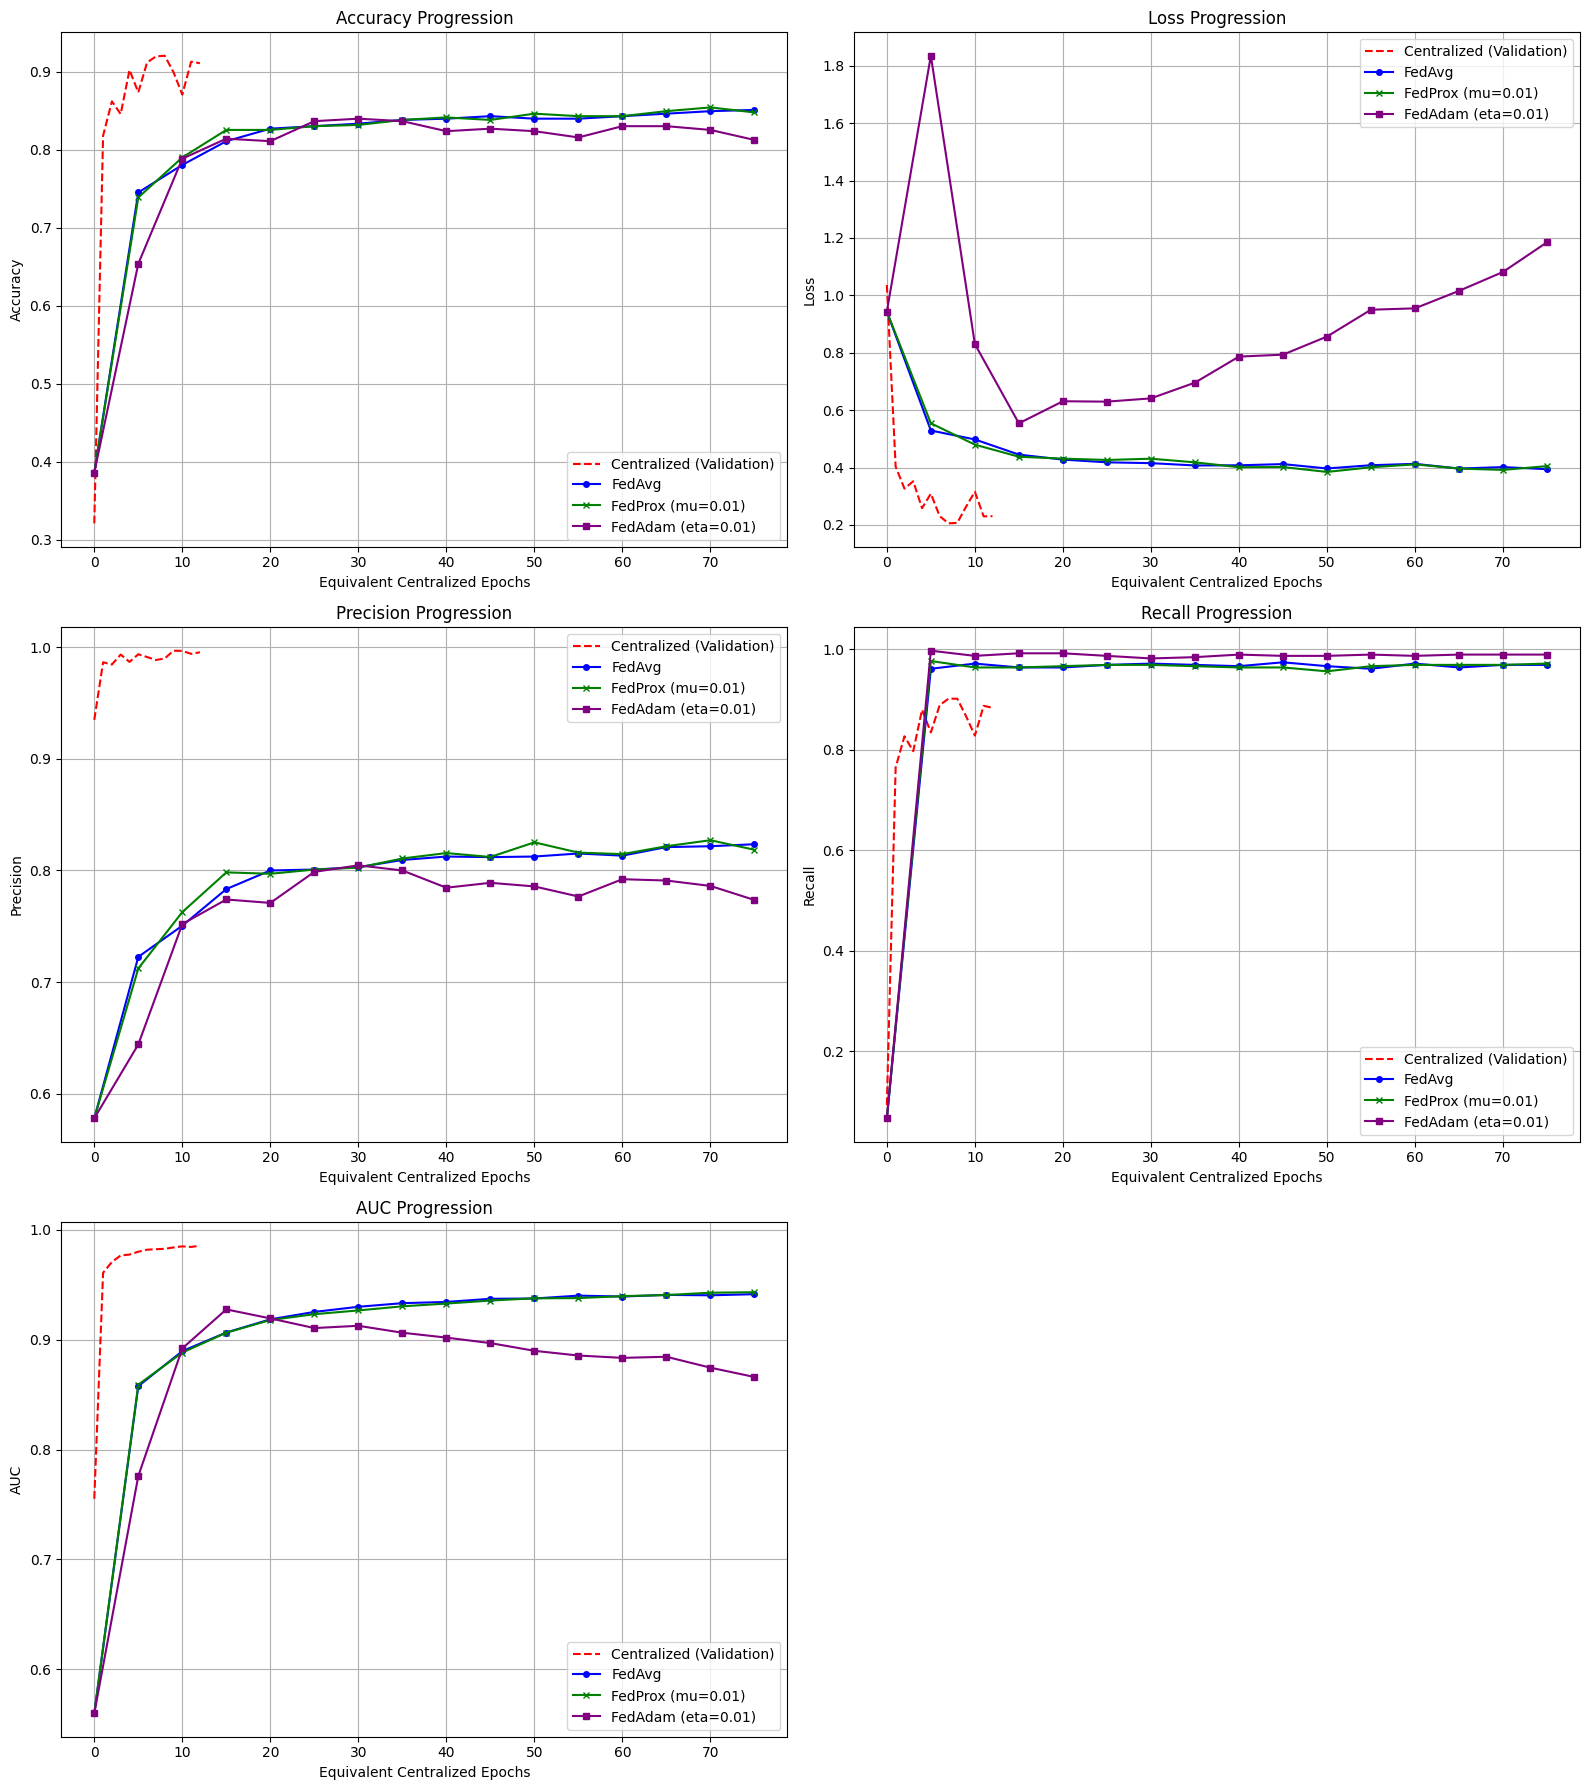

In [ ]:
# --- 12. المقارنة النهائية (مقارنة 4 نماذج مع AUC) ---

# (جلب مقاييس "Epoch 0" المركزية - يبقى كما هو)
init_metrics = initial_model_val_metrics

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#  التعديل: القراءة من القاموس الذي تم تحميله
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# بدلاً من history.history، نستخدم centralized_history_dict
# (الذي تم تعريفه في الخلية 7، سواء بالتدريب أو بالتحميل)
cen_epochs_hist = range(1, len(centralized_history_dict['val_accuracy']) + 1)
cen_acc_hist = centralized_history_dict['val_accuracy']
cen_loss_hist = centralized_history_dict['val_loss']
cen_prec_hist = centralized_history_dict['val_precision']
cen_rec_hist = centralized_history_dict['val_recall']
cen_auc_hist = centralized_history_dict['val_auc']


# (دمج "Epoch 0" مع باقي الدورات - يبقى كما هو)
cen_epochs_plot = [0] + list(cen_epochs_hist)
cen_acc_plot = [init_metrics['accuracy']] + cen_acc_hist
cen_loss_plot = [init_metrics['loss']] + cen_loss_hist
cen_prec_plot = [init_metrics.get('precision', 0.0)] + cen_prec_hist
cen_rec_plot = [init_metrics.get('recall', 0.0)] + cen_rec_hist
cen_auc_plot = [init_metrics.get('auc', 0.0)] + cen_auc_hist


# (دالة استخراج المقاييس الاتحادية - تبقى كما هي)
def extract_fl_history(fl_history, local_epochs_per_round):
    loss_hist = fl_history.losses_centralized
    metrics_hist = fl_history.metrics_centralized
    x_axis = [(r * local_epochs_per_round) for r, _ in loss_hist]
    loss = [l for r, l in loss_hist]
    acc = [m for r, m in metrics_hist.get('accuracy', [])]
    prec = [m for r, m in metrics_hist.get('precision', [])]
    rec = [m for r, m in metrics_hist.get('recall', [])]
    auc = [m for r, m in metrics_hist.get('auc', [])]
    return x_axis, acc, loss, prec, rec, auc


# (تحديد الدورات المحلية - يبقى كما هو)
# LOCAL_EPOCHS_PER_ROUND = 3

# (استخراج بيانات النماذج الاتحادية - يبقى كما هو)
x_fedavg, acc_fedavg, loss_fedavg, prec_fedavg, rec_fedavg, auc_fedavg = extract_fl_history(history_fedavg, LOCAL_EPOCHS_PER_ROUND)
x_fedprox, acc_fedprox, loss_fedprox, prec_fedprox, rec_fedprox, auc_fedprox = extract_fl_history(history_fedprox, LOCAL_EPOCHS_PER_ROUND)
x_fedadam, acc_fedadam, loss_fedadam, prec_fedadam, rec_fedadam, auc_fedadam = extract_fl_history(history_fedadam, LOCAL_EPOCHS_PER_ROUND)


# (كود الرسم البياني - يبقى كما هو تماماً)
# ... (كل كود plt.subplot) ...
plt.figure(figsize=(16, 18))

# المخطط 1: الدقة (Accuracy)
plt.subplot(3, 2, 1)
plt.plot(cen_epochs_plot, cen_acc_plot, label='Centralized (Validation)', linestyle='--', color='red')
plt.plot(x_fedavg, acc_fedavg, label='FedAvg', marker='o', color='blue', markersize=4)
plt.plot(x_fedprox, acc_fedprox, label=f'FedProx (mu={PROXIMAL_MU})', marker='x', color='green', markersize=5)
plt.plot(x_fedadam, acc_fedadam, label=f'FedAdam (eta={SERVER_ETA})', marker='s', color='purple', markersize=4)
plt.title('Accuracy Progression')
plt.xlabel('Equivalent Centralized Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# المخطط 2: الخسارة (Loss)
plt.subplot(3, 2, 2)
plt.plot(cen_epochs_plot, cen_loss_plot, label='Centralized (Validation)', linestyle='--', color='red')
plt.plot(x_fedavg, loss_fedavg, label='FedAvg', marker='o', color='blue', markersize=4)
plt.plot(x_fedprox, loss_fedprox, label=f'FedProx (mu={PROXIMAL_MU})', marker='x', color='green', markersize=5)
plt.plot(x_fedadam, loss_fedadam, label=f'FedAdam (eta={SERVER_ETA})', marker='s', color='purple', markersize=4)
plt.title('Loss Progression')
plt.xlabel('Equivalent Centralized Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# المخطط 3: الدقة (Precision)
plt.subplot(3, 2, 3)
plt.plot(cen_epochs_plot, cen_prec_plot, label='Centralized (Validation)', linestyle='--', color='red')
plt.plot(x_fedavg, prec_fedavg, label='FedAvg', marker='o', color='blue', markersize=4)
plt.plot(x_fedprox, prec_fedprox, label=f'FedProx (mu={PROXIMAL_MU})', marker='x', color='green', markersize=5)
plt.plot(x_fedadam, prec_fedadam, label=f'FedAdam (eta={SERVER_ETA})', marker='s', color='purple', markersize=4)
plt.title('Precision Progression')
plt.xlabel('Equivalent Centralized Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

# المخطط 4: الاستدعاء (Recall)
plt.subplot(3, 2, 4)
plt.plot(cen_epochs_plot, cen_rec_plot, label='Centralized (Validation)', linestyle='--', color='red')
plt.plot(x_fedavg, rec_fedavg, label='FedAvg', marker='o', color='blue', markersize=4)
plt.plot(x_fedprox, rec_fedprox, label=f'FedProx (mu={PROXIMAL_MU})', marker='x', color='green', markersize=5)
plt.plot(x_fedadam, rec_fedadam, label=f'FedAdam (eta={SERVER_ETA})', marker='s', color='purple', markersize=4)
plt.title('Recall Progression')
plt.xlabel('Equivalent Centralized Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

# المخطط 5: AUC
plt.subplot(3, 2, 5)
plt.plot(cen_epochs_plot, cen_auc_plot, label='Centralized (Validation)', linestyle='--', color='red')
plt.plot(x_fedavg, auc_fedavg, label='FedAvg', marker='o', color='blue', markersize=4)
plt.plot(x_fedprox, auc_fedprox, label=f'FedProx (mu={PROXIMAL_MU})', marker='x', color='green', markersize=5)
plt.plot(x_fedadam, auc_fedadam, label=f'FedAdam (eta={SERVER_ETA})', marker='s', color='purple', markersize=4)
plt.title('AUC Progression')
plt.xlabel('Equivalent Centralized Epochs')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# --- 13. جدول ملخص النتائج النهائية ---

print("\n" + "="*60)
print("--- جدول ملخص النتائج النهائية (القيم النهائية من الجولة الأخيرة) ---")
print("="*60 + "\n")

# دالة آمنة لجلب القيمة الأخيرة من قائمة (لتجنب الأخطاء إذا كانت فارغة)
def get_final_metric(metric_list):
    try:
        # إرجاع العنصر الأخير في القائمة
        return metric_list[-1]
    except (IndexError, TypeError):
        # إرجاع 0.0 إذا كانت القائمة فارغة
        return 0.0

# 1. جلب بيانات النموذج المركزي
# (من المتغير 'centralized_results' الذي خزنناه في الخلية 7)
cen_metrics = {
    'Accuracy': centralized_results.get('accuracy', 0.0),
    'Loss': centralized_results.get('loss', 0.0),
    'Precision': centralized_results.get('precision', 0.0),
    'Recall': centralized_results.get('recall', 0.0),
    'AUC': centralized_results.get('auc', 0.0)
}

# 2. جلب البيانات النهائية للنماذج الاتحادية
# (من القوائم التي استخرجناها في الخلية 12)
fedavg_metrics = {
    'Accuracy': get_final_metric(acc_fedavg),
    'Loss': get_final_metric(loss_fedavg),
    'Precision': get_final_metric(prec_fedavg),
    'Recall': get_final_metric(rec_fedavg),
    'AUC': get_final_metric(auc_fedavg)
}

fedprox_metrics = {
    'Accuracy': get_final_metric(acc_fedprox),
    'Loss': get_final_metric(loss_fedprox),
    'Precision': get_final_metric(prec_fedprox),
    'Recall': get_final_metric(rec_fedprox),
    'AUC': get_final_metric(auc_fedprox)
}

fedadam_metrics = {
    'Accuracy': get_final_metric(acc_fedadam),
    'Loss': get_final_metric(loss_fedadam),
    'Precision': get_final_metric(prec_fedadam),
    'Recall': get_final_metric(rec_fedadam),
    'AUC': get_final_metric(auc_fedadam)
}

# 3. إنشاء قاموس البيانات لـ Pandas
data = {
    "المقياس (Metric)": ["Accuracy", "Loss", "Precision", "Recall", "AUC"],
    "المركزي (Centralized)": [
        cen_metrics['Accuracy'],
        cen_metrics['Loss'],
        cen_metrics['Precision'],
        cen_metrics['Recall'],
        cen_metrics['AUC']
    ],
    "FedAvg": [
        fedavg_metrics['Accuracy'],
        fedavg_metrics['Loss'],
        fedavg_metrics['Precision'],
        fedavg_metrics['Recall'],
        fedavg_metrics['AUC']
    ],
    f"FedProx (mu={PROXIMAL_MU})": [
        fedprox_metrics['Accuracy'],
        fedprox_metrics['Loss'],
        fedprox_metrics['Precision'],
        fedprox_metrics['Recall'],
        fedprox_metrics['AUC']
    ],
    f"FedAdam (eta={SERVER_ETA})": [
        fedadam_metrics['Accuracy'],
        fedadam_metrics['Loss'],
        fedadam_metrics['Precision'],
        fedadam_metrics['Recall'],
        fedadam_metrics['AUC']
    ]
}

# 4. إنشاء وطباعة الجدول
summary_df = pd.DataFrame(data)

# نستخدم .to_string() لضمان طباعة الجدول بالكامل بتنسيق نظيف
print(summary_df.to_string(index=False, float_format='%.4f'))


--- جدول ملخص النتائج النهائية (القيم النهائية من الجولة الأخيرة) ---

المقياس (Metric)  المركزي (Centralized)  FedAvg  FedProx (mu=0.01)  FedAdam (eta=0.01)
        Accuracy                 0.8221  0.8510             0.8478              0.8125
            Loss                 0.4456  0.3941             0.4048              1.1851
       Precision                 0.8066  0.8235             0.8186              0.7735
          Recall                 0.9410  0.9692             0.9718              0.9897
             AUC                 0.9050  0.9415             0.9433              0.8661


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
